In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import json
import sys

from tqdm import tqdm

# config_file = sys.argv[1]

config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'


with open(config_file, "r") as f:
    config = json.load(f)["sin"]
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]
# figures_path = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/kdv_results/figures_tau_10'



n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]


pknn_epochs = config["nn_settings"]["pknn_epochs"]


2024-07-29 18:17:51.326331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 18:17:51.440058: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 18:17:52.169501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-07-29 18:17:52.169728: W tensorflow/compiler/xla/stre

In [2]:


# Build model
## PK-NN
# from tensorflow.keras.optimizers import Adam

# from koopmanlib.dictionary import PsiNN_obs
# from koopmanlib.param_solver import KoopmanParametricDLSolver

# n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

# def compute_pk_obs(y0, param_list, B_obs):
#     param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)

#     psi_y = dic_pk(y0)
#     obs_list = [psi_y @ B_obs]

#     tau = param_list.shape[0]

#     for i in range(tau):
#         psi_y = model_K_u_pred_pk([param[i], psi_y])
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Linear
# from koopmanlib.param_solver import KoopmanLinearDLSolver

# dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_linear = KoopmanLinearDLSolver(
#     dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_linear, model_K_u_pred_linear = solver_linear.build_model()

# solver_linear.model.load_weights(
#     os.path.join(weights_path, "linear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_linear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_linear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
#             "Layer_B"
#         )(param)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Bilinear
# from koopmanlib.param_solver import KoopmanBilinearDLSolver

# dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_bilinear = KoopmanBilinearDLSolver(
#     dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()
# solver_bilinear.model.load_weights(
#     os.path.join(weights_path, "bilinear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_bilinear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_bilinear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         u_psiy = tf.einsum("ij,ik->kij", psi_y, param)
#         u_psiy_list = []
#         for curr in u_psiy:
#             u_psiy_list.append(curr)
#         u_psiy_list = tf.concat(u_psiy_list, axis=-1)

#         psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
#             psi_y
#         ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))



In [3]:

# Testing problems
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "darkblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
## Prediction
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list
    
pred_traj_number = 10
np.random.seed(625)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)


In [4]:

# for seed_IC, seed_u in seed_list:
#     # Forward prediction problem setting
#     y0_pred = kdv.generate_y0(seed_IC)

#     # Set the seed of param_list
#     np.random.seed(seed_u)

#     param_pred = (
#         np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
#     )

#     y0_pred_list.append(y0_pred)
#     param_pred_list.append(param_pred)
# error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(
#     dic=dic_pk,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_pk_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )

# mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(
#     error_mass_list_pk
# )
# momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = (
#     compute_stat_info(error_momentum_list_pk)
# )
# error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(
#     dic=dic_linear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_linear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = (
#     compute_stat_info(error_mass_list_linear)
# )
# (
#     momentum_mean_linear,
#     momentum_std_linear,
#     momentum_mean_plus_linear,
#     momentum_mean_minus_linear,
# ) = compute_stat_info(error_momentum_list_linear)
# error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(
#     dic=dic_bilinear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_bilinear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = (
#     compute_stat_info(error_mass_list_bilinear)
# )
# (
#     momentum_mean_bilinear,
#     momentum_std_bilinear,
#     momentum_mean_plus_bilinear,
#     momentum_mean_minus_bilinear,
# ) = compute_stat_info(error_momentum_list_bilinear)
# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Mass", fontsize=28)


# plt.plot(mass_mean_pk,
#           label="Ours", 
#           color=pk_curve,
#           linestyle=pk_linestyle,
#           linewidth=3, 
#           alpha=0.5)
# plt.fill_between(
#     t_axis, np.maximum(mass_mean_minus_pk, 0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5
# )

# plt.plot(mass_mean_linear, 
#          label="M2", 
#          color=linear_curve,
#          linestyle=linear_linestyle, 
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_linear, 0),
#     mass_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(mass_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve,
#          linestyle=bilinear_linestyle,
#            linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_bilinear, 0),
#     mass_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Mass Done---')

# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Momentum", fontsize=28)
# plt.plot(momentum_mean_pk, 
#          label="Ours", 
#          color=pk_curve,
#          linestyle=pk_linestyle, 
#          linewidth=3, 
#          alpha=0.5)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_pk, 0),
#     momentum_mean_plus_pk,
#     color=pk_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_linear,
#           label="M2", 
#           color=linear_curve,
#           linestyle=linear_linestyle,
#           linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_linear, 0),
#     momentum_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve, 
#         linestyle=bilinear_linestyle,
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_bilinear, 0),
#     momentum_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Momentum Done---')


## Build vanilla model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

# Define the input layers
input_x = layers.Input(shape=(Nx,))
input_u = layers.Input(shape=(param_dim,))

# Concatenate the inputs
concatenated = layers.Concatenate()([input_x, input_u])

# Hidden layer
hidden_layer = layers.Dense(20, activation='relu')(concatenated) 

# Output layer
output_y = layers.Dense(Nx, activation='linear')(hidden_layer)

# Create the model
model_vanilla = models.Model(inputs=[input_x, input_u], outputs=output_y)

# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 131)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 20)           2640        ['concatenate[0][0]']        

2024-07-29 18:17:54.629996: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-29 18:17:54.630035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-07-29 18:17:54.630041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-07-29 18:17:54.630184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.171.4
2024-07-29 18:17:54.630204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-07-29 18:17:54.630209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.171.4
2024-07-29 18:17:54.630514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [20]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

In [21]:
history_nonlinear = model_vanilla.fit([data_x, data_u], data_y, epochs=pknn_epochs, batch_size=200, callbacks=lr_callback)

Epoch 1/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.4541e-06 - lr: 1.0000e-03
Epoch 2/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2221e-06 - lr: 1.0000e-03
Epoch 3/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2597e-06 - lr: 1.0000e-03
Epoch 4/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2557e-06 - lr: 1.0000e-03
Epoch 5/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2516e-06 - lr: 1.0000e-03
Epoch 6/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2440e-06 - lr: 1.0000e-03
Epoch 7/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2495e-06 - lr: 1.0000e-03
Epoch 8/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2541e-06 - lr: 1.0000e-03
Epoch 9/500
1000/1000 [==============================] - 2s 2ms/step - loss: 7.2891e-06 - lr: 1.0000e-03
Epoch 10/500
1000/1000 [==============================]

In [8]:

# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))


In [10]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [11]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [12]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [13]:

### Track mass
tau = 10  # time horizon
# lambda_param = 0.005
# lambda_param = 0

vanilla_opt_control_mass_0, vanilla_kdv_opt_mass_soln_0, vanilla_results_mass_0, vanilla_t_list_mass_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)

vanilla_opt_control_mass_5, vanilla_kdv_opt_mass_soln_5, vanilla_results_mass_5, vanilla_t_list_mass_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


vanilla_kdv_opt_mass_0 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_0, axis=-1)
vanilla_kdv_opt_mass_5 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_5, axis=-1)

### Check exact control for KdV equation
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)


def v1_func(x):
    return np.exp(-25 * (x + np.pi / 2) ** 2)


def v2_func(x):
    return np.exp(-25 * (x) ** 2)


def v3_func(x):
    return np.exp(-25 * (x - np.pi / 2) ** 2)


from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi)

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi)

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi)

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1, 1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T)

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape=vanilla_opt_control_mass_0.shape, dtype="float64")

control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500 : 500 + track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1, 1))


Processing time steps:   0%|          | 1/989 [00:04<1:15:50,  4.61s/it]

*** current time *** 0
optimize time:  4.603868722915649


Processing time steps:   0%|          | 2/989 [00:05<38:28,  2.34s/it]  

*** current time *** 1
optimize time:  0.7497637271881104


Processing time steps:   0%|          | 3/989 [00:06<27:23,  1.67s/it]

*** current time *** 2
optimize time:  0.8667140007019043


Processing time steps:   0%|          | 4/989 [00:07<22:02,  1.34s/it]

*** current time *** 3
optimize time:  0.8408629894256592


Processing time steps:   1%|          | 5/989 [00:07<19:21,  1.18s/it]

*** current time *** 4
optimize time:  0.8879885673522949


Processing time steps:   1%|          | 6/989 [00:08<17:29,  1.07s/it]

*** current time *** 5
optimize time:  0.8470842838287354


Processing time steps:   1%|          | 7/989 [00:09<16:25,  1.00s/it]

*** current time *** 6
optimize time:  0.8672971725463867


Processing time steps:   1%|          | 8/989 [00:10<15:34,  1.05it/s]

*** current time *** 7
optimize time:  0.8424391746520996


Processing time steps:   1%|          | 9/989 [00:11<14:38,  1.12it/s]

*** current time *** 8
optimize time:  0.7702291011810303


Processing time steps:   1%|          | 10/989 [00:12<13:57,  1.17it/s]

*** current time *** 9
optimize time:  0.7599782943725586


Processing time steps:   1%|          | 11/989 [00:12<13:23,  1.22it/s]

*** current time *** 10
optimize time:  0.743199348449707


Processing time steps:   1%|          | 12/989 [00:13<12:58,  1.26it/s]

*** current time *** 11
optimize time:  0.7380831241607666


Processing time steps:   1%|▏         | 13/989 [00:14<13:01,  1.25it/s]

*** current time *** 12
optimize time:  0.8074357509613037


Processing time steps:   1%|▏         | 14/989 [00:15<12:59,  1.25it/s]

*** current time *** 13
optimize time:  0.7936282157897949


Processing time steps:   2%|▏         | 15/989 [00:15<12:54,  1.26it/s]

*** current time *** 14
optimize time:  0.7823529243469238


Processing time steps:   2%|▏         | 16/989 [00:16<12:53,  1.26it/s]

*** current time *** 15
optimize time:  0.7912983894348145


Processing time steps:   2%|▏         | 17/989 [00:17<12:48,  1.26it/s]

*** current time *** 16
optimize time:  0.7799584865570068


Processing time steps:   2%|▏         | 18/989 [00:18<12:50,  1.26it/s]

*** current time *** 17
optimize time:  0.796471118927002


Processing time steps:   2%|▏         | 19/989 [00:19<12:53,  1.25it/s]

*** current time *** 18
optimize time:  0.8027281761169434


Processing time steps:   2%|▏         | 20/989 [00:19<12:44,  1.27it/s]

*** current time *** 19
optimize time:  0.7683398723602295


Processing time steps:   2%|▏         | 21/989 [00:20<12:36,  1.28it/s]

*** current time *** 20
optimize time:  0.760392427444458


Processing time steps:   2%|▏         | 22/989 [00:21<12:45,  1.26it/s]

*** current time *** 21
optimize time:  0.8131427764892578


Processing time steps:   2%|▏         | 23/989 [00:22<12:48,  1.26it/s]

*** current time *** 22
optimize time:  0.8034782409667969


Processing time steps:   2%|▏         | 24/989 [00:23<12:40,  1.27it/s]

*** current time *** 23
optimize time:  0.7677302360534668


Processing time steps:   3%|▎         | 25/989 [00:23<12:32,  1.28it/s]

*** current time *** 24
optimize time:  0.7605171203613281


Processing time steps:   3%|▎         | 26/989 [00:24<12:25,  1.29it/s]

*** current time *** 25
optimize time:  0.7549803256988525


Processing time steps:   3%|▎         | 27/989 [00:25<12:19,  1.30it/s]

*** current time *** 26
optimize time:  0.7558059692382812


Processing time steps:   3%|▎         | 28/989 [00:26<12:24,  1.29it/s]

*** current time *** 27
optimize time:  0.785759449005127


Processing time steps:   3%|▎         | 29/989 [00:26<12:33,  1.27it/s]

*** current time *** 28
optimize time:  0.8069562911987305


Processing time steps:   3%|▎         | 30/989 [00:27<12:27,  1.28it/s]

*** current time *** 29
optimize time:  0.7651991844177246


Processing time steps:   3%|▎         | 31/989 [00:28<12:21,  1.29it/s]

*** current time *** 30
optimize time:  0.759636640548706


Processing time steps:   3%|▎         | 32/989 [00:29<12:17,  1.30it/s]

*** current time *** 31
optimize time:  0.7590556144714355


Processing time steps:   3%|▎         | 33/989 [00:29<12:14,  1.30it/s]

*** current time *** 32
optimize time:  0.7601017951965332


Processing time steps:   3%|▎         | 34/989 [00:30<12:13,  1.30it/s]

*** current time *** 33
optimize time:  0.7642107009887695


Processing time steps:   4%|▎         | 35/989 [00:31<12:10,  1.31it/s]

*** current time *** 34
optimize time:  0.7569682598114014


Processing time steps:   4%|▎         | 36/989 [00:32<12:09,  1.31it/s]

*** current time *** 35
optimize time:  0.7615344524383545


Processing time steps:   4%|▎         | 37/989 [00:33<12:07,  1.31it/s]

*** current time *** 36
optimize time:  0.7607758045196533


Processing time steps:   4%|▍         | 38/989 [00:33<12:05,  1.31it/s]

*** current time *** 37
optimize time:  0.7583069801330566


Processing time steps:   4%|▍         | 39/989 [00:34<12:04,  1.31it/s]

*** current time *** 38
optimize time:  0.7584199905395508


Processing time steps:   4%|▍         | 40/989 [00:35<12:01,  1.32it/s]

*** current time *** 39
optimize time:  0.7526335716247559


Processing time steps:   4%|▍         | 41/989 [00:36<12:59,  1.22it/s]

*** current time *** 40
optimize time:  0.9653186798095703


Processing time steps:   4%|▍         | 42/989 [00:37<12:35,  1.25it/s]

*** current time *** 41
optimize time:  0.7372217178344727


Processing time steps:   4%|▍         | 43/989 [00:37<12:30,  1.26it/s]

*** current time *** 42
optimize time:  0.7804036140441895


Processing time steps:   4%|▍         | 44/989 [00:38<12:10,  1.29it/s]

*** current time *** 43
optimize time:  0.7218573093414307


Processing time steps:   5%|▍         | 45/989 [00:39<12:09,  1.29it/s]

*** current time *** 44
optimize time:  0.7682523727416992


Processing time steps:   5%|▍         | 46/989 [00:40<12:11,  1.29it/s]

*** current time *** 45
optimize time:  0.7825145721435547


Processing time steps:   5%|▍         | 47/989 [00:40<12:15,  1.28it/s]

*** current time *** 46
optimize time:  0.7905948162078857


Processing time steps:   5%|▍         | 48/989 [00:41<12:42,  1.23it/s]

*** current time *** 47
optimize time:  0.8752868175506592


Processing time steps:   5%|▍         | 49/989 [00:42<12:48,  1.22it/s]

*** current time *** 48
optimize time:  0.8298721313476562


Processing time steps:   5%|▌         | 50/989 [00:43<12:48,  1.22it/s]

*** current time *** 49
optimize time:  0.8176898956298828


Processing time steps:   5%|▌         | 51/989 [00:44<12:26,  1.26it/s]

*** current time *** 50
optimize time:  0.7405478954315186


Processing time steps:   5%|▌         | 52/989 [00:44<12:15,  1.27it/s]

*** current time *** 51
optimize time:  0.7575757503509521


Processing time steps:   5%|▌         | 53/989 [00:45<12:06,  1.29it/s]

*** current time *** 52
optimize time:  0.7543799877166748


Processing time steps:   5%|▌         | 54/989 [00:46<12:00,  1.30it/s]

*** current time *** 53
optimize time:  0.755319356918335


Processing time steps:   6%|▌         | 55/989 [00:47<11:58,  1.30it/s]

*** current time *** 54
optimize time:  0.7643983364105225


Processing time steps:   6%|▌         | 56/989 [00:47<11:55,  1.30it/s]

*** current time *** 55
optimize time:  0.7568113803863525


Processing time steps:   6%|▌         | 57/989 [00:48<11:52,  1.31it/s]

*** current time *** 56
optimize time:  0.758373498916626


Processing time steps:   6%|▌         | 58/989 [00:49<12:03,  1.29it/s]

*** current time *** 57
optimize time:  0.8001708984375


Processing time steps:   6%|▌         | 59/989 [00:50<11:56,  1.30it/s]

*** current time *** 58
optimize time:  0.7538149356842041


Processing time steps:   6%|▌         | 60/989 [00:50<11:40,  1.33it/s]

*** current time *** 59
optimize time:  0.7110898494720459


Processing time steps:   6%|▌         | 61/989 [00:51<11:33,  1.34it/s]

*** current time *** 60
optimize time:  0.7315073013305664


Processing time steps:   6%|▋         | 62/989 [00:52<11:36,  1.33it/s]

*** current time *** 61
optimize time:  0.7560715675354004


Processing time steps:   6%|▋         | 63/989 [00:53<11:34,  1.33it/s]

*** current time *** 62
optimize time:  0.7461473941802979


Processing time steps:   6%|▋         | 64/989 [00:53<11:34,  1.33it/s]

*** current time *** 63
optimize time:  0.7479205131530762


Processing time steps:   7%|▋         | 65/989 [00:54<11:37,  1.32it/s]

*** current time *** 64
optimize time:  0.7647228240966797


Processing time steps:   7%|▋         | 66/989 [00:55<11:37,  1.32it/s]

*** current time *** 65
optimize time:  0.753164529800415


Processing time steps:   7%|▋         | 67/989 [00:56<11:44,  1.31it/s]

*** current time *** 66
optimize time:  0.7811160087585449


Processing time steps:   7%|▋         | 68/989 [00:56<11:30,  1.33it/s]

*** current time *** 67
optimize time:  0.7137410640716553


Processing time steps:   7%|▋         | 69/989 [00:57<11:19,  1.35it/s]

*** current time *** 68
optimize time:  0.7109968662261963


Processing time steps:   7%|▋         | 70/989 [00:58<11:52,  1.29it/s]

*** current time *** 69
optimize time:  0.8569800853729248


Processing time steps:   7%|▋         | 71/989 [00:59<12:21,  1.24it/s]

*** current time *** 70
optimize time:  0.8822774887084961


Processing time steps:   7%|▋         | 72/989 [01:00<12:01,  1.27it/s]

*** current time *** 71
optimize time:  0.7334368228912354


Processing time steps:   7%|▋         | 73/989 [01:00<11:49,  1.29it/s]

*** current time *** 72
optimize time:  0.7459473609924316


Processing time steps:   7%|▋         | 74/989 [01:01<11:40,  1.31it/s]

*** current time *** 73
optimize time:  0.7412035465240479


Processing time steps:   8%|▊         | 75/989 [01:02<11:46,  1.29it/s]

*** current time *** 74
optimize time:  0.7875266075134277


Processing time steps:   8%|▊         | 76/989 [01:03<11:39,  1.30it/s]

*** current time *** 75
optimize time:  0.7491176128387451


Processing time steps:   8%|▊         | 77/989 [01:04<11:47,  1.29it/s]

*** current time *** 76
optimize time:  0.7937593460083008


Processing time steps:   8%|▊         | 78/989 [01:04<11:36,  1.31it/s]

*** current time *** 77
optimize time:  0.7384908199310303


Processing time steps:   8%|▊         | 79/989 [01:05<11:39,  1.30it/s]

*** current time *** 78
optimize time:  0.7756385803222656


Processing time steps:   8%|▊         | 80/989 [01:06<11:35,  1.31it/s]

*** current time *** 79
optimize time:  0.7534782886505127


Processing time steps:   8%|▊         | 81/989 [01:07<11:28,  1.32it/s]

*** current time *** 80
optimize time:  0.7395808696746826


Processing time steps:   8%|▊         | 82/989 [01:07<11:21,  1.33it/s]

*** current time *** 81
optimize time:  0.7325975894927979


Processing time steps:   8%|▊         | 83/989 [01:08<11:23,  1.33it/s]

*** current time *** 82
optimize time:  0.7576999664306641


Processing time steps:   8%|▊         | 84/989 [01:09<11:28,  1.31it/s]

*** current time *** 83
optimize time:  0.7755746841430664


Processing time steps:   9%|▊         | 85/989 [01:10<12:07,  1.24it/s]

*** current time *** 84
optimize time:  0.903573751449585


Processing time steps:   9%|▊         | 86/989 [01:10<11:59,  1.25it/s]

*** current time *** 85
optimize time:  0.7774209976196289


Processing time steps:   9%|▉         | 87/989 [01:11<11:46,  1.28it/s]

*** current time *** 86
optimize time:  0.7498672008514404


Processing time steps:   9%|▉         | 88/989 [01:12<12:03,  1.24it/s]

*** current time *** 87
optimize time:  0.8463866710662842


Processing time steps:   9%|▉         | 89/989 [01:13<11:49,  1.27it/s]

*** current time *** 88
optimize time:  0.7514026165008545


Processing time steps:   9%|▉         | 90/989 [01:14<11:41,  1.28it/s]

*** current time *** 89
optimize time:  0.7600579261779785


Processing time steps:   9%|▉         | 91/989 [01:14<11:35,  1.29it/s]

*** current time *** 90
optimize time:  0.7563726902008057


Processing time steps:   9%|▉         | 92/989 [01:15<11:38,  1.28it/s]

*** current time *** 91
optimize time:  0.7859785556793213


Processing time steps:   9%|▉         | 93/989 [01:16<11:33,  1.29it/s]

*** current time *** 92
optimize time:  0.7599077224731445


Processing time steps:  10%|▉         | 94/989 [01:17<11:27,  1.30it/s]

*** current time *** 93
optimize time:  0.7515289783477783


Processing time steps:  10%|▉         | 95/989 [01:18<12:00,  1.24it/s]

*** current time *** 94
optimize time:  0.8924481868743896


Processing time steps:  10%|▉         | 96/989 [01:18<11:56,  1.25it/s]

*** current time *** 95
optimize time:  0.7896647453308105


Processing time steps:  10%|▉         | 97/989 [01:19<11:44,  1.27it/s]

*** current time *** 96
optimize time:  0.7561602592468262


Processing time steps:  10%|▉         | 98/989 [01:20<11:35,  1.28it/s]

*** current time *** 97
optimize time:  0.7557060718536377


Processing time steps:  10%|█         | 99/989 [01:21<11:26,  1.30it/s]

*** current time *** 98
optimize time:  0.7494792938232422


Processing time steps:  10%|█         | 100/989 [01:21<11:23,  1.30it/s]

*** current time *** 99
optimize time:  0.7604506015777588


Processing time steps:  10%|█         | 101/989 [01:22<11:20,  1.31it/s]

*** current time *** 100
optimize time:  0.7567944526672363


Processing time steps:  10%|█         | 102/989 [01:23<11:12,  1.32it/s]

*** current time *** 101
optimize time:  0.7350432872772217


Processing time steps:  10%|█         | 103/989 [01:24<11:07,  1.33it/s]

*** current time *** 102
optimize time:  0.7417356967926025


Processing time steps:  11%|█         | 104/989 [01:24<10:59,  1.34it/s]

*** current time *** 103
optimize time:  0.7240602970123291


Processing time steps:  11%|█         | 105/989 [01:25<10:58,  1.34it/s]

*** current time *** 104
optimize time:  0.7390813827514648


Processing time steps:  11%|█         | 106/989 [01:26<10:50,  1.36it/s]

*** current time *** 105
optimize time:  0.7156054973602295


Processing time steps:  11%|█         | 107/989 [01:27<10:51,  1.35it/s]

*** current time *** 106
optimize time:  0.7420074939727783


Processing time steps:  11%|█         | 108/989 [01:27<11:18,  1.30it/s]

*** current time *** 107
optimize time:  0.8401215076446533


Processing time steps:  11%|█         | 109/989 [01:28<11:48,  1.24it/s]

*** current time *** 108
optimize time:  0.8820087909698486


Processing time steps:  11%|█         | 110/989 [01:29<11:39,  1.26it/s]

*** current time *** 109
optimize time:  0.7718038558959961


Processing time steps:  11%|█         | 111/989 [01:30<11:30,  1.27it/s]

*** current time *** 110
optimize time:  0.7632710933685303


Processing time steps:  11%|█▏        | 112/989 [01:31<11:23,  1.28it/s]

*** current time *** 111
optimize time:  0.7600996494293213


Processing time steps:  11%|█▏        | 113/989 [01:31<11:08,  1.31it/s]

*** current time *** 112
optimize time:  0.7250053882598877


Processing time steps:  12%|█▏        | 114/989 [01:32<11:17,  1.29it/s]

*** current time *** 113
optimize time:  0.7983942031860352


Processing time steps:  12%|█▏        | 115/989 [01:33<11:11,  1.30it/s]

*** current time *** 114
optimize time:  0.7505831718444824


Processing time steps:  12%|█▏        | 116/989 [01:34<11:10,  1.30it/s]

*** current time *** 115
optimize time:  0.7632441520690918


Processing time steps:  12%|█▏        | 117/989 [01:34<11:04,  1.31it/s]

*** current time *** 116
optimize time:  0.7469263076782227


Processing time steps:  12%|█▏        | 118/989 [01:35<10:51,  1.34it/s]

*** current time *** 117
optimize time:  0.7139279842376709


Processing time steps:  12%|█▏        | 119/989 [01:36<10:56,  1.32it/s]

*** current time *** 118
optimize time:  0.7680013179779053


Processing time steps:  12%|█▏        | 120/989 [01:37<10:51,  1.33it/s]

*** current time *** 119
optimize time:  0.736506462097168


Processing time steps:  12%|█▏        | 121/989 [01:37<10:52,  1.33it/s]

*** current time *** 120
optimize time:  0.7513852119445801


Processing time steps:  12%|█▏        | 122/989 [01:38<10:58,  1.32it/s]

*** current time *** 121
optimize time:  0.7762258052825928


Processing time steps:  12%|█▏        | 123/989 [01:39<11:04,  1.30it/s]

*** current time *** 122
optimize time:  0.7817394733428955


Processing time steps:  13%|█▎        | 124/989 [01:40<11:15,  1.28it/s]

*** current time *** 123
optimize time:  0.8103177547454834


Processing time steps:  13%|█▎        | 125/989 [01:40<11:04,  1.30it/s]

*** current time *** 124
optimize time:  0.7377736568450928


Processing time steps:  13%|█▎        | 126/989 [01:41<11:05,  1.30it/s]

*** current time *** 125
optimize time:  0.7719278335571289


Processing time steps:  13%|█▎        | 127/989 [01:42<11:09,  1.29it/s]

*** current time *** 126
optimize time:  0.7887091636657715


Processing time steps:  13%|█▎        | 128/989 [01:43<11:05,  1.29it/s]

*** current time *** 127
optimize time:  0.7592849731445312


Processing time steps:  13%|█▎        | 129/989 [01:44<11:02,  1.30it/s]

*** current time *** 128
optimize time:  0.7610650062561035


Processing time steps:  13%|█▎        | 130/989 [01:44<11:01,  1.30it/s]

*** current time *** 129
optimize time:  0.7667715549468994


Processing time steps:  13%|█▎        | 131/989 [01:45<10:52,  1.32it/s]

*** current time *** 130
optimize time:  0.7365150451660156


Processing time steps:  13%|█▎        | 132/989 [01:46<11:01,  1.30it/s]

*** current time *** 131
optimize time:  0.7962443828582764


Processing time steps:  13%|█▎        | 133/989 [01:47<10:52,  1.31it/s]

*** current time *** 132
optimize time:  0.7373838424682617


Processing time steps:  14%|█▎        | 134/989 [01:47<10:55,  1.31it/s]

*** current time *** 133
optimize time:  0.773550271987915


Processing time steps:  14%|█▎        | 135/989 [01:48<10:57,  1.30it/s]

*** current time *** 134
optimize time:  0.774498701095581


Processing time steps:  14%|█▍        | 136/989 [01:49<10:52,  1.31it/s]

*** current time *** 135
optimize time:  0.7522552013397217


Processing time steps:  14%|█▍        | 137/989 [01:50<10:44,  1.32it/s]

*** current time *** 136
optimize time:  0.7350380420684814


Processing time steps:  14%|█▍        | 138/989 [01:51<11:04,  1.28it/s]

*** current time *** 137
optimize time:  0.8336238861083984


Processing time steps:  14%|█▍        | 139/989 [01:51<10:58,  1.29it/s]

*** current time *** 138
optimize time:  0.7592320442199707


Processing time steps:  14%|█▍        | 140/989 [01:52<10:57,  1.29it/s]

*** current time *** 139
optimize time:  0.7701928615570068


Processing time steps:  14%|█▍        | 141/989 [01:53<10:50,  1.30it/s]

*** current time *** 140
optimize time:  0.7473344802856445


Processing time steps:  14%|█▍        | 142/989 [01:54<10:46,  1.31it/s]

*** current time *** 141
optimize time:  0.75235915184021


Processing time steps:  14%|█▍        | 143/989 [01:54<10:56,  1.29it/s]

*** current time *** 142
optimize time:  0.8039693832397461


Processing time steps:  15%|█▍        | 144/989 [01:55<10:50,  1.30it/s]

*** current time *** 143
optimize time:  0.7501816749572754


Processing time steps:  15%|█▍        | 145/989 [01:56<10:46,  1.31it/s]

*** current time *** 144
optimize time:  0.7545146942138672


Processing time steps:  15%|█▍        | 146/989 [01:57<10:37,  1.32it/s]

*** current time *** 145
optimize time:  0.7328817844390869


Processing time steps:  15%|█▍        | 147/989 [01:57<10:33,  1.33it/s]

*** current time *** 146
optimize time:  0.738013505935669


Processing time steps:  15%|█▍        | 148/989 [01:58<10:26,  1.34it/s]

*** current time *** 147
optimize time:  0.7244057655334473


Processing time steps:  15%|█▌        | 149/989 [01:59<10:34,  1.32it/s]

*** current time *** 148
optimize time:  0.7775185108184814


Processing time steps:  15%|█▌        | 150/989 [02:00<10:48,  1.29it/s]

*** current time *** 149
optimize time:  0.8122038841247559


Processing time steps:  15%|█▌        | 151/989 [02:00<11:01,  1.27it/s]

*** current time *** 150
optimize time:  0.8260583877563477


Processing time steps:  15%|█▌        | 152/989 [02:01<10:51,  1.28it/s]

*** current time *** 151
optimize time:  0.7492084503173828


Processing time steps:  15%|█▌        | 153/989 [02:02<10:46,  1.29it/s]

*** current time *** 152
optimize time:  0.7581398487091064


Processing time steps:  16%|█▌        | 154/989 [02:03<10:39,  1.31it/s]

*** current time *** 153
optimize time:  0.7473180294036865


Processing time steps:  16%|█▌        | 155/989 [02:03<10:32,  1.32it/s]

*** current time *** 154
optimize time:  0.7400805950164795


Processing time steps:  16%|█▌        | 156/989 [02:04<10:46,  1.29it/s]

*** current time *** 155
optimize time:  0.8149893283843994


Processing time steps:  16%|█▌        | 157/989 [02:05<10:55,  1.27it/s]

*** current time *** 156
optimize time:  0.8097848892211914


Processing time steps:  16%|█▌        | 158/989 [02:06<10:53,  1.27it/s]

*** current time *** 157
optimize time:  0.7813394069671631


Processing time steps:  16%|█▌        | 159/989 [02:07<10:51,  1.27it/s]

*** current time *** 158
optimize time:  0.7798388004302979


Processing time steps:  16%|█▌        | 160/989 [02:08<11:12,  1.23it/s]

*** current time *** 159
optimize time:  0.8706841468811035


Processing time steps:  16%|█▋        | 161/989 [02:08<11:27,  1.20it/s]

*** current time *** 160
optimize time:  0.87107253074646


Processing time steps:  16%|█▋        | 162/989 [02:09<11:12,  1.23it/s]

*** current time *** 161
optimize time:  0.7711248397827148


Processing time steps:  16%|█▋        | 163/989 [02:10<10:58,  1.26it/s]

*** current time *** 162
optimize time:  0.7543728351593018


Processing time steps:  17%|█▋        | 164/989 [02:11<10:46,  1.28it/s]

*** current time *** 163
optimize time:  0.7517266273498535


Processing time steps:  17%|█▋        | 165/989 [02:11<10:36,  1.29it/s]

*** current time *** 164
optimize time:  0.7428760528564453


Processing time steps:  17%|█▋        | 166/989 [02:12<10:29,  1.31it/s]

*** current time *** 165
optimize time:  0.7433032989501953


Processing time steps:  17%|█▋        | 167/989 [02:13<10:24,  1.32it/s]

*** current time *** 166
optimize time:  0.7469902038574219


Processing time steps:  17%|█▋        | 168/989 [02:14<10:22,  1.32it/s]

*** current time *** 167
optimize time:  0.7521023750305176


Processing time steps:  17%|█▋        | 169/989 [02:14<10:19,  1.32it/s]

*** current time *** 168
optimize time:  0.7481865882873535


Processing time steps:  17%|█▋        | 170/989 [02:15<10:18,  1.32it/s]

*** current time *** 169
optimize time:  0.7506618499755859


Processing time steps:  17%|█▋        | 171/989 [02:16<10:26,  1.31it/s]

*** current time *** 170
optimize time:  0.7897629737854004


Processing time steps:  17%|█▋        | 172/989 [02:17<10:18,  1.32it/s]

*** current time *** 171
optimize time:  0.733041524887085


Processing time steps:  17%|█▋        | 173/989 [02:17<10:09,  1.34it/s]

*** current time *** 172
optimize time:  0.7218832969665527


Processing time steps:  18%|█▊        | 174/989 [02:18<10:11,  1.33it/s]

*** current time *** 173
optimize time:  0.7559001445770264


Processing time steps:  18%|█▊        | 175/989 [02:19<10:08,  1.34it/s]

*** current time *** 174
optimize time:  0.7371819019317627


Processing time steps:  18%|█▊        | 176/989 [02:20<10:07,  1.34it/s]

*** current time *** 175
optimize time:  0.7441871166229248


Processing time steps:  18%|█▊        | 177/989 [02:21<10:25,  1.30it/s]

*** current time *** 176
optimize time:  0.8211569786071777


Processing time steps:  18%|█▊        | 178/989 [02:21<10:25,  1.30it/s]

*** current time *** 177
optimize time:  0.7717671394348145


Processing time steps:  18%|█▊        | 179/989 [02:22<10:13,  1.32it/s]

*** current time *** 178
optimize time:  0.7221956253051758


Processing time steps:  18%|█▊        | 180/989 [02:23<10:11,  1.32it/s]

*** current time *** 179
optimize time:  0.7505412101745605


Processing time steps:  18%|█▊        | 181/989 [02:24<10:09,  1.33it/s]

*** current time *** 180
optimize time:  0.7481558322906494


Processing time steps:  18%|█▊        | 182/989 [02:24<10:07,  1.33it/s]

*** current time *** 181
optimize time:  0.7459685802459717


Processing time steps:  19%|█▊        | 183/989 [02:25<10:06,  1.33it/s]

*** current time *** 182
optimize time:  0.7481698989868164


Processing time steps:  19%|█▊        | 184/989 [02:26<10:05,  1.33it/s]

*** current time *** 183
optimize time:  0.748054027557373


Processing time steps:  19%|█▊        | 185/989 [02:27<10:05,  1.33it/s]

*** current time *** 184
optimize time:  0.7541830539703369


Processing time steps:  19%|█▉        | 186/989 [02:27<09:56,  1.35it/s]

*** current time *** 185
optimize time:  0.7178668975830078


Processing time steps:  19%|█▉        | 187/989 [02:28<09:52,  1.35it/s]

*** current time *** 186
optimize time:  0.7247152328491211


Processing time steps:  19%|█▉        | 188/989 [02:29<09:57,  1.34it/s]

*** current time *** 187
optimize time:  0.7623763084411621


Processing time steps:  19%|█▉        | 189/989 [02:30<09:54,  1.35it/s]

*** current time *** 188
optimize time:  0.7313244342803955


Processing time steps:  19%|█▉        | 190/989 [02:30<09:51,  1.35it/s]

*** current time *** 189
optimize time:  0.7310285568237305


Processing time steps:  19%|█▉        | 191/989 [02:31<09:51,  1.35it/s]

*** current time *** 190
optimize time:  0.743767261505127


Processing time steps:  19%|█▉        | 192/989 [02:32<09:53,  1.34it/s]

*** current time *** 191
optimize time:  0.7495372295379639


Processing time steps:  20%|█▉        | 193/989 [02:32<09:53,  1.34it/s]

*** current time *** 192
optimize time:  0.7455947399139404


Processing time steps:  20%|█▉        | 194/989 [02:33<09:53,  1.34it/s]

*** current time *** 193
optimize time:  0.7467939853668213


Processing time steps:  20%|█▉        | 195/989 [02:34<09:53,  1.34it/s]

*** current time *** 194
optimize time:  0.7451155185699463


Processing time steps:  20%|█▉        | 196/989 [02:35<09:52,  1.34it/s]

*** current time *** 195
optimize time:  0.7469096183776855


Processing time steps:  20%|█▉        | 197/989 [02:35<09:48,  1.34it/s]

*** current time *** 196
optimize time:  0.7315976619720459


Processing time steps:  20%|██        | 198/989 [02:36<09:38,  1.37it/s]

*** current time *** 197
optimize time:  0.700934886932373


Processing time steps:  20%|██        | 199/989 [02:37<09:37,  1.37it/s]

*** current time *** 198
optimize time:  0.7284867763519287


Processing time steps:  20%|██        | 200/989 [02:38<09:47,  1.34it/s]

*** current time *** 199
optimize time:  0.7724535465240479


Processing time steps:  20%|██        | 201/989 [02:38<09:52,  1.33it/s]

*** current time *** 200
optimize time:  0.7662451267242432


Processing time steps:  20%|██        | 202/989 [02:39<10:05,  1.30it/s]

*** current time *** 201
optimize time:  0.808178186416626


Processing time steps:  21%|██        | 203/989 [02:40<10:01,  1.31it/s]

*** current time *** 202
optimize time:  0.7534387111663818


Processing time steps:  21%|██        | 204/989 [02:41<10:00,  1.31it/s]

*** current time *** 203
optimize time:  0.7622630596160889


Processing time steps:  21%|██        | 205/989 [02:42<09:59,  1.31it/s]

*** current time *** 204
optimize time:  0.7624444961547852


Processing time steps:  21%|██        | 206/989 [02:42<09:58,  1.31it/s]

*** current time *** 205
optimize time:  0.7605366706848145


Processing time steps:  21%|██        | 207/989 [02:43<10:22,  1.26it/s]

*** current time *** 206
optimize time:  0.865260124206543


Processing time steps:  21%|██        | 208/989 [02:44<10:23,  1.25it/s]

*** current time *** 207
optimize time:  0.8005220890045166


Processing time steps:  21%|██        | 209/989 [02:45<10:22,  1.25it/s]

*** current time *** 208
optimize time:  0.7958221435546875


Processing time steps:  21%|██        | 210/989 [02:45<10:06,  1.29it/s]

*** current time *** 209
optimize time:  0.7288393974304199


Processing time steps:  21%|██▏       | 211/989 [02:46<09:48,  1.32it/s]

*** current time *** 210
optimize time:  0.7033829689025879


Processing time steps:  21%|██▏       | 212/989 [02:47<09:41,  1.34it/s]

*** current time *** 211
optimize time:  0.7272953987121582


Processing time steps:  22%|██▏       | 213/989 [02:48<09:30,  1.36it/s]

*** current time *** 212
optimize time:  0.7027931213378906


Processing time steps:  22%|██▏       | 214/989 [02:48<09:41,  1.33it/s]

*** current time *** 213
optimize time:  0.7818343639373779


Processing time steps:  22%|██▏       | 215/989 [02:49<09:42,  1.33it/s]

*** current time *** 214
optimize time:  0.7579689025878906


Processing time steps:  22%|██▏       | 216/989 [02:50<09:42,  1.33it/s]

*** current time *** 215
optimize time:  0.7522444725036621


Processing time steps:  22%|██▏       | 217/989 [02:51<10:02,  1.28it/s]

*** current time *** 216
optimize time:  0.8408217430114746


Processing time steps:  22%|██▏       | 218/989 [02:52<10:25,  1.23it/s]

*** current time *** 217
optimize time:  0.8790538311004639


Processing time steps:  22%|██▏       | 219/989 [02:52<10:10,  1.26it/s]

*** current time *** 218
optimize time:  0.7473783493041992


Processing time steps:  22%|██▏       | 220/989 [02:53<09:55,  1.29it/s]

*** current time *** 219
optimize time:  0.7297110557556152


Processing time steps:  22%|██▏       | 221/989 [02:54<09:43,  1.32it/s]

*** current time *** 220
optimize time:  0.721794843673706


Processing time steps:  22%|██▏       | 222/989 [02:55<09:48,  1.30it/s]

*** current time *** 221
optimize time:  0.7847898006439209


Processing time steps:  23%|██▎       | 223/989 [02:55<09:39,  1.32it/s]

*** current time *** 222
optimize time:  0.7289605140686035


Processing time steps:  23%|██▎       | 224/989 [02:56<09:30,  1.34it/s]

*** current time *** 223
optimize time:  0.7166314125061035


Processing time steps:  23%|██▎       | 225/989 [02:57<09:26,  1.35it/s]

*** current time *** 224
optimize time:  0.7288837432861328


Processing time steps:  23%|██▎       | 226/989 [02:58<09:26,  1.35it/s]

*** current time *** 225
optimize time:  0.7433373928070068


Processing time steps:  23%|██▎       | 227/989 [02:58<09:29,  1.34it/s]

*** current time *** 226
optimize time:  0.7549662590026855


Processing time steps:  23%|██▎       | 228/989 [02:59<09:24,  1.35it/s]

*** current time *** 227
optimize time:  0.7276520729064941


Processing time steps:  23%|██▎       | 229/989 [03:00<09:28,  1.34it/s]

*** current time *** 228
optimize time:  0.7608997821807861


Processing time steps:  23%|██▎       | 230/989 [03:01<09:31,  1.33it/s]

*** current time *** 229
optimize time:  0.7596442699432373


Processing time steps:  23%|██▎       | 231/989 [03:01<09:30,  1.33it/s]

*** current time *** 230
optimize time:  0.7487998008728027


Processing time steps:  23%|██▎       | 232/989 [03:02<09:31,  1.32it/s]

*** current time *** 231
optimize time:  0.7591896057128906


Processing time steps:  24%|██▎       | 233/989 [03:03<09:28,  1.33it/s]

*** current time *** 232
optimize time:  0.7426357269287109


Processing time steps:  24%|██▎       | 234/989 [03:04<09:29,  1.33it/s]

*** current time *** 233
optimize time:  0.7568273544311523


Processing time steps:  24%|██▍       | 235/989 [03:04<09:34,  1.31it/s]

*** current time *** 234
optimize time:  0.7784454822540283


Processing time steps:  24%|██▍       | 236/989 [03:05<09:31,  1.32it/s]

*** current time *** 235
optimize time:  0.7475836277008057


Processing time steps:  24%|██▍       | 237/989 [03:06<09:28,  1.32it/s]

*** current time *** 236
optimize time:  0.7457876205444336


Processing time steps:  24%|██▍       | 238/989 [03:07<09:25,  1.33it/s]

*** current time *** 237
optimize time:  0.7461228370666504


Processing time steps:  24%|██▍       | 239/989 [03:07<09:39,  1.30it/s]

*** current time *** 238
optimize time:  0.8133478164672852


Processing time steps:  24%|██▍       | 240/989 [03:08<09:40,  1.29it/s]

*** current time *** 239
optimize time:  0.7781023979187012


Processing time steps:  24%|██▍       | 241/989 [03:09<09:27,  1.32it/s]

*** current time *** 240
optimize time:  0.7180030345916748


Processing time steps:  24%|██▍       | 242/989 [03:10<09:33,  1.30it/s]

*** current time *** 241
optimize time:  0.7876229286193848


Processing time steps:  25%|██▍       | 243/989 [03:11<09:51,  1.26it/s]

*** current time *** 242
optimize time:  0.8448731899261475


Processing time steps:  25%|██▍       | 244/989 [03:11<09:37,  1.29it/s]

*** current time *** 243
optimize time:  0.7324714660644531


Processing time steps:  25%|██▍       | 245/989 [03:12<09:43,  1.28it/s]

*** current time *** 244
optimize time:  0.8023059368133545


Processing time steps:  25%|██▍       | 246/989 [03:13<09:38,  1.28it/s]

*** current time *** 245
optimize time:  0.7642407417297363


Processing time steps:  25%|██▍       | 247/989 [03:14<09:34,  1.29it/s]

*** current time *** 246
optimize time:  0.7609267234802246


Processing time steps:  25%|██▌       | 248/989 [03:14<09:31,  1.30it/s]

*** current time *** 247
optimize time:  0.7636518478393555


Processing time steps:  25%|██▌       | 249/989 [03:15<09:30,  1.30it/s]

*** current time *** 248
optimize time:  0.7656853199005127


Processing time steps:  25%|██▌       | 250/989 [03:16<09:18,  1.32it/s]

*** current time *** 249
optimize time:  0.718768835067749


Processing time steps:  25%|██▌       | 251/989 [03:17<09:07,  1.35it/s]

*** current time *** 250
optimize time:  0.7067451477050781


Processing time steps:  25%|██▌       | 252/989 [03:18<09:46,  1.26it/s]

*** current time *** 251
optimize time:  0.9188551902770996


Processing time steps:  26%|██▌       | 253/989 [03:18<09:36,  1.28it/s]

*** current time *** 252
optimize time:  0.7519569396972656


Processing time steps:  26%|██▌       | 254/989 [03:19<09:29,  1.29it/s]

*** current time *** 253
optimize time:  0.7534308433532715


Processing time steps:  26%|██▌       | 255/989 [03:20<09:24,  1.30it/s]

*** current time *** 254
optimize time:  0.751793384552002


Processing time steps:  26%|██▌       | 256/989 [03:21<09:26,  1.29it/s]

*** current time *** 255
optimize time:  0.7781674861907959


Processing time steps:  26%|██▌       | 257/989 [03:21<09:13,  1.32it/s]

*** current time *** 256
optimize time:  0.714646577835083


Processing time steps:  26%|██▌       | 258/989 [03:22<09:05,  1.34it/s]

*** current time *** 257
optimize time:  0.7204906940460205


Processing time steps:  26%|██▌       | 259/989 [03:23<08:58,  1.36it/s]

*** current time *** 258
optimize time:  0.7176177501678467


Processing time steps:  26%|██▋       | 260/989 [03:24<09:01,  1.35it/s]

*** current time *** 259
optimize time:  0.7497544288635254


Processing time steps:  26%|██▋       | 261/989 [03:24<09:03,  1.34it/s]

*** current time *** 260
optimize time:  0.752234697341919


Processing time steps:  26%|██▋       | 262/989 [03:25<09:03,  1.34it/s]

*** current time *** 261
optimize time:  0.7500607967376709


Processing time steps:  27%|██▋       | 263/989 [03:26<09:03,  1.34it/s]

*** current time *** 262
optimize time:  0.7473471164703369


Processing time steps:  27%|██▋       | 264/989 [03:27<09:04,  1.33it/s]

*** current time *** 263
optimize time:  0.7526135444641113


Processing time steps:  27%|██▋       | 265/989 [03:27<09:04,  1.33it/s]

*** current time *** 264
optimize time:  0.7519776821136475


Processing time steps:  27%|██▋       | 266/989 [03:28<09:05,  1.33it/s]

*** current time *** 265
optimize time:  0.7581984996795654


Processing time steps:  27%|██▋       | 267/989 [03:29<09:05,  1.32it/s]

*** current time *** 266
optimize time:  0.7567129135131836


Processing time steps:  27%|██▋       | 268/989 [03:30<09:03,  1.33it/s]

*** current time *** 267
optimize time:  0.7469100952148438


Processing time steps:  27%|██▋       | 269/989 [03:30<09:04,  1.32it/s]

*** current time *** 268
optimize time:  0.758500337600708


Processing time steps:  27%|██▋       | 270/989 [03:31<09:00,  1.33it/s]

*** current time *** 269
optimize time:  0.736752986907959


Processing time steps:  27%|██▋       | 271/989 [03:32<08:49,  1.36it/s]

*** current time *** 270
optimize time:  0.7038829326629639


Processing time steps:  28%|██▊       | 272/989 [03:32<08:44,  1.37it/s]

*** current time *** 271
optimize time:  0.7170839309692383


Processing time steps:  28%|██▊       | 273/989 [03:33<08:45,  1.36it/s]

*** current time *** 272
optimize time:  0.7385025024414062


Processing time steps:  28%|██▊       | 274/989 [03:34<08:50,  1.35it/s]

*** current time *** 273
optimize time:  0.7576138973236084


Processing time steps:  28%|██▊       | 275/989 [03:35<09:00,  1.32it/s]

*** current time *** 274
optimize time:  0.7902224063873291


Processing time steps:  28%|██▊       | 276/989 [03:36<09:12,  1.29it/s]

*** current time *** 275
optimize time:  0.811309814453125


Processing time steps:  28%|██▊       | 277/989 [03:36<08:56,  1.33it/s]

*** current time *** 276
optimize time:  0.7046372890472412


Processing time steps:  28%|██▊       | 278/989 [03:37<08:51,  1.34it/s]

*** current time *** 277
optimize time:  0.727642297744751


Processing time steps:  28%|██▊       | 279/989 [03:38<08:58,  1.32it/s]

*** current time *** 278
optimize time:  0.7808279991149902


Processing time steps:  28%|██▊       | 280/989 [03:39<08:46,  1.35it/s]

*** current time *** 279
optimize time:  0.7044141292572021


Processing time steps:  28%|██▊       | 281/989 [03:39<08:44,  1.35it/s]

*** current time *** 280
optimize time:  0.7350327968597412


Processing time steps:  29%|██▊       | 282/989 [03:40<08:45,  1.35it/s]

*** current time *** 281
optimize time:  0.7453696727752686


Processing time steps:  29%|██▊       | 283/989 [03:41<08:49,  1.33it/s]

*** current time *** 282
optimize time:  0.7620036602020264


Processing time steps:  29%|██▊       | 284/989 [03:41<08:42,  1.35it/s]

*** current time *** 283
optimize time:  0.7184925079345703


Processing time steps:  29%|██▉       | 285/989 [03:42<08:47,  1.33it/s]

*** current time *** 284
optimize time:  0.7684731483459473


Processing time steps:  29%|██▉       | 286/989 [03:43<08:50,  1.33it/s]

*** current time *** 285
optimize time:  0.7617812156677246


Processing time steps:  29%|██▉       | 287/989 [03:44<08:52,  1.32it/s]

*** current time *** 286
optimize time:  0.7658567428588867


Processing time steps:  29%|██▉       | 288/989 [03:45<08:43,  1.34it/s]

*** current time *** 287
optimize time:  0.7179741859436035


Processing time steps:  29%|██▉       | 289/989 [03:45<08:36,  1.35it/s]

*** current time *** 288
optimize time:  0.714317798614502


Processing time steps:  29%|██▉       | 290/989 [03:46<08:36,  1.35it/s]

*** current time *** 289
optimize time:  0.7405452728271484


Processing time steps:  29%|██▉       | 291/989 [03:47<08:32,  1.36it/s]

*** current time *** 290
optimize time:  0.7175436019897461


Processing time steps:  30%|██▉       | 292/989 [03:47<08:26,  1.38it/s]

*** current time *** 291
optimize time:  0.7095539569854736


Processing time steps:  30%|██▉       | 293/989 [03:48<08:24,  1.38it/s]

*** current time *** 292
optimize time:  0.7145798206329346


Processing time steps:  30%|██▉       | 294/989 [03:49<08:27,  1.37it/s]

*** current time *** 293
optimize time:  0.7431135177612305


Processing time steps:  30%|██▉       | 295/989 [03:50<08:22,  1.38it/s]

*** current time *** 294
optimize time:  0.7077493667602539


Processing time steps:  30%|██▉       | 296/989 [03:50<08:20,  1.39it/s]

*** current time *** 295
optimize time:  0.7136266231536865


Processing time steps:  30%|███       | 297/989 [03:51<08:39,  1.33it/s]

*** current time *** 296
optimize time:  0.8160216808319092


Processing time steps:  30%|███       | 298/989 [03:52<08:41,  1.32it/s]

*** current time *** 297
optimize time:  0.7614152431488037


Processing time steps:  30%|███       | 299/989 [03:53<08:42,  1.32it/s]

*** current time *** 298
optimize time:  0.7625257968902588


Processing time steps:  30%|███       | 300/989 [03:53<08:38,  1.33it/s]

*** current time *** 299
optimize time:  0.7389833927154541


Processing time steps:  30%|███       | 301/989 [03:54<08:31,  1.35it/s]

*** current time *** 300
optimize time:  0.7172400951385498


Processing time steps:  31%|███       | 302/989 [03:55<08:25,  1.36it/s]

*** current time *** 301
optimize time:  0.7166485786437988


Processing time steps:  31%|███       | 303/989 [03:56<08:21,  1.37it/s]

*** current time *** 302
optimize time:  0.7165334224700928


Processing time steps:  31%|███       | 304/989 [03:56<08:19,  1.37it/s]

*** current time *** 303
optimize time:  0.7260961532592773


Processing time steps:  31%|███       | 305/989 [03:57<08:27,  1.35it/s]

*** current time *** 304
optimize time:  0.7680461406707764


Processing time steps:  31%|███       | 306/989 [03:58<08:29,  1.34it/s]

*** current time *** 305
optimize time:  0.7534763813018799


Processing time steps:  31%|███       | 307/989 [03:59<08:31,  1.33it/s]

*** current time *** 306
optimize time:  0.7549142837524414


Processing time steps:  31%|███       | 308/989 [03:59<08:30,  1.34it/s]

*** current time *** 307
optimize time:  0.7460095882415771


Processing time steps:  31%|███       | 309/989 [04:00<08:20,  1.36it/s]

*** current time *** 308
optimize time:  0.7031557559967041


Processing time steps:  31%|███▏      | 310/989 [04:01<08:23,  1.35it/s]

*** current time *** 309
optimize time:  0.7531619071960449


Processing time steps:  31%|███▏      | 311/989 [04:02<08:25,  1.34it/s]

*** current time *** 310
optimize time:  0.7528126239776611


Processing time steps:  32%|███▏      | 312/989 [04:02<08:26,  1.34it/s]

*** current time *** 311
optimize time:  0.7512946128845215


Processing time steps:  32%|███▏      | 313/989 [04:03<08:26,  1.33it/s]

*** current time *** 312
optimize time:  0.7502505779266357


Processing time steps:  32%|███▏      | 314/989 [04:04<08:26,  1.33it/s]

*** current time *** 313
optimize time:  0.7494473457336426


Processing time steps:  32%|███▏      | 315/989 [04:05<08:25,  1.33it/s]

*** current time *** 314
optimize time:  0.7482116222381592


Processing time steps:  32%|███▏      | 316/989 [04:05<08:28,  1.32it/s]

*** current time *** 315
optimize time:  0.7647030353546143


Processing time steps:  32%|███▏      | 317/989 [04:06<08:29,  1.32it/s]

*** current time *** 316
optimize time:  0.7618429660797119


Processing time steps:  32%|███▏      | 318/989 [04:07<08:30,  1.32it/s]

*** current time *** 317
optimize time:  0.7624650001525879


Processing time steps:  32%|███▏      | 319/989 [04:08<08:27,  1.32it/s]

*** current time *** 318
optimize time:  0.748445987701416


Processing time steps:  32%|███▏      | 320/989 [04:08<08:18,  1.34it/s]

*** current time *** 319
optimize time:  0.7128686904907227


Processing time steps:  32%|███▏      | 321/989 [04:09<08:13,  1.35it/s]

*** current time *** 320
optimize time:  0.7210545539855957


Processing time steps:  33%|███▎      | 322/989 [04:10<08:16,  1.34it/s]

*** current time *** 321
optimize time:  0.7574315071105957


Processing time steps:  33%|███▎      | 323/989 [04:11<08:19,  1.33it/s]

*** current time *** 322
optimize time:  0.7617795467376709


Processing time steps:  33%|███▎      | 324/989 [04:11<08:27,  1.31it/s]

*** current time *** 323
optimize time:  0.7892224788665771


Processing time steps:  33%|███▎      | 325/989 [04:12<08:26,  1.31it/s]

*** current time *** 324
optimize time:  0.7610800266265869


Processing time steps:  33%|███▎      | 326/989 [04:13<08:24,  1.31it/s]

*** current time *** 325
optimize time:  0.7511622905731201


Processing time steps:  33%|███▎      | 327/989 [04:14<08:11,  1.35it/s]

*** current time *** 326
optimize time:  0.7000613212585449


Processing time steps:  33%|███▎      | 328/989 [04:14<08:02,  1.37it/s]

*** current time *** 327
optimize time:  0.6988749504089355


Processing time steps:  33%|███▎      | 329/989 [04:15<07:58,  1.38it/s]

*** current time *** 328
optimize time:  0.7106077671051025


Processing time steps:  33%|███▎      | 330/989 [04:16<07:56,  1.38it/s]

*** current time *** 329
optimize time:  0.7141149044036865


Processing time steps:  33%|███▎      | 331/989 [04:16<07:53,  1.39it/s]

*** current time *** 330
optimize time:  0.7131826877593994


Processing time steps:  34%|███▎      | 332/989 [04:17<07:51,  1.39it/s]

*** current time *** 331
optimize time:  0.7106420993804932


Processing time steps:  34%|███▎      | 333/989 [04:18<07:49,  1.40it/s]

*** current time *** 332
optimize time:  0.7089719772338867


Processing time steps:  34%|███▍      | 334/989 [04:19<07:47,  1.40it/s]

*** current time *** 333
optimize time:  0.7092373371124268


Processing time steps:  34%|███▍      | 335/989 [04:19<07:45,  1.40it/s]

*** current time *** 334
optimize time:  0.704571008682251


Processing time steps:  34%|███▍      | 336/989 [04:20<07:42,  1.41it/s]

*** current time *** 335
optimize time:  0.6977884769439697


Processing time steps:  34%|███▍      | 337/989 [04:21<07:42,  1.41it/s]

*** current time *** 336
optimize time:  0.7072324752807617


Processing time steps:  34%|███▍      | 338/989 [04:21<07:43,  1.41it/s]

*** current time *** 337
optimize time:  0.7142379283905029


Processing time steps:  34%|███▍      | 339/989 [04:22<07:44,  1.40it/s]

*** current time *** 338
optimize time:  0.7212507724761963


Processing time steps:  34%|███▍      | 340/989 [04:23<07:53,  1.37it/s]

*** current time *** 339
optimize time:  0.7601242065429688


Processing time steps:  34%|███▍      | 341/989 [04:24<07:52,  1.37it/s]

*** current time *** 340
optimize time:  0.726844310760498


Processing time steps:  35%|███▍      | 342/989 [04:24<07:52,  1.37it/s]

*** current time *** 341
optimize time:  0.7284634113311768


Processing time steps:  35%|███▍      | 343/989 [04:25<07:48,  1.38it/s]

*** current time *** 342
optimize time:  0.710221529006958


Processing time steps:  35%|███▍      | 344/989 [04:26<07:45,  1.39it/s]

*** current time *** 343
optimize time:  0.7112338542938232


Processing time steps:  35%|███▍      | 345/989 [04:26<07:43,  1.39it/s]

*** current time *** 344
optimize time:  0.7137937545776367


Processing time steps:  35%|███▍      | 346/989 [04:27<07:52,  1.36it/s]

*** current time *** 345
optimize time:  0.7669095993041992


Processing time steps:  35%|███▌      | 347/989 [04:28<07:56,  1.35it/s]

*** current time *** 346
optimize time:  0.757662296295166


Processing time steps:  35%|███▌      | 348/989 [04:29<07:59,  1.34it/s]

*** current time *** 347
optimize time:  0.7589819431304932


Processing time steps:  35%|███▌      | 349/989 [04:29<08:03,  1.32it/s]

*** current time *** 348
optimize time:  0.7702627182006836


Processing time steps:  35%|███▌      | 350/989 [04:30<08:04,  1.32it/s]

*** current time *** 349
optimize time:  0.759798526763916


Processing time steps:  35%|███▌      | 351/989 [04:31<07:57,  1.34it/s]

*** current time *** 350
optimize time:  0.7243006229400635


Processing time steps:  36%|███▌      | 352/989 [04:32<07:58,  1.33it/s]

*** current time *** 351
optimize time:  0.7532556056976318


Processing time steps:  36%|███▌      | 353/989 [04:33<08:02,  1.32it/s]

*** current time *** 352
optimize time:  0.7730083465576172


Processing time steps:  36%|███▌      | 354/989 [04:33<08:00,  1.32it/s]

*** current time *** 353
optimize time:  0.749427318572998


Processing time steps:  36%|███▌      | 355/989 [04:34<09:21,  1.13it/s]

*** current time *** 354
optimize time:  1.1826996803283691


Processing time steps:  36%|███▌      | 356/989 [04:36<11:25,  1.08s/it]

*** current time *** 355
optimize time:  1.5252509117126465


Processing time steps:  36%|███▌      | 357/989 [04:38<14:07,  1.34s/it]

*** current time *** 356
optimize time:  1.9293920993804932


Processing time steps:  36%|███▌      | 358/989 [04:40<15:01,  1.43s/it]

*** current time *** 357
optimize time:  1.6281211376190186


Processing time steps:  36%|███▋      | 359/989 [04:40<12:50,  1.22s/it]

*** current time *** 358
optimize time:  0.735605001449585


Processing time steps:  36%|███▋      | 360/989 [04:41<11:41,  1.12s/it]

*** current time *** 359
optimize time:  0.8448009490966797


Processing time steps:  37%|███▋      | 361/989 [04:42<10:36,  1.01s/it]

*** current time *** 360
optimize time:  0.7727632522583008


Processing time steps:  37%|███▋      | 362/989 [04:43<09:53,  1.06it/s]

*** current time *** 361
optimize time:  0.7903857231140137


Processing time steps:  37%|███▋      | 363/989 [04:44<09:28,  1.10it/s]

*** current time *** 362
optimize time:  0.8121054172515869


Processing time steps:  37%|███▋      | 364/989 [04:44<09:06,  1.14it/s]

*** current time *** 363
optimize time:  0.7965319156646729


Processing time steps:  37%|███▋      | 365/989 [04:45<08:47,  1.18it/s]

*** current time *** 364
optimize time:  0.7722020149230957


Processing time steps:  37%|███▋      | 366/989 [04:46<08:32,  1.22it/s]

*** current time *** 365
optimize time:  0.767503023147583


Processing time steps:  37%|███▋      | 367/989 [04:47<08:21,  1.24it/s]

*** current time *** 366
optimize time:  0.76719069480896


Processing time steps:  37%|███▋      | 368/989 [04:47<08:21,  1.24it/s]

*** current time *** 367
optimize time:  0.8039264678955078


Processing time steps:  37%|███▋      | 369/989 [04:48<08:05,  1.28it/s]

*** current time *** 368
optimize time:  0.7263298034667969


Processing time steps:  37%|███▋      | 370/989 [04:49<07:53,  1.31it/s]

*** current time *** 369
optimize time:  0.7193541526794434


Processing time steps:  38%|███▊      | 371/989 [04:50<07:50,  1.31it/s]

*** current time *** 370
optimize time:  0.75087571144104


Processing time steps:  38%|███▊      | 372/989 [04:50<07:45,  1.33it/s]

*** current time *** 371
optimize time:  0.7357213497161865


Processing time steps:  38%|███▊      | 373/989 [04:51<08:39,  1.19it/s]

*** current time *** 372
optimize time:  1.045048475265503


Processing time steps:  38%|███▊      | 374/989 [04:53<11:13,  1.10s/it]

*** current time *** 373
optimize time:  1.6629865169525146


Processing time steps:  38%|███▊      | 375/989 [04:56<15:37,  1.53s/it]

*** current time *** 374
optimize time:  2.52258563041687


Processing time steps:  38%|███▊      | 376/989 [04:58<17:47,  1.74s/it]

*** current time *** 375
optimize time:  2.216156244277954


Processing time steps:  38%|███▊      | 377/989 [05:00<19:21,  1.90s/it]

*** current time *** 376
optimize time:  2.2391982078552246


Processing time steps:  38%|███▊      | 378/989 [05:02<20:08,  1.98s/it]

*** current time *** 377
optimize time:  2.15020751953125


Processing time steps:  38%|███▊      | 379/989 [05:05<20:59,  2.06s/it]

*** current time *** 378
optimize time:  2.254213809967041


Processing time steps:  38%|███▊      | 380/989 [05:07<21:31,  2.12s/it]

*** current time *** 379
optimize time:  2.2258059978485107


Processing time steps:  39%|███▊      | 381/989 [05:09<22:07,  2.18s/it]

*** current time *** 380
optimize time:  2.316477060317993


Processing time steps:  39%|███▊      | 382/989 [05:11<20:41,  2.05s/it]

*** current time *** 381
optimize time:  1.7233872413635254


Processing time steps:  39%|███▊      | 383/989 [05:12<19:01,  1.88s/it]

*** current time *** 382
optimize time:  1.5021967887878418


Processing time steps:  39%|███▉      | 384/989 [05:14<19:05,  1.89s/it]

*** current time *** 383
optimize time:  1.9150054454803467


Processing time steps:  39%|███▉      | 385/989 [05:16<19:22,  1.92s/it]

*** current time *** 384
optimize time:  1.9875478744506836


Processing time steps:  39%|███▉      | 386/989 [05:18<18:31,  1.84s/it]

*** current time *** 385
optimize time:  1.640373945236206


Processing time steps:  39%|███▉      | 387/989 [05:20<19:16,  1.92s/it]

*** current time *** 386
optimize time:  2.085472345352173


Processing time steps:  39%|███▉      | 388/989 [05:23<20:46,  2.07s/it]

*** current time *** 387
optimize time:  2.4147849082946777


Processing time steps:  39%|███▉      | 389/989 [05:24<19:45,  1.98s/it]

*** current time *** 388
optimize time:  1.7413380146026611


Processing time steps:  39%|███▉      | 390/989 [05:26<20:17,  2.03s/it]

*** current time *** 389
optimize time:  2.1551320552825928


Processing time steps:  40%|███▉      | 391/989 [05:29<21:18,  2.14s/it]

*** current time *** 390
optimize time:  2.373507261276245


Processing time steps:  40%|███▉      | 392/989 [05:31<22:17,  2.24s/it]

*** current time *** 391
optimize time:  2.4666078090667725


Processing time steps:  40%|███▉      | 393/989 [05:34<22:22,  2.25s/it]

*** current time *** 392
optimize time:  2.2822487354278564


Processing time steps:  40%|███▉      | 394/989 [05:35<20:46,  2.10s/it]

*** current time *** 393
optimize time:  1.7237589359283447


Processing time steps:  40%|███▉      | 395/989 [05:37<19:45,  1.99s/it]

*** current time *** 394
optimize time:  1.7582545280456543


Processing time steps:  40%|████      | 396/989 [05:40<21:02,  2.13s/it]

*** current time *** 395
optimize time:  2.4385104179382324


Processing time steps:  40%|████      | 397/989 [05:41<19:30,  1.98s/it]

*** current time *** 396
optimize time:  1.620133876800537


Processing time steps:  40%|████      | 398/989 [05:43<18:16,  1.86s/it]

*** current time *** 397
optimize time:  1.56813383102417


Processing time steps:  40%|████      | 399/989 [05:44<17:57,  1.83s/it]

*** current time *** 398
optimize time:  1.734558343887329


Processing time steps:  40%|████      | 400/989 [05:46<17:11,  1.75s/it]

*** current time *** 399
optimize time:  1.5744538307189941


Processing time steps:  41%|████      | 401/989 [05:47<15:42,  1.60s/it]

*** current time *** 400
optimize time:  1.2506775856018066


Processing time steps:  41%|████      | 402/989 [05:49<16:25,  1.68s/it]

*** current time *** 401
optimize time:  1.8578550815582275


Processing time steps:  41%|████      | 403/989 [05:51<16:09,  1.65s/it]

*** current time *** 402
optimize time:  1.580880880355835


Processing time steps:  41%|████      | 404/989 [05:53<17:36,  1.81s/it]

*** current time *** 403
optimize time:  2.149308204650879


Processing time steps:  41%|████      | 405/989 [05:55<19:14,  1.98s/it]

*** current time *** 404
optimize time:  2.373767375946045


Processing time steps:  41%|████      | 406/989 [05:57<19:24,  2.00s/it]

*** current time *** 405
optimize time:  2.019167423248291


Processing time steps:  41%|████      | 407/989 [05:59<19:04,  1.97s/it]

*** current time *** 406
optimize time:  1.8931496143341064


Processing time steps:  41%|████▏     | 408/989 [06:00<15:24,  1.59s/it]

*** current time *** 407
optimize time:  0.7102766036987305


Processing time steps:  41%|████▏     | 409/989 [06:01<12:49,  1.33s/it]

*** current time *** 408
optimize time:  0.7079675197601318


Processing time steps:  41%|████▏     | 410/989 [06:02<11:24,  1.18s/it]

*** current time *** 409
optimize time:  0.8391549587249756


Processing time steps:  42%|████▏     | 411/989 [06:02<10:28,  1.09s/it]

*** current time *** 410
optimize time:  0.8639495372772217


Processing time steps:  42%|████▏     | 412/989 [06:04<10:54,  1.13s/it]

*** current time *** 411
optimize time:  1.242295265197754


Processing time steps:  42%|████▏     | 413/989 [06:05<10:15,  1.07s/it]

*** current time *** 412
optimize time:  0.9144454002380371


Processing time steps:  42%|████▏     | 414/989 [06:06<10:15,  1.07s/it]

*** current time *** 413
optimize time:  1.069455623626709


Processing time steps:  42%|████▏     | 415/989 [06:07<09:53,  1.03s/it]

*** current time *** 414
optimize time:  0.944793701171875


Processing time steps:  42%|████▏     | 416/989 [06:07<09:17,  1.03it/s]

*** current time *** 415
optimize time:  0.8312563896179199


Processing time steps:  42%|████▏     | 417/989 [06:08<08:40,  1.10it/s]

*** current time *** 416
optimize time:  0.7608132362365723


Processing time steps:  42%|████▏     | 418/989 [06:09<08:10,  1.16it/s]

*** current time *** 417
optimize time:  0.7388741970062256


Processing time steps:  42%|████▏     | 419/989 [06:10<07:47,  1.22it/s]

*** current time *** 418
optimize time:  0.7241077423095703


Processing time steps:  42%|████▏     | 420/989 [06:10<07:42,  1.23it/s]

*** current time *** 419
optimize time:  0.7952039241790771


Processing time steps:  43%|████▎     | 421/989 [06:11<07:37,  1.24it/s]

*** current time *** 420
optimize time:  0.7868008613586426


Processing time steps:  43%|████▎     | 422/989 [06:12<07:23,  1.28it/s]

*** current time *** 421
optimize time:  0.7234559059143066


Processing time steps:  43%|████▎     | 423/989 [06:13<07:15,  1.30it/s]

*** current time *** 422
optimize time:  0.7361593246459961


Processing time steps:  43%|████▎     | 424/989 [06:13<07:16,  1.29it/s]

*** current time *** 423
optimize time:  0.7778489589691162


Processing time steps:  43%|████▎     | 425/989 [06:14<07:18,  1.28it/s]

*** current time *** 424
optimize time:  0.789527177810669


Processing time steps:  43%|████▎     | 426/989 [06:15<07:18,  1.28it/s]

*** current time *** 425
optimize time:  0.7764513492584229


Processing time steps:  43%|████▎     | 427/989 [06:16<07:08,  1.31it/s]

*** current time *** 426
optimize time:  0.7237632274627686


Processing time steps:  43%|████▎     | 428/989 [06:17<07:35,  1.23it/s]

*** current time *** 427
optimize time:  0.9227626323699951


Processing time steps:  43%|████▎     | 429/989 [06:17<07:33,  1.24it/s]

*** current time *** 428
optimize time:  0.8024275302886963


Processing time steps:  43%|████▎     | 430/989 [06:18<07:50,  1.19it/s]

*** current time *** 429
optimize time:  0.9155454635620117


Processing time steps:  44%|████▎     | 431/989 [06:19<07:38,  1.22it/s]

*** current time *** 430
optimize time:  0.7721896171569824


Processing time steps:  44%|████▎     | 432/989 [06:20<07:32,  1.23it/s]

*** current time *** 431
optimize time:  0.7859218120574951


Processing time steps:  44%|████▍     | 433/989 [06:21<07:15,  1.28it/s]

*** current time *** 432
optimize time:  0.712099552154541


Processing time steps:  44%|████▍     | 434/989 [06:21<07:03,  1.31it/s]

*** current time *** 433
optimize time:  0.716069221496582


Processing time steps:  44%|████▍     | 435/989 [06:22<07:05,  1.30it/s]

*** current time *** 434
optimize time:  0.778782844543457


Processing time steps:  44%|████▍     | 436/989 [06:23<07:03,  1.30it/s]

*** current time *** 435
optimize time:  0.7593753337860107


Processing time steps:  44%|████▍     | 437/989 [06:24<07:02,  1.31it/s]

*** current time *** 436
optimize time:  0.7584607601165771


Processing time steps:  44%|████▍     | 438/989 [06:24<07:00,  1.31it/s]

*** current time *** 437
optimize time:  0.7561624050140381


Processing time steps:  44%|████▍     | 439/989 [06:25<07:05,  1.29it/s]

*** current time *** 438
optimize time:  0.7977898120880127


Processing time steps:  44%|████▍     | 440/989 [06:26<07:02,  1.30it/s]

*** current time *** 439
optimize time:  0.7564697265625


Processing time steps:  45%|████▍     | 441/989 [06:27<07:00,  1.30it/s]

*** current time *** 440
optimize time:  0.7618746757507324


Processing time steps:  45%|████▍     | 442/989 [06:28<06:59,  1.30it/s]

*** current time *** 441
optimize time:  0.7616150379180908


Processing time steps:  45%|████▍     | 443/989 [06:28<06:57,  1.31it/s]

*** current time *** 442
optimize time:  0.7582712173461914


Processing time steps:  45%|████▍     | 444/989 [06:29<06:55,  1.31it/s]

*** current time *** 443
optimize time:  0.7546868324279785


Processing time steps:  45%|████▍     | 445/989 [06:30<06:54,  1.31it/s]

*** current time *** 444
optimize time:  0.7584857940673828


Processing time steps:  45%|████▌     | 446/989 [06:31<06:51,  1.32it/s]

*** current time *** 445
optimize time:  0.7471065521240234


Processing time steps:  45%|████▌     | 447/989 [06:31<06:45,  1.34it/s]

*** current time *** 446
optimize time:  0.7239775657653809


Processing time steps:  45%|████▌     | 448/989 [06:32<06:59,  1.29it/s]

*** current time *** 447
optimize time:  0.8349895477294922


Processing time steps:  45%|████▌     | 449/989 [06:33<07:56,  1.13it/s]

*** current time *** 448
optimize time:  1.1308543682098389


Processing time steps:  46%|████▌     | 450/989 [06:34<07:34,  1.19it/s]

*** current time *** 449
optimize time:  0.7469775676727295


Processing time steps:  46%|████▌     | 451/989 [06:35<07:19,  1.22it/s]

*** current time *** 450
optimize time:  0.7538492679595947


Processing time steps:  46%|████▌     | 452/989 [06:36<07:11,  1.25it/s]

*** current time *** 451
optimize time:  0.7677028179168701


Processing time steps:  46%|████▌     | 453/989 [06:36<07:03,  1.27it/s]

*** current time *** 452
optimize time:  0.7566900253295898


Processing time steps:  46%|████▌     | 454/989 [06:37<06:57,  1.28it/s]

*** current time *** 453
optimize time:  0.7536494731903076


Processing time steps:  46%|████▌     | 455/989 [06:38<06:45,  1.32it/s]

*** current time *** 454
optimize time:  0.7077653408050537


Processing time steps:  46%|████▌     | 456/989 [06:39<06:38,  1.34it/s]

*** current time *** 455
optimize time:  0.7182977199554443


Processing time steps:  46%|████▌     | 457/989 [06:39<06:35,  1.35it/s]

*** current time *** 456
optimize time:  0.7324895858764648


Processing time steps:  46%|████▋     | 458/989 [06:40<06:40,  1.33it/s]

*** current time *** 457
optimize time:  0.7787444591522217


Processing time steps:  46%|████▋     | 459/989 [06:41<06:34,  1.34it/s]

*** current time *** 458
optimize time:  0.7177436351776123


Processing time steps:  47%|████▋     | 460/989 [06:41<06:32,  1.35it/s]

*** current time *** 459
optimize time:  0.7327103614807129


Processing time steps:  47%|████▋     | 461/989 [06:42<06:29,  1.36it/s]

*** current time *** 460
optimize time:  0.7247145175933838


Processing time steps:  47%|████▋     | 462/989 [06:43<06:30,  1.35it/s]

*** current time *** 461
optimize time:  0.7448267936706543


Processing time steps:  47%|████▋     | 463/989 [06:44<06:32,  1.34it/s]

*** current time *** 462
optimize time:  0.7573273181915283


Processing time steps:  47%|████▋     | 464/989 [06:44<06:26,  1.36it/s]

*** current time *** 463
optimize time:  0.7096900939941406


Processing time steps:  47%|████▋     | 465/989 [06:45<06:31,  1.34it/s]

*** current time *** 464
optimize time:  0.77193284034729


Processing time steps:  47%|████▋     | 466/989 [06:46<06:35,  1.32it/s]

*** current time *** 465
optimize time:  0.7719366550445557


Processing time steps:  47%|████▋     | 467/989 [06:47<06:39,  1.31it/s]

*** current time *** 466
optimize time:  0.7849099636077881


Processing time steps:  47%|████▋     | 468/989 [06:48<06:40,  1.30it/s]

*** current time *** 467
optimize time:  0.7722170352935791


Processing time steps:  47%|████▋     | 469/989 [06:48<06:36,  1.31it/s]

*** current time *** 468
optimize time:  0.7463784217834473


Processing time steps:  48%|████▊     | 470/989 [06:49<06:37,  1.31it/s]

*** current time *** 469
optimize time:  0.7682709693908691


Processing time steps:  48%|████▊     | 471/989 [06:50<06:34,  1.31it/s]

*** current time *** 470
optimize time:  0.7522251605987549


Processing time steps:  48%|████▊     | 472/989 [06:51<06:37,  1.30it/s]

*** current time *** 471
optimize time:  0.7853949069976807


Processing time steps:  48%|████▊     | 473/989 [06:51<06:26,  1.34it/s]

*** current time *** 472
optimize time:  0.6962811946868896


Processing time steps:  48%|████▊     | 474/989 [06:52<06:19,  1.36it/s]

*** current time *** 473
optimize time:  0.7081587314605713


Processing time steps:  48%|████▊     | 475/989 [06:53<06:13,  1.38it/s]

*** current time *** 474
optimize time:  0.6991631984710693


Processing time steps:  48%|████▊     | 476/989 [06:53<06:07,  1.40it/s]

*** current time *** 475
optimize time:  0.6906108856201172


Processing time steps:  48%|████▊     | 477/989 [06:54<06:09,  1.39it/s]

*** current time *** 476
optimize time:  0.7292795181274414


Processing time steps:  48%|████▊     | 478/989 [06:55<06:12,  1.37it/s]

*** current time *** 477
optimize time:  0.7431797981262207


Processing time steps:  48%|████▊     | 479/989 [06:56<06:12,  1.37it/s]

*** current time *** 478
optimize time:  0.732785701751709


Processing time steps:  49%|████▊     | 480/989 [06:56<06:09,  1.38it/s]

*** current time *** 479
optimize time:  0.7107622623443604


Processing time steps:  49%|████▊     | 481/989 [06:57<06:08,  1.38it/s]

*** current time *** 480
optimize time:  0.7258222103118896


Processing time steps:  49%|████▊     | 482/989 [06:58<06:04,  1.39it/s]

*** current time *** 481
optimize time:  0.7010843753814697


Processing time steps:  49%|████▉     | 483/989 [06:59<06:18,  1.34it/s]

*** current time *** 482
optimize time:  0.8106002807617188


Processing time steps:  49%|████▉     | 484/989 [06:59<06:30,  1.29it/s]

*** current time *** 483
optimize time:  0.8313181400299072


Processing time steps:  49%|████▉     | 485/989 [07:00<06:19,  1.33it/s]

*** current time *** 484
optimize time:  0.7033815383911133


Processing time steps:  49%|████▉     | 486/989 [07:01<06:12,  1.35it/s]

*** current time *** 485
optimize time:  0.7078385353088379


Processing time steps:  49%|████▉     | 487/989 [07:02<06:14,  1.34it/s]

*** current time *** 486
optimize time:  0.7610881328582764


Processing time steps:  49%|████▉     | 488/989 [07:02<06:30,  1.28it/s]

*** current time *** 487
optimize time:  0.8516213893890381


Processing time steps:  49%|████▉     | 489/989 [07:03<06:28,  1.29it/s]

*** current time *** 488
optimize time:  0.7689623832702637


Processing time steps:  50%|████▉     | 490/989 [07:04<06:34,  1.26it/s]

*** current time *** 489
optimize time:  0.8202910423278809


Processing time steps:  50%|████▉     | 491/989 [07:05<06:22,  1.30it/s]

*** current time *** 490
optimize time:  0.7134675979614258


Processing time steps:  50%|████▉     | 492/989 [07:05<06:13,  1.33it/s]

*** current time *** 491
optimize time:  0.7076735496520996


Processing time steps:  50%|████▉     | 493/989 [07:06<06:19,  1.31it/s]

*** current time *** 492
optimize time:  0.7979903221130371


Processing time steps:  50%|████▉     | 494/989 [07:07<06:10,  1.34it/s]

*** current time *** 493
optimize time:  0.7035560607910156


Processing time steps:  50%|█████     | 495/989 [07:08<06:04,  1.36it/s]

*** current time *** 494
optimize time:  0.7104504108428955


Processing time steps:  50%|█████     | 496/989 [07:08<06:10,  1.33it/s]

*** current time *** 495
optimize time:  0.7832701206207275


Processing time steps:  50%|█████     | 497/989 [07:09<06:11,  1.32it/s]

*** current time *** 496
optimize time:  0.7598378658294678


Processing time steps:  50%|█████     | 498/989 [07:10<06:13,  1.31it/s]

*** current time *** 497
optimize time:  0.7707083225250244


Processing time steps:  50%|█████     | 499/989 [07:11<06:13,  1.31it/s]

*** current time *** 498
optimize time:  0.7624998092651367


Processing time steps:  51%|█████     | 500/989 [07:12<06:15,  1.30it/s]

*** current time *** 499
optimize time:  0.779226541519165


Processing time steps:  51%|█████     | 501/989 [07:12<06:15,  1.30it/s]

*** current time *** 500
optimize time:  0.7722744941711426


Processing time steps:  51%|█████     | 502/989 [07:13<06:15,  1.30it/s]

*** current time *** 501
optimize time:  0.7722909450531006


Processing time steps:  51%|█████     | 503/989 [07:14<06:15,  1.29it/s]

*** current time *** 502
optimize time:  0.7735202312469482


Processing time steps:  51%|█████     | 504/989 [07:15<06:11,  1.30it/s]

*** current time *** 503
optimize time:  0.751694917678833


Processing time steps:  51%|█████     | 505/989 [07:15<06:06,  1.32it/s]

*** current time *** 504
optimize time:  0.7342071533203125


Processing time steps:  51%|█████     | 506/989 [07:16<06:04,  1.32it/s]

*** current time *** 505
optimize time:  0.7458374500274658


Processing time steps:  51%|█████▏    | 507/989 [07:17<06:04,  1.32it/s]

*** current time *** 506
optimize time:  0.7582368850708008


Processing time steps:  51%|█████▏    | 508/989 [07:18<06:04,  1.32it/s]

*** current time *** 507
optimize time:  0.7579021453857422


Processing time steps:  51%|█████▏    | 509/989 [07:18<06:03,  1.32it/s]

*** current time *** 508
optimize time:  0.7564272880554199


Processing time steps:  52%|█████▏    | 510/989 [07:19<06:02,  1.32it/s]

*** current time *** 509
optimize time:  0.7529397010803223


Processing time steps:  52%|█████▏    | 511/989 [07:20<06:17,  1.27it/s]

*** current time *** 510
optimize time:  0.8602035045623779


Processing time steps:  52%|█████▏    | 512/989 [07:21<06:09,  1.29it/s]

*** current time *** 511
optimize time:  0.7367072105407715


Processing time steps:  52%|█████▏    | 513/989 [07:21<06:06,  1.30it/s]

*** current time *** 512
optimize time:  0.7565598487854004


Processing time steps:  52%|█████▏    | 514/989 [07:22<06:03,  1.31it/s]

*** current time *** 513
optimize time:  0.7565670013427734


Processing time steps:  52%|█████▏    | 515/989 [07:23<06:01,  1.31it/s]

*** current time *** 514
optimize time:  0.753272533416748


Processing time steps:  52%|█████▏    | 516/989 [07:24<06:00,  1.31it/s]

*** current time *** 515
optimize time:  0.7566268444061279


Processing time steps:  52%|█████▏    | 517/989 [07:25<06:00,  1.31it/s]

*** current time *** 516
optimize time:  0.7683289051055908


Processing time steps:  52%|█████▏    | 518/989 [07:25<05:59,  1.31it/s]

*** current time *** 517
optimize time:  0.7557647228240967


Processing time steps:  52%|█████▏    | 519/989 [07:26<05:58,  1.31it/s]

*** current time *** 518
optimize time:  0.7573268413543701


Processing time steps:  53%|█████▎    | 520/989 [07:27<05:57,  1.31it/s]

*** current time *** 519
optimize time:  0.7612714767456055


Processing time steps:  53%|█████▎    | 521/989 [07:28<05:59,  1.30it/s]

*** current time *** 520
optimize time:  0.7786147594451904


Processing time steps:  53%|█████▎    | 522/989 [07:28<05:55,  1.31it/s]

*** current time *** 521
optimize time:  0.7412703037261963


Processing time steps:  53%|█████▎    | 523/989 [07:29<05:48,  1.34it/s]

*** current time *** 522
optimize time:  0.7177755832672119


Processing time steps:  53%|█████▎    | 524/989 [07:30<05:48,  1.34it/s]

*** current time *** 523
optimize time:  0.7472362518310547


Processing time steps:  53%|█████▎    | 525/989 [07:31<05:43,  1.35it/s]

*** current time *** 524
optimize time:  0.71622633934021


Processing time steps:  53%|█████▎    | 526/989 [07:31<06:01,  1.28it/s]

*** current time *** 525
optimize time:  0.8771240711212158


Processing time steps:  53%|█████▎    | 527/989 [07:32<05:51,  1.31it/s]

*** current time *** 526
optimize time:  0.7118377685546875


Processing time steps:  53%|█████▎    | 528/989 [07:33<05:45,  1.34it/s]

*** current time *** 527
optimize time:  0.7170455455780029


Processing time steps:  53%|█████▎    | 529/989 [07:34<05:58,  1.28it/s]

*** current time *** 528
optimize time:  0.846146821975708


Processing time steps:  54%|█████▎    | 530/989 [07:34<05:54,  1.30it/s]

*** current time *** 529
optimize time:  0.7516837120056152


Processing time steps:  54%|█████▎    | 531/989 [07:35<05:51,  1.30it/s]

*** current time *** 530
optimize time:  0.753582239151001


Processing time steps:  54%|█████▍    | 532/989 [07:36<05:48,  1.31it/s]

*** current time *** 531
optimize time:  0.7541048526763916


Processing time steps:  54%|█████▍    | 533/989 [07:37<06:14,  1.22it/s]

*** current time *** 532
optimize time:  0.9542510509490967


Processing time steps:  54%|█████▍    | 534/989 [07:38<06:14,  1.21it/s]

*** current time *** 533
optimize time:  0.8258607387542725


Processing time steps:  54%|█████▍    | 535/989 [07:38<05:57,  1.27it/s]

*** current time *** 534
optimize time:  0.704045295715332


Processing time steps:  54%|█████▍    | 536/989 [07:39<05:52,  1.29it/s]

*** current time *** 535
optimize time:  0.749995231628418


Processing time steps:  54%|█████▍    | 537/989 [07:40<06:01,  1.25it/s]

*** current time *** 536
optimize time:  0.8478763103485107


Processing time steps:  54%|█████▍    | 538/989 [07:41<05:54,  1.27it/s]

*** current time *** 537
optimize time:  0.7518079280853271


Processing time steps:  54%|█████▍    | 539/989 [07:42<05:52,  1.28it/s]

*** current time *** 538
optimize time:  0.771540641784668


Processing time steps:  55%|█████▍    | 540/989 [07:42<05:49,  1.28it/s]

*** current time *** 539
optimize time:  0.7662670612335205


Processing time steps:  55%|█████▍    | 541/989 [07:43<05:45,  1.30it/s]

*** current time *** 540
optimize time:  0.7525787353515625


Processing time steps:  55%|█████▍    | 542/989 [07:44<05:42,  1.30it/s]

*** current time *** 541
optimize time:  0.752504825592041


Processing time steps:  55%|█████▍    | 543/989 [07:45<05:35,  1.33it/s]

*** current time *** 542
optimize time:  0.7121772766113281


Processing time steps:  55%|█████▌    | 544/989 [07:45<05:29,  1.35it/s]

*** current time *** 543
optimize time:  0.7149345874786377


Processing time steps:  55%|█████▌    | 545/989 [07:46<05:27,  1.36it/s]

*** current time *** 544
optimize time:  0.7234382629394531


Processing time steps:  55%|█████▌    | 546/989 [07:47<05:25,  1.36it/s]

*** current time *** 545
optimize time:  0.7255704402923584


Processing time steps:  55%|█████▌    | 547/989 [07:47<05:22,  1.37it/s]

*** current time *** 546
optimize time:  0.7177560329437256


Processing time steps:  55%|█████▌    | 548/989 [07:48<05:21,  1.37it/s]

*** current time *** 547
optimize time:  0.7226700782775879


Processing time steps:  56%|█████▌    | 549/989 [07:49<05:18,  1.38it/s]

*** current time *** 548
optimize time:  0.7092115879058838


Processing time steps:  56%|█████▌    | 550/989 [07:50<05:16,  1.39it/s]

*** current time *** 549
optimize time:  0.713674783706665


Processing time steps:  56%|█████▌    | 551/989 [07:50<05:16,  1.39it/s]

*** current time *** 550
optimize time:  0.720611572265625


Processing time steps:  56%|█████▌    | 552/989 [07:51<05:15,  1.39it/s]

*** current time *** 551
optimize time:  0.717059850692749


Processing time steps:  56%|█████▌    | 553/989 [07:52<05:13,  1.39it/s]

*** current time *** 552
optimize time:  0.7137537002563477


Processing time steps:  56%|█████▌    | 554/989 [07:53<05:13,  1.39it/s]

*** current time *** 553
optimize time:  0.719843864440918


Processing time steps:  56%|█████▌    | 555/989 [07:53<05:11,  1.39it/s]

*** current time *** 554
optimize time:  0.7089481353759766


Processing time steps:  56%|█████▌    | 556/989 [07:54<05:09,  1.40it/s]

*** current time *** 555
optimize time:  0.7055363655090332


Processing time steps:  56%|█████▋    | 557/989 [07:55<05:15,  1.37it/s]

*** current time *** 556
optimize time:  0.764643669128418


Processing time steps:  56%|█████▋    | 558/989 [07:55<05:18,  1.35it/s]

*** current time *** 557
optimize time:  0.7579216957092285


Processing time steps:  57%|█████▋    | 559/989 [07:56<05:20,  1.34it/s]

*** current time *** 558
optimize time:  0.7529449462890625


Processing time steps:  57%|█████▋    | 560/989 [07:57<05:22,  1.33it/s]

*** current time *** 559
optimize time:  0.7586908340454102


Processing time steps:  57%|█████▋    | 561/989 [07:58<05:22,  1.33it/s]

*** current time *** 560
optimize time:  0.7584373950958252


Processing time steps:  57%|█████▋    | 562/989 [07:58<05:20,  1.33it/s]

*** current time *** 561
optimize time:  0.7436227798461914


Processing time steps:  57%|█████▋    | 563/989 [07:59<05:15,  1.35it/s]

*** current time *** 562
optimize time:  0.7108829021453857


Processing time steps:  57%|█████▋    | 564/989 [08:00<05:09,  1.37it/s]

*** current time *** 563
optimize time:  0.6980345249176025


Processing time steps:  57%|█████▋    | 565/989 [08:01<05:05,  1.39it/s]

*** current time *** 564
optimize time:  0.7004246711730957


Processing time steps:  57%|█████▋    | 566/989 [08:01<05:03,  1.39it/s]

*** current time *** 565
optimize time:  0.7101507186889648


Processing time steps:  57%|█████▋    | 567/989 [08:02<05:06,  1.38it/s]

*** current time *** 566
optimize time:  0.7417581081390381


Processing time steps:  57%|█████▋    | 568/989 [08:03<05:04,  1.38it/s]

*** current time *** 567
optimize time:  0.7127401828765869


Processing time steps:  58%|█████▊    | 569/989 [08:03<05:03,  1.38it/s]

*** current time *** 568
optimize time:  0.7194650173187256


Processing time steps:  58%|█████▊    | 570/989 [08:04<05:02,  1.38it/s]

*** current time *** 569
optimize time:  0.7215542793273926


Processing time steps:  58%|█████▊    | 571/989 [08:05<05:02,  1.38it/s]

*** current time *** 570
optimize time:  0.7251138687133789


Processing time steps:  58%|█████▊    | 572/989 [08:06<05:00,  1.39it/s]

*** current time *** 571
optimize time:  0.7091383934020996


Processing time steps:  58%|█████▊    | 573/989 [08:06<04:59,  1.39it/s]

*** current time *** 572
optimize time:  0.7183120250701904


Processing time steps:  58%|█████▊    | 574/989 [08:07<04:59,  1.39it/s]

*** current time *** 573
optimize time:  0.7226214408874512


Processing time steps:  58%|█████▊    | 575/989 [08:08<04:58,  1.39it/s]

*** current time *** 574
optimize time:  0.7157299518585205


Processing time steps:  58%|█████▊    | 576/989 [08:09<04:55,  1.40it/s]

*** current time *** 575
optimize time:  0.7035331726074219


Processing time steps:  58%|█████▊    | 577/989 [08:09<04:55,  1.40it/s]

*** current time *** 576
optimize time:  0.7157502174377441


Processing time steps:  58%|█████▊    | 578/989 [08:10<04:55,  1.39it/s]

*** current time *** 577
optimize time:  0.721569299697876


Processing time steps:  59%|█████▊    | 579/989 [08:11<04:54,  1.39it/s]

*** current time *** 578
optimize time:  0.7118542194366455


Processing time steps:  59%|█████▊    | 580/989 [08:11<04:53,  1.39it/s]

*** current time *** 579
optimize time:  0.7143244743347168


Processing time steps:  59%|█████▊    | 581/989 [08:12<04:53,  1.39it/s]

*** current time *** 580
optimize time:  0.7250978946685791


Processing time steps:  59%|█████▉    | 582/989 [08:13<04:57,  1.37it/s]

*** current time *** 581
optimize time:  0.7546420097351074


Processing time steps:  59%|█████▉    | 583/989 [08:14<04:59,  1.36it/s]

*** current time *** 582
optimize time:  0.7487955093383789


Processing time steps:  59%|█████▉    | 584/989 [08:14<05:02,  1.34it/s]

*** current time *** 583
optimize time:  0.7633516788482666


Processing time steps:  59%|█████▉    | 585/989 [08:15<05:06,  1.32it/s]

*** current time *** 584
optimize time:  0.7864456176757812


Processing time steps:  59%|█████▉    | 586/989 [08:16<05:07,  1.31it/s]

*** current time *** 585
optimize time:  0.7734048366546631


Processing time steps:  59%|█████▉    | 587/989 [08:17<05:06,  1.31it/s]

*** current time *** 586
optimize time:  0.7585728168487549


Processing time steps:  59%|█████▉    | 588/989 [08:18<05:10,  1.29it/s]

*** current time *** 587
optimize time:  0.7956280708312988


Processing time steps:  60%|█████▉    | 589/989 [08:18<05:02,  1.32it/s]

*** current time *** 588
optimize time:  0.7168185710906982


Processing time steps:  60%|█████▉    | 590/989 [08:19<05:01,  1.32it/s]

*** current time *** 589
optimize time:  0.752852201461792


Processing time steps:  60%|█████▉    | 591/989 [08:20<05:18,  1.25it/s]

*** current time *** 590
optimize time:  0.8998115062713623


Processing time steps:  60%|█████▉    | 592/989 [08:21<05:25,  1.22it/s]

*** current time *** 591
optimize time:  0.8664109706878662


Processing time steps:  60%|█████▉    | 593/989 [08:22<05:19,  1.24it/s]

*** current time *** 592
optimize time:  0.7687416076660156


Processing time steps:  60%|██████    | 594/989 [08:22<05:06,  1.29it/s]

*** current time *** 593
optimize time:  0.6995911598205566


Processing time steps:  60%|██████    | 595/989 [08:23<04:55,  1.33it/s]

*** current time *** 594
optimize time:  0.6932153701782227


Processing time steps:  60%|██████    | 596/989 [08:24<04:48,  1.36it/s]

*** current time *** 595
optimize time:  0.6929080486297607


Processing time steps:  60%|██████    | 597/989 [08:24<04:45,  1.37it/s]

*** current time *** 596
optimize time:  0.7097935676574707


Processing time steps:  60%|██████    | 598/989 [08:25<04:42,  1.38it/s]

*** current time *** 597
optimize time:  0.7126889228820801


Processing time steps:  61%|██████    | 599/989 [08:26<04:46,  1.36it/s]

*** current time *** 598
optimize time:  0.7580852508544922


Processing time steps:  61%|██████    | 600/989 [08:27<04:45,  1.36it/s]

*** current time *** 599
optimize time:  0.733069658279419


Processing time steps:  61%|██████    | 601/989 [08:27<04:43,  1.37it/s]

*** current time *** 600
optimize time:  0.7186019420623779


Processing time steps:  61%|██████    | 602/989 [08:28<05:00,  1.29it/s]

*** current time *** 601
optimize time:  0.8783004283905029


Processing time steps:  61%|██████    | 603/989 [08:29<05:03,  1.27it/s]

*** current time *** 602
optimize time:  0.8069820404052734


Processing time steps:  61%|██████    | 604/989 [08:30<05:01,  1.28it/s]

*** current time *** 603
optimize time:  0.7724306583404541


Processing time steps:  61%|██████    | 605/989 [08:31<04:58,  1.29it/s]

*** current time *** 604
optimize time:  0.7635111808776855


Processing time steps:  61%|██████▏   | 606/989 [08:31<04:56,  1.29it/s]

*** current time *** 605
optimize time:  0.7654173374176025


Processing time steps:  61%|██████▏   | 607/989 [08:32<04:59,  1.28it/s]

*** current time *** 606
optimize time:  0.8035881519317627


Processing time steps:  61%|██████▏   | 608/989 [08:33<04:55,  1.29it/s]

*** current time *** 607
optimize time:  0.7503836154937744


Processing time steps:  62%|██████▏   | 609/989 [08:34<04:52,  1.30it/s]

*** current time *** 608
optimize time:  0.7529101371765137


Processing time steps:  62%|██████▏   | 610/989 [08:34<04:49,  1.31it/s]

*** current time *** 609
optimize time:  0.7479565143585205


Processing time steps:  62%|██████▏   | 611/989 [08:35<04:47,  1.32it/s]

*** current time *** 610
optimize time:  0.7492556571960449


Processing time steps:  62%|██████▏   | 612/989 [08:36<04:45,  1.32it/s]

*** current time *** 611
optimize time:  0.7471315860748291


Processing time steps:  62%|██████▏   | 613/989 [08:37<04:44,  1.32it/s]

*** current time *** 612
optimize time:  0.7517051696777344


Processing time steps:  62%|██████▏   | 614/989 [08:37<04:39,  1.34it/s]

*** current time *** 613
optimize time:  0.714411735534668


Processing time steps:  62%|██████▏   | 615/989 [08:38<04:33,  1.37it/s]

*** current time *** 614
optimize time:  0.7007410526275635


Processing time steps:  62%|██████▏   | 616/989 [08:39<04:30,  1.38it/s]

*** current time *** 615
optimize time:  0.7078332901000977


Processing time steps:  62%|██████▏   | 617/989 [08:39<04:28,  1.39it/s]

*** current time *** 616
optimize time:  0.7090058326721191


Processing time steps:  62%|██████▏   | 618/989 [08:40<04:26,  1.39it/s]

*** current time *** 617
optimize time:  0.7078409194946289


Processing time steps:  63%|██████▎   | 619/989 [08:41<04:22,  1.41it/s]

*** current time *** 618
optimize time:  0.6844921112060547


Processing time steps:  63%|██████▎   | 620/989 [08:42<04:20,  1.41it/s]

*** current time *** 619
optimize time:  0.6997947692871094


Processing time steps:  63%|██████▎   | 621/989 [08:42<04:19,  1.42it/s]

*** current time *** 620
optimize time:  0.70339035987854


Processing time steps:  63%|██████▎   | 622/989 [08:43<04:23,  1.39it/s]

*** current time *** 621
optimize time:  0.7448511123657227


Processing time steps:  63%|██████▎   | 623/989 [08:44<04:27,  1.37it/s]

*** current time *** 622
optimize time:  0.7541425228118896


Processing time steps:  63%|██████▎   | 624/989 [08:45<04:29,  1.35it/s]

*** current time *** 623
optimize time:  0.7541031837463379


Processing time steps:  63%|██████▎   | 625/989 [08:45<04:30,  1.34it/s]

*** current time *** 624
optimize time:  0.7552697658538818


Processing time steps:  63%|██████▎   | 626/989 [08:46<04:29,  1.34it/s]

*** current time *** 625
optimize time:  0.7403693199157715


Processing time steps:  63%|██████▎   | 627/989 [08:47<04:37,  1.30it/s]

*** current time *** 626
optimize time:  0.8210897445678711


Processing time steps:  63%|██████▎   | 628/989 [08:48<04:30,  1.33it/s]

*** current time *** 627
optimize time:  0.7064523696899414


Processing time steps:  64%|██████▎   | 629/989 [08:48<04:26,  1.35it/s]

*** current time *** 628
optimize time:  0.7190525531768799


Processing time steps:  64%|██████▎   | 630/989 [08:49<04:22,  1.37it/s]

*** current time *** 629
optimize time:  0.7089285850524902


Processing time steps:  64%|██████▍   | 631/989 [08:50<04:19,  1.38it/s]

*** current time *** 630
optimize time:  0.7059597969055176


Processing time steps:  64%|██████▍   | 632/989 [08:50<04:21,  1.36it/s]

*** current time *** 631
optimize time:  0.7499322891235352


Processing time steps:  64%|██████▍   | 633/989 [08:51<04:23,  1.35it/s]

*** current time *** 632
optimize time:  0.7521634101867676


Processing time steps:  64%|██████▍   | 634/989 [08:52<04:24,  1.34it/s]

*** current time *** 633
optimize time:  0.7524807453155518


Processing time steps:  64%|██████▍   | 635/989 [08:53<04:24,  1.34it/s]

*** current time *** 634
optimize time:  0.7513809204101562


Processing time steps:  64%|██████▍   | 636/989 [08:53<04:24,  1.33it/s]

*** current time *** 635
optimize time:  0.753671407699585


Processing time steps:  64%|██████▍   | 637/989 [08:54<04:24,  1.33it/s]

*** current time *** 636
optimize time:  0.753288745880127


Processing time steps:  65%|██████▍   | 638/989 [08:55<04:24,  1.33it/s]

*** current time *** 637
optimize time:  0.7547621726989746


Processing time steps:  65%|██████▍   | 639/989 [08:56<04:23,  1.33it/s]

*** current time *** 638
optimize time:  0.7475016117095947


Processing time steps:  65%|██████▍   | 640/989 [08:56<04:22,  1.33it/s]

*** current time *** 639
optimize time:  0.74757981300354


Processing time steps:  65%|██████▍   | 641/989 [08:57<04:21,  1.33it/s]

*** current time *** 640
optimize time:  0.7498447895050049


Processing time steps:  65%|██████▍   | 642/989 [08:58<04:21,  1.33it/s]

*** current time *** 641
optimize time:  0.7545862197875977


Processing time steps:  65%|██████▌   | 643/989 [08:59<04:19,  1.33it/s]

*** current time *** 642
optimize time:  0.7444589138031006


Processing time steps:  65%|██████▌   | 644/989 [08:59<04:19,  1.33it/s]

*** current time *** 643
optimize time:  0.753366231918335


Processing time steps:  65%|██████▌   | 645/989 [09:00<04:18,  1.33it/s]

*** current time *** 644
optimize time:  0.749190092086792


Processing time steps:  65%|██████▌   | 646/989 [09:01<04:13,  1.35it/s]

*** current time *** 645
optimize time:  0.7072277069091797


Processing time steps:  65%|██████▌   | 647/989 [09:02<04:19,  1.32it/s]

*** current time *** 646
optimize time:  0.8016307353973389


Processing time steps:  66%|██████▌   | 648/989 [09:03<04:25,  1.29it/s]

*** current time *** 647
optimize time:  0.8170797824859619


Processing time steps:  66%|██████▌   | 649/989 [09:03<04:22,  1.30it/s]

*** current time *** 648
optimize time:  0.7569880485534668


Processing time steps:  66%|██████▌   | 650/989 [09:04<04:21,  1.30it/s]

*** current time *** 649
optimize time:  0.7639410495758057


Processing time steps:  66%|██████▌   | 651/989 [09:05<04:18,  1.31it/s]

*** current time *** 650
optimize time:  0.7485201358795166


Processing time steps:  66%|██████▌   | 652/989 [09:06<04:16,  1.31it/s]

*** current time *** 651
optimize time:  0.7491297721862793


Processing time steps:  66%|██████▌   | 653/989 [09:06<04:16,  1.31it/s]

*** current time *** 652
optimize time:  0.766165018081665


Processing time steps:  66%|██████▌   | 654/989 [09:07<04:15,  1.31it/s]

*** current time *** 653
optimize time:  0.763559103012085


Processing time steps:  66%|██████▌   | 655/989 [09:08<04:13,  1.32it/s]

*** current time *** 654
optimize time:  0.7456514835357666


Processing time steps:  66%|██████▋   | 656/989 [09:09<04:13,  1.31it/s]

*** current time *** 655
optimize time:  0.7654852867126465


Processing time steps:  66%|██████▋   | 657/989 [09:10<04:24,  1.26it/s]

*** current time *** 656
optimize time:  0.8722481727600098


Processing time steps:  67%|██████▋   | 658/989 [09:10<04:22,  1.26it/s]

*** current time *** 657
optimize time:  0.7876286506652832


Processing time steps:  67%|██████▋   | 659/989 [09:11<04:18,  1.28it/s]

*** current time *** 658
optimize time:  0.754549503326416


Processing time steps:  67%|██████▋   | 660/989 [09:12<04:08,  1.32it/s]

*** current time *** 659
optimize time:  0.6903467178344727


Processing time steps:  67%|██████▋   | 661/989 [09:12<04:02,  1.35it/s]

*** current time *** 660
optimize time:  0.6974327564239502


Processing time steps:  67%|██████▋   | 662/989 [09:13<03:57,  1.38it/s]

*** current time *** 661
optimize time:  0.6940340995788574


Processing time steps:  67%|██████▋   | 663/989 [09:14<03:58,  1.37it/s]

*** current time *** 662
optimize time:  0.7395229339599609


Processing time steps:  67%|██████▋   | 664/989 [09:15<03:55,  1.38it/s]

*** current time *** 663
optimize time:  0.7080197334289551


Processing time steps:  67%|██████▋   | 665/989 [09:15<03:53,  1.39it/s]

*** current time *** 664
optimize time:  0.7079887390136719


Processing time steps:  67%|██████▋   | 666/989 [09:16<03:56,  1.37it/s]

*** current time *** 665
optimize time:  0.7568910121917725


Processing time steps:  67%|██████▋   | 667/989 [09:17<03:53,  1.38it/s]

*** current time *** 666
optimize time:  0.71103835105896


Processing time steps:  68%|██████▊   | 668/989 [09:17<03:50,  1.39it/s]

*** current time *** 667
optimize time:  0.7010161876678467


Processing time steps:  68%|██████▊   | 669/989 [09:18<03:48,  1.40it/s]

*** current time *** 668
optimize time:  0.6992330551147461


Processing time steps:  68%|██████▊   | 670/989 [09:19<03:44,  1.42it/s]

*** current time *** 669
optimize time:  0.6725728511810303


Processing time steps:  68%|██████▊   | 671/989 [09:20<03:44,  1.42it/s]

*** current time *** 670
optimize time:  0.7117147445678711


Processing time steps:  68%|██████▊   | 672/989 [09:20<03:44,  1.41it/s]

*** current time *** 671
optimize time:  0.7126429080963135


Processing time steps:  68%|██████▊   | 673/989 [09:21<03:49,  1.38it/s]

*** current time *** 672
optimize time:  0.7631258964538574


Processing time steps:  68%|██████▊   | 674/989 [09:22<03:52,  1.35it/s]

*** current time *** 673
optimize time:  0.7664022445678711


Processing time steps:  68%|██████▊   | 675/989 [09:23<03:54,  1.34it/s]

*** current time *** 674
optimize time:  0.7648086547851562


Processing time steps:  68%|██████▊   | 676/989 [09:23<03:56,  1.33it/s]

*** current time *** 675
optimize time:  0.768700122833252


Processing time steps:  68%|██████▊   | 677/989 [09:24<03:56,  1.32it/s]

*** current time *** 676
optimize time:  0.7659823894500732


Processing time steps:  69%|██████▊   | 678/989 [09:25<03:56,  1.31it/s]

*** current time *** 677
optimize time:  0.7658090591430664


Processing time steps:  69%|██████▊   | 679/989 [09:26<03:57,  1.31it/s]

*** current time *** 678
optimize time:  0.7744386196136475


Processing time steps:  69%|██████▉   | 680/989 [09:27<04:12,  1.23it/s]

*** current time *** 679
optimize time:  0.9303579330444336


Processing time steps:  69%|██████▉   | 681/989 [09:27<04:09,  1.23it/s]

*** current time *** 680
optimize time:  0.7922267913818359


Processing time steps:  69%|██████▉   | 682/989 [09:28<03:59,  1.28it/s]

*** current time *** 681
optimize time:  0.7130928039550781


Processing time steps:  69%|██████▉   | 683/989 [09:29<03:52,  1.32it/s]

*** current time *** 682
optimize time:  0.7083797454833984


Processing time steps:  69%|██████▉   | 684/989 [09:30<03:47,  1.34it/s]

*** current time *** 683
optimize time:  0.7126541137695312


Processing time steps:  69%|██████▉   | 685/989 [09:30<03:45,  1.35it/s]

*** current time *** 684
optimize time:  0.7318205833435059


Processing time steps:  69%|██████▉   | 686/989 [09:31<03:42,  1.36it/s]

*** current time *** 685
optimize time:  0.7089645862579346


Processing time steps:  69%|██████▉   | 687/989 [09:32<03:41,  1.36it/s]

*** current time *** 686
optimize time:  0.7340610027313232


Processing time steps:  70%|██████▉   | 688/989 [09:32<03:40,  1.37it/s]

*** current time *** 687
optimize time:  0.7205588817596436


Processing time steps:  70%|██████▉   | 689/989 [09:33<03:37,  1.38it/s]

*** current time *** 688
optimize time:  0.7112746238708496


Processing time steps:  70%|██████▉   | 690/989 [09:34<03:36,  1.38it/s]

*** current time *** 689
optimize time:  0.7169065475463867


Processing time steps:  70%|██████▉   | 691/989 [09:35<03:35,  1.39it/s]

*** current time *** 690
optimize time:  0.7141914367675781


Processing time steps:  70%|██████▉   | 692/989 [09:35<03:32,  1.40it/s]

*** current time *** 691
optimize time:  0.696850061416626


Processing time steps:  70%|███████   | 693/989 [09:36<03:35,  1.38it/s]

*** current time *** 692
optimize time:  0.7506692409515381


Processing time steps:  70%|███████   | 694/989 [09:37<03:32,  1.39it/s]

*** current time *** 693
optimize time:  0.7027587890625


Processing time steps:  70%|███████   | 695/989 [09:37<03:32,  1.38it/s]

*** current time *** 694
optimize time:  0.7254934310913086


Processing time steps:  70%|███████   | 696/989 [09:38<03:31,  1.38it/s]

*** current time *** 695
optimize time:  0.7196846008300781


Processing time steps:  70%|███████   | 697/989 [09:39<03:43,  1.31it/s]

*** current time *** 696
optimize time:  0.860626220703125


Processing time steps:  71%|███████   | 698/989 [09:40<03:39,  1.32it/s]

*** current time *** 697
optimize time:  0.7307088375091553


Processing time steps:  71%|███████   | 699/989 [09:41<03:34,  1.35it/s]

*** current time *** 698
optimize time:  0.6959171295166016


Processing time steps:  71%|███████   | 700/989 [09:41<03:30,  1.37it/s]

*** current time *** 699
optimize time:  0.7083497047424316


Processing time steps:  71%|███████   | 701/989 [09:42<03:29,  1.37it/s]

*** current time *** 700
optimize time:  0.7217669486999512


Processing time steps:  71%|███████   | 702/989 [09:43<03:33,  1.34it/s]

*** current time *** 701
optimize time:  0.7824537754058838


Processing time steps:  71%|███████   | 703/989 [09:44<04:14,  1.12it/s]

*** current time *** 702
optimize time:  1.2268779277801514


Processing time steps:  71%|███████   | 704/989 [09:45<04:15,  1.12it/s]

*** current time *** 703
optimize time:  0.9025940895080566


Processing time steps:  71%|███████▏  | 705/989 [09:46<04:08,  1.14it/s]

*** current time *** 704
optimize time:  0.8202221393585205


Processing time steps:  71%|███████▏  | 706/989 [09:46<03:58,  1.19it/s]

*** current time *** 705
optimize time:  0.7656395435333252


Processing time steps:  71%|███████▏  | 707/989 [09:47<03:46,  1.24it/s]

*** current time *** 706
optimize time:  0.7105481624603271


Processing time steps:  72%|███████▏  | 708/989 [09:48<03:37,  1.29it/s]

*** current time *** 707
optimize time:  0.7060225009918213


Processing time steps:  72%|███████▏  | 709/989 [09:49<03:32,  1.32it/s]

*** current time *** 708
optimize time:  0.7168314456939697


Processing time steps:  72%|███████▏  | 710/989 [09:49<03:28,  1.34it/s]

*** current time *** 709
optimize time:  0.7147607803344727


Processing time steps:  72%|███████▏  | 711/989 [09:50<03:25,  1.36it/s]

*** current time *** 710
optimize time:  0.7166759967803955


Processing time steps:  72%|███████▏  | 712/989 [09:51<03:22,  1.37it/s]

*** current time *** 711
optimize time:  0.7145020961761475


Processing time steps:  72%|███████▏  | 713/989 [09:51<03:20,  1.38it/s]

*** current time *** 712
optimize time:  0.710336446762085


Processing time steps:  72%|███████▏  | 714/989 [09:52<03:20,  1.37it/s]

*** current time *** 713
optimize time:  0.734168291091919


Processing time steps:  72%|███████▏  | 715/989 [09:53<03:22,  1.35it/s]

*** current time *** 714
optimize time:  0.7625813484191895


Processing time steps:  72%|███████▏  | 716/989 [09:54<03:25,  1.33it/s]

*** current time *** 715
optimize time:  0.7742855548858643


Processing time steps:  72%|███████▏  | 717/989 [09:55<03:26,  1.31it/s]

*** current time *** 716
optimize time:  0.780566930770874


Processing time steps:  73%|███████▎  | 718/989 [09:55<03:25,  1.32it/s]

*** current time *** 717
optimize time:  0.7553980350494385


Processing time steps:  73%|███████▎  | 719/989 [09:56<03:24,  1.32it/s]

*** current time *** 718
optimize time:  0.7494728565216064


Processing time steps:  73%|███████▎  | 720/989 [09:57<03:23,  1.32it/s]

*** current time *** 719
optimize time:  0.7464349269866943


Processing time steps:  73%|███████▎  | 721/989 [09:58<03:19,  1.34it/s]

*** current time *** 720
optimize time:  0.7180473804473877


Processing time steps:  73%|███████▎  | 722/989 [09:58<03:17,  1.35it/s]

*** current time *** 721
optimize time:  0.7205429077148438


Processing time steps:  73%|███████▎  | 723/989 [09:59<03:14,  1.37it/s]

*** current time *** 722
optimize time:  0.7091794013977051


Processing time steps:  73%|███████▎  | 724/989 [10:00<03:13,  1.37it/s]

*** current time *** 723
optimize time:  0.7298219203948975


Processing time steps:  73%|███████▎  | 725/989 [10:00<03:15,  1.35it/s]

*** current time *** 724
optimize time:  0.7641811370849609


Processing time steps:  73%|███████▎  | 726/989 [10:01<03:16,  1.34it/s]

*** current time *** 725
optimize time:  0.7641336917877197


Processing time steps:  74%|███████▎  | 727/989 [10:02<03:17,  1.32it/s]

*** current time *** 726
optimize time:  0.7661881446838379


Processing time steps:  74%|███████▎  | 728/989 [10:03<03:17,  1.32it/s]

*** current time *** 727
optimize time:  0.7625854015350342


Processing time steps:  74%|███████▎  | 729/989 [10:03<03:16,  1.33it/s]

*** current time *** 728
optimize time:  0.7419090270996094


Processing time steps:  74%|███████▍  | 730/989 [10:04<03:11,  1.35it/s]

*** current time *** 729
optimize time:  0.7091813087463379


Processing time steps:  74%|███████▍  | 731/989 [10:05<03:14,  1.32it/s]

*** current time *** 730
optimize time:  0.7861056327819824


Processing time steps:  74%|███████▍  | 732/989 [10:06<03:22,  1.27it/s]

*** current time *** 731
optimize time:  0.8666408061981201


Processing time steps:  74%|███████▍  | 733/989 [10:07<03:19,  1.29it/s]

*** current time *** 732
optimize time:  0.7486317157745361


Processing time steps:  74%|███████▍  | 734/989 [10:07<03:16,  1.30it/s]

*** current time *** 733
optimize time:  0.7454960346221924


Processing time steps:  74%|███████▍  | 735/989 [10:08<03:11,  1.32it/s]

*** current time *** 734
optimize time:  0.7224884033203125


Processing time steps:  74%|███████▍  | 736/989 [10:09<03:08,  1.34it/s]

*** current time *** 735
optimize time:  0.722759485244751


Processing time steps:  75%|███████▍  | 737/989 [10:10<03:21,  1.25it/s]

*** current time *** 736
optimize time:  0.920015811920166


Processing time steps:  75%|███████▍  | 738/989 [10:10<03:17,  1.27it/s]

*** current time *** 737
optimize time:  0.761927604675293


Processing time steps:  75%|███████▍  | 739/989 [10:11<03:14,  1.28it/s]

*** current time *** 738
optimize time:  0.7538301944732666


Processing time steps:  75%|███████▍  | 740/989 [10:12<03:12,  1.29it/s]

*** current time *** 739
optimize time:  0.7569820880889893


Processing time steps:  75%|███████▍  | 741/989 [10:13<03:12,  1.29it/s]

*** current time *** 740
optimize time:  0.7761621475219727


Processing time steps:  75%|███████▌  | 742/989 [10:14<03:10,  1.29it/s]

*** current time *** 741
optimize time:  0.7647116184234619


Processing time steps:  75%|███████▌  | 743/989 [10:14<03:22,  1.21it/s]

*** current time *** 742
optimize time:  0.9397580623626709


Processing time steps:  75%|███████▌  | 744/989 [10:15<03:24,  1.20it/s]

*** current time *** 743
optimize time:  0.8625049591064453


Processing time steps:  75%|███████▌  | 745/989 [10:16<03:23,  1.20it/s]

*** current time *** 744
optimize time:  0.8251829147338867


Processing time steps:  75%|███████▌  | 746/989 [10:17<03:14,  1.25it/s]

*** current time *** 745
optimize time:  0.7270219326019287


Processing time steps:  76%|███████▌  | 747/989 [10:18<03:07,  1.29it/s]

*** current time *** 746
optimize time:  0.705439567565918


Processing time steps:  76%|███████▌  | 748/989 [10:18<03:02,  1.32it/s]

*** current time *** 747
optimize time:  0.7159011363983154


Processing time steps:  76%|███████▌  | 749/989 [10:19<02:59,  1.34it/s]

*** current time *** 748
optimize time:  0.7253084182739258


Processing time steps:  76%|███████▌  | 750/989 [10:20<02:57,  1.34it/s]

*** current time *** 749
optimize time:  0.7315306663513184


Processing time steps:  76%|███████▌  | 751/989 [10:21<02:55,  1.36it/s]

*** current time *** 750
optimize time:  0.7125892639160156


Processing time steps:  76%|███████▌  | 752/989 [10:21<02:52,  1.37it/s]

*** current time *** 751
optimize time:  0.7134835720062256


Processing time steps:  76%|███████▌  | 753/989 [10:22<02:56,  1.33it/s]

*** current time *** 752
optimize time:  0.7929916381835938


Processing time steps:  76%|███████▌  | 754/989 [10:23<02:53,  1.36it/s]

*** current time *** 753
optimize time:  0.7060625553131104


Processing time steps:  76%|███████▋  | 755/989 [10:23<02:53,  1.35it/s]

*** current time *** 754
optimize time:  0.7433071136474609


Processing time steps:  76%|███████▋  | 756/989 [10:24<02:52,  1.35it/s]

*** current time *** 755
optimize time:  0.7446694374084473


Processing time steps:  77%|███████▋  | 757/989 [10:25<02:52,  1.34it/s]

*** current time *** 756
optimize time:  0.7463631629943848


Processing time steps:  77%|███████▋  | 758/989 [10:26<02:49,  1.36it/s]

*** current time *** 757
optimize time:  0.7149977684020996


Processing time steps:  77%|███████▋  | 759/989 [10:26<02:47,  1.37it/s]

*** current time *** 758
optimize time:  0.7157285213470459


Processing time steps:  77%|███████▋  | 760/989 [10:27<02:46,  1.38it/s]

*** current time *** 759
optimize time:  0.7105996608734131


Processing time steps:  77%|███████▋  | 761/989 [10:28<02:44,  1.38it/s]

*** current time *** 760
optimize time:  0.7158236503601074


Processing time steps:  77%|███████▋  | 762/989 [10:29<02:43,  1.39it/s]

*** current time *** 761
optimize time:  0.7035424709320068


Processing time steps:  77%|███████▋  | 763/989 [10:29<02:42,  1.39it/s]

*** current time *** 762
optimize time:  0.7144079208374023


Processing time steps:  77%|███████▋  | 764/989 [10:30<02:51,  1.31it/s]

*** current time *** 763
optimize time:  0.8598208427429199


Processing time steps:  77%|███████▋  | 765/989 [10:31<02:50,  1.31it/s]

*** current time *** 764
optimize time:  0.7644960880279541


Processing time steps:  77%|███████▋  | 766/989 [10:32<02:50,  1.31it/s]

*** current time *** 765
optimize time:  0.765984296798706


Processing time steps:  78%|███████▊  | 767/989 [10:32<02:49,  1.31it/s]

*** current time *** 766
optimize time:  0.7605688571929932


Processing time steps:  78%|███████▊  | 768/989 [10:33<02:46,  1.32it/s]

*** current time *** 767
optimize time:  0.7322537899017334


Processing time steps:  78%|███████▊  | 769/989 [10:34<02:43,  1.35it/s]

*** current time *** 768
optimize time:  0.7129478454589844


Processing time steps:  78%|███████▊  | 770/989 [10:35<02:41,  1.35it/s]

*** current time *** 769
optimize time:  0.7252724170684814


Processing time steps:  78%|███████▊  | 771/989 [10:35<02:44,  1.33it/s]

*** current time *** 770
optimize time:  0.7827281951904297


Processing time steps:  78%|███████▊  | 772/989 [10:36<02:40,  1.35it/s]

*** current time *** 771
optimize time:  0.7049267292022705


Processing time steps:  78%|███████▊  | 773/989 [10:37<02:38,  1.36it/s]

*** current time *** 772
optimize time:  0.718778133392334


Processing time steps:  78%|███████▊  | 774/989 [10:38<02:38,  1.36it/s]

*** current time *** 773
optimize time:  0.7383310794830322


Processing time steps:  78%|███████▊  | 775/989 [10:38<02:36,  1.37it/s]

*** current time *** 774
optimize time:  0.714465856552124


Processing time steps:  78%|███████▊  | 776/989 [10:39<02:34,  1.38it/s]

*** current time *** 775
optimize time:  0.7147488594055176


Processing time steps:  79%|███████▊  | 777/989 [10:40<02:35,  1.36it/s]

*** current time *** 776
optimize time:  0.7457098960876465


Processing time steps:  79%|███████▊  | 778/989 [10:41<02:38,  1.33it/s]

*** current time *** 777
optimize time:  0.7959492206573486


Processing time steps:  79%|███████▉  | 779/989 [10:41<02:35,  1.35it/s]

*** current time *** 778
optimize time:  0.71639084815979


Processing time steps:  79%|███████▉  | 780/989 [10:42<02:33,  1.36it/s]

*** current time *** 779
optimize time:  0.7115557193756104


Processing time steps:  79%|███████▉  | 781/989 [10:43<02:31,  1.37it/s]

*** current time *** 780
optimize time:  0.7180776596069336


Processing time steps:  79%|███████▉  | 782/989 [10:43<02:30,  1.38it/s]

*** current time *** 781
optimize time:  0.7181439399719238


Processing time steps:  79%|███████▉  | 783/989 [10:44<02:33,  1.35it/s]

*** current time *** 782
optimize time:  0.7780005931854248


Processing time steps:  79%|███████▉  | 784/989 [10:45<02:31,  1.35it/s]

*** current time *** 783
optimize time:  0.7271096706390381


Processing time steps:  79%|███████▉  | 785/989 [10:46<02:29,  1.37it/s]

*** current time *** 784
optimize time:  0.7148909568786621


Processing time steps:  79%|███████▉  | 786/989 [10:46<02:28,  1.37it/s]

*** current time *** 785
optimize time:  0.719395637512207


Processing time steps:  80%|███████▉  | 787/989 [10:47<02:30,  1.34it/s]

*** current time *** 786
optimize time:  0.7796645164489746


Processing time steps:  80%|███████▉  | 788/989 [10:48<02:30,  1.34it/s]

*** current time *** 787
optimize time:  0.752556562423706


Processing time steps:  80%|███████▉  | 789/989 [10:49<02:30,  1.33it/s]

*** current time *** 788
optimize time:  0.7534999847412109


Processing time steps:  80%|███████▉  | 790/989 [10:49<02:30,  1.32it/s]

*** current time *** 789
optimize time:  0.7669906616210938


Processing time steps:  80%|███████▉  | 791/989 [10:50<02:29,  1.32it/s]

*** current time *** 790
optimize time:  0.7563605308532715


Processing time steps:  80%|████████  | 792/989 [10:51<02:28,  1.33it/s]

*** current time *** 791
optimize time:  0.740009069442749


Processing time steps:  80%|████████  | 793/989 [10:52<02:43,  1.20it/s]

*** current time *** 792
optimize time:  1.0159997940063477


Processing time steps:  80%|████████  | 794/989 [10:53<02:45,  1.18it/s]

*** current time *** 793
optimize time:  0.8850564956665039


Processing time steps:  80%|████████  | 795/989 [10:54<02:41,  1.20it/s]

*** current time *** 794
optimize time:  0.7906973361968994


Processing time steps:  80%|████████  | 796/989 [10:54<02:35,  1.24it/s]

*** current time *** 795
optimize time:  0.7464478015899658


Processing time steps:  81%|████████  | 797/989 [10:55<02:31,  1.27it/s]

*** current time *** 796
optimize time:  0.7453041076660156


Processing time steps:  81%|████████  | 798/989 [10:56<02:28,  1.28it/s]

*** current time *** 797
optimize time:  0.7522659301757812


Processing time steps:  81%|████████  | 799/989 [10:57<02:26,  1.30it/s]

*** current time *** 798
optimize time:  0.7514526844024658


Processing time steps:  81%|████████  | 800/989 [10:57<02:25,  1.30it/s]

*** current time *** 799
optimize time:  0.7621235847473145


Processing time steps:  81%|████████  | 801/989 [10:58<02:25,  1.29it/s]

*** current time *** 800
optimize time:  0.7773315906524658


Processing time steps:  81%|████████  | 802/989 [10:59<02:21,  1.32it/s]

*** current time *** 801
optimize time:  0.7114992141723633


Processing time steps:  81%|████████  | 803/989 [11:00<02:23,  1.29it/s]

*** current time *** 802
optimize time:  0.81390380859375


Processing time steps:  81%|████████▏ | 804/989 [11:00<02:22,  1.30it/s]

*** current time *** 803
optimize time:  0.7627549171447754


Processing time steps:  81%|████████▏ | 805/989 [11:01<02:21,  1.30it/s]

*** current time *** 804
optimize time:  0.7606196403503418


Processing time steps:  81%|████████▏ | 806/989 [11:02<02:20,  1.30it/s]

*** current time *** 805
optimize time:  0.7640695571899414


Processing time steps:  82%|████████▏ | 807/989 [11:03<02:17,  1.32it/s]

*** current time *** 806
optimize time:  0.7331364154815674


Processing time steps:  82%|████████▏ | 808/989 [11:04<02:17,  1.31it/s]

*** current time *** 807
optimize time:  0.7692575454711914


Processing time steps:  82%|████████▏ | 809/989 [11:04<02:16,  1.32it/s]

*** current time *** 808
optimize time:  0.7452206611633301


Processing time steps:  82%|████████▏ | 810/989 [11:05<02:18,  1.30it/s]

*** current time *** 809
optimize time:  0.8006618022918701


Processing time steps:  82%|████████▏ | 811/989 [11:06<02:14,  1.32it/s]

*** current time *** 810
optimize time:  0.714226484298706


Processing time steps:  82%|████████▏ | 812/989 [11:06<02:11,  1.35it/s]

*** current time *** 811
optimize time:  0.7117054462432861


Processing time steps:  82%|████████▏ | 813/989 [11:07<02:09,  1.36it/s]

*** current time *** 812
optimize time:  0.7168498039245605


Processing time steps:  82%|████████▏ | 814/989 [11:08<02:07,  1.37it/s]

*** current time *** 813
optimize time:  0.7129240036010742


Processing time steps:  82%|████████▏ | 815/989 [11:09<02:06,  1.38it/s]

*** current time *** 814
optimize time:  0.7202620506286621


Processing time steps:  83%|████████▎ | 816/989 [11:09<02:08,  1.35it/s]

*** current time *** 815
optimize time:  0.7769582271575928


Processing time steps:  83%|████████▎ | 817/989 [11:10<02:06,  1.36it/s]

*** current time *** 816
optimize time:  0.7203991413116455


Processing time steps:  83%|████████▎ | 818/989 [11:11<02:04,  1.37it/s]

*** current time *** 817
optimize time:  0.7075235843658447


Processing time steps:  83%|████████▎ | 819/989 [11:12<02:03,  1.37it/s]

*** current time *** 818
optimize time:  0.7250473499298096


Processing time steps:  83%|████████▎ | 820/989 [11:12<02:02,  1.38it/s]

*** current time *** 819
optimize time:  0.710923433303833


Processing time steps:  83%|████████▎ | 821/989 [11:13<02:00,  1.39it/s]

*** current time *** 820
optimize time:  0.7056870460510254


Processing time steps:  83%|████████▎ | 822/989 [11:14<01:59,  1.39it/s]

*** current time *** 821
optimize time:  0.711331844329834


Processing time steps:  83%|████████▎ | 823/989 [11:14<01:59,  1.39it/s]

*** current time *** 822
optimize time:  0.721726655960083


Processing time steps:  83%|████████▎ | 824/989 [11:15<01:59,  1.39it/s]

*** current time *** 823
optimize time:  0.7240080833435059


Processing time steps:  83%|████████▎ | 825/989 [11:16<02:01,  1.35it/s]

*** current time *** 824
optimize time:  0.7830216884613037


Processing time steps:  84%|████████▎ | 826/989 [11:17<01:59,  1.37it/s]

*** current time *** 825
optimize time:  0.7108983993530273


Processing time steps:  84%|████████▎ | 827/989 [11:17<01:58,  1.37it/s]

*** current time *** 826
optimize time:  0.7206799983978271


Processing time steps:  84%|████████▎ | 828/989 [11:18<01:56,  1.38it/s]

*** current time *** 827
optimize time:  0.7087898254394531


Processing time steps:  84%|████████▍ | 829/989 [11:19<02:01,  1.32it/s]

*** current time *** 828
optimize time:  0.8339440822601318


Processing time steps:  84%|████████▍ | 830/989 [11:20<02:02,  1.30it/s]

*** current time *** 829
optimize time:  0.7936837673187256


Processing time steps:  84%|████████▍ | 831/989 [11:21<02:06,  1.24it/s]

*** current time *** 830
optimize time:  0.8812055587768555


Processing time steps:  84%|████████▍ | 832/989 [11:21<02:03,  1.28it/s]

*** current time *** 831
optimize time:  0.7340946197509766


Processing time steps:  84%|████████▍ | 833/989 [11:22<02:04,  1.26it/s]

*** current time *** 832
optimize time:  0.8234343528747559


Processing time steps:  84%|████████▍ | 834/989 [11:23<02:00,  1.29it/s]

*** current time *** 833
optimize time:  0.7268891334533691


Processing time steps:  84%|████████▍ | 835/989 [11:24<01:57,  1.31it/s]

*** current time *** 834
optimize time:  0.7245686054229736


Processing time steps:  85%|████████▍ | 836/989 [11:24<01:55,  1.32it/s]

*** current time *** 835
optimize time:  0.7428238391876221


Processing time steps:  85%|████████▍ | 837/989 [11:25<01:54,  1.33it/s]

*** current time *** 836
optimize time:  0.7441370487213135


Processing time steps:  85%|████████▍ | 838/989 [11:26<01:52,  1.34it/s]

*** current time *** 837
optimize time:  0.7315890789031982


Processing time steps:  85%|████████▍ | 839/989 [11:27<01:54,  1.31it/s]

*** current time *** 838
optimize time:  0.8084902763366699


Processing time steps:  85%|████████▍ | 840/989 [11:27<01:52,  1.33it/s]

*** current time *** 839
optimize time:  0.7172098159790039


Processing time steps:  85%|████████▌ | 841/989 [11:28<01:50,  1.34it/s]

*** current time *** 840
optimize time:  0.7283451557159424


Processing time steps:  85%|████████▌ | 842/989 [11:29<01:49,  1.35it/s]

*** current time *** 841
optimize time:  0.7326407432556152


Processing time steps:  85%|████████▌ | 843/989 [11:30<01:47,  1.36it/s]

*** current time *** 842
optimize time:  0.7215383052825928


Processing time steps:  85%|████████▌ | 844/989 [11:30<01:47,  1.35it/s]

*** current time *** 843
optimize time:  0.7510333061218262


Processing time steps:  85%|████████▌ | 845/989 [11:31<01:47,  1.34it/s]

*** current time *** 844
optimize time:  0.7500314712524414


Processing time steps:  86%|████████▌ | 846/989 [11:32<01:45,  1.35it/s]

*** current time *** 845
optimize time:  0.7271008491516113


Processing time steps:  86%|████████▌ | 847/989 [11:33<01:46,  1.33it/s]

*** current time *** 846
optimize time:  0.7680671215057373


Processing time steps:  86%|████████▌ | 848/989 [11:33<01:46,  1.33it/s]

*** current time *** 847
optimize time:  0.7586667537689209


Processing time steps:  86%|████████▌ | 849/989 [11:34<01:45,  1.32it/s]

*** current time *** 848
optimize time:  0.7601447105407715


Processing time steps:  86%|████████▌ | 850/989 [11:35<01:45,  1.32it/s]

*** current time *** 849
optimize time:  0.7637002468109131


Processing time steps:  86%|████████▌ | 851/989 [11:36<01:48,  1.27it/s]

*** current time *** 850
optimize time:  0.8499727249145508


Processing time steps:  86%|████████▌ | 852/989 [11:37<01:49,  1.25it/s]

*** current time *** 851
optimize time:  0.8313868045806885


Processing time steps:  86%|████████▌ | 853/989 [11:37<01:45,  1.29it/s]

*** current time *** 852
optimize time:  0.7132036685943604


Processing time steps:  86%|████████▋ | 854/989 [11:38<01:41,  1.33it/s]

*** current time *** 853
optimize time:  0.6984665393829346


Processing time steps:  86%|████████▋ | 855/989 [11:39<01:39,  1.34it/s]

*** current time *** 854
optimize time:  0.7277250289916992


Processing time steps:  87%|████████▋ | 856/989 [11:39<01:37,  1.37it/s]

*** current time *** 855
optimize time:  0.6935040950775146


Processing time steps:  87%|████████▋ | 857/989 [11:40<01:37,  1.36it/s]

*** current time *** 856
optimize time:  0.7459115982055664


Processing time steps:  87%|████████▋ | 858/989 [11:41<01:36,  1.36it/s]

*** current time *** 857
optimize time:  0.7372519969940186


Processing time steps:  87%|████████▋ | 859/989 [11:42<01:35,  1.36it/s]

*** current time *** 858
optimize time:  0.712468147277832


Processing time steps:  87%|████████▋ | 860/989 [11:42<01:34,  1.37it/s]

*** current time *** 859
optimize time:  0.7172343730926514


Processing time steps:  87%|████████▋ | 861/989 [11:43<01:33,  1.37it/s]

*** current time *** 860
optimize time:  0.737529993057251


Processing time steps:  87%|████████▋ | 862/989 [11:44<01:32,  1.37it/s]

*** current time *** 861
optimize time:  0.7255825996398926


Processing time steps:  87%|████████▋ | 863/989 [11:45<01:31,  1.37it/s]

*** current time *** 862
optimize time:  0.7204160690307617


Processing time steps:  87%|████████▋ | 864/989 [11:45<01:30,  1.38it/s]

*** current time *** 863
optimize time:  0.7176029682159424


Processing time steps:  87%|████████▋ | 865/989 [11:46<01:29,  1.38it/s]

*** current time *** 864
optimize time:  0.722379207611084


Processing time steps:  88%|████████▊ | 866/989 [11:47<01:30,  1.37it/s]

*** current time *** 865
optimize time:  0.7461776733398438


Processing time steps:  88%|████████▊ | 867/989 [11:47<01:29,  1.37it/s]

*** current time *** 866
optimize time:  0.7252180576324463


Processing time steps:  88%|████████▊ | 868/989 [11:48<01:27,  1.38it/s]

*** current time *** 867
optimize time:  0.7088260650634766


Processing time steps:  88%|████████▊ | 869/989 [11:49<01:26,  1.39it/s]

*** current time *** 868
optimize time:  0.7048919200897217


Processing time steps:  88%|████████▊ | 870/989 [11:50<01:26,  1.38it/s]

*** current time *** 869
optimize time:  0.7330434322357178


Processing time steps:  88%|████████▊ | 871/989 [11:50<01:26,  1.36it/s]

*** current time *** 870
optimize time:  0.7535111904144287


Processing time steps:  88%|████████▊ | 872/989 [11:51<01:26,  1.35it/s]

*** current time *** 871
optimize time:  0.7568211555480957


Processing time steps:  88%|████████▊ | 873/989 [11:52<01:25,  1.35it/s]

*** current time *** 872
optimize time:  0.7301690578460693


Processing time steps:  88%|████████▊ | 874/989 [11:53<01:25,  1.35it/s]

*** current time *** 873
optimize time:  0.7512011528015137


Processing time steps:  88%|████████▊ | 875/989 [11:53<01:25,  1.34it/s]

*** current time *** 874
optimize time:  0.7537267208099365


Processing time steps:  89%|████████▊ | 876/989 [11:54<01:23,  1.35it/s]

*** current time *** 875
optimize time:  0.7231359481811523


Processing time steps:  89%|████████▊ | 877/989 [11:55<01:22,  1.35it/s]

*** current time *** 876
optimize time:  0.7380068302154541


Processing time steps:  89%|████████▉ | 878/989 [11:56<01:25,  1.29it/s]

*** current time *** 877
optimize time:  0.8508319854736328


Processing time steps:  89%|████████▉ | 879/989 [11:56<01:24,  1.30it/s]

*** current time *** 878
optimize time:  0.7636802196502686


Processing time steps:  89%|████████▉ | 880/989 [11:57<01:24,  1.30it/s]

*** current time *** 879
optimize time:  0.7660634517669678


Processing time steps:  89%|████████▉ | 881/989 [11:58<01:23,  1.30it/s]

*** current time *** 880
optimize time:  0.764439582824707


Processing time steps:  89%|████████▉ | 882/989 [11:59<01:21,  1.32it/s]

*** current time *** 881
optimize time:  0.7350432872772217


Processing time steps:  89%|████████▉ | 883/989 [11:59<01:19,  1.33it/s]

*** current time *** 882
optimize time:  0.7214512825012207


Processing time steps:  89%|████████▉ | 884/989 [12:00<01:19,  1.33it/s]

*** current time *** 883
optimize time:  0.7579524517059326


Processing time steps:  89%|████████▉ | 885/989 [12:01<01:19,  1.31it/s]

*** current time *** 884
optimize time:  0.7832801342010498


Processing time steps:  90%|████████▉ | 886/989 [12:02<01:18,  1.31it/s]

*** current time *** 885
optimize time:  0.7627248764038086


Processing time steps:  90%|████████▉ | 887/989 [12:03<01:17,  1.31it/s]

*** current time *** 886
optimize time:  0.7562148571014404


Processing time steps:  90%|████████▉ | 888/989 [12:03<01:16,  1.32it/s]

*** current time *** 887
optimize time:  0.7382252216339111


Processing time steps:  90%|████████▉ | 889/989 [12:04<01:14,  1.34it/s]

*** current time *** 888
optimize time:  0.7277817726135254


Processing time steps:  90%|████████▉ | 890/989 [12:05<01:13,  1.35it/s]

*** current time *** 889
optimize time:  0.713519811630249


Processing time steps:  90%|█████████ | 891/989 [12:05<01:11,  1.36it/s]

*** current time *** 890
optimize time:  0.7178349494934082


Processing time steps:  90%|█████████ | 892/989 [12:06<01:11,  1.36it/s]

*** current time *** 891
optimize time:  0.731574296951294


Processing time steps:  90%|█████████ | 893/989 [12:07<01:12,  1.32it/s]

*** current time *** 892
optimize time:  0.8207223415374756


Processing time steps:  90%|█████████ | 894/989 [12:08<01:11,  1.33it/s]

*** current time *** 893
optimize time:  0.7298223972320557


Processing time steps:  90%|█████████ | 895/989 [12:08<01:10,  1.33it/s]

*** current time *** 894
optimize time:  0.7554407119750977


Processing time steps:  91%|█████████ | 896/989 [12:09<01:09,  1.34it/s]

*** current time *** 895
optimize time:  0.7278099060058594


Processing time steps:  91%|█████████ | 897/989 [12:10<01:08,  1.34it/s]

*** current time *** 896
optimize time:  0.7427554130554199


Processing time steps:  91%|█████████ | 898/989 [12:11<01:11,  1.26it/s]

*** current time *** 897
optimize time:  0.8751366138458252


Processing time steps:  91%|█████████ | 899/989 [12:12<01:10,  1.28it/s]

*** current time *** 898
optimize time:  0.7543654441833496


Processing time steps:  91%|█████████ | 900/989 [12:12<01:07,  1.31it/s]

*** current time *** 899
optimize time:  0.7055008411407471


Processing time steps:  91%|█████████ | 901/989 [12:13<01:06,  1.33it/s]

*** current time *** 900
optimize time:  0.7321934700012207


Processing time steps:  91%|█████████ | 902/989 [12:14<01:06,  1.32it/s]

*** current time *** 901
optimize time:  0.7705583572387695


Processing time steps:  91%|█████████▏| 903/989 [12:15<01:05,  1.32it/s]

*** current time *** 902
optimize time:  0.7499961853027344


Processing time steps:  91%|█████████▏| 904/989 [12:15<01:04,  1.33it/s]

*** current time *** 903
optimize time:  0.7422924041748047


Processing time steps:  92%|█████████▏| 905/989 [12:16<01:06,  1.26it/s]

*** current time *** 904
optimize time:  0.8817434310913086


Processing time steps:  92%|█████████▏| 906/989 [12:17<01:04,  1.28it/s]

*** current time *** 905
optimize time:  0.7445893287658691


Processing time steps:  92%|█████████▏| 907/989 [12:18<01:03,  1.30it/s]

*** current time *** 906
optimize time:  0.7416844367980957


Processing time steps:  92%|█████████▏| 908/989 [12:19<01:03,  1.27it/s]

*** current time *** 907
optimize time:  0.8308892250061035


Processing time steps:  92%|█████████▏| 909/989 [12:19<01:06,  1.21it/s]

*** current time *** 908
optimize time:  0.9242904186248779


Processing time steps:  92%|█████████▏| 910/989 [12:20<01:08,  1.16it/s]

*** current time *** 909
optimize time:  0.9329390525817871


Processing time steps:  92%|█████████▏| 911/989 [12:21<01:06,  1.17it/s]

*** current time *** 910
optimize time:  0.8282365798950195


Processing time steps:  92%|█████████▏| 912/989 [12:22<01:05,  1.17it/s]

*** current time *** 911
optimize time:  0.8607685565948486


Processing time steps:  92%|█████████▏| 913/989 [12:23<01:03,  1.19it/s]

*** current time *** 912
optimize time:  0.8030972480773926


Processing time steps:  92%|█████████▏| 914/989 [12:24<01:01,  1.23it/s]

*** current time *** 913
optimize time:  0.7475371360778809


Processing time steps:  93%|█████████▎| 915/989 [12:25<01:02,  1.19it/s]

*** current time *** 914
optimize time:  0.9014861583709717


Processing time steps:  93%|█████████▎| 916/989 [12:25<01:01,  1.20it/s]

*** current time *** 915
optimize time:  0.824425220489502


Processing time steps:  93%|█████████▎| 917/989 [12:26<00:57,  1.25it/s]

*** current time *** 916
optimize time:  0.7034828662872314


Processing time steps:  93%|█████████▎| 918/989 [12:27<00:54,  1.30it/s]

*** current time *** 917
optimize time:  0.7020752429962158


Processing time steps:  93%|█████████▎| 919/989 [12:28<00:54,  1.29it/s]

*** current time *** 918
optimize time:  0.787968635559082


Processing time steps:  93%|█████████▎| 920/989 [12:28<00:52,  1.32it/s]

*** current time *** 919
optimize time:  0.7125732898712158


Processing time steps:  93%|█████████▎| 921/989 [12:29<00:50,  1.35it/s]

*** current time *** 920
optimize time:  0.7074768543243408


Processing time steps:  93%|█████████▎| 922/989 [12:30<00:49,  1.37it/s]

*** current time *** 921
optimize time:  0.7025289535522461


Processing time steps:  93%|█████████▎| 923/989 [12:30<00:48,  1.35it/s]

*** current time *** 922
optimize time:  0.7636849880218506


Processing time steps:  93%|█████████▎| 924/989 [12:31<00:47,  1.36it/s]

*** current time *** 923
optimize time:  0.71071457862854


Processing time steps:  94%|█████████▎| 925/989 [12:32<00:46,  1.37it/s]

*** current time *** 924
optimize time:  0.7213072776794434


Processing time steps:  94%|█████████▎| 926/989 [12:33<00:46,  1.35it/s]

*** current time *** 925
optimize time:  0.7630805969238281


Processing time steps:  94%|█████████▎| 927/989 [12:33<00:46,  1.34it/s]

*** current time *** 926
optimize time:  0.7559463977813721


Processing time steps:  94%|█████████▍| 928/989 [12:34<00:45,  1.33it/s]

*** current time *** 927
optimize time:  0.7535488605499268


Processing time steps:  94%|█████████▍| 929/989 [12:35<00:48,  1.25it/s]

*** current time *** 928
optimize time:  0.9175565242767334


Processing time steps:  94%|█████████▍| 930/989 [12:36<00:45,  1.29it/s]

*** current time *** 929
optimize time:  0.7135143280029297


Processing time steps:  94%|█████████▍| 931/989 [12:37<00:43,  1.32it/s]

*** current time *** 930
optimize time:  0.7061622142791748


Processing time steps:  94%|█████████▍| 932/989 [12:37<00:42,  1.34it/s]

*** current time *** 931
optimize time:  0.71791672706604


Processing time steps:  94%|█████████▍| 933/989 [12:38<00:41,  1.35it/s]

*** current time *** 932
optimize time:  0.7224833965301514


Processing time steps:  94%|█████████▍| 934/989 [12:39<00:40,  1.37it/s]

*** current time *** 933
optimize time:  0.7087230682373047


Processing time steps:  95%|█████████▍| 935/989 [12:39<00:39,  1.38it/s]

*** current time *** 934
optimize time:  0.7150881290435791


Processing time steps:  95%|█████████▍| 936/989 [12:40<00:38,  1.38it/s]

*** current time *** 935
optimize time:  0.715019702911377


Processing time steps:  95%|█████████▍| 937/989 [12:41<00:37,  1.39it/s]

*** current time *** 936
optimize time:  0.7090845108032227


Processing time steps:  95%|█████████▍| 938/989 [12:42<00:36,  1.40it/s]

*** current time *** 937
optimize time:  0.7046785354614258


Processing time steps:  95%|█████████▍| 939/989 [12:42<00:35,  1.40it/s]

*** current time *** 938
optimize time:  0.7114405632019043


Processing time steps:  95%|█████████▌| 940/989 [12:43<00:35,  1.40it/s]

*** current time *** 939
optimize time:  0.7131743431091309


Processing time steps:  95%|█████████▌| 941/989 [12:44<00:34,  1.40it/s]

*** current time *** 940
optimize time:  0.7128376960754395


Processing time steps:  95%|█████████▌| 942/989 [12:44<00:33,  1.39it/s]

*** current time *** 941
optimize time:  0.7209088802337646


Processing time steps:  95%|█████████▌| 943/989 [12:45<00:33,  1.36it/s]

*** current time *** 942
optimize time:  0.7786159515380859


Processing time steps:  95%|█████████▌| 944/989 [12:46<00:33,  1.35it/s]

*** current time *** 943
optimize time:  0.7471919059753418


Processing time steps:  96%|█████████▌| 945/989 [12:47<00:32,  1.37it/s]

*** current time *** 944
optimize time:  0.701707124710083


Processing time steps:  96%|█████████▌| 946/989 [12:47<00:31,  1.38it/s]

*** current time *** 945
optimize time:  0.7101070880889893


Processing time steps:  96%|█████████▌| 947/989 [12:48<00:29,  1.41it/s]

*** current time *** 946
optimize time:  0.6687319278717041


Processing time steps:  96%|█████████▌| 948/989 [12:49<00:29,  1.39it/s]

*** current time *** 947
optimize time:  0.7377364635467529


Processing time steps:  96%|█████████▌| 949/989 [12:49<00:28,  1.39it/s]

*** current time *** 948
optimize time:  0.7132680416107178


Processing time steps:  96%|█████████▌| 950/989 [12:50<00:28,  1.38it/s]

*** current time *** 949
optimize time:  0.7449164390563965


Processing time steps:  96%|█████████▌| 951/989 [12:51<00:27,  1.36it/s]

*** current time *** 950
optimize time:  0.7500529289245605


Processing time steps:  96%|█████████▋| 952/989 [12:52<00:27,  1.35it/s]

*** current time *** 951
optimize time:  0.7489426136016846


Processing time steps:  96%|█████████▋| 953/989 [12:52<00:26,  1.34it/s]

*** current time *** 952
optimize time:  0.7521452903747559


Processing time steps:  96%|█████████▋| 954/989 [12:53<00:26,  1.34it/s]

*** current time *** 953
optimize time:  0.7535302639007568


Processing time steps:  97%|█████████▋| 955/989 [12:54<00:25,  1.33it/s]

*** current time *** 954
optimize time:  0.7529618740081787


Processing time steps:  97%|█████████▋| 956/989 [12:55<00:24,  1.33it/s]

*** current time *** 955
optimize time:  0.7624611854553223


Processing time steps:  97%|█████████▋| 957/989 [12:56<00:24,  1.32it/s]

*** current time *** 956
optimize time:  0.7600390911102295


Processing time steps:  97%|█████████▋| 958/989 [12:56<00:22,  1.35it/s]

*** current time *** 957
optimize time:  0.7004671096801758


Processing time steps:  97%|█████████▋| 959/989 [12:57<00:21,  1.37it/s]

*** current time *** 958
optimize time:  0.6984193325042725


Processing time steps:  97%|█████████▋| 960/989 [12:58<00:21,  1.37it/s]

*** current time *** 959
optimize time:  0.734511137008667


Processing time steps:  97%|█████████▋| 961/989 [12:58<00:20,  1.38it/s]

*** current time *** 960
optimize time:  0.7157483100891113


Processing time steps:  97%|█████████▋| 962/989 [12:59<00:19,  1.39it/s]

*** current time *** 961
optimize time:  0.6970257759094238


Processing time steps:  97%|█████████▋| 963/989 [13:00<00:18,  1.40it/s]

*** current time *** 962
optimize time:  0.7053084373474121


Processing time steps:  97%|█████████▋| 964/989 [13:01<00:18,  1.35it/s]

*** current time *** 963
optimize time:  0.8034729957580566


Processing time steps:  98%|█████████▊| 965/989 [13:01<00:17,  1.35it/s]

*** current time *** 964
optimize time:  0.7284886837005615


Processing time steps:  98%|█████████▊| 966/989 [13:02<00:16,  1.36it/s]

*** current time *** 965
optimize time:  0.7165462970733643


Processing time steps:  98%|█████████▊| 967/989 [13:03<00:15,  1.38it/s]

*** current time *** 966
optimize time:  0.7074751853942871


Processing time steps:  98%|█████████▊| 968/989 [13:03<00:15,  1.37it/s]

*** current time *** 967
optimize time:  0.7388052940368652


Processing time steps:  98%|█████████▊| 969/989 [13:04<00:14,  1.35it/s]

*** current time *** 968
optimize time:  0.7699618339538574


Processing time steps:  98%|█████████▊| 970/989 [13:05<00:14,  1.33it/s]

*** current time *** 969
optimize time:  0.7750060558319092


Processing time steps:  98%|█████████▊| 971/989 [13:06<00:13,  1.32it/s]

*** current time *** 970
optimize time:  0.7710041999816895


Processing time steps:  98%|█████████▊| 972/989 [13:07<00:12,  1.31it/s]

*** current time *** 971
optimize time:  0.7672641277313232


Processing time steps:  98%|█████████▊| 973/989 [13:07<00:12,  1.31it/s]

*** current time *** 972
optimize time:  0.7627599239349365


Processing time steps:  98%|█████████▊| 974/989 [13:08<00:11,  1.31it/s]

*** current time *** 973
optimize time:  0.7621264457702637


Processing time steps:  99%|█████████▊| 975/989 [13:09<00:10,  1.31it/s]

*** current time *** 974
optimize time:  0.7671787738800049


Processing time steps:  99%|█████████▊| 976/989 [13:10<00:09,  1.31it/s]

*** current time *** 975
optimize time:  0.7636227607727051


Processing time steps:  99%|█████████▉| 977/989 [13:10<00:09,  1.28it/s]

*** current time *** 976
optimize time:  0.8145570755004883


Processing time steps:  99%|█████████▉| 978/989 [13:11<00:08,  1.29it/s]

*** current time *** 977
optimize time:  0.7638263702392578


Processing time steps:  99%|█████████▉| 979/989 [13:12<00:07,  1.29it/s]

*** current time *** 978
optimize time:  0.7688779830932617


Processing time steps:  99%|█████████▉| 980/989 [13:13<00:06,  1.32it/s]

*** current time *** 979
optimize time:  0.7220642566680908


Processing time steps:  99%|█████████▉| 981/989 [13:14<00:06,  1.29it/s]

*** current time *** 980
optimize time:  0.8082761764526367


Processing time steps:  99%|█████████▉| 982/989 [13:14<00:05,  1.26it/s]

*** current time *** 981
optimize time:  0.8396270275115967


Processing time steps:  99%|█████████▉| 983/989 [13:15<00:04,  1.29it/s]

*** current time *** 982
optimize time:  0.7197272777557373


Processing time steps:  99%|█████████▉| 984/989 [13:16<00:03,  1.31it/s]

*** current time *** 983
optimize time:  0.7289738655090332


Processing time steps: 100%|█████████▉| 985/989 [13:17<00:02,  1.34it/s]

*** current time *** 984
optimize time:  0.7128565311431885


Processing time steps: 100%|█████████▉| 986/989 [13:17<00:02,  1.35it/s]

*** current time *** 985
optimize time:  0.7184083461761475


Processing time steps: 100%|█████████▉| 987/989 [13:18<00:01,  1.36it/s]

*** current time *** 986
optimize time:  0.7154183387756348


Processing time steps: 100%|█████████▉| 988/989 [13:19<00:00,  1.37it/s]

*** current time *** 987
optimize time:  0.7172307968139648


Processing time steps: 100%|██████████| 989/989 [13:19<00:00,  1.24it/s]

*** current time *** 988
optimize time:  0.7272665500640869
t mean:  0.8060181808664536



Processing time steps:   0%|          | 1/989 [00:03<54:17,  3.30s/it]

*** current time *** 0
optimize time:  3.034015655517578


Processing time steps:   0%|          | 2/989 [00:06<55:47,  3.39s/it]

*** current time *** 1
optimize time:  3.14697265625


Processing time steps:   0%|          | 3/989 [00:10<55:26,  3.37s/it]

*** current time *** 2
optimize time:  2.995974540710449


Processing time steps:   0%|          | 4/989 [00:12<50:26,  3.07s/it]

*** current time *** 3
optimize time:  2.266578197479248


Processing time steps:   1%|          | 5/989 [00:16<51:41,  3.15s/it]

*** current time *** 4
optimize time:  2.9726202487945557


Processing time steps:   1%|          | 6/989 [00:18<47:51,  2.92s/it]

*** current time *** 5
optimize time:  2.1542019844055176


Processing time steps:   1%|          | 7/989 [00:21<49:23,  3.02s/it]

*** current time *** 6
optimize time:  2.892517566680908


Processing time steps:   1%|          | 8/989 [00:24<46:57,  2.87s/it]

*** current time *** 7
optimize time:  2.2092435359954834


Processing time steps:   1%|          | 9/989 [00:26<45:10,  2.77s/it]

*** current time *** 8
optimize time:  2.219860792160034


Processing time steps:   1%|          | 10/989 [00:29<43:26,  2.66s/it]

*** current time *** 9
optimize time:  2.1150741577148438


Processing time steps:   1%|          | 11/989 [00:32<46:06,  2.83s/it]

*** current time *** 10
optimize time:  2.8832759857177734


Processing time steps:   1%|          | 12/989 [00:35<45:51,  2.82s/it]

*** current time *** 11
optimize time:  2.3523664474487305


Processing time steps:   1%|▏         | 13/989 [00:37<44:33,  2.74s/it]

*** current time *** 12
optimize time:  2.242410898208618


Processing time steps:   1%|▏         | 14/989 [00:40<43:11,  2.66s/it]

*** current time *** 13
optimize time:  2.140287399291992


Processing time steps:   2%|▏         | 15/989 [00:43<45:27,  2.80s/it]

*** current time *** 14
optimize time:  2.819028854370117


Processing time steps:   2%|▏         | 16/989 [00:45<43:42,  2.70s/it]

*** current time *** 15
optimize time:  2.1257941722869873


Processing time steps:   2%|▏         | 17/989 [00:48<42:46,  2.64s/it]

*** current time *** 16
optimize time:  2.149460792541504


Processing time steps:   2%|▏         | 18/989 [00:50<42:10,  2.61s/it]

*** current time *** 17
optimize time:  2.194432020187378


Processing time steps:   2%|▏         | 19/989 [00:54<44:56,  2.78s/it]

*** current time *** 18
optimize time:  2.865185499191284


Processing time steps:   2%|▏         | 20/989 [00:56<44:04,  2.73s/it]

*** current time *** 19
optimize time:  2.1746442317962646


Processing time steps:   2%|▏         | 21/989 [00:59<46:20,  2.87s/it]

*** current time *** 20
optimize time:  2.8823208808898926


Processing time steps:   2%|▏         | 22/989 [01:02<45:12,  2.80s/it]

*** current time *** 21
optimize time:  2.287764072418213


Processing time steps:   2%|▏         | 23/989 [01:05<43:36,  2.71s/it]

*** current time *** 22
optimize time:  2.155078649520874


Processing time steps:   2%|▏         | 24/989 [01:07<42:24,  2.64s/it]

*** current time *** 23
optimize time:  2.1514647006988525


Processing time steps:   3%|▎         | 25/989 [01:09<41:19,  2.57s/it]

*** current time *** 24
optimize time:  2.116776704788208


Processing time steps:   3%|▎         | 26/989 [01:12<40:40,  2.53s/it]

*** current time *** 25
optimize time:  2.1217873096466064


Processing time steps:   3%|▎         | 27/989 [01:14<39:58,  2.49s/it]

*** current time *** 26
optimize time:  2.0886104106903076


Processing time steps:   3%|▎         | 28/989 [01:17<39:59,  2.50s/it]

*** current time *** 27
optimize time:  2.187045097351074


Processing time steps:   3%|▎         | 29/989 [01:19<39:51,  2.49s/it]

*** current time *** 28
optimize time:  2.1582658290863037


Processing time steps:   3%|▎         | 30/989 [01:22<40:35,  2.54s/it]

*** current time *** 29
optimize time:  2.3367791175842285


Processing time steps:   3%|▎         | 31/989 [01:24<40:14,  2.52s/it]

*** current time *** 30
optimize time:  2.1308364868164062


Processing time steps:   3%|▎         | 32/989 [01:27<40:58,  2.57s/it]

*** current time *** 31
optimize time:  2.3694236278533936


Processing time steps:   3%|▎         | 33/989 [01:30<41:10,  2.58s/it]

*** current time *** 32
optimize time:  2.267357349395752


Processing time steps:   3%|▎         | 34/989 [01:32<40:54,  2.57s/it]

*** current time *** 33
optimize time:  2.218318462371826


Processing time steps:   4%|▎         | 35/989 [01:35<40:09,  2.53s/it]

*** current time *** 34
optimize time:  2.1065776348114014


Processing time steps:   4%|▎         | 36/989 [01:37<39:58,  2.52s/it]

*** current time *** 35
optimize time:  2.1666481494903564


Processing time steps:   4%|▎         | 37/989 [01:40<39:38,  2.50s/it]

*** current time *** 36
optimize time:  2.151401996612549


Processing time steps:   4%|▍         | 38/989 [01:42<39:33,  2.50s/it]

*** current time *** 37
optimize time:  2.171030282974243


Processing time steps:   4%|▍         | 39/989 [01:45<39:20,  2.48s/it]

*** current time *** 38
optimize time:  2.1462764739990234


Processing time steps:   4%|▍         | 40/989 [01:47<39:36,  2.50s/it]

*** current time *** 39
optimize time:  2.220228433609009


Processing time steps:   4%|▍         | 41/989 [01:50<39:36,  2.51s/it]

*** current time *** 40
optimize time:  2.1946911811828613


Processing time steps:   4%|▍         | 42/989 [01:52<39:33,  2.51s/it]

*** current time *** 41
optimize time:  2.1924355030059814


Processing time steps:   4%|▍         | 43/989 [01:55<39:59,  2.54s/it]

*** current time *** 42
optimize time:  2.2482845783233643


Processing time steps:   4%|▍         | 44/989 [01:57<39:36,  2.51s/it]

*** current time *** 43
optimize time:  2.1489522457122803


Processing time steps:   5%|▍         | 45/989 [02:00<39:08,  2.49s/it]

*** current time *** 44
optimize time:  2.101163625717163


Processing time steps:   5%|▍         | 46/989 [02:02<38:59,  2.48s/it]

*** current time *** 45
optimize time:  2.142155408859253


Processing time steps:   5%|▍         | 47/989 [02:04<38:41,  2.46s/it]

*** current time *** 46
optimize time:  2.0865917205810547


Processing time steps:   5%|▍         | 48/989 [02:07<38:28,  2.45s/it]

*** current time *** 47
optimize time:  2.103518486022949


Processing time steps:   5%|▍         | 49/989 [02:09<38:21,  2.45s/it]

*** current time *** 48
optimize time:  2.122816801071167


Processing time steps:   5%|▌         | 50/989 [02:12<38:15,  2.45s/it]

*** current time *** 49
optimize time:  2.1107802391052246


Processing time steps:   5%|▌         | 51/989 [02:14<38:11,  2.44s/it]

*** current time *** 50
optimize time:  2.1103155612945557


Processing time steps:   5%|▌         | 52/989 [02:17<37:56,  2.43s/it]

*** current time *** 51
optimize time:  2.0896189212799072


Processing time steps:   5%|▌         | 53/989 [02:19<38:35,  2.47s/it]

*** current time *** 52
optimize time:  2.223315715789795


Processing time steps:   5%|▌         | 54/989 [02:22<38:20,  2.46s/it]

*** current time *** 53
optimize time:  2.115337371826172


Processing time steps:   6%|▌         | 55/989 [02:24<38:11,  2.45s/it]

*** current time *** 54
optimize time:  2.1177704334259033


Processing time steps:   6%|▌         | 56/989 [02:27<38:42,  2.49s/it]

*** current time *** 55
optimize time:  2.25763201713562


Processing time steps:   6%|▌         | 57/989 [02:29<39:05,  2.52s/it]

*** current time *** 56
optimize time:  2.2173423767089844


Processing time steps:   6%|▌         | 58/989 [02:32<39:30,  2.55s/it]

*** current time *** 57
optimize time:  2.2512941360473633


Processing time steps:   6%|▌         | 59/989 [02:34<39:13,  2.53s/it]

*** current time *** 58
optimize time:  2.1856095790863037


Processing time steps:   6%|▌         | 60/989 [02:37<38:39,  2.50s/it]

*** current time *** 59
optimize time:  2.092829465866089


Processing time steps:   6%|▌         | 61/989 [02:39<38:22,  2.48s/it]

*** current time *** 60
optimize time:  2.1185407638549805


Processing time steps:   6%|▋         | 62/989 [02:42<38:00,  2.46s/it]

*** current time *** 61
optimize time:  2.1046454906463623


Processing time steps:   6%|▋         | 63/989 [02:44<38:39,  2.50s/it]

*** current time *** 62
optimize time:  2.2340030670166016


Processing time steps:   6%|▋         | 64/989 [02:47<40:06,  2.60s/it]

*** current time *** 63
optimize time:  2.46649169921875


Processing time steps:   7%|▋         | 65/989 [02:50<40:05,  2.60s/it]

*** current time *** 64
optimize time:  2.304865598678589


Processing time steps:   7%|▋         | 66/989 [02:52<39:38,  2.58s/it]

*** current time *** 65
optimize time:  2.171130418777466


Processing time steps:   7%|▋         | 67/989 [02:55<39:05,  2.54s/it]

*** current time *** 66
optimize time:  2.1533679962158203


Processing time steps:   7%|▋         | 68/989 [02:57<38:25,  2.50s/it]

*** current time *** 67
optimize time:  2.0967984199523926


Processing time steps:   7%|▋         | 69/989 [03:00<38:44,  2.53s/it]

*** current time *** 68
optimize time:  2.2636635303497314


Processing time steps:   7%|▋         | 70/989 [03:02<39:05,  2.55s/it]

*** current time *** 69
optimize time:  2.2721290588378906


Processing time steps:   7%|▋         | 71/989 [03:05<40:18,  2.63s/it]

*** current time *** 70
optimize time:  2.5158450603485107


Processing time steps:   7%|▋         | 72/989 [03:08<39:31,  2.59s/it]

*** current time *** 71
optimize time:  2.1648168563842773


Processing time steps:   7%|▋         | 73/989 [03:10<38:55,  2.55s/it]

*** current time *** 72
optimize time:  2.1623923778533936


Processing time steps:   7%|▋         | 74/989 [03:12<38:21,  2.52s/it]

*** current time *** 73
optimize time:  2.1135292053222656


Processing time steps:   8%|▊         | 75/989 [03:15<37:50,  2.48s/it]

*** current time *** 74
optimize time:  2.098808765411377


Processing time steps:   8%|▊         | 76/989 [03:17<37:39,  2.47s/it]

*** current time *** 75
optimize time:  2.1336147785186768


Processing time steps:   8%|▊         | 77/989 [03:20<38:22,  2.52s/it]

*** current time *** 76
optimize time:  2.2871837615966797


Processing time steps:   8%|▊         | 78/989 [03:23<39:32,  2.60s/it]

*** current time *** 77
optimize time:  2.3369557857513428


Processing time steps:   8%|▊         | 79/989 [03:25<39:21,  2.60s/it]

*** current time *** 78
optimize time:  2.265355348587036


Processing time steps:   8%|▊         | 80/989 [03:28<38:41,  2.55s/it]

*** current time *** 79
optimize time:  2.1332848072052


Processing time steps:   8%|▊         | 81/989 [03:30<37:58,  2.51s/it]

*** current time *** 80
optimize time:  2.0973551273345947


Processing time steps:   8%|▊         | 82/989 [03:33<37:40,  2.49s/it]

*** current time *** 81
optimize time:  2.147860288619995


Processing time steps:   8%|▊         | 83/989 [03:35<37:40,  2.50s/it]

*** current time *** 82
optimize time:  2.1525137424468994


Processing time steps:   8%|▊         | 84/989 [03:38<37:53,  2.51s/it]

*** current time *** 83
optimize time:  2.228829860687256


Processing time steps:   9%|▊         | 85/989 [03:40<37:25,  2.48s/it]

*** current time *** 84
optimize time:  2.1033453941345215


Processing time steps:   9%|▊         | 86/989 [03:42<37:01,  2.46s/it]

*** current time *** 85
optimize time:  2.098513126373291


Processing time steps:   9%|▉         | 87/989 [03:45<36:56,  2.46s/it]

*** current time *** 86
optimize time:  2.103766441345215


Processing time steps:   9%|▉         | 88/989 [03:47<37:04,  2.47s/it]

*** current time *** 87
optimize time:  2.1693787574768066


Processing time steps:   9%|▉         | 89/989 [03:50<38:22,  2.56s/it]

*** current time *** 88
optimize time:  2.3381967544555664


Processing time steps:   9%|▉         | 90/989 [03:53<38:53,  2.60s/it]

*** current time *** 89
optimize time:  2.375248670578003


Processing time steps:   9%|▉         | 91/989 [03:55<38:12,  2.55s/it]

*** current time *** 90
optimize time:  2.1224119663238525


Processing time steps:   9%|▉         | 92/989 [03:58<37:54,  2.54s/it]

*** current time *** 91
optimize time:  2.1349830627441406


Processing time steps:   9%|▉         | 93/989 [04:00<37:41,  2.52s/it]

*** current time *** 92
optimize time:  2.179534673690796


Processing time steps:  10%|▉         | 94/989 [04:03<37:59,  2.55s/it]

*** current time *** 93
optimize time:  2.2406721115112305


Processing time steps:  10%|▉         | 95/989 [04:06<38:13,  2.57s/it]

*** current time *** 94
optimize time:  2.253600597381592


Processing time steps:  10%|▉         | 96/989 [04:08<38:03,  2.56s/it]

*** current time *** 95
optimize time:  2.2130019664764404


Processing time steps:  10%|▉         | 97/989 [04:11<39:53,  2.68s/it]

*** current time *** 96
optimize time:  2.6231563091278076


Processing time steps:  10%|▉         | 98/989 [04:14<38:59,  2.63s/it]

*** current time *** 97
optimize time:  2.1828417778015137


Processing time steps:  10%|█         | 99/989 [04:16<38:09,  2.57s/it]

*** current time *** 98
optimize time:  2.1322383880615234


Processing time steps:  10%|█         | 100/989 [04:18<37:41,  2.54s/it]

*** current time *** 99
optimize time:  2.154423952102661


Processing time steps:  10%|█         | 101/989 [04:21<37:13,  2.52s/it]

*** current time *** 100
optimize time:  2.1281521320343018


Processing time steps:  10%|█         | 102/989 [04:24<37:33,  2.54s/it]

*** current time *** 101
optimize time:  2.238572835922241


Processing time steps:  10%|█         | 103/989 [04:26<36:57,  2.50s/it]

*** current time *** 102
optimize time:  2.1085140705108643


Processing time steps:  11%|█         | 104/989 [04:28<36:34,  2.48s/it]

*** current time *** 103
optimize time:  2.1067287921905518


Processing time steps:  11%|█         | 105/989 [04:31<36:20,  2.47s/it]

*** current time *** 104
optimize time:  2.1152384281158447


Processing time steps:  11%|█         | 106/989 [04:33<36:20,  2.47s/it]

*** current time *** 105
optimize time:  2.1180806159973145


Processing time steps:  11%|█         | 107/989 [04:36<36:17,  2.47s/it]

*** current time *** 106
optimize time:  2.1488454341888428


Processing time steps:  11%|█         | 108/989 [04:38<36:25,  2.48s/it]

*** current time *** 107
optimize time:  2.189890146255493


Processing time steps:  11%|█         | 109/989 [04:40<33:21,  2.27s/it]

*** current time *** 108
optimize time:  1.4698154926300049


Processing time steps:  11%|█         | 110/989 [04:42<34:04,  2.33s/it]

*** current time *** 109
optimize time:  2.1288912296295166


Processing time steps:  11%|█         | 111/989 [04:44<31:27,  2.15s/it]

*** current time *** 110
optimize time:  1.4137558937072754


Processing time steps:  11%|█▏        | 112/989 [04:47<32:37,  2.23s/it]

*** current time *** 111
optimize time:  2.1192538738250732


Processing time steps:  11%|█▏        | 113/989 [04:49<34:15,  2.35s/it]

*** current time *** 112
optimize time:  2.263695240020752


Processing time steps:  12%|█▏        | 114/989 [04:52<36:21,  2.49s/it]

*** current time *** 113
optimize time:  2.4844017028808594


Processing time steps:  12%|█▏        | 115/989 [04:55<36:23,  2.50s/it]

*** current time *** 114
optimize time:  2.184798240661621


Processing time steps:  12%|█▏        | 116/989 [04:57<37:00,  2.54s/it]

*** current time *** 115
optimize time:  2.216181516647339


Processing time steps:  12%|█▏        | 117/989 [05:00<37:25,  2.58s/it]

*** current time *** 116
optimize time:  2.3370299339294434


Processing time steps:  12%|█▏        | 118/989 [05:02<36:53,  2.54s/it]

*** current time *** 117
optimize time:  2.152897596359253


Processing time steps:  12%|█▏        | 119/989 [05:05<36:23,  2.51s/it]

*** current time *** 118
optimize time:  2.092216730117798


Processing time steps:  12%|█▏        | 120/989 [05:07<37:08,  2.56s/it]

*** current time *** 119
optimize time:  2.297820806503296


Processing time steps:  12%|█▏        | 121/989 [05:09<33:24,  2.31s/it]

*** current time *** 120
optimize time:  1.4109423160552979


Processing time steps:  12%|█▏        | 122/989 [05:12<33:53,  2.34s/it]

*** current time *** 121
optimize time:  2.111927032470703


Processing time steps:  12%|█▏        | 123/989 [05:13<28:08,  1.95s/it]

*** current time *** 122
optimize time:  0.7050416469573975


Processing time steps:  13%|█▎        | 124/989 [05:15<31:32,  2.19s/it]

*** current time *** 123
optimize time:  2.4369499683380127


Processing time steps:  13%|█▎        | 125/989 [05:16<26:37,  1.85s/it]

*** current time *** 124
optimize time:  0.7030465602874756


Processing time steps:  13%|█▎        | 126/989 [05:19<29:26,  2.05s/it]

*** current time *** 125
optimize time:  2.184197187423706


Processing time steps:  13%|█▎        | 127/989 [05:20<24:57,  1.74s/it]

*** current time *** 126
optimize time:  0.7143983840942383


Processing time steps:  13%|█▎        | 128/989 [05:22<27:58,  1.95s/it]

*** current time *** 127
optimize time:  2.130441427230835


Processing time steps:  13%|█▎        | 129/989 [05:24<24:42,  1.72s/it]

*** current time *** 128
optimize time:  0.7606213092803955


Processing time steps:  13%|█▎        | 130/989 [05:26<29:32,  2.06s/it]

*** current time *** 129
optimize time:  2.5358848571777344


Processing time steps:  13%|█▎        | 131/989 [05:28<25:06,  1.76s/it]

*** current time *** 130
optimize time:  0.7157061100006104


Processing time steps:  13%|█▎        | 132/989 [05:30<28:01,  1.96s/it]

*** current time *** 131
optimize time:  2.1330792903900146


Processing time steps:  13%|█▎        | 133/989 [05:31<23:59,  1.68s/it]

*** current time *** 132
optimize time:  0.7163419723510742


Processing time steps:  14%|█▎        | 134/989 [05:33<27:28,  1.93s/it]

*** current time *** 133
optimize time:  2.1896157264709473


Processing time steps:  14%|█▎        | 135/989 [05:35<23:36,  1.66s/it]

*** current time *** 134
optimize time:  0.7146718502044678


Processing time steps:  14%|█▍        | 136/989 [05:37<26:56,  1.89s/it]

*** current time *** 135
optimize time:  2.1249377727508545


Processing time steps:  14%|█▍        | 137/989 [05:38<23:15,  1.64s/it]

*** current time *** 136
optimize time:  0.7097740173339844


Processing time steps:  14%|█▍        | 138/989 [05:40<26:46,  1.89s/it]

*** current time *** 137
optimize time:  2.144885540008545


Processing time steps:  14%|█▍        | 139/989 [05:42<23:52,  1.69s/it]

*** current time *** 138
optimize time:  0.8522472381591797


Processing time steps:  14%|█▍        | 140/989 [05:44<27:34,  1.95s/it]

*** current time *** 139
optimize time:  2.2333405017852783


Processing time steps:  14%|█▍        | 141/989 [05:45<23:41,  1.68s/it]

*** current time *** 140
optimize time:  0.7168214321136475


Processing time steps:  14%|█▍        | 142/989 [05:46<21:13,  1.50s/it]

*** current time *** 141
optimize time:  0.749321460723877


Processing time steps:  14%|█▍        | 143/989 [05:49<25:54,  1.84s/it]

*** current time *** 142
optimize time:  2.2556440830230713


Processing time steps:  15%|█▍        | 144/989 [05:50<22:46,  1.62s/it]

*** current time *** 143
optimize time:  0.7541556358337402


Processing time steps:  15%|█▍        | 145/989 [05:51<20:28,  1.46s/it]

*** current time *** 144
optimize time:  0.7341070175170898


Processing time steps:  15%|█▍        | 146/989 [05:54<24:55,  1.77s/it]

*** current time *** 145
optimize time:  2.207418918609619


Processing time steps:  15%|█▍        | 147/989 [05:55<21:42,  1.55s/it]

*** current time *** 146
optimize time:  0.7105350494384766


Processing time steps:  15%|█▍        | 148/989 [05:57<25:40,  1.83s/it]

*** current time *** 147
optimize time:  2.1597800254821777


Processing time steps:  15%|█▌        | 149/989 [05:58<22:31,  1.61s/it]

*** current time *** 148
optimize time:  0.7298381328582764


Processing time steps:  15%|█▌        | 150/989 [06:01<26:51,  1.92s/it]

*** current time *** 149
optimize time:  2.2911508083343506


Processing time steps:  15%|█▌        | 151/989 [06:02<23:28,  1.68s/it]

*** current time *** 150
optimize time:  0.760791540145874


Processing time steps:  15%|█▌        | 152/989 [06:03<22:02,  1.58s/it]

*** current time *** 151
optimize time:  0.9145958423614502


Processing time steps:  15%|█▌        | 153/989 [06:06<24:06,  1.73s/it]

*** current time *** 152
optimize time:  1.7580921649932861


Processing time steps:  16%|█▌        | 154/989 [06:08<27:27,  1.97s/it]

*** current time *** 153
optimize time:  2.2207682132720947


Processing time steps:  16%|█▌        | 155/989 [06:09<23:31,  1.69s/it]

*** current time *** 154
optimize time:  0.713132381439209


Processing time steps:  16%|█▌        | 156/989 [06:10<20:44,  1.49s/it]

*** current time *** 155
optimize time:  0.7157988548278809


Processing time steps:  16%|█▌        | 157/989 [06:13<24:46,  1.79s/it]

*** current time *** 156
optimize time:  2.1437082290649414


Processing time steps:  16%|█▌        | 158/989 [06:14<21:33,  1.56s/it]

*** current time *** 157
optimize time:  0.7109599113464355


Processing time steps:  16%|█▌        | 159/989 [06:16<25:10,  1.82s/it]

*** current time *** 158
optimize time:  2.1270956993103027


Processing time steps:  16%|█▌        | 160/989 [06:17<21:55,  1.59s/it]

*** current time *** 159
optimize time:  0.7079727649688721


Processing time steps:  16%|█▋        | 161/989 [06:18<19:37,  1.42s/it]

*** current time *** 160
optimize time:  0.7128064632415771


Processing time steps:  16%|█▋        | 162/989 [06:19<18:29,  1.34s/it]

*** current time *** 161
optimize time:  0.80344557762146


Processing time steps:  16%|█▋        | 163/989 [06:20<17:31,  1.27s/it]

*** current time *** 162
optimize time:  0.7718422412872314


Processing time steps:  17%|█▋        | 164/989 [06:23<23:16,  1.69s/it]

*** current time *** 163
optimize time:  2.3020641803741455


Processing time steps:  17%|█▋        | 165/989 [06:24<21:21,  1.56s/it]

*** current time *** 164
optimize time:  0.8643143177032471


Processing time steps:  17%|█▋        | 166/989 [06:27<25:47,  1.88s/it]

*** current time *** 165
optimize time:  2.270038604736328


Processing time steps:  17%|█▋        | 167/989 [06:28<22:15,  1.62s/it]

*** current time *** 166
optimize time:  0.7106883525848389


Processing time steps:  17%|█▋        | 168/989 [06:29<19:46,  1.45s/it]

*** current time *** 167
optimize time:  0.7092764377593994


Processing time steps:  17%|█▋        | 169/989 [06:30<17:59,  1.32s/it]

*** current time *** 168
optimize time:  0.7018158435821533


Processing time steps:  17%|█▋        | 170/989 [06:31<17:12,  1.26s/it]

*** current time *** 169
optimize time:  0.7641167640686035


Processing time steps:  17%|█▋        | 171/989 [06:32<16:44,  1.23s/it]

*** current time *** 170
optimize time:  0.7796335220336914


Processing time steps:  17%|█▋        | 172/989 [06:35<22:29,  1.65s/it]

*** current time *** 171
optimize time:  2.276370048522949


Processing time steps:  17%|█▋        | 173/989 [06:36<20:18,  1.49s/it]

*** current time *** 172
optimize time:  0.7631168365478516


Processing time steps:  18%|█▊        | 174/989 [06:37<18:28,  1.36s/it]

*** current time *** 173
optimize time:  0.7412068843841553


Processing time steps:  18%|█▊        | 175/989 [06:38<17:16,  1.27s/it]

*** current time *** 174
optimize time:  0.7463269233703613


Processing time steps:  18%|█▊        | 176/989 [06:39<16:15,  1.20s/it]

*** current time *** 175
optimize time:  0.7154076099395752


Processing time steps:  18%|█▊        | 177/989 [06:40<15:32,  1.15s/it]

*** current time *** 176
optimize time:  0.719398021697998


Processing time steps:  18%|█▊        | 178/989 [06:43<21:35,  1.60s/it]

*** current time *** 177
optimize time:  2.2614779472351074


Processing time steps:  18%|█▊        | 179/989 [06:44<19:28,  1.44s/it]

*** current time *** 178
optimize time:  0.7715511322021484


Processing time steps:  18%|█▊        | 180/989 [06:46<23:24,  1.74s/it]

*** current time *** 179
optimize time:  2.1125826835632324


Processing time steps:  18%|█▊        | 181/989 [06:47<20:21,  1.51s/it]

*** current time *** 180
optimize time:  0.7013146877288818


Processing time steps:  18%|█▊        | 182/989 [06:48<18:22,  1.37s/it]

*** current time *** 181
optimize time:  0.7167243957519531


Processing time steps:  19%|█▊        | 183/989 [06:49<17:17,  1.29s/it]

*** current time *** 182
optimize time:  0.7051162719726562


Processing time steps:  19%|█▊        | 184/989 [06:51<16:44,  1.25s/it]

*** current time *** 183
optimize time:  0.7346971035003662


Processing time steps:  19%|█▊        | 185/989 [06:52<16:07,  1.20s/it]

*** current time *** 184
optimize time:  0.7908110618591309


Processing time steps:  19%|█▉        | 186/989 [06:54<22:06,  1.65s/it]

*** current time *** 185
optimize time:  2.337390899658203


Processing time steps:  19%|█▉        | 187/989 [06:55<19:40,  1.47s/it]

*** current time *** 186
optimize time:  0.7490847110748291


Processing time steps:  19%|█▉        | 188/989 [06:57<17:55,  1.34s/it]

*** current time *** 187
optimize time:  0.7254993915557861


Processing time steps:  19%|█▉        | 189/989 [06:58<16:40,  1.25s/it]

*** current time *** 188
optimize time:  0.7143945693969727


Processing time steps:  19%|█▉        | 190/989 [06:59<15:44,  1.18s/it]

*** current time *** 189
optimize time:  0.7096023559570312


Processing time steps:  19%|█▉        | 191/989 [07:00<15:07,  1.14s/it]

*** current time *** 190
optimize time:  0.7156367301940918


Processing time steps:  19%|█▉        | 192/989 [07:01<14:40,  1.10s/it]

*** current time *** 191
optimize time:  0.7185533046722412


Processing time steps:  20%|█▉        | 193/989 [07:03<20:27,  1.54s/it]

*** current time *** 192
optimize time:  2.211171865463257


Processing time steps:  20%|█▉        | 194/989 [07:04<18:40,  1.41s/it]

*** current time *** 193
optimize time:  0.762768030166626


Processing time steps:  20%|█▉        | 195/989 [07:05<17:30,  1.32s/it]

*** current time *** 194
optimize time:  0.7684361934661865


Processing time steps:  20%|█▉        | 196/989 [07:07<16:27,  1.25s/it]

*** current time *** 195
optimize time:  0.7394721508026123


Processing time steps:  20%|█▉        | 197/989 [07:08<15:41,  1.19s/it]

*** current time *** 196
optimize time:  0.731543779373169


Processing time steps:  20%|██        | 198/989 [07:09<14:59,  1.14s/it]

*** current time *** 197
optimize time:  0.7036256790161133


Processing time steps:  20%|██        | 199/989 [07:10<14:30,  1.10s/it]

*** current time *** 198
optimize time:  0.7058060169219971


Processing time steps:  20%|██        | 200/989 [07:11<14:14,  1.08s/it]

*** current time *** 199
optimize time:  0.725029706954956


Processing time steps:  20%|██        | 201/989 [07:13<19:32,  1.49s/it]

*** current time *** 200
optimize time:  2.1196556091308594


Processing time steps:  20%|██        | 202/989 [07:14<17:41,  1.35s/it]

*** current time *** 201
optimize time:  0.7145144939422607


Processing time steps:  21%|██        | 203/989 [07:15<16:31,  1.26s/it]

*** current time *** 202
optimize time:  0.7168703079223633


Processing time steps:  21%|██        | 204/989 [07:16<15:36,  1.19s/it]

*** current time *** 203
optimize time:  0.7129819393157959


Processing time steps:  21%|██        | 205/989 [07:17<14:55,  1.14s/it]

*** current time *** 204
optimize time:  0.7098987102508545


Processing time steps:  21%|██        | 206/989 [07:18<14:22,  1.10s/it]

*** current time *** 205
optimize time:  0.6991381645202637


Processing time steps:  21%|██        | 207/989 [07:19<14:04,  1.08s/it]

*** current time *** 206
optimize time:  0.7191123962402344


Processing time steps:  21%|██        | 208/989 [07:20<13:53,  1.07s/it]

*** current time *** 207
optimize time:  0.7152769565582275


Processing time steps:  21%|██        | 209/989 [07:23<19:52,  1.53s/it]

*** current time *** 208
optimize time:  2.265641689300537


Processing time steps:  21%|██        | 210/989 [07:24<18:17,  1.41s/it]

*** current time *** 209
optimize time:  0.7657549381256104


Processing time steps:  21%|██▏       | 211/989 [07:25<16:58,  1.31s/it]

*** current time *** 210
optimize time:  0.758380651473999


Processing time steps:  21%|██▏       | 212/989 [07:26<15:52,  1.23s/it]

*** current time *** 211
optimize time:  0.7199075222015381


Processing time steps:  22%|██▏       | 213/989 [07:27<15:09,  1.17s/it]

*** current time *** 212
optimize time:  0.7199623584747314


Processing time steps:  22%|██▏       | 214/989 [07:28<14:43,  1.14s/it]

*** current time *** 213
optimize time:  0.7336230278015137


Processing time steps:  22%|██▏       | 215/989 [07:29<14:20,  1.11s/it]

*** current time *** 214
optimize time:  0.7118823528289795


Processing time steps:  22%|██▏       | 216/989 [07:30<14:03,  1.09s/it]

*** current time *** 215
optimize time:  0.7498908042907715


Processing time steps:  22%|██▏       | 217/989 [07:31<13:49,  1.07s/it]

*** current time *** 216
optimize time:  0.7145779132843018


Processing time steps:  22%|██▏       | 218/989 [07:32<13:38,  1.06s/it]

*** current time *** 217
optimize time:  0.7335731983184814


Processing time steps:  22%|██▏       | 219/989 [07:33<13:26,  1.05s/it]

*** current time *** 218
optimize time:  0.7111380100250244


Processing time steps:  22%|██▏       | 220/989 [07:34<13:20,  1.04s/it]

*** current time *** 219
optimize time:  0.7001054286956787


Processing time steps:  22%|██▏       | 221/989 [07:37<19:00,  1.48s/it]

*** current time *** 220
optimize time:  2.1946606636047363


Processing time steps:  22%|██▏       | 222/989 [07:38<17:16,  1.35s/it]

*** current time *** 221
optimize time:  0.7157447338104248


Processing time steps:  23%|██▎       | 223/989 [07:39<16:01,  1.25s/it]

*** current time *** 222
optimize time:  0.7257518768310547


Processing time steps:  23%|██▎       | 224/989 [07:40<15:06,  1.18s/it]

*** current time *** 223
optimize time:  0.7126784324645996


Processing time steps:  23%|██▎       | 225/989 [07:41<14:29,  1.14s/it]

*** current time *** 224
optimize time:  0.7130038738250732


Processing time steps:  23%|██▎       | 226/989 [07:42<14:04,  1.11s/it]

*** current time *** 225
optimize time:  0.7135298252105713


Processing time steps:  23%|██▎       | 227/989 [07:43<13:47,  1.09s/it]

*** current time *** 226
optimize time:  0.7192685604095459


Processing time steps:  23%|██▎       | 228/989 [07:44<13:37,  1.07s/it]

*** current time *** 227
optimize time:  0.718428373336792


Processing time steps:  23%|██▎       | 229/989 [07:45<13:43,  1.08s/it]

*** current time *** 228
optimize time:  0.7365536689758301


Processing time steps:  23%|██▎       | 230/989 [07:46<13:54,  1.10s/it]

*** current time *** 229
optimize time:  0.7710974216461182


Processing time steps:  23%|██▎       | 231/989 [07:48<14:00,  1.11s/it]

*** current time *** 230
optimize time:  0.7690677642822266


Processing time steps:  23%|██▎       | 232/989 [07:49<14:02,  1.11s/it]

*** current time *** 231
optimize time:  0.765629768371582


Processing time steps:  24%|██▎       | 233/989 [07:50<14:06,  1.12s/it]

*** current time *** 232
optimize time:  0.769230842590332


Processing time steps:  24%|██▎       | 234/989 [07:51<14:06,  1.12s/it]

*** current time *** 233
optimize time:  0.7646682262420654


Processing time steps:  24%|██▍       | 235/989 [07:53<19:13,  1.53s/it]

*** current time *** 234
optimize time:  2.158414840698242


Processing time steps:  24%|██▍       | 236/989 [07:54<17:15,  1.37s/it]

*** current time *** 235
optimize time:  0.7055206298828125


Processing time steps:  24%|██▍       | 237/989 [07:55<15:55,  1.27s/it]

*** current time *** 236
optimize time:  0.7123656272888184


Processing time steps:  24%|██▍       | 238/989 [07:56<14:59,  1.20s/it]

*** current time *** 237
optimize time:  0.7200543880462646


Processing time steps:  24%|██▍       | 239/989 [07:58<14:24,  1.15s/it]

*** current time *** 238
optimize time:  0.7176387310028076


Processing time steps:  24%|██▍       | 240/989 [07:59<14:07,  1.13s/it]

*** current time *** 239
optimize time:  0.7582974433898926


Processing time steps:  24%|██▍       | 241/989 [08:00<14:02,  1.13s/it]

*** current time *** 240
optimize time:  0.7634420394897461


Processing time steps:  24%|██▍       | 242/989 [08:01<13:55,  1.12s/it]

*** current time *** 241
optimize time:  0.7774052619934082


Processing time steps:  25%|██▍       | 243/989 [08:02<13:35,  1.09s/it]

*** current time *** 242
optimize time:  0.7087714672088623


Processing time steps:  25%|██▍       | 244/989 [08:03<13:30,  1.09s/it]

*** current time *** 243
optimize time:  0.7515668869018555


Processing time steps:  25%|██▍       | 245/989 [08:04<13:17,  1.07s/it]

*** current time *** 244
optimize time:  0.7163207530975342


Processing time steps:  25%|██▍       | 246/989 [08:05<13:05,  1.06s/it]

*** current time *** 245
optimize time:  0.7158477306365967


Processing time steps:  25%|██▍       | 247/989 [08:06<13:14,  1.07s/it]

*** current time *** 246
optimize time:  0.75899338722229


Processing time steps:  25%|██▌       | 248/989 [08:07<13:36,  1.10s/it]

*** current time *** 247
optimize time:  0.8436377048492432


Processing time steps:  25%|██▌       | 249/989 [08:08<13:18,  1.08s/it]

*** current time *** 248
optimize time:  0.7133724689483643


Processing time steps:  25%|██▌       | 250/989 [08:10<14:16,  1.16s/it]

*** current time *** 249
optimize time:  0.9172108173370361


Processing time steps:  25%|██▌       | 251/989 [08:12<19:06,  1.55s/it]

*** current time *** 250
optimize time:  2.155526876449585


Processing time steps:  25%|██▌       | 252/989 [08:13<17:11,  1.40s/it]

*** current time *** 251
optimize time:  0.7147741317749023


Processing time steps:  26%|██▌       | 253/989 [08:14<15:49,  1.29s/it]

*** current time *** 252
optimize time:  0.7139854431152344


Processing time steps:  26%|██▌       | 254/989 [08:15<14:50,  1.21s/it]

*** current time *** 253
optimize time:  0.713106632232666


Processing time steps:  26%|██▌       | 255/989 [08:16<14:11,  1.16s/it]

*** current time *** 254
optimize time:  0.7149429321289062


Processing time steps:  26%|██▌       | 256/989 [08:17<13:41,  1.12s/it]

*** current time *** 255
optimize time:  0.715008020401001


Processing time steps:  26%|██▌       | 257/989 [08:18<13:17,  1.09s/it]

*** current time *** 256
optimize time:  0.7077217102050781


Processing time steps:  26%|██▌       | 258/989 [08:19<13:05,  1.07s/it]

*** current time *** 257
optimize time:  0.7161142826080322


Processing time steps:  26%|██▌       | 259/989 [08:20<12:55,  1.06s/it]

*** current time *** 258
optimize time:  0.7122452259063721


Processing time steps:  26%|██▋       | 260/989 [08:21<12:48,  1.05s/it]

*** current time *** 259
optimize time:  0.7137491703033447


Processing time steps:  26%|██▋       | 261/989 [08:22<12:42,  1.05s/it]

*** current time *** 260
optimize time:  0.7086658477783203


Processing time steps:  26%|██▋       | 262/989 [08:24<12:40,  1.05s/it]

*** current time *** 261
optimize time:  0.7171032428741455


Processing time steps:  27%|██▋       | 263/989 [08:25<12:51,  1.06s/it]

*** current time *** 262
optimize time:  0.7602910995483398


Processing time steps:  27%|██▋       | 264/989 [08:26<12:56,  1.07s/it]

*** current time *** 263
optimize time:  0.7504012584686279


Processing time steps:  27%|██▋       | 265/989 [08:27<13:06,  1.09s/it]

*** current time *** 264
optimize time:  0.7523140907287598


Processing time steps:  27%|██▋       | 266/989 [08:28<13:22,  1.11s/it]

*** current time *** 265
optimize time:  0.7495887279510498


Processing time steps:  27%|██▋       | 267/989 [08:29<13:04,  1.09s/it]

*** current time *** 266
optimize time:  0.7166140079498291


Processing time steps:  27%|██▋       | 268/989 [08:30<12:51,  1.07s/it]

*** current time *** 267
optimize time:  0.7138078212738037


Processing time steps:  27%|██▋       | 269/989 [08:31<12:41,  1.06s/it]

*** current time *** 268
optimize time:  0.7260000705718994


Processing time steps:  27%|██▋       | 270/989 [08:32<12:36,  1.05s/it]

*** current time *** 269
optimize time:  0.7194948196411133


Processing time steps:  27%|██▋       | 271/989 [08:33<12:32,  1.05s/it]

*** current time *** 270
optimize time:  0.7120003700256348


Processing time steps:  28%|██▊       | 272/989 [08:34<12:30,  1.05s/it]

*** current time *** 271
optimize time:  0.7140576839447021


Processing time steps:  28%|██▊       | 273/989 [08:35<12:25,  1.04s/it]

*** current time *** 272
optimize time:  0.7092082500457764


Processing time steps:  28%|██▊       | 274/989 [08:36<12:21,  1.04s/it]

*** current time *** 273
optimize time:  0.7162833213806152


Processing time steps:  28%|██▊       | 275/989 [08:38<14:47,  1.24s/it]

*** current time *** 274
optimize time:  1.42533540725708


Processing time steps:  28%|██▊       | 276/989 [08:39<14:16,  1.20s/it]

*** current time *** 275
optimize time:  0.7987043857574463


Processing time steps:  28%|██▊       | 277/989 [08:40<13:36,  1.15s/it]

*** current time *** 276
optimize time:  0.7020983695983887


Processing time steps:  28%|██▊       | 278/989 [08:41<13:11,  1.11s/it]

*** current time *** 277
optimize time:  0.7135212421417236


Processing time steps:  28%|██▊       | 279/989 [08:42<12:50,  1.08s/it]

*** current time *** 278
optimize time:  0.711798906326294


Processing time steps:  28%|██▊       | 280/989 [08:43<12:34,  1.06s/it]

*** current time *** 279
optimize time:  0.7077009677886963


Processing time steps:  28%|██▊       | 281/989 [08:46<17:52,  1.51s/it]

*** current time *** 280
optimize time:  2.2022125720977783


Processing time steps:  29%|██▊       | 282/989 [08:47<16:27,  1.40s/it]

*** current time *** 281
optimize time:  0.766592264175415


Processing time steps:  29%|██▊       | 283/989 [08:48<15:29,  1.32s/it]

*** current time *** 282
optimize time:  0.7689037322998047


Processing time steps:  29%|██▊       | 284/989 [08:49<14:37,  1.24s/it]

*** current time *** 283
optimize time:  0.7579784393310547


Processing time steps:  29%|██▉       | 285/989 [08:50<14:07,  1.20s/it]

*** current time *** 284
optimize time:  0.7904372215270996


Processing time steps:  29%|██▉       | 286/989 [08:51<13:29,  1.15s/it]

*** current time *** 285
optimize time:  0.7124054431915283


Processing time steps:  29%|██▉       | 287/989 [08:52<13:01,  1.11s/it]

*** current time *** 286
optimize time:  0.7161650657653809


Processing time steps:  29%|██▉       | 288/989 [08:53<12:46,  1.09s/it]

*** current time *** 287
optimize time:  0.7279391288757324


Processing time steps:  29%|██▉       | 289/989 [08:54<12:31,  1.07s/it]

*** current time *** 288
optimize time:  0.7146360874176025


Processing time steps:  29%|██▉       | 290/989 [08:55<12:23,  1.06s/it]

*** current time *** 289
optimize time:  0.714184045791626


Processing time steps:  29%|██▉       | 291/989 [08:56<12:16,  1.06s/it]

*** current time *** 290
optimize time:  0.7152614593505859


Processing time steps:  30%|██▉       | 292/989 [08:57<12:09,  1.05s/it]

*** current time *** 291
optimize time:  0.7119333744049072


Processing time steps:  30%|██▉       | 293/989 [08:58<11:58,  1.03s/it]

*** current time *** 292
optimize time:  0.7008705139160156


Processing time steps:  30%|██▉       | 294/989 [08:59<11:57,  1.03s/it]

*** current time *** 293
optimize time:  0.713242769241333


Processing time steps:  30%|██▉       | 295/989 [09:00<11:57,  1.03s/it]

*** current time *** 294
optimize time:  0.7110064029693604


Processing time steps:  30%|██▉       | 296/989 [09:01<11:54,  1.03s/it]

*** current time *** 295
optimize time:  0.7113921642303467


Processing time steps:  30%|███       | 297/989 [09:03<12:09,  1.05s/it]

*** current time *** 296
optimize time:  0.7767050266265869


Processing time steps:  30%|███       | 298/989 [09:04<12:07,  1.05s/it]

*** current time *** 297
optimize time:  0.7275919914245605


Processing time steps:  30%|███       | 299/989 [09:05<12:57,  1.13s/it]

*** current time *** 298
optimize time:  0.8084795475006104


Processing time steps:  30%|███       | 300/989 [09:06<13:08,  1.14s/it]

*** current time *** 299
optimize time:  0.7304508686065674


Processing time steps:  30%|███       | 301/989 [09:07<13:29,  1.18s/it]

*** current time *** 300
optimize time:  0.7799789905548096


Processing time steps:  31%|███       | 302/989 [09:08<13:12,  1.15s/it]

*** current time *** 301
optimize time:  0.7676889896392822


Processing time steps:  31%|███       | 303/989 [09:10<13:13,  1.16s/it]

*** current time *** 302
optimize time:  0.721876859664917


Processing time steps:  31%|███       | 304/989 [09:11<13:15,  1.16s/it]

*** current time *** 303
optimize time:  0.7115092277526855


Processing time steps:  31%|███       | 305/989 [09:12<13:24,  1.18s/it]

*** current time *** 304
optimize time:  0.7489678859710693


Processing time steps:  31%|███       | 306/989 [09:13<13:17,  1.17s/it]

*** current time *** 305
optimize time:  0.7041630744934082


Processing time steps:  31%|███       | 307/989 [09:14<12:52,  1.13s/it]

*** current time *** 306
optimize time:  0.7305898666381836


Processing time steps:  31%|███       | 308/989 [09:15<12:27,  1.10s/it]

*** current time *** 307
optimize time:  0.7014622688293457


Processing time steps:  31%|███       | 309/989 [09:16<12:11,  1.08s/it]

*** current time *** 308
optimize time:  0.70703125


Processing time steps:  31%|███▏      | 310/989 [09:17<11:56,  1.06s/it]

*** current time *** 309
optimize time:  0.6973724365234375


Processing time steps:  31%|███▏      | 311/989 [09:18<11:55,  1.05s/it]

*** current time *** 310
optimize time:  0.742394208908081


Processing time steps:  32%|███▏      | 312/989 [09:19<12:02,  1.07s/it]

*** current time *** 311
optimize time:  0.7538473606109619


Processing time steps:  32%|███▏      | 313/989 [09:21<12:09,  1.08s/it]

*** current time *** 312
optimize time:  0.7526044845581055


Processing time steps:  32%|███▏      | 314/989 [09:22<12:15,  1.09s/it]

*** current time *** 313
optimize time:  0.7563669681549072


Processing time steps:  32%|███▏      | 315/989 [09:23<12:01,  1.07s/it]

*** current time *** 314
optimize time:  0.7214069366455078


Processing time steps:  32%|███▏      | 316/989 [09:24<11:49,  1.05s/it]

*** current time *** 315
optimize time:  0.7005040645599365


Processing time steps:  32%|███▏      | 317/989 [09:25<11:41,  1.04s/it]

*** current time *** 316
optimize time:  0.7010629177093506


Processing time steps:  32%|███▏      | 318/989 [09:26<11:37,  1.04s/it]

*** current time *** 317
optimize time:  0.7063643932342529


Processing time steps:  32%|███▏      | 319/989 [09:27<11:48,  1.06s/it]

*** current time *** 318
optimize time:  0.7390782833099365


Processing time steps:  32%|███▏      | 320/989 [09:28<12:39,  1.13s/it]

*** current time *** 319
optimize time:  0.8766825199127197


Processing time steps:  32%|███▏      | 321/989 [09:29<12:29,  1.12s/it]

*** current time *** 320
optimize time:  0.7776260375976562


Processing time steps:  33%|███▎      | 322/989 [09:30<12:44,  1.15s/it]

*** current time *** 321
optimize time:  0.7739887237548828


Processing time steps:  33%|███▎      | 323/989 [09:32<12:30,  1.13s/it]

*** current time *** 322
optimize time:  0.7724893093109131


Processing time steps:  33%|███▎      | 324/989 [09:33<12:12,  1.10s/it]

*** current time *** 323
optimize time:  0.7225425243377686


Processing time steps:  33%|███▎      | 325/989 [09:34<11:59,  1.08s/it]

*** current time *** 324
optimize time:  0.7179555892944336


Processing time steps:  33%|███▎      | 326/989 [09:35<12:12,  1.10s/it]

*** current time *** 325
optimize time:  0.7956624031066895


Processing time steps:  33%|███▎      | 327/989 [09:36<12:18,  1.12s/it]

*** current time *** 326
optimize time:  0.8446662425994873


Processing time steps:  33%|███▎      | 328/989 [09:37<11:58,  1.09s/it]

*** current time *** 327
optimize time:  0.697826623916626


Processing time steps:  33%|███▎      | 329/989 [09:38<11:48,  1.07s/it]

*** current time *** 328
optimize time:  0.7068533897399902


Processing time steps:  33%|███▎      | 330/989 [09:39<12:15,  1.12s/it]

*** current time *** 329
optimize time:  0.8970150947570801


Processing time steps:  33%|███▎      | 331/989 [09:40<11:58,  1.09s/it]

*** current time *** 330
optimize time:  0.7111310958862305


Processing time steps:  34%|███▎      | 332/989 [09:41<11:47,  1.08s/it]

*** current time *** 331
optimize time:  0.7215092182159424


Processing time steps:  34%|███▎      | 333/989 [09:42<11:36,  1.06s/it]

*** current time *** 332
optimize time:  0.7202191352844238


Processing time steps:  34%|███▍      | 334/989 [09:43<11:25,  1.05s/it]

*** current time *** 333
optimize time:  0.7042078971862793


Processing time steps:  34%|███▍      | 335/989 [09:44<11:20,  1.04s/it]

*** current time *** 334
optimize time:  0.7116043567657471


Processing time steps:  34%|███▍      | 336/989 [09:45<11:18,  1.04s/it]

*** current time *** 335
optimize time:  0.7145414352416992


Processing time steps:  34%|███▍      | 337/989 [09:46<11:17,  1.04s/it]

*** current time *** 336
optimize time:  0.7194454669952393


Processing time steps:  34%|███▍      | 338/989 [09:47<11:12,  1.03s/it]

*** current time *** 337
optimize time:  0.7128984928131104


Processing time steps:  34%|███▍      | 339/989 [09:48<11:10,  1.03s/it]

*** current time *** 338
optimize time:  0.7090554237365723


Processing time steps:  34%|███▍      | 340/989 [09:49<11:08,  1.03s/it]

*** current time *** 339
optimize time:  0.7088155746459961


Processing time steps:  34%|███▍      | 341/989 [09:50<11:04,  1.03s/it]

*** current time *** 340
optimize time:  0.7108259201049805


Processing time steps:  35%|███▍      | 342/989 [09:52<12:24,  1.15s/it]

*** current time *** 341
optimize time:  0.9870314598083496


Processing time steps:  35%|███▍      | 343/989 [09:53<12:17,  1.14s/it]

*** current time *** 342
optimize time:  0.7548043727874756


Processing time steps:  35%|███▍      | 344/989 [09:54<12:12,  1.14s/it]

*** current time *** 343
optimize time:  0.7532134056091309


Processing time steps:  35%|███▍      | 345/989 [09:55<11:59,  1.12s/it]

*** current time *** 344
optimize time:  0.7518661022186279


Processing time steps:  35%|███▍      | 346/989 [09:56<12:00,  1.12s/it]

*** current time *** 345
optimize time:  0.7639129161834717


Processing time steps:  35%|███▌      | 347/989 [09:57<11:50,  1.11s/it]

*** current time *** 346
optimize time:  0.7560081481933594


Processing time steps:  35%|███▌      | 348/989 [09:58<11:35,  1.09s/it]

*** current time *** 347
optimize time:  0.7148036956787109


Processing time steps:  35%|███▌      | 349/989 [10:00<11:23,  1.07s/it]

*** current time *** 348
optimize time:  0.7092530727386475


Processing time steps:  35%|███▌      | 350/989 [10:01<11:12,  1.05s/it]

*** current time *** 349
optimize time:  0.7089333534240723


Processing time steps:  35%|███▌      | 351/989 [10:02<13:22,  1.26s/it]

*** current time *** 350
optimize time:  1.4105594158172607


Processing time steps:  36%|███▌      | 352/989 [10:05<17:20,  1.63s/it]

*** current time *** 351
optimize time:  2.1538991928100586


Processing time steps:  36%|███▌      | 353/989 [10:06<15:29,  1.46s/it]

*** current time *** 352
optimize time:  0.7398338317871094


Processing time steps:  36%|███▌      | 354/989 [10:07<14:30,  1.37s/it]

*** current time *** 353
optimize time:  0.8319942951202393


Processing time steps:  36%|███▌      | 355/989 [10:08<14:02,  1.33s/it]

*** current time *** 354
optimize time:  0.8524973392486572


Processing time steps:  36%|███▌      | 356/989 [10:09<13:08,  1.25s/it]

*** current time *** 355
optimize time:  0.7184839248657227


Processing time steps:  36%|███▌      | 357/989 [10:12<17:09,  1.63s/it]

*** current time *** 356
optimize time:  2.209808826446533


Processing time steps:  36%|███▌      | 358/989 [10:13<15:25,  1.47s/it]

*** current time *** 357
optimize time:  0.763735294342041


Processing time steps:  36%|███▋      | 359/989 [10:14<14:07,  1.35s/it]

*** current time *** 358
optimize time:  0.7492282390594482


Processing time steps:  36%|███▋      | 360/989 [10:15<13:15,  1.26s/it]

*** current time *** 359
optimize time:  0.7562010288238525


Processing time steps:  37%|███▋      | 361/989 [10:16<12:27,  1.19s/it]

*** current time *** 360
optimize time:  0.7045423984527588


Processing time steps:  37%|███▋      | 362/989 [10:19<17:11,  1.65s/it]

*** current time *** 361
optimize time:  2.3936684131622314


Processing time steps:  37%|███▋      | 363/989 [10:20<15:16,  1.46s/it]

*** current time *** 362
optimize time:  0.7267506122589111


Processing time steps:  37%|███▋      | 364/989 [10:21<13:52,  1.33s/it]

*** current time *** 363
optimize time:  0.7092351913452148


Processing time steps:  37%|███▋      | 365/989 [10:22<12:50,  1.24s/it]

*** current time *** 364
optimize time:  0.6993255615234375


Processing time steps:  37%|███▋      | 366/989 [10:24<16:29,  1.59s/it]

*** current time *** 365
optimize time:  2.1007609367370605


Processing time steps:  37%|███▋      | 367/989 [10:25<14:41,  1.42s/it]

*** current time *** 366
optimize time:  0.7102639675140381


Processing time steps:  37%|███▋      | 368/989 [10:26<13:24,  1.30s/it]

*** current time *** 367
optimize time:  0.705634593963623


Processing time steps:  37%|███▋      | 369/989 [10:27<12:50,  1.24s/it]

*** current time *** 368
optimize time:  0.6724019050598145


Processing time steps:  37%|███▋      | 370/989 [10:30<17:52,  1.73s/it]

*** current time *** 369
optimize time:  2.551705837249756


Processing time steps:  38%|███▊      | 371/989 [10:31<15:41,  1.52s/it]

*** current time *** 370
optimize time:  0.71213698387146


Processing time steps:  38%|███▊      | 372/989 [10:32<14:04,  1.37s/it]

*** current time *** 371
optimize time:  0.7121596336364746


Processing time steps:  38%|███▊      | 373/989 [10:34<15:29,  1.51s/it]

*** current time *** 372
optimize time:  1.4323201179504395


Processing time steps:  38%|███▊      | 374/989 [10:35<14:52,  1.45s/it]

*** current time *** 373
optimize time:  0.8855042457580566


Processing time steps:  38%|███▊      | 375/989 [10:37<13:51,  1.35s/it]

*** current time *** 374
optimize time:  0.8129425048828125


Processing time steps:  38%|███▊      | 376/989 [10:38<13:05,  1.28s/it]

*** current time *** 375
optimize time:  0.7526946067810059


Processing time steps:  38%|███▊      | 377/989 [10:39<12:32,  1.23s/it]

*** current time *** 376
optimize time:  0.7546226978302002


Processing time steps:  38%|███▊      | 378/989 [10:40<12:07,  1.19s/it]

*** current time *** 377
optimize time:  0.7540831565856934


Processing time steps:  38%|███▊      | 379/989 [10:41<11:43,  1.15s/it]

*** current time *** 378
optimize time:  0.7587041854858398


Processing time steps:  38%|███▊      | 380/989 [10:43<15:28,  1.52s/it]

*** current time *** 379
optimize time:  2.0893914699554443


Processing time steps:  39%|███▊      | 381/989 [10:44<13:54,  1.37s/it]

*** current time *** 380
optimize time:  0.6962354183197021


Processing time steps:  39%|███▊      | 382/989 [10:45<12:48,  1.27s/it]

*** current time *** 381
optimize time:  0.7014784812927246


Processing time steps:  39%|███▊      | 383/989 [10:47<12:18,  1.22s/it]

*** current time *** 382
optimize time:  0.7916905879974365


Processing time steps:  39%|███▉      | 384/989 [10:49<15:51,  1.57s/it]

*** current time *** 383
optimize time:  2.090864419937134


Processing time steps:  39%|███▉      | 385/989 [10:50<14:06,  1.40s/it]

*** current time *** 384
optimize time:  0.69089674949646


Processing time steps:  39%|███▉      | 386/989 [10:51<13:03,  1.30s/it]

*** current time *** 385
optimize time:  0.7299623489379883


Processing time steps:  39%|███▉      | 387/989 [10:53<16:31,  1.65s/it]

*** current time *** 386
optimize time:  2.1304399967193604


Processing time steps:  39%|███▉      | 388/989 [10:54<14:35,  1.46s/it]

*** current time *** 387
optimize time:  0.698371410369873


Processing time steps:  39%|███▉      | 389/989 [10:55<13:12,  1.32s/it]

*** current time *** 388
optimize time:  0.7035045623779297


Processing time steps:  39%|███▉      | 390/989 [10:58<16:28,  1.65s/it]

*** current time *** 389
optimize time:  2.0972323417663574


Processing time steps:  40%|███▉      | 391/989 [10:59<14:34,  1.46s/it]

*** current time *** 390
optimize time:  0.709705114364624


Processing time steps:  40%|███▉      | 392/989 [11:00<13:11,  1.33s/it]

*** current time *** 391
optimize time:  0.6897852420806885


Processing time steps:  40%|███▉      | 393/989 [11:01<12:18,  1.24s/it]

*** current time *** 392
optimize time:  0.7248449325561523


Processing time steps:  40%|███▉      | 394/989 [11:04<16:25,  1.66s/it]

*** current time *** 393
optimize time:  2.3212814331054688


Processing time steps:  40%|███▉      | 395/989 [11:05<14:28,  1.46s/it]

*** current time *** 394
optimize time:  0.6910028457641602


Processing time steps:  40%|████      | 396/989 [11:06<13:25,  1.36s/it]

*** current time *** 395
optimize time:  0.7600138187408447


Processing time steps:  40%|████      | 397/989 [11:08<17:05,  1.73s/it]

*** current time *** 396
optimize time:  2.2506988048553467


Processing time steps:  40%|████      | 398/989 [11:09<15:18,  1.55s/it]

*** current time *** 397
optimize time:  0.7778339385986328


Processing time steps:  40%|████      | 399/989 [11:10<13:44,  1.40s/it]

*** current time *** 398
optimize time:  0.7259879112243652


Processing time steps:  40%|████      | 400/989 [11:13<17:03,  1.74s/it]

*** current time *** 399
optimize time:  2.219520092010498


Processing time steps:  41%|████      | 401/989 [11:14<15:14,  1.56s/it]

*** current time *** 400
optimize time:  0.7327477931976318


Processing time steps:  41%|████      | 402/989 [11:15<13:55,  1.42s/it]

*** current time *** 401
optimize time:  0.7546288967132568


Processing time steps:  41%|████      | 403/989 [11:16<13:00,  1.33s/it]

*** current time *** 402
optimize time:  0.7553253173828125


Processing time steps:  41%|████      | 404/989 [11:19<16:45,  1.72s/it]

*** current time *** 403
optimize time:  2.2613327503204346


Processing time steps:  41%|████      | 405/989 [11:20<14:53,  1.53s/it]

*** current time *** 404
optimize time:  0.7807273864746094


Processing time steps:  41%|████      | 406/989 [11:21<13:25,  1.38s/it]

*** current time *** 405
optimize time:  0.7242491245269775


Processing time steps:  41%|████      | 407/989 [11:22<12:26,  1.28s/it]

*** current time *** 406
optimize time:  0.736975908279419


Processing time steps:  41%|████▏     | 408/989 [11:25<15:50,  1.64s/it]

*** current time *** 407
optimize time:  2.142000198364258


Processing time steps:  41%|████▏     | 409/989 [11:26<14:05,  1.46s/it]

*** current time *** 408
optimize time:  0.7170577049255371


Processing time steps:  41%|████▏     | 410/989 [11:27<13:12,  1.37s/it]

*** current time *** 409
optimize time:  0.7641255855560303


Processing time steps:  42%|████▏     | 411/989 [11:28<12:13,  1.27s/it]

*** current time *** 410
optimize time:  0.7201452255249023


Processing time steps:  42%|████▏     | 412/989 [11:31<16:34,  1.72s/it]

*** current time *** 411
optimize time:  2.4695229530334473


Processing time steps:  42%|████▏     | 413/989 [11:32<14:46,  1.54s/it]

*** current time *** 412
optimize time:  0.7539067268371582


Processing time steps:  42%|████▏     | 414/989 [11:33<13:33,  1.42s/it]

*** current time *** 413
optimize time:  0.7619328498840332


Processing time steps:  42%|████▏     | 415/989 [11:34<12:43,  1.33s/it]

*** current time *** 414
optimize time:  0.7656528949737549


Processing time steps:  42%|████▏     | 416/989 [11:36<15:54,  1.67s/it]

*** current time *** 415
optimize time:  2.1384403705596924


Processing time steps:  42%|████▏     | 417/989 [11:37<14:02,  1.47s/it]

*** current time *** 416
optimize time:  0.710902214050293


Processing time steps:  42%|████▏     | 418/989 [11:38<12:42,  1.34s/it]

*** current time *** 417
optimize time:  0.7088327407836914


Processing time steps:  42%|████▏     | 419/989 [11:40<11:48,  1.24s/it]

*** current time *** 418
optimize time:  0.7126860618591309


Processing time steps:  42%|████▏     | 420/989 [11:42<15:41,  1.66s/it]

*** current time *** 419
optimize time:  2.200289011001587


Processing time steps:  43%|████▎     | 421/989 [11:43<14:13,  1.50s/it]

*** current time *** 420
optimize time:  0.7631113529205322


Processing time steps:  43%|████▎     | 422/989 [11:44<13:01,  1.38s/it]

*** current time *** 421
optimize time:  0.7851221561431885


Processing time steps:  43%|████▎     | 423/989 [11:45<11:58,  1.27s/it]

*** current time *** 422
optimize time:  0.7094557285308838


Processing time steps:  43%|████▎     | 424/989 [11:46<11:14,  1.19s/it]

*** current time *** 423
optimize time:  0.7127671241760254


Processing time steps:  43%|████▎     | 425/989 [11:47<10:46,  1.15s/it]

*** current time *** 424
optimize time:  0.7134788036346436


Processing time steps:  43%|████▎     | 426/989 [11:48<10:24,  1.11s/it]

*** current time *** 425
optimize time:  0.7103245258331299


Processing time steps:  43%|████▎     | 427/989 [11:51<14:27,  1.54s/it]

*** current time *** 426
optimize time:  2.1382744312286377


Processing time steps:  43%|████▎     | 428/989 [11:52<13:03,  1.40s/it]

*** current time *** 427
optimize time:  0.7464220523834229


Processing time steps:  43%|████▎     | 429/989 [11:53<12:03,  1.29s/it]

*** current time *** 428
optimize time:  0.7129054069519043


Processing time steps:  43%|████▎     | 430/989 [11:54<11:19,  1.22s/it]

*** current time *** 429
optimize time:  0.7053937911987305


Processing time steps:  44%|████▎     | 431/989 [11:55<10:47,  1.16s/it]

*** current time *** 430
optimize time:  0.7095644474029541


Processing time steps:  44%|████▎     | 432/989 [11:56<10:25,  1.12s/it]

*** current time *** 431
optimize time:  0.7121140956878662


Processing time steps:  44%|████▍     | 433/989 [11:59<13:58,  1.51s/it]

*** current time *** 432
optimize time:  2.101412296295166


Processing time steps:  44%|████▍     | 434/989 [12:00<12:34,  1.36s/it]

*** current time *** 433
optimize time:  0.7033703327178955


Processing time steps:  44%|████▍     | 435/989 [12:01<11:37,  1.26s/it]

*** current time *** 434
optimize time:  0.7069809436798096


Processing time steps:  44%|████▍     | 436/989 [12:02<10:59,  1.19s/it]

*** current time *** 435
optimize time:  0.7065882682800293


Processing time steps:  44%|████▍     | 437/989 [12:03<10:32,  1.15s/it]

*** current time *** 436
optimize time:  0.7108891010284424


Processing time steps:  44%|████▍     | 438/989 [12:04<10:18,  1.12s/it]

*** current time *** 437
optimize time:  0.7300150394439697


Processing time steps:  44%|████▍     | 439/989 [12:05<10:15,  1.12s/it]

*** current time *** 438
optimize time:  0.7281713485717773


Processing time steps:  44%|████▍     | 440/989 [12:06<10:16,  1.12s/it]

*** current time *** 439
optimize time:  0.7465934753417969


Processing time steps:  45%|████▍     | 441/989 [12:07<10:13,  1.12s/it]

*** current time *** 440
optimize time:  0.721107006072998


Processing time steps:  45%|████▍     | 442/989 [12:09<12:08,  1.33s/it]

*** current time *** 441
optimize time:  1.4408230781555176


Processing time steps:  45%|████▍     | 443/989 [12:10<11:32,  1.27s/it]

*** current time *** 442
optimize time:  0.7337310314178467


Processing time steps:  45%|████▍     | 444/989 [12:11<11:12,  1.23s/it]

*** current time *** 443
optimize time:  0.7419276237487793


Processing time steps:  45%|████▍     | 445/989 [12:13<11:11,  1.23s/it]

*** current time *** 444
optimize time:  0.7456398010253906


Processing time steps:  45%|████▌     | 446/989 [12:14<10:44,  1.19s/it]

*** current time *** 445
optimize time:  0.752338171005249


Processing time steps:  45%|████▌     | 447/989 [12:15<10:18,  1.14s/it]

*** current time *** 446
optimize time:  0.7325973510742188


Processing time steps:  45%|████▌     | 448/989 [12:16<10:11,  1.13s/it]

*** current time *** 447
optimize time:  0.7485041618347168


Processing time steps:  45%|████▌     | 449/989 [12:17<10:45,  1.19s/it]

*** current time *** 448
optimize time:  0.9167296886444092


Processing time steps:  46%|████▌     | 450/989 [12:18<10:51,  1.21s/it]

*** current time *** 449
optimize time:  0.8902854919433594


Processing time steps:  46%|████▌     | 451/989 [12:19<10:35,  1.18s/it]

*** current time *** 450
optimize time:  0.7604868412017822


Processing time steps:  46%|████▌     | 452/989 [12:21<10:26,  1.17s/it]

*** current time *** 451
optimize time:  0.765831470489502


Processing time steps:  46%|████▌     | 453/989 [12:22<10:19,  1.16s/it]

*** current time *** 452
optimize time:  0.7762050628662109


Processing time steps:  46%|████▌     | 454/989 [12:23<10:11,  1.14s/it]

*** current time *** 453
optimize time:  0.7602705955505371


Processing time steps:  46%|████▌     | 455/989 [12:24<10:04,  1.13s/it]

*** current time *** 454
optimize time:  0.7511088848114014


Processing time steps:  46%|████▌     | 456/989 [12:25<10:26,  1.18s/it]

*** current time *** 455
optimize time:  0.8316454887390137


Processing time steps:  46%|████▌     | 457/989 [12:28<14:41,  1.66s/it]

*** current time *** 456
optimize time:  2.4453039169311523


Processing time steps:  46%|████▋     | 458/989 [12:29<13:24,  1.51s/it]

*** current time *** 457
optimize time:  0.8503849506378174


Processing time steps:  46%|████▋     | 459/989 [12:30<12:02,  1.36s/it]

*** current time *** 458
optimize time:  0.7046589851379395


Processing time steps:  47%|████▋     | 460/989 [12:31<11:06,  1.26s/it]

*** current time *** 459
optimize time:  0.7106130123138428


Processing time steps:  47%|████▋     | 461/989 [12:32<10:42,  1.22s/it]

*** current time *** 460
optimize time:  0.7561149597167969


Processing time steps:  47%|████▋     | 462/989 [12:35<15:00,  1.71s/it]

*** current time *** 461
optimize time:  2.4412403106689453


Processing time steps:  47%|████▋     | 463/989 [12:36<13:42,  1.56s/it]

*** current time *** 462
optimize time:  0.8822696208953857


Processing time steps:  47%|████▋     | 464/989 [12:37<12:26,  1.42s/it]

*** current time *** 463
optimize time:  0.7496850490570068


Processing time steps:  47%|████▋     | 465/989 [12:39<11:32,  1.32s/it]

*** current time *** 464
optimize time:  0.7534644603729248


Processing time steps:  47%|████▋     | 466/989 [12:40<10:44,  1.23s/it]

*** current time *** 465
optimize time:  0.7176129817962646


Processing time steps:  47%|████▋     | 467/989 [12:42<13:45,  1.58s/it]

*** current time *** 466
optimize time:  2.0905981063842773


Processing time steps:  47%|████▋     | 468/989 [12:43<12:16,  1.41s/it]

*** current time *** 467
optimize time:  0.7048490047454834


Processing time steps:  47%|████▋     | 469/989 [12:44<11:16,  1.30s/it]

*** current time *** 468
optimize time:  0.7125067710876465


Processing time steps:  48%|████▊     | 470/989 [12:45<10:31,  1.22s/it]

*** current time *** 469
optimize time:  0.7058782577514648


Processing time steps:  48%|████▊     | 471/989 [12:48<13:59,  1.62s/it]

*** current time *** 470
optimize time:  2.2512094974517822


Processing time steps:  48%|████▊     | 472/989 [12:49<12:23,  1.44s/it]

*** current time *** 471
optimize time:  0.705557107925415


Processing time steps:  48%|████▊     | 473/989 [12:50<11:15,  1.31s/it]

*** current time *** 472
optimize time:  0.7001833915710449


Processing time steps:  48%|████▊     | 474/989 [12:51<10:44,  1.25s/it]

*** current time *** 473
optimize time:  0.7588381767272949


Processing time steps:  48%|████▊     | 475/989 [12:53<13:51,  1.62s/it]

*** current time *** 474
optimize time:  2.1540639400482178


Processing time steps:  48%|████▊     | 476/989 [12:54<12:19,  1.44s/it]

*** current time *** 475
optimize time:  0.7242705821990967


Processing time steps:  48%|████▊     | 477/989 [12:55<11:13,  1.32s/it]

*** current time *** 476
optimize time:  0.7126243114471436


Processing time steps:  48%|████▊     | 478/989 [12:56<10:25,  1.22s/it]

*** current time *** 477
optimize time:  0.7121341228485107


Processing time steps:  48%|████▊     | 479/989 [12:59<13:31,  1.59s/it]

*** current time *** 478
optimize time:  2.1392717361450195


Processing time steps:  49%|████▊     | 480/989 [13:00<12:06,  1.43s/it]

*** current time *** 479
optimize time:  0.7342040538787842


Processing time steps:  49%|████▊     | 481/989 [13:01<11:05,  1.31s/it]

*** current time *** 480
optimize time:  0.7157258987426758


Processing time steps:  49%|████▊     | 482/989 [13:03<12:12,  1.44s/it]

*** current time *** 481
optimize time:  1.4336433410644531


Processing time steps:  49%|████▉     | 483/989 [13:04<11:29,  1.36s/it]

*** current time *** 482
optimize time:  0.7989931106567383


Processing time steps:  49%|████▉     | 484/989 [13:05<10:51,  1.29s/it]

*** current time *** 483
optimize time:  0.7719581127166748


Processing time steps:  49%|████▉     | 485/989 [13:06<10:24,  1.24s/it]

*** current time *** 484
optimize time:  0.7681894302368164


Processing time steps:  49%|████▉     | 486/989 [13:07<10:06,  1.21s/it]

*** current time *** 485
optimize time:  0.7669150829315186


Processing time steps:  49%|████▉     | 487/989 [13:08<09:41,  1.16s/it]

*** current time *** 486
optimize time:  0.7352850437164307


Processing time steps:  49%|████▉     | 488/989 [13:09<09:25,  1.13s/it]

*** current time *** 487
optimize time:  0.7054092884063721


Processing time steps:  49%|████▉     | 489/989 [13:12<12:47,  1.53s/it]

*** current time *** 488
optimize time:  2.171095132827759


Processing time steps:  50%|████▉     | 490/989 [13:13<11:41,  1.41s/it]

*** current time *** 489
optimize time:  0.7923784255981445


Processing time steps:  50%|████▉     | 491/989 [13:14<10:43,  1.29s/it]

*** current time *** 490
optimize time:  0.7146766185760498


Processing time steps:  50%|████▉     | 492/989 [13:16<13:48,  1.67s/it]

*** current time *** 491
optimize time:  2.2226085662841797


Processing time steps:  50%|████▉     | 493/989 [13:20<17:39,  2.14s/it]

*** current time *** 492
optimize time:  2.9282968044281006


Processing time steps:  50%|████▉     | 494/989 [13:23<20:20,  2.47s/it]

*** current time *** 493
optimize time:  2.927903413772583


Processing time steps:  50%|█████     | 495/989 [13:26<22:37,  2.75s/it]

*** current time *** 494
optimize time:  3.0521960258483887


Processing time steps:  50%|█████     | 496/989 [13:29<23:44,  2.89s/it]

*** current time *** 495
optimize time:  2.890571117401123


Processing time steps:  50%|█████     | 497/989 [13:33<24:29,  2.99s/it]

*** current time *** 496
optimize time:  2.9199674129486084


Processing time steps:  50%|█████     | 498/989 [13:36<25:53,  3.16s/it]

*** current time *** 497
optimize time:  3.1508283615112305


Processing time steps:  50%|█████     | 499/989 [13:39<25:57,  3.18s/it]

*** current time *** 498
optimize time:  2.857961654663086


Processing time steps:  51%|█████     | 500/989 [13:43<26:57,  3.31s/it]

*** current time *** 499
optimize time:  3.2903943061828613


Processing time steps:  51%|█████     | 501/989 [13:47<27:19,  3.36s/it]

*** current time *** 500
optimize time:  3.050798177719116


Processing time steps:  51%|█████     | 502/989 [13:48<23:20,  2.88s/it]

*** current time *** 501
optimize time:  1.4186573028564453


Processing time steps:  51%|█████     | 503/989 [13:52<24:34,  3.03s/it]

*** current time *** 502
optimize time:  2.9565792083740234


Processing time steps:  51%|█████     | 504/989 [13:55<25:00,  3.09s/it]

*** current time *** 503
optimize time:  2.9227659702301025


Processing time steps:  51%|█████     | 505/989 [13:58<25:34,  3.17s/it]

*** current time *** 504
optimize time:  2.948561191558838


Processing time steps:  51%|█████     | 506/989 [14:02<25:51,  3.21s/it]

*** current time *** 505
optimize time:  2.9904606342315674


Processing time steps:  51%|█████▏    | 507/989 [14:04<22:49,  2.84s/it]

*** current time *** 506
optimize time:  1.5431780815124512


Processing time steps:  51%|█████▏    | 508/989 [14:07<24:45,  3.09s/it]

*** current time *** 507
optimize time:  3.228177785873413


Processing time steps:  51%|█████▏    | 509/989 [14:09<21:35,  2.70s/it]

*** current time *** 508
optimize time:  1.4596138000488281


Processing time steps:  52%|█████▏    | 510/989 [14:12<22:46,  2.85s/it]

*** current time *** 509
optimize time:  2.897693157196045


Processing time steps:  52%|█████▏    | 511/989 [14:15<23:40,  2.97s/it]

*** current time *** 510
optimize time:  2.8255293369293213


Processing time steps:  52%|█████▏    | 512/989 [14:19<24:05,  3.03s/it]

*** current time *** 511
optimize time:  2.847264528274536


Processing time steps:  52%|█████▏    | 513/989 [14:22<24:15,  3.06s/it]

*** current time *** 512
optimize time:  2.8140618801116943


Processing time steps:  52%|█████▏    | 514/989 [14:25<24:45,  3.13s/it]

*** current time *** 513
optimize time:  2.924633741378784


Processing time steps:  52%|█████▏    | 515/989 [14:28<24:49,  3.14s/it]

*** current time *** 514
optimize time:  2.8550360202789307


Processing time steps:  52%|█████▏    | 516/989 [14:31<24:50,  3.15s/it]

*** current time *** 515
optimize time:  2.8554294109344482


Processing time steps:  52%|█████▏    | 517/989 [14:35<24:48,  3.15s/it]

*** current time *** 516
optimize time:  2.8543894290924072


Processing time steps:  52%|█████▏    | 518/989 [14:39<26:40,  3.40s/it]

*** current time *** 517
optimize time:  3.646817922592163


Processing time steps:  52%|█████▏    | 519/989 [14:42<26:05,  3.33s/it]

*** current time *** 518
optimize time:  2.8667266368865967


Processing time steps:  53%|█████▎    | 520/989 [14:45<25:39,  3.28s/it]

*** current time *** 519
optimize time:  2.856463670730591


Processing time steps:  53%|█████▎    | 521/989 [14:48<25:22,  3.25s/it]

*** current time *** 520
optimize time:  2.8838412761688232


Processing time steps:  53%|█████▎    | 522/989 [14:51<25:07,  3.23s/it]

*** current time *** 521
optimize time:  2.8490962982177734


Processing time steps:  53%|█████▎    | 523/989 [14:54<24:55,  3.21s/it]

*** current time *** 522
optimize time:  2.8500559329986572


Processing time steps:  53%|█████▎    | 524/989 [14:58<24:49,  3.20s/it]

*** current time *** 523
optimize time:  2.872046709060669


Processing time steps:  53%|█████▎    | 525/989 [15:01<25:39,  3.32s/it]

*** current time *** 524
optimize time:  3.2282679080963135


Processing time steps:  53%|█████▎    | 526/989 [15:05<27:02,  3.51s/it]

*** current time *** 525
optimize time:  3.6424806118011475


Processing time steps:  53%|█████▎    | 527/989 [15:08<26:12,  3.40s/it]

*** current time *** 526
optimize time:  2.855029582977295


Processing time steps:  53%|█████▎    | 528/989 [15:12<25:50,  3.36s/it]

*** current time *** 527
optimize time:  2.9493513107299805


Processing time steps:  53%|█████▎    | 529/989 [15:15<25:44,  3.36s/it]

*** current time *** 528
optimize time:  3.0472252368927


Processing time steps:  54%|█████▎    | 530/989 [15:18<25:15,  3.30s/it]

*** current time *** 529
optimize time:  2.8659019470214844


Processing time steps:  54%|█████▎    | 531/989 [15:21<24:53,  3.26s/it]

*** current time *** 530
optimize time:  2.821830987930298


Processing time steps:  54%|█████▍    | 532/989 [15:24<24:35,  3.23s/it]

*** current time *** 531
optimize time:  2.836923837661743


Processing time steps:  54%|█████▍    | 533/989 [15:28<24:24,  3.21s/it]

*** current time *** 532
optimize time:  2.8502442836761475


Processing time steps:  54%|█████▍    | 534/989 [15:55<1:19:22, 10.47s/it]

*** current time *** 533
optimize time:  27.08868670463562


Processing time steps:  54%|█████▍    | 535/989 [15:58<1:02:37,  8.28s/it]

*** current time *** 534
optimize time:  2.8550238609313965


Processing time steps:  54%|█████▍    | 536/989 [16:01<51:16,  6.79s/it]  

*** current time *** 535
optimize time:  2.9809539318084717


Processing time steps:  54%|█████▍    | 537/989 [16:05<43:32,  5.78s/it]

*** current time *** 536
optimize time:  3.054069995880127


Processing time steps:  54%|█████▍    | 538/989 [16:08<37:56,  5.05s/it]

*** current time *** 537
optimize time:  3.023965358734131


Processing time steps:  54%|█████▍    | 539/989 [16:12<34:04,  4.54s/it]

*** current time *** 538
optimize time:  3.006277084350586


Processing time steps:  55%|█████▍    | 540/989 [16:36<1:19:40, 10.65s/it]

*** current time *** 539
optimize time:  24.578967809677124


Processing time steps:  55%|█████▍    | 541/989 [16:40<1:02:44,  8.40s/it]

*** current time *** 540
optimize time:  2.852539539337158


Processing time steps:  55%|█████▍    | 542/989 [16:41<47:41,  6.40s/it]  

*** current time *** 541
optimize time:  1.4327189922332764


Processing time steps:  55%|█████▍    | 543/989 [17:49<3:04:47, 24.86s/it]

*** current time *** 542
optimize time:  67.62523770332336


Processing time steps:  55%|█████▌    | 544/989 [17:53<2:16:15, 18.37s/it]

*** current time *** 543
optimize time:  2.935525417327881


Processing time steps:  55%|█████▌    | 545/989 [17:54<1:39:01, 13.38s/it]

*** current time *** 544
optimize time:  1.416372537612915


Processing time steps:  55%|█████▌    | 546/989 [17:58<1:16:29, 10.36s/it]

*** current time *** 545
optimize time:  2.9676766395568848


Processing time steps:  55%|█████▌    | 547/989 [18:33<2:11:16, 17.82s/it]

*** current time *** 546
optimize time:  34.91646647453308


Processing time steps:  55%|█████▌    | 548/989 [19:07<2:48:03, 22.86s/it]

*** current time *** 547
optimize time:  34.329020977020264


Processing time steps:  56%|█████▌    | 549/989 [19:11<2:04:21, 16.96s/it]

*** current time *** 548
optimize time:  2.86765193939209


Processing time steps:  56%|█████▌    | 550/989 [19:14<1:34:11, 12.87s/it]

*** current time *** 549
optimize time:  2.982825517654419


Processing time steps:  56%|█████▌    | 551/989 [19:17<1:13:04, 10.01s/it]

*** current time *** 550
optimize time:  2.9720003604888916


Processing time steps:  56%|█████▌    | 552/989 [19:19<55:07,  7.57s/it]  

*** current time *** 551
optimize time:  1.5236151218414307


Processing time steps:  56%|█████▌    | 553/989 [19:22<45:33,  6.27s/it]

*** current time *** 552
optimize time:  2.9256372451782227


Processing time steps:  56%|█████▌    | 554/989 [19:26<39:19,  5.42s/it]

*** current time *** 553
optimize time:  3.083357095718384


Processing time steps:  56%|█████▌    | 555/989 [19:29<34:21,  4.75s/it]

*** current time *** 554
optimize time:  2.849475622177124


Processing time steps:  56%|█████▌    | 556/989 [19:33<33:12,  4.60s/it]

*** current time *** 555
optimize time:  3.943607807159424


Processing time steps:  56%|█████▋    | 557/989 [19:37<30:31,  4.24s/it]

*** current time *** 556
optimize time:  3.08955979347229


Processing time steps:  56%|█████▋    | 558/989 [19:39<25:13,  3.51s/it]

*** current time *** 557
optimize time:  1.4535317420959473


Processing time steps:  57%|█████▋    | 559/989 [19:40<20:03,  2.80s/it]

*** current time *** 558
optimize time:  0.7663195133209229


Processing time steps:  57%|█████▋    | 560/989 [19:43<20:47,  2.91s/it]

*** current time *** 559
optimize time:  2.8526933193206787


Processing time steps:  57%|█████▋    | 561/989 [19:46<21:21,  2.99s/it]

*** current time *** 560
optimize time:  2.870060682296753


Processing time steps:  57%|█████▋    | 562/989 [19:47<17:08,  2.41s/it]

*** current time *** 561
optimize time:  0.7350540161132812


Processing time steps:  57%|█████▋    | 563/989 [19:51<19:25,  2.74s/it]

*** current time *** 562
optimize time:  3.1708545684814453


Processing time steps:  57%|█████▋    | 564/989 [19:54<20:17,  2.86s/it]

*** current time *** 563
optimize time:  2.8496646881103516


Processing time steps:  57%|█████▋    | 565/989 [19:57<20:45,  2.94s/it]

*** current time *** 564
optimize time:  2.7879984378814697


Processing time steps:  57%|█████▋    | 566/989 [20:00<21:05,  2.99s/it]

*** current time *** 565
optimize time:  2.806302309036255


Processing time steps:  57%|█████▋    | 567/989 [20:02<18:18,  2.60s/it]

*** current time *** 566
optimize time:  1.388169288635254


Processing time steps:  57%|█████▋    | 568/989 [20:05<19:22,  2.76s/it]

*** current time *** 567
optimize time:  2.800814628601074


Processing time steps:  58%|█████▊    | 569/989 [20:06<17:09,  2.45s/it]

*** current time *** 568
optimize time:  1.4149832725524902


Processing time steps:  58%|█████▊    | 570/989 [20:10<18:31,  2.65s/it]

*** current time *** 569
optimize time:  2.8122811317443848


Processing time steps:  58%|█████▊    | 571/989 [20:13<19:47,  2.84s/it]

*** current time *** 570
optimize time:  2.9369468688964844


Processing time steps:  58%|█████▊    | 572/989 [20:15<17:42,  2.55s/it]

*** current time *** 571
optimize time:  1.5041868686676025


Processing time steps:  58%|█████▊    | 573/989 [20:18<19:21,  2.79s/it]

*** current time *** 572
optimize time:  2.991537570953369


Processing time steps:  58%|█████▊    | 574/989 [20:21<20:01,  2.90s/it]

*** current time *** 573
optimize time:  2.802884340286255


Processing time steps:  58%|█████▊    | 575/989 [20:25<20:52,  3.02s/it]

*** current time *** 574
optimize time:  3.003692865371704


Processing time steps:  58%|█████▊    | 576/989 [20:28<21:11,  3.08s/it]

*** current time *** 575
optimize time:  2.8797607421875


Processing time steps:  58%|█████▊    | 577/989 [20:30<18:24,  2.68s/it]

*** current time *** 576
optimize time:  1.4310188293457031


Processing time steps:  58%|█████▊    | 578/989 [20:31<16:33,  2.42s/it]

*** current time *** 577
optimize time:  1.4341609477996826


Processing time steps:  59%|█████▊    | 579/989 [20:33<15:10,  2.22s/it]

*** current time *** 578
optimize time:  1.4376084804534912


Processing time steps:  59%|█████▊    | 580/989 [20:35<14:11,  2.08s/it]

*** current time *** 579
optimize time:  1.4385647773742676


Processing time steps:  59%|█████▊    | 581/989 [20:38<16:43,  2.46s/it]

*** current time *** 580
optimize time:  2.9780211448669434


Processing time steps:  59%|█████▉    | 582/989 [20:40<15:14,  2.25s/it]

*** current time *** 581
optimize time:  1.4409098625183105


Processing time steps:  59%|█████▉    | 583/989 [20:44<17:51,  2.64s/it]

*** current time *** 582
optimize time:  3.1194591522216797


Processing time steps:  59%|█████▉    | 584/989 [20:47<19:17,  2.86s/it]

*** current time *** 583
optimize time:  3.0160763263702393


Processing time steps:  59%|█████▉    | 585/989 [20:50<20:09,  2.99s/it]

*** current time *** 584
optimize time:  2.985808849334717


Processing time steps:  59%|█████▉    | 586/989 [20:53<20:34,  3.06s/it]

*** current time *** 585
optimize time:  2.905743360519409


Processing time steps:  59%|█████▉    | 587/989 [20:57<22:33,  3.37s/it]

*** current time *** 586
optimize time:  3.7053394317626953


Processing time steps:  59%|█████▉    | 588/989 [20:59<19:33,  2.93s/it]

*** current time *** 587
optimize time:  1.525134563446045


Processing time steps:  60%|█████▉    | 589/989 [21:00<15:50,  2.38s/it]

*** current time *** 588
optimize time:  0.7667548656463623


Processing time steps:  60%|█████▉    | 590/989 [21:04<17:21,  2.61s/it]

*** current time *** 589
optimize time:  2.833209276199341


Processing time steps:  60%|█████▉    | 591/989 [21:07<18:29,  2.79s/it]

*** current time *** 590
optimize time:  2.8926050662994385


Processing time steps:  60%|█████▉    | 592/989 [21:08<14:56,  2.26s/it]

*** current time *** 591
optimize time:  0.7108333110809326


Processing time steps:  60%|█████▉    | 593/989 [21:11<16:40,  2.53s/it]

*** current time *** 592
optimize time:  2.8395912647247314


Processing time steps:  60%|██████    | 594/989 [21:14<17:52,  2.72s/it]

*** current time *** 593
optimize time:  2.8462367057800293


Processing time steps:  60%|██████    | 595/989 [21:18<19:42,  3.00s/it]

*** current time *** 594
optimize time:  3.230794668197632


Processing time steps:  60%|██████    | 596/989 [21:21<20:18,  3.10s/it]

*** current time *** 595
optimize time:  3.003281831741333


Processing time steps:  60%|██████    | 597/989 [21:22<16:13,  2.48s/it]

*** current time *** 596
optimize time:  0.7191851139068604


Processing time steps:  60%|██████    | 598/989 [21:25<17:33,  2.69s/it]

*** current time *** 597
optimize time:  2.853898286819458


Processing time steps:  61%|██████    | 599/989 [21:29<18:23,  2.83s/it]

*** current time *** 598
optimize time:  2.8385679721832275


Processing time steps:  61%|██████    | 600/989 [21:30<16:13,  2.50s/it]

*** current time *** 599
optimize time:  1.4200654029846191


Processing time steps:  61%|██████    | 601/989 [21:33<17:30,  2.71s/it]

*** current time *** 600
optimize time:  2.86814546585083


Processing time steps:  61%|██████    | 602/989 [21:35<15:42,  2.44s/it]

*** current time *** 601
optimize time:  1.4808058738708496


Processing time steps:  61%|██████    | 603/989 [21:38<17:07,  2.66s/it]

*** current time *** 602
optimize time:  2.8803927898406982


Processing time steps:  61%|██████    | 604/989 [21:42<18:00,  2.81s/it]

*** current time *** 603
optimize time:  2.829962730407715


Processing time steps:  61%|██████    | 605/989 [21:45<18:41,  2.92s/it]

*** current time *** 604
optimize time:  2.8727834224700928


Processing time steps:  61%|██████▏   | 606/989 [21:48<19:06,  2.99s/it]

*** current time *** 605
optimize time:  2.8697421550750732


Processing time steps:  61%|██████▏   | 607/989 [21:51<19:26,  3.05s/it]

*** current time *** 606
optimize time:  2.8653769493103027


Processing time steps:  61%|██████▏   | 608/989 [21:54<19:36,  3.09s/it]

*** current time *** 607
optimize time:  2.8648312091827393


Processing time steps:  62%|██████▏   | 609/989 [21:56<16:58,  2.68s/it]

*** current time *** 608
optimize time:  1.412872076034546


Processing time steps:  62%|██████▏   | 610/989 [21:58<15:10,  2.40s/it]

*** current time *** 609
optimize time:  1.4380948543548584


Processing time steps:  62%|██████▏   | 611/989 [22:01<16:38,  2.64s/it]

*** current time *** 610
optimize time:  2.8721141815185547


Processing time steps:  62%|██████▏   | 612/989 [22:03<14:51,  2.36s/it]

*** current time *** 611
optimize time:  1.4136555194854736


Processing time steps:  62%|██████▏   | 613/989 [22:06<16:42,  2.67s/it]

*** current time *** 612
optimize time:  3.0125017166137695


Processing time steps:  62%|██████▏   | 614/989 [22:09<17:49,  2.85s/it]

*** current time *** 613
optimize time:  2.97697114944458


Processing time steps:  62%|██████▏   | 615/989 [22:13<18:42,  3.00s/it]

*** current time *** 614
optimize time:  3.047606945037842


Processing time steps:  62%|██████▏   | 616/989 [22:16<19:50,  3.19s/it]

*** current time *** 615
optimize time:  3.203777551651001


Processing time steps:  62%|██████▏   | 617/989 [22:18<17:13,  2.78s/it]

*** current time *** 616
optimize time:  1.4512312412261963


Processing time steps:  62%|██████▏   | 618/989 [22:22<18:29,  2.99s/it]

*** current time *** 617
optimize time:  3.1597042083740234


Processing time steps:  63%|██████▎   | 619/989 [22:25<19:25,  3.15s/it]

*** current time *** 618
optimize time:  3.1952388286590576


Processing time steps:  63%|██████▎   | 620/989 [22:27<17:23,  2.83s/it]

*** current time *** 619
optimize time:  1.7398591041564941


Processing time steps:  63%|██████▎   | 621/989 [22:30<18:05,  2.95s/it]

*** current time *** 620
optimize time:  2.9116017818450928


Processing time steps:  63%|██████▎   | 622/989 [22:32<14:48,  2.42s/it]

*** current time *** 621
optimize time:  0.7566869258880615


Processing time steps:  63%|██████▎   | 623/989 [22:33<12:21,  2.03s/it]

*** current time *** 622
optimize time:  0.7844622135162354


Processing time steps:  63%|██████▎   | 624/989 [22:36<14:25,  2.37s/it]

*** current time *** 623
optimize time:  2.858361005783081


Processing time steps:  63%|██████▎   | 625/989 [22:39<15:59,  2.64s/it]

*** current time *** 624
optimize time:  2.9164464473724365


Processing time steps:  63%|██████▎   | 626/989 [22:43<17:35,  2.91s/it]

*** current time *** 625
optimize time:  3.221656322479248


Processing time steps:  63%|██████▎   | 627/989 [22:46<18:07,  3.01s/it]

*** current time *** 626
optimize time:  2.8873627185821533


Processing time steps:  63%|██████▎   | 628/989 [22:47<14:34,  2.42s/it]

*** current time *** 627
optimize time:  0.733736515045166


Processing time steps:  64%|██████▎   | 629/989 [22:49<13:22,  2.23s/it]

*** current time *** 628
optimize time:  1.453490972518921


Processing time steps:  64%|██████▎   | 630/989 [22:52<14:58,  2.50s/it]

*** current time *** 629
optimize time:  2.824155330657959


Processing time steps:  64%|██████▍   | 631/989 [22:54<13:38,  2.29s/it]

*** current time *** 630
optimize time:  1.4567830562591553


Processing time steps:  64%|██████▍   | 632/989 [22:57<15:23,  2.59s/it]

*** current time *** 631
optimize time:  2.9732825756073


Processing time steps:  64%|██████▍   | 633/989 [23:00<16:22,  2.76s/it]

*** current time *** 632
optimize time:  2.8652634620666504


Processing time steps:  64%|██████▍   | 634/989 [23:03<17:04,  2.89s/it]

*** current time *** 633
optimize time:  2.8741579055786133


Processing time steps:  64%|██████▍   | 635/989 [23:07<17:33,  2.98s/it]

*** current time *** 634
optimize time:  2.8734359741210938


Processing time steps:  64%|██████▍   | 636/989 [23:10<17:51,  3.03s/it]

*** current time *** 635
optimize time:  2.8494648933410645


Processing time steps:  64%|██████▍   | 637/989 [23:13<18:02,  3.08s/it]

*** current time *** 636
optimize time:  2.841111421585083


Processing time steps:  65%|██████▍   | 638/989 [23:15<15:39,  2.68s/it]

*** current time *** 637
optimize time:  1.417658805847168


Processing time steps:  65%|██████▍   | 639/989 [23:16<13:58,  2.39s/it]

*** current time *** 638
optimize time:  1.42840576171875


Processing time steps:  65%|██████▍   | 640/989 [23:20<15:44,  2.71s/it]

*** current time *** 639
optimize time:  3.0608859062194824


Processing time steps:  65%|██████▍   | 641/989 [23:23<16:55,  2.92s/it]

*** current time *** 640
optimize time:  3.038966417312622


Processing time steps:  65%|██████▍   | 642/989 [23:25<15:12,  2.63s/it]

*** current time *** 641
optimize time:  1.5317513942718506


Processing time steps:  65%|██████▌   | 643/989 [23:27<14:09,  2.46s/it]

*** current time *** 642
optimize time:  1.7185084819793701


Processing time steps:  65%|██████▌   | 644/989 [23:31<15:41,  2.73s/it]

*** current time *** 643
optimize time:  3.0026094913482666


Processing time steps:  65%|██████▌   | 645/989 [23:34<16:43,  2.92s/it]

*** current time *** 644
optimize time:  3.0090274810791016


Processing time steps:  65%|██████▌   | 646/989 [23:37<17:02,  2.98s/it]

*** current time *** 645
optimize time:  2.8152706623077393


Processing time steps:  65%|██████▌   | 647/989 [23:39<14:50,  2.60s/it]

*** current time *** 646
optimize time:  1.4069480895996094


Processing time steps:  66%|██████▌   | 648/989 [23:42<15:49,  2.78s/it]

*** current time *** 647
optimize time:  2.83979868888855


Processing time steps:  66%|██████▌   | 649/989 [23:45<16:24,  2.90s/it]

*** current time *** 648
optimize time:  2.8515279293060303


Processing time steps:  66%|██████▌   | 650/989 [23:46<13:12,  2.34s/it]

*** current time *** 649
optimize time:  0.7175431251525879


Processing time steps:  66%|██████▌   | 651/989 [23:49<14:35,  2.59s/it]

*** current time *** 650
optimize time:  2.8686864376068115


Processing time steps:  66%|██████▌   | 652/989 [23:53<16:02,  2.86s/it]

*** current time *** 651
optimize time:  3.1091907024383545


Processing time steps:  66%|██████▌   | 653/989 [23:55<14:12,  2.54s/it]

*** current time *** 652
optimize time:  1.4766113758087158


Processing time steps:  66%|██████▌   | 654/989 [23:58<15:14,  2.73s/it]

*** current time *** 653
optimize time:  2.862935781478882


Processing time steps:  66%|██████▌   | 655/989 [24:01<16:18,  2.93s/it]

*** current time *** 654
optimize time:  3.0727548599243164


Processing time steps:  66%|██████▋   | 656/989 [24:05<16:58,  3.06s/it]

*** current time *** 655
optimize time:  2.9934351444244385


Processing time steps:  66%|██████▋   | 657/989 [24:08<17:27,  3.16s/it]

*** current time *** 656
optimize time:  3.074871063232422


Processing time steps:  67%|██████▋   | 658/989 [24:11<17:31,  3.18s/it]

*** current time *** 657
optimize time:  2.915858507156372


Processing time steps:  67%|██████▋   | 659/989 [24:13<15:07,  2.75s/it]

*** current time *** 658
optimize time:  1.4460978507995605


Processing time steps:  67%|██████▋   | 660/989 [24:15<13:22,  2.44s/it]

*** current time *** 659
optimize time:  1.4049317836761475


Processing time steps:  67%|██████▋   | 661/989 [24:18<14:28,  2.65s/it]

*** current time *** 660
optimize time:  2.8046700954437256


Processing time steps:  67%|██████▋   | 662/989 [24:20<14:03,  2.58s/it]

*** current time *** 661
optimize time:  2.112797260284424


Processing time steps:  67%|██████▋   | 663/989 [24:22<12:42,  2.34s/it]

*** current time *** 662
optimize time:  1.4603073596954346


Processing time steps:  67%|██████▋   | 664/989 [24:25<13:55,  2.57s/it]

*** current time *** 663
optimize time:  2.8169243335723877


Processing time steps:  67%|██████▋   | 665/989 [24:28<14:46,  2.73s/it]

*** current time *** 664
optimize time:  2.798269748687744


Processing time steps:  67%|██████▋   | 666/989 [24:31<15:29,  2.88s/it]

*** current time *** 665
optimize time:  2.840564489364624


Processing time steps:  67%|██████▋   | 667/989 [24:35<16:03,  2.99s/it]

*** current time *** 666
optimize time:  2.8926076889038086


Processing time steps:  68%|██████▊   | 668/989 [24:38<16:40,  3.12s/it]

*** current time *** 667
optimize time:  3.0544779300689697


Processing time steps:  68%|██████▊   | 669/989 [24:42<17:04,  3.20s/it]

*** current time *** 668
optimize time:  3.0866806507110596


Processing time steps:  68%|██████▊   | 670/989 [24:43<13:39,  2.57s/it]

*** current time *** 669
optimize time:  0.7248368263244629


Processing time steps:  68%|██████▊   | 671/989 [24:46<15:09,  2.86s/it]

*** current time *** 670
optimize time:  3.2191951274871826


Processing time steps:  68%|██████▊   | 672/989 [24:47<12:12,  2.31s/it]

*** current time *** 671
optimize time:  0.7180113792419434


Processing time steps:  68%|██████▊   | 673/989 [24:50<13:32,  2.57s/it]

*** current time *** 672
optimize time:  2.8538384437561035


Processing time steps:  68%|██████▊   | 674/989 [24:54<14:34,  2.78s/it]

*** current time *** 673
optimize time:  2.940889835357666


Processing time steps:  68%|██████▊   | 675/989 [24:57<15:10,  2.90s/it]

*** current time *** 674
optimize time:  2.8588359355926514


Processing time steps:  68%|██████▊   | 676/989 [25:00<15:48,  3.03s/it]

*** current time *** 675
optimize time:  3.0142807960510254


Processing time steps:  68%|██████▊   | 677/989 [25:04<16:44,  3.22s/it]

*** current time *** 676
optimize time:  3.2220656871795654


Processing time steps:  69%|██████▊   | 678/989 [25:06<14:28,  2.79s/it]

*** current time *** 677
optimize time:  1.4734928607940674


Processing time steps:  69%|██████▊   | 679/989 [25:09<15:23,  2.98s/it]

*** current time *** 678
optimize time:  3.0948257446289062


Processing time steps:  69%|██████▉   | 680/989 [25:12<14:48,  2.87s/it]

*** current time *** 679
optimize time:  2.286900758743286


Processing time steps:  69%|██████▉   | 681/989 [25:13<13:04,  2.55s/it]

*** current time *** 680
optimize time:  1.4773688316345215


Processing time steps:  69%|██████▉   | 682/989 [25:17<14:12,  2.78s/it]

*** current time *** 681
optimize time:  2.992730140686035


Processing time steps:  69%|██████▉   | 683/989 [25:20<15:20,  3.01s/it]

*** current time *** 682
optimize time:  3.2041003704071045


Processing time steps:  69%|██████▉   | 684/989 [25:22<13:19,  2.62s/it]

*** current time *** 683
optimize time:  1.3970322608947754


Processing time steps:  69%|██████▉   | 685/989 [25:25<14:01,  2.77s/it]

*** current time *** 684
optimize time:  2.8066298961639404


Processing time steps:  69%|██████▉   | 686/989 [25:28<13:28,  2.67s/it]

*** current time *** 685
optimize time:  2.10918927192688


Processing time steps:  69%|██████▉   | 687/989 [25:31<14:20,  2.85s/it]

*** current time *** 686
optimize time:  2.848358392715454


Processing time steps:  70%|██████▉   | 688/989 [25:32<11:35,  2.31s/it]

*** current time *** 687
optimize time:  0.7327723503112793


Processing time steps:  70%|██████▉   | 689/989 [25:34<11:42,  2.34s/it]

*** current time *** 688
optimize time:  2.1040778160095215


Processing time steps:  70%|██████▉   | 690/989 [25:37<12:50,  2.58s/it]

*** current time *** 689
optimize time:  2.8147687911987305


Processing time steps:  70%|██████▉   | 691/989 [25:41<13:48,  2.78s/it]

*** current time *** 690
optimize time:  2.955579996109009


Processing time steps:  70%|██████▉   | 692/989 [25:42<11:10,  2.26s/it]

*** current time *** 691
optimize time:  0.7069084644317627


Processing time steps:  70%|███████   | 693/989 [25:44<11:24,  2.31s/it]

*** current time *** 692
optimize time:  2.125552177429199


Processing time steps:  70%|███████   | 694/989 [25:47<12:49,  2.61s/it]

*** current time *** 693
optimize time:  2.990307092666626


Processing time steps:  70%|███████   | 695/989 [25:50<12:34,  2.57s/it]

*** current time *** 694
optimize time:  2.150641679763794


Processing time steps:  70%|███████   | 696/989 [25:53<13:39,  2.80s/it]

*** current time *** 695
optimize time:  2.9695730209350586


Processing time steps:  70%|███████   | 697/989 [25:56<13:09,  2.70s/it]

*** current time *** 696
optimize time:  2.1613528728485107


Processing time steps:  71%|███████   | 698/989 [25:58<12:53,  2.66s/it]

*** current time *** 697
optimize time:  2.1190755367279053


Processing time steps:  71%|███████   | 699/989 [26:01<12:55,  2.68s/it]

*** current time *** 698
optimize time:  2.396388292312622


Processing time steps:  71%|███████   | 700/989 [26:04<13:33,  2.82s/it]

*** current time *** 699
optimize time:  2.84537410736084


Processing time steps:  71%|███████   | 701/989 [26:06<12:10,  2.54s/it]

*** current time *** 700
optimize time:  1.5339677333831787


Processing time steps:  71%|███████   | 702/989 [26:09<13:17,  2.78s/it]

*** current time *** 701
optimize time:  3.0307390689849854


Processing time steps:  71%|███████   | 703/989 [26:10<10:52,  2.28s/it]

*** current time *** 702
optimize time:  0.7641563415527344


Processing time steps:  71%|███████   | 704/989 [26:12<09:10,  1.93s/it]

*** current time *** 703
optimize time:  0.7644565105438232


Processing time steps:  71%|███████▏  | 705/989 [26:15<10:53,  2.30s/it]

*** current time *** 704
optimize time:  2.859140396118164


Processing time steps:  71%|███████▏  | 706/989 [26:17<11:04,  2.35s/it]

*** current time *** 705
optimize time:  2.1290180683135986


Processing time steps:  71%|███████▏  | 707/989 [26:20<12:16,  2.61s/it]

*** current time *** 706
optimize time:  2.899247407913208


Processing time steps:  72%|███████▏  | 708/989 [26:21<10:00,  2.14s/it]

*** current time *** 707
optimize time:  0.7018208503723145


Processing time steps:  72%|███████▏  | 709/989 [26:23<09:23,  2.01s/it]

*** current time *** 708
optimize time:  1.4072296619415283


Processing time steps:  72%|███████▏  | 710/989 [26:26<11:07,  2.39s/it]

*** current time *** 709
optimize time:  2.957487106323242


Processing time steps:  72%|███████▏  | 711/989 [26:28<10:14,  2.21s/it]

*** current time *** 710
optimize time:  1.4400484561920166


Processing time steps:  72%|███████▏  | 712/989 [26:31<11:32,  2.50s/it]

*** current time *** 711
optimize time:  2.8573360443115234


Processing time steps:  72%|███████▏  | 713/989 [26:33<10:27,  2.27s/it]

*** current time *** 712
optimize time:  1.4229474067687988


Processing time steps:  72%|███████▏  | 714/989 [26:34<08:57,  1.95s/it]

*** current time *** 713
optimize time:  0.8499660491943359


Processing time steps:  72%|███████▏  | 715/989 [26:38<10:46,  2.36s/it]

*** current time *** 714
optimize time:  3.0019712448120117


Processing time steps:  72%|███████▏  | 716/989 [26:40<10:52,  2.39s/it]

*** current time *** 715
optimize time:  2.1494743824005127


Processing time steps:  72%|███████▏  | 717/989 [26:43<11:49,  2.61s/it]

*** current time *** 716
optimize time:  2.7977795600891113


Processing time steps:  73%|███████▎  | 718/989 [26:46<11:32,  2.55s/it]

*** current time *** 717
optimize time:  2.108609676361084


Processing time steps:  73%|███████▎  | 719/989 [26:48<11:31,  2.56s/it]

*** current time *** 718
optimize time:  2.1741201877593994


Processing time steps:  73%|███████▎  | 720/989 [26:51<11:24,  2.54s/it]

*** current time *** 719
optimize time:  2.164820432662964


Processing time steps:  73%|███████▎  | 721/989 [26:54<12:13,  2.74s/it]

*** current time *** 720
optimize time:  2.8206863403320312


Processing time steps:  73%|███████▎  | 722/989 [26:58<13:19,  2.99s/it]

*** current time *** 721
optimize time:  3.256991386413574


Processing time steps:  73%|███████▎  | 723/989 [27:01<13:32,  3.06s/it]

*** current time *** 722
optimize time:  2.8826282024383545


Processing time steps:  73%|███████▎  | 724/989 [27:03<12:50,  2.91s/it]

*** current time *** 723
optimize time:  2.1991114616394043


Processing time steps:  73%|███████▎  | 725/989 [27:06<12:16,  2.79s/it]

*** current time *** 724
optimize time:  2.194715976715088


Processing time steps:  73%|███████▎  | 726/989 [27:08<11:44,  2.68s/it]

*** current time *** 725
optimize time:  2.1138131618499756


Processing time steps:  74%|███████▎  | 727/989 [27:11<12:04,  2.77s/it]

*** current time *** 726
optimize time:  2.608062505722046


Processing time steps:  74%|███████▎  | 728/989 [27:14<11:44,  2.70s/it]

*** current time *** 727
optimize time:  2.240257501602173


Processing time steps:  74%|███████▎  | 729/989 [27:16<11:31,  2.66s/it]

*** current time *** 728
optimize time:  2.2098004817962646


Processing time steps:  74%|███████▍  | 730/989 [27:19<11:12,  2.60s/it]

*** current time *** 729
optimize time:  2.136993646621704


Processing time steps:  74%|███████▍  | 731/989 [27:21<10:56,  2.54s/it]

*** current time *** 730
optimize time:  2.1053199768066406


Processing time steps:  74%|███████▍  | 732/989 [27:24<10:41,  2.50s/it]

*** current time *** 731
optimize time:  2.087618350982666


Processing time steps:  74%|███████▍  | 733/989 [27:26<10:40,  2.50s/it]

*** current time *** 732
optimize time:  2.1272099018096924


Processing time steps:  74%|███████▍  | 734/989 [27:28<09:39,  2.27s/it]

*** current time *** 733
optimize time:  1.4118971824645996


Processing time steps:  74%|███████▍  | 735/989 [27:30<10:01,  2.37s/it]

*** current time *** 734
optimize time:  2.195918321609497


Processing time steps:  74%|███████▍  | 736/989 [27:33<10:27,  2.48s/it]

*** current time *** 735
optimize time:  2.2039105892181396


Processing time steps:  75%|███████▍  | 737/989 [27:36<10:55,  2.60s/it]

*** current time *** 736
optimize time:  2.492710590362549


Processing time steps:  75%|███████▍  | 738/989 [27:39<11:30,  2.75s/it]

*** current time *** 737
optimize time:  2.7763726711273193


Processing time steps:  75%|███████▍  | 739/989 [27:40<09:32,  2.29s/it]

*** current time *** 738
optimize time:  0.8576164245605469


Processing time steps:  75%|███████▍  | 740/989 [27:44<10:51,  2.62s/it]

*** current time *** 739
optimize time:  3.0221564769744873


Processing time steps:  75%|███████▍  | 741/989 [27:46<10:44,  2.60s/it]

*** current time *** 740
optimize time:  2.2534141540527344


Processing time steps:  75%|███████▌  | 742/989 [27:47<08:44,  2.12s/it]

*** current time *** 741
optimize time:  0.7182145118713379


Processing time steps:  75%|███████▌  | 743/989 [27:48<07:19,  1.79s/it]

*** current time *** 742
optimize time:  0.6983880996704102


Processing time steps:  75%|███████▌  | 744/989 [27:51<08:58,  2.20s/it]

*** current time *** 743
optimize time:  2.841876745223999


Processing time steps:  75%|███████▌  | 745/989 [27:53<08:22,  2.06s/it]

*** current time *** 744
optimize time:  1.411628246307373


Processing time steps:  75%|███████▌  | 746/989 [27:56<08:46,  2.17s/it]

*** current time *** 745
optimize time:  2.1177074909210205


Processing time steps:  76%|███████▌  | 747/989 [27:58<09:03,  2.25s/it]

*** current time *** 746
optimize time:  2.1161980628967285


Processing time steps:  76%|███████▌  | 748/989 [28:01<09:15,  2.31s/it]

*** current time *** 747
optimize time:  2.1314496994018555


Processing time steps:  76%|███████▌  | 749/989 [28:03<08:56,  2.23s/it]

*** current time *** 748
optimize time:  1.6307425498962402


Processing time steps:  76%|███████▌  | 750/989 [28:06<09:46,  2.45s/it]

*** current time *** 749
optimize time:  2.5480737686157227


Processing time steps:  76%|███████▌  | 751/989 [28:08<09:54,  2.50s/it]

*** current time *** 750
optimize time:  2.246701717376709


Processing time steps:  76%|███████▌  | 752/989 [28:11<10:01,  2.54s/it]

*** current time *** 751
optimize time:  2.3187012672424316


Processing time steps:  76%|███████▌  | 753/989 [28:13<10:10,  2.59s/it]

*** current time *** 752
optimize time:  2.374579429626465


Processing time steps:  76%|███████▌  | 754/989 [28:16<10:15,  2.62s/it]

*** current time *** 753
optimize time:  2.381924867630005


Processing time steps:  76%|███████▋  | 755/989 [28:19<10:02,  2.58s/it]

*** current time *** 754
optimize time:  2.168400764465332


Processing time steps:  76%|███████▋  | 756/989 [28:21<09:54,  2.55s/it]

*** current time *** 755
optimize time:  2.189681053161621


Processing time steps:  77%|███████▋  | 757/989 [28:24<09:49,  2.54s/it]

*** current time *** 756
optimize time:  2.2034730911254883


Processing time steps:  77%|███████▋  | 758/989 [28:26<09:41,  2.52s/it]

*** current time *** 757
optimize time:  2.1498146057128906


Processing time steps:  77%|███████▋  | 759/989 [28:29<10:16,  2.68s/it]

*** current time *** 758
optimize time:  2.6342198848724365


Processing time steps:  77%|███████▋  | 760/989 [28:32<10:26,  2.73s/it]

*** current time *** 759
optimize time:  2.5114614963531494


Processing time steps:  77%|███████▋  | 761/989 [28:35<10:14,  2.70s/it]

*** current time *** 760
optimize time:  2.2804107666015625


Processing time steps:  77%|███████▋  | 762/989 [28:37<10:04,  2.66s/it]

*** current time *** 761
optimize time:  2.226661443710327


Processing time steps:  77%|███████▋  | 763/989 [28:40<09:47,  2.60s/it]

*** current time *** 762
optimize time:  2.126207113265991


Processing time steps:  77%|███████▋  | 764/989 [28:42<09:35,  2.56s/it]

*** current time *** 763
optimize time:  2.1415741443634033


Processing time steps:  77%|███████▋  | 765/989 [28:45<09:50,  2.64s/it]

*** current time *** 764
optimize time:  2.4659206867218018


Processing time steps:  77%|███████▋  | 766/989 [28:48<09:58,  2.68s/it]

*** current time *** 765
optimize time:  2.4557526111602783


Processing time steps:  78%|███████▊  | 767/989 [28:51<10:03,  2.72s/it]

*** current time *** 766
optimize time:  2.4436697959899902


Processing time steps:  78%|███████▊  | 768/989 [28:53<09:43,  2.64s/it]

*** current time *** 767
optimize time:  2.1394259929656982


Processing time steps:  78%|███████▊  | 769/989 [28:55<09:29,  2.59s/it]

*** current time *** 768
optimize time:  2.149334669113159


Processing time steps:  78%|███████▊  | 770/989 [28:58<09:28,  2.60s/it]

*** current time *** 769
optimize time:  2.2641782760620117


Processing time steps:  78%|███████▊  | 771/989 [29:01<09:20,  2.57s/it]

*** current time *** 770
optimize time:  2.1580939292907715


Processing time steps:  78%|███████▊  | 772/989 [29:03<09:16,  2.56s/it]

*** current time *** 771
optimize time:  2.219115734100342


Processing time steps:  78%|███████▊  | 773/989 [29:06<09:04,  2.52s/it]

*** current time *** 772
optimize time:  2.12422776222229


Processing time steps:  78%|███████▊  | 774/989 [29:08<09:09,  2.56s/it]

*** current time *** 773
optimize time:  2.3282713890075684


Processing time steps:  78%|███████▊  | 775/989 [29:11<09:02,  2.54s/it]

*** current time *** 774
optimize time:  2.1665287017822266


Processing time steps:  78%|███████▊  | 776/989 [29:13<08:54,  2.51s/it]

*** current time *** 775
optimize time:  2.1247951984405518


Processing time steps:  79%|███████▊  | 777/989 [29:16<08:46,  2.48s/it]

*** current time *** 776
optimize time:  2.106945753097534


Processing time steps:  79%|███████▊  | 778/989 [29:18<08:40,  2.47s/it]

*** current time *** 777
optimize time:  2.1154932975769043


Processing time steps:  79%|███████▉  | 779/989 [29:21<08:57,  2.56s/it]

*** current time *** 778
optimize time:  2.3749754428863525


Processing time steps:  79%|███████▉  | 780/989 [29:23<09:04,  2.61s/it]

*** current time *** 779
optimize time:  2.3628344535827637


Processing time steps:  79%|███████▉  | 781/989 [29:26<09:02,  2.61s/it]

*** current time *** 780
optimize time:  2.2548253536224365


Processing time steps:  79%|███████▉  | 782/989 [29:29<08:59,  2.61s/it]

*** current time *** 781
optimize time:  2.2610349655151367


Processing time steps:  79%|███████▉  | 783/989 [29:31<08:47,  2.56s/it]

*** current time *** 782
optimize time:  2.1435046195983887


Processing time steps:  79%|███████▉  | 784/989 [29:34<08:41,  2.54s/it]

*** current time *** 783
optimize time:  2.1879515647888184


Processing time steps:  79%|███████▉  | 785/989 [29:36<08:52,  2.61s/it]

*** current time *** 784
optimize time:  2.443535566329956


Processing time steps:  79%|███████▉  | 786/989 [29:39<08:40,  2.56s/it]

*** current time *** 785
optimize time:  2.1553761959075928


Processing time steps:  80%|███████▉  | 787/989 [29:41<08:34,  2.55s/it]

*** current time *** 786
optimize time:  2.195528030395508


Processing time steps:  80%|███████▉  | 788/989 [29:44<08:39,  2.59s/it]

*** current time *** 787
optimize time:  2.3684632778167725


Processing time steps:  80%|███████▉  | 789/989 [29:47<08:36,  2.58s/it]

*** current time *** 788
optimize time:  2.2489800453186035


Processing time steps:  80%|███████▉  | 790/989 [29:48<07:00,  2.11s/it]

*** current time *** 789
optimize time:  0.7067844867706299


Processing time steps:  80%|███████▉  | 791/989 [29:50<07:19,  2.22s/it]

*** current time *** 790
optimize time:  2.1668426990509033


Processing time steps:  80%|████████  | 792/989 [29:53<07:40,  2.34s/it]

*** current time *** 791
optimize time:  2.2566373348236084


Processing time steps:  80%|████████  | 793/989 [29:55<07:55,  2.43s/it]

*** current time *** 792
optimize time:  2.263969898223877


Processing time steps:  80%|████████  | 794/989 [29:58<08:23,  2.58s/it]

*** current time *** 793
optimize time:  2.587897300720215


Processing time steps:  80%|████████  | 795/989 [30:01<08:24,  2.60s/it]

*** current time *** 794
optimize time:  2.290362596511841


Processing time steps:  80%|████████  | 796/989 [30:03<08:13,  2.56s/it]

*** current time *** 795
optimize time:  2.1386916637420654


Processing time steps:  81%|████████  | 797/989 [30:06<08:04,  2.52s/it]

*** current time *** 796
optimize time:  2.1298623085021973


Processing time steps:  81%|████████  | 798/989 [30:08<07:57,  2.50s/it]

*** current time *** 797
optimize time:  2.1347732543945312


Processing time steps:  81%|████████  | 799/989 [30:11<07:51,  2.48s/it]

*** current time *** 798
optimize time:  2.125908613204956


Processing time steps:  81%|████████  | 800/989 [30:13<07:46,  2.47s/it]

*** current time *** 799
optimize time:  2.120494842529297


Processing time steps:  81%|████████  | 801/989 [30:16<07:43,  2.47s/it]

*** current time *** 800
optimize time:  2.1271278858184814


Processing time steps:  81%|████████  | 802/989 [30:18<07:41,  2.47s/it]

*** current time *** 801
optimize time:  2.144946575164795


Processing time steps:  81%|████████  | 803/989 [30:21<07:39,  2.47s/it]

*** current time *** 802
optimize time:  2.1644997596740723


Processing time steps:  81%|████████▏ | 804/989 [30:23<07:21,  2.38s/it]

*** current time *** 803
optimize time:  1.9439420700073242


Processing time steps:  81%|████████▏ | 805/989 [30:25<07:17,  2.38s/it]

*** current time *** 804
optimize time:  2.0275626182556152


Processing time steps:  81%|████████▏ | 806/989 [30:28<07:14,  2.37s/it]

*** current time *** 805
optimize time:  2.05907940864563


Processing time steps:  82%|████████▏ | 807/989 [30:30<07:13,  2.38s/it]

*** current time *** 806
optimize time:  2.1225061416625977


Processing time steps:  82%|████████▏ | 808/989 [30:33<07:33,  2.50s/it]

*** current time *** 807
optimize time:  2.3699193000793457


Processing time steps:  82%|████████▏ | 809/989 [30:35<07:27,  2.48s/it]

*** current time *** 808
optimize time:  2.1273152828216553


Processing time steps:  82%|████████▏ | 810/989 [30:38<07:31,  2.52s/it]

*** current time *** 809
optimize time:  2.2514140605926514


Processing time steps:  82%|████████▏ | 811/989 [30:40<07:33,  2.55s/it]

*** current time *** 810
optimize time:  2.2573373317718506


Processing time steps:  82%|████████▏ | 812/989 [30:43<07:34,  2.57s/it]

*** current time *** 811
optimize time:  2.256969451904297


Processing time steps:  82%|████████▏ | 813/989 [30:46<07:34,  2.58s/it]

*** current time *** 812
optimize time:  2.2555785179138184


Processing time steps:  82%|████████▏ | 814/989 [30:48<07:24,  2.54s/it]

*** current time *** 813
optimize time:  2.1369845867156982


Processing time steps:  82%|████████▏ | 815/989 [30:50<07:16,  2.51s/it]

*** current time *** 814
optimize time:  2.1160240173339844


Processing time steps:  83%|████████▎ | 816/989 [30:53<07:19,  2.54s/it]

*** current time *** 815
optimize time:  2.2419559955596924


Processing time steps:  83%|████████▎ | 817/989 [30:56<07:17,  2.54s/it]

*** current time *** 816
optimize time:  2.1649281978607178


Processing time steps:  83%|████████▎ | 818/989 [30:58<07:28,  2.62s/it]

*** current time *** 817
optimize time:  2.3673994541168213


Processing time steps:  83%|████████▎ | 819/989 [31:01<07:22,  2.60s/it]

*** current time *** 818
optimize time:  2.239372968673706


Processing time steps:  83%|████████▎ | 820/989 [31:04<07:24,  2.63s/it]

*** current time *** 819
optimize time:  2.3887040615081787


Processing time steps:  83%|████████▎ | 821/989 [31:06<07:15,  2.59s/it]

*** current time *** 820
optimize time:  2.1536786556243896


Processing time steps:  83%|████████▎ | 822/989 [31:09<07:21,  2.64s/it]

*** current time *** 821
optimize time:  2.4455528259277344


Processing time steps:  83%|████████▎ | 823/989 [31:11<07:08,  2.58s/it]

*** current time *** 822
optimize time:  2.1386232376098633


Processing time steps:  83%|████████▎ | 824/989 [31:12<05:52,  2.13s/it]

*** current time *** 823
optimize time:  0.7229700088500977


Processing time steps:  83%|████████▎ | 825/989 [31:15<06:15,  2.29s/it]

*** current time *** 824
optimize time:  2.297483444213867


Processing time steps:  84%|████████▎ | 826/989 [31:18<06:29,  2.39s/it]

*** current time *** 825
optimize time:  2.289327621459961


Processing time steps:  84%|████████▎ | 827/989 [31:21<06:45,  2.50s/it]

*** current time *** 826
optimize time:  2.3928472995758057


Processing time steps:  84%|████████▎ | 828/989 [31:23<06:43,  2.50s/it]

*** current time *** 827
optimize time:  2.1797869205474854


Processing time steps:  84%|████████▍ | 829/989 [31:26<06:40,  2.50s/it]

*** current time *** 828
optimize time:  2.171355724334717


Processing time steps:  84%|████████▍ | 830/989 [31:28<06:38,  2.51s/it]

*** current time *** 829
optimize time:  2.203458070755005


Processing time steps:  84%|████████▍ | 831/989 [31:30<06:05,  2.32s/it]

*** current time *** 830
optimize time:  1.5610332489013672


Processing time steps:  84%|████████▍ | 832/989 [31:32<06:13,  2.38s/it]

*** current time *** 831
optimize time:  2.209733009338379


Processing time steps:  84%|████████▍ | 833/989 [31:35<06:14,  2.40s/it]

*** current time *** 832
optimize time:  2.1358819007873535


Processing time steps:  84%|████████▍ | 834/989 [31:37<06:13,  2.41s/it]

*** current time *** 833
optimize time:  2.128498077392578


Processing time steps:  84%|████████▍ | 835/989 [31:40<06:14,  2.43s/it]

*** current time *** 834
optimize time:  2.130279541015625


Processing time steps:  85%|████████▍ | 836/989 [31:42<06:23,  2.50s/it]

*** current time *** 835
optimize time:  2.3216919898986816


Processing time steps:  85%|████████▍ | 837/989 [31:45<06:28,  2.55s/it]

*** current time *** 836
optimize time:  2.3120453357696533


Processing time steps:  85%|████████▍ | 838/989 [31:47<05:54,  2.35s/it]

*** current time *** 837
optimize time:  1.5026748180389404


Processing time steps:  85%|████████▍ | 839/989 [31:50<06:10,  2.47s/it]

*** current time *** 838
optimize time:  2.3659093379974365


Processing time steps:  85%|████████▍ | 840/989 [31:52<06:17,  2.53s/it]

*** current time *** 839
optimize time:  2.3593451976776123


Processing time steps:  85%|████████▌ | 841/989 [31:54<05:18,  2.15s/it]

*** current time *** 840
optimize time:  0.8344228267669678


Processing time steps:  85%|████████▌ | 842/989 [31:57<05:46,  2.36s/it]

*** current time *** 841
optimize time:  2.4797475337982178


Processing time steps:  85%|████████▌ | 843/989 [31:59<05:48,  2.39s/it]

*** current time *** 842
optimize time:  2.126676321029663


Processing time steps:  85%|████████▌ | 844/989 [32:01<05:49,  2.41s/it]

*** current time *** 843
optimize time:  2.1362826824188232


Processing time steps:  85%|████████▌ | 845/989 [32:04<05:49,  2.43s/it]

*** current time *** 844
optimize time:  2.1352531909942627


Processing time steps:  86%|████████▌ | 846/989 [32:06<05:47,  2.43s/it]

*** current time *** 845
optimize time:  2.13203501701355


Processing time steps:  86%|████████▌ | 847/989 [32:09<05:46,  2.44s/it]

*** current time *** 846
optimize time:  2.12764048576355


Processing time steps:  86%|████████▌ | 848/989 [32:11<05:44,  2.45s/it]

*** current time *** 847
optimize time:  2.154911994934082


Processing time steps:  86%|████████▌ | 849/989 [32:14<05:42,  2.45s/it]

*** current time *** 848
optimize time:  2.1315858364105225


Processing time steps:  86%|████████▌ | 850/989 [32:16<05:39,  2.44s/it]

*** current time *** 849
optimize time:  2.125279188156128


Processing time steps:  86%|████████▌ | 851/989 [32:18<05:08,  2.23s/it]

*** current time *** 850
optimize time:  1.4205362796783447


Processing time steps:  86%|████████▌ | 852/989 [32:20<05:17,  2.32s/it]

*** current time *** 851
optimize time:  2.1430351734161377


Processing time steps:  86%|████████▌ | 853/989 [32:23<05:20,  2.36s/it]

*** current time *** 852
optimize time:  2.1273391246795654


Processing time steps:  86%|████████▋ | 854/989 [32:58<27:20, 12.15s/it]

*** current time *** 853
optimize time:  34.65527629852295


Processing time steps:  86%|████████▋ | 855/989 [33:01<20:44,  9.29s/it]

*** current time *** 854
optimize time:  2.2460825443267822


Processing time steps:  87%|████████▋ | 856/989 [33:03<16:09,  7.29s/it]

*** current time *** 855
optimize time:  2.2600061893463135


Processing time steps:  87%|████████▋ | 857/989 [33:06<12:54,  5.87s/it]

*** current time *** 856
optimize time:  2.2512340545654297


Processing time steps:  87%|████████▋ | 858/989 [33:08<10:32,  4.83s/it]

*** current time *** 857
optimize time:  2.1096572875976562


Processing time steps:  87%|████████▋ | 859/989 [33:11<09:01,  4.17s/it]

*** current time *** 858
optimize time:  2.254634380340576


Processing time steps:  87%|████████▋ | 860/989 [33:13<07:55,  3.69s/it]

*** current time *** 859
optimize time:  2.2589688301086426


Processing time steps:  87%|████████▋ | 861/989 [33:16<07:12,  3.38s/it]

*** current time *** 860
optimize time:  2.2944655418395996


Processing time steps:  87%|████████▋ | 862/989 [33:18<06:36,  3.12s/it]

*** current time *** 861
optimize time:  2.1838033199310303


Processing time steps:  87%|████████▋ | 863/989 [33:21<06:13,  2.96s/it]

*** current time *** 862
optimize time:  2.1771554946899414


Processing time steps:  87%|████████▋ | 864/989 [33:24<05:53,  2.83s/it]

*** current time *** 863
optimize time:  2.1776018142700195


Processing time steps:  87%|████████▋ | 865/989 [33:25<04:47,  2.31s/it]

*** current time *** 864
optimize time:  0.714411735534668


Processing time steps:  88%|████████▊ | 866/989 [33:27<04:59,  2.44s/it]

*** current time *** 865
optimize time:  2.4217689037323


Processing time steps:  88%|████████▊ | 867/989 [33:30<04:58,  2.45s/it]

*** current time *** 866
optimize time:  2.156982660293579


Processing time steps:  88%|████████▊ | 868/989 [33:33<05:03,  2.51s/it]

*** current time *** 867
optimize time:  2.3596575260162354


Processing time steps:  88%|████████▊ | 869/989 [33:35<05:06,  2.55s/it]

*** current time *** 868
optimize time:  2.304706573486328


Processing time steps:  88%|████████▊ | 870/989 [33:38<05:00,  2.53s/it]

*** current time *** 869
optimize time:  2.1396329402923584


Processing time steps:  88%|████████▊ | 871/989 [33:40<04:54,  2.50s/it]

*** current time *** 870
optimize time:  2.125117063522339


Processing time steps:  88%|████████▊ | 872/989 [33:41<04:00,  2.06s/it]

*** current time *** 871
optimize time:  0.7103126049041748


Processing time steps:  88%|████████▊ | 873/989 [33:44<04:16,  2.21s/it]

*** current time *** 872
optimize time:  2.154529333114624


Processing time steps:  88%|████████▊ | 874/989 [33:46<04:26,  2.32s/it]

*** current time *** 873
optimize time:  2.278310775756836


Processing time steps:  88%|████████▊ | 875/989 [33:49<04:29,  2.36s/it]

*** current time *** 874
optimize time:  2.1314659118652344


Processing time steps:  89%|████████▊ | 876/989 [33:51<04:29,  2.38s/it]

*** current time *** 875
optimize time:  2.127694606781006


Processing time steps:  89%|████████▊ | 877/989 [33:54<04:29,  2.40s/it]

*** current time *** 876
optimize time:  2.1357483863830566


Processing time steps:  89%|████████▉ | 878/989 [33:56<04:31,  2.45s/it]

*** current time *** 877
optimize time:  2.133131265640259


Processing time steps:  89%|████████▉ | 879/989 [33:59<04:32,  2.48s/it]

*** current time *** 878
optimize time:  2.1501612663269043


Processing time steps:  89%|████████▉ | 880/989 [34:01<04:32,  2.50s/it]

*** current time *** 879
optimize time:  2.159236192703247


Processing time steps:  89%|████████▉ | 881/989 [34:04<04:34,  2.54s/it]

*** current time *** 880
optimize time:  2.262061357498169


Processing time steps:  89%|████████▉ | 882/989 [34:06<04:31,  2.54s/it]

*** current time *** 881
optimize time:  2.2020814418792725


Processing time steps:  89%|████████▉ | 883/989 [34:09<04:29,  2.54s/it]

*** current time *** 882
optimize time:  2.1921231746673584


Processing time steps:  89%|████████▉ | 884/989 [34:12<04:31,  2.58s/it]

*** current time *** 883
optimize time:  2.3379247188568115


Processing time steps:  89%|████████▉ | 885/989 [34:14<04:24,  2.54s/it]

*** current time *** 884
optimize time:  2.1367835998535156


Processing time steps:  90%|████████▉ | 886/989 [34:16<04:11,  2.44s/it]

*** current time *** 885
optimize time:  1.7740495204925537


Processing time steps:  90%|████████▉ | 887/989 [34:19<04:21,  2.56s/it]

*** current time *** 886
optimize time:  2.5087668895721436


Processing time steps:  90%|████████▉ | 888/989 [34:22<04:14,  2.52s/it]

*** current time *** 887
optimize time:  2.125739574432373


Processing time steps:  90%|████████▉ | 889/989 [34:24<04:09,  2.50s/it]

*** current time *** 888
optimize time:  2.1174988746643066


Processing time steps:  90%|████████▉ | 890/989 [34:25<03:23,  2.06s/it]

*** current time *** 889
optimize time:  0.7163608074188232


Processing time steps:  90%|█████████ | 891/989 [34:27<03:32,  2.17s/it]

*** current time *** 890
optimize time:  2.114234209060669


Processing time steps:  90%|█████████ | 892/989 [34:30<03:38,  2.25s/it]

*** current time *** 891
optimize time:  2.119323968887329


Processing time steps:  90%|█████████ | 893/989 [34:32<03:43,  2.33s/it]

*** current time *** 892
optimize time:  2.175248861312866


Processing time steps:  90%|█████████ | 894/989 [34:35<03:46,  2.39s/it]

*** current time *** 893
optimize time:  2.111487627029419


Processing time steps:  90%|█████████ | 895/989 [34:38<03:50,  2.45s/it]

*** current time *** 894
optimize time:  2.2338531017303467


Processing time steps:  91%|█████████ | 896/989 [34:40<03:52,  2.50s/it]

*** current time *** 895
optimize time:  2.252148389816284


Processing time steps:  91%|█████████ | 897/989 [34:43<03:52,  2.53s/it]

*** current time *** 896
optimize time:  2.249016046524048


Processing time steps:  91%|█████████ | 898/989 [34:45<03:53,  2.56s/it]

*** current time *** 897
optimize time:  2.271042585372925


Processing time steps:  91%|█████████ | 899/989 [34:48<03:51,  2.57s/it]

*** current time *** 898
optimize time:  2.2511184215545654


Processing time steps:  91%|█████████ | 900/989 [34:51<03:49,  2.58s/it]

*** current time *** 899
optimize time:  2.2914645671844482


Processing time steps:  91%|█████████ | 901/989 [34:53<03:47,  2.58s/it]

*** current time *** 900
optimize time:  2.2547075748443604


Processing time steps:  91%|█████████ | 902/989 [34:56<03:41,  2.55s/it]

*** current time *** 901
optimize time:  2.1394639015197754


Processing time steps:  91%|█████████▏| 903/989 [34:58<03:36,  2.52s/it]

*** current time *** 902
optimize time:  2.1483213901519775


Processing time steps:  91%|█████████▏| 904/989 [35:01<03:38,  2.57s/it]

*** current time *** 903
optimize time:  2.3502910137176514


Processing time steps:  92%|█████████▏| 905/989 [35:03<03:32,  2.53s/it]

*** current time *** 904
optimize time:  2.1114907264709473


Processing time steps:  92%|█████████▏| 906/989 [35:04<02:52,  2.08s/it]

*** current time *** 905
optimize time:  0.7089362144470215


Processing time steps:  92%|█████████▏| 907/989 [35:07<03:01,  2.21s/it]

*** current time *** 906
optimize time:  2.196103096008301


Processing time steps:  92%|█████████▏| 908/989 [35:09<03:03,  2.27s/it]

*** current time *** 907
optimize time:  2.0812132358551025


Processing time steps:  92%|█████████▏| 909/989 [35:12<03:04,  2.31s/it]

*** current time *** 908
optimize time:  2.101928949356079


Processing time steps:  92%|█████████▏| 910/989 [35:13<02:32,  1.93s/it]

*** current time *** 909
optimize time:  0.7067320346832275


Processing time steps:  92%|█████████▏| 911/989 [35:14<02:09,  1.65s/it]

*** current time *** 910
optimize time:  0.703122615814209


Processing time steps:  92%|█████████▏| 912/989 [35:16<02:25,  1.89s/it]

*** current time *** 911
optimize time:  2.1142640113830566


Processing time steps:  92%|█████████▏| 913/989 [35:18<02:19,  1.83s/it]

*** current time *** 912
optimize time:  1.3962900638580322


Processing time steps:  92%|█████████▏| 914/989 [35:20<02:31,  2.01s/it]

*** current time *** 913
optimize time:  2.1148149967193604


Processing time steps:  93%|█████████▎| 915/989 [35:23<02:38,  2.14s/it]

*** current time *** 914
optimize time:  2.1171531677246094


Processing time steps:  93%|█████████▎| 916/989 [35:25<02:44,  2.26s/it]

*** current time *** 915
optimize time:  2.2382538318634033


Processing time steps:  93%|█████████▎| 917/989 [35:28<02:48,  2.34s/it]

*** current time *** 916
optimize time:  2.2124428749084473


Processing time steps:  93%|█████████▎| 918/989 [35:31<03:01,  2.55s/it]

*** current time *** 917
optimize time:  2.6178531646728516


Processing time steps:  93%|█████████▎| 919/989 [35:33<02:58,  2.55s/it]

*** current time *** 918
optimize time:  2.2308456897735596


Processing time steps:  93%|█████████▎| 920/989 [35:36<02:53,  2.51s/it]

*** current time *** 919
optimize time:  2.130484104156494


Processing time steps:  93%|█████████▎| 921/989 [35:38<02:49,  2.50s/it]

*** current time *** 920
optimize time:  2.145489454269409


Processing time steps:  93%|█████████▎| 922/989 [35:41<02:50,  2.54s/it]

*** current time *** 921
optimize time:  2.330414056777954


Processing time steps:  93%|█████████▎| 923/989 [35:43<02:45,  2.50s/it]

*** current time *** 922
optimize time:  2.1042912006378174


Processing time steps:  93%|█████████▎| 924/989 [35:46<02:41,  2.48s/it]

*** current time *** 923
optimize time:  2.1059951782226562


Processing time steps:  94%|█████████▎| 925/989 [35:48<02:41,  2.52s/it]

*** current time *** 924
optimize time:  2.2359087467193604


Processing time steps:  94%|█████████▎| 926/989 [35:49<02:12,  2.10s/it]

*** current time *** 925
optimize time:  0.7541425228118896


Processing time steps:  94%|█████████▎| 927/989 [35:50<01:51,  1.80s/it]

*** current time *** 926
optimize time:  0.7496819496154785


Processing time steps:  94%|█████████▍| 928/989 [35:53<02:04,  2.04s/it]

*** current time *** 927
optimize time:  2.249565362930298


Processing time steps:  94%|█████████▍| 929/989 [35:56<02:10,  2.18s/it]

*** current time *** 928
optimize time:  2.202045202255249


Processing time steps:  94%|█████████▍| 930/989 [35:58<02:14,  2.27s/it]

*** current time *** 929
optimize time:  2.1680939197540283


Processing time steps:  94%|█████████▍| 931/989 [36:01<02:15,  2.33s/it]

*** current time *** 930
optimize time:  2.144765615463257


Processing time steps:  94%|█████████▍| 932/989 [36:04<02:25,  2.55s/it]

*** current time *** 931
optimize time:  2.6369357109069824


Processing time steps:  94%|█████████▍| 933/989 [36:06<02:26,  2.62s/it]

*** current time *** 932
optimize time:  2.465930223464966


Processing time steps:  94%|█████████▍| 934/989 [36:09<02:22,  2.58s/it]

*** current time *** 933
optimize time:  2.1857316493988037


Processing time steps:  95%|█████████▍| 935/989 [36:11<02:18,  2.57s/it]

*** current time *** 934
optimize time:  2.2249016761779785


Processing time steps:  95%|█████████▍| 936/989 [36:14<02:18,  2.60s/it]

*** current time *** 935
optimize time:  2.267756462097168


Processing time steps:  95%|█████████▍| 937/989 [36:17<02:22,  2.75s/it]

*** current time *** 936
optimize time:  2.6457183361053467


Processing time steps:  95%|█████████▍| 938/989 [36:20<02:18,  2.72s/it]

*** current time *** 937
optimize time:  2.333488702774048


Processing time steps:  95%|█████████▍| 939/989 [36:22<02:11,  2.64s/it]

*** current time *** 938
optimize time:  2.1144020557403564


Processing time steps:  95%|█████████▌| 940/989 [36:25<02:12,  2.70s/it]

*** current time *** 939
optimize time:  2.4134395122528076


Processing time steps:  95%|█████████▌| 941/989 [36:28<02:08,  2.68s/it]

*** current time *** 940
optimize time:  2.3243789672851562


Processing time steps:  95%|█████████▌| 942/989 [36:30<02:04,  2.64s/it]

*** current time *** 941
optimize time:  2.223828077316284


Processing time steps:  95%|█████████▌| 943/989 [36:33<01:59,  2.59s/it]

*** current time *** 942
optimize time:  2.151219606399536


Processing time steps:  95%|█████████▌| 944/989 [36:35<01:55,  2.57s/it]

*** current time *** 943
optimize time:  2.2028236389160156


Processing time steps:  96%|█████████▌| 945/989 [36:38<01:51,  2.53s/it]

*** current time *** 944
optimize time:  2.113924741744995


Processing time steps:  96%|█████████▌| 946/989 [36:40<01:47,  2.51s/it]

*** current time *** 945
optimize time:  2.134138345718384


Processing time steps:  96%|█████████▌| 947/989 [36:41<01:26,  2.06s/it]

*** current time *** 946
optimize time:  0.7024834156036377


Processing time steps:  96%|█████████▌| 948/989 [36:44<01:28,  2.16s/it]

*** current time *** 947
optimize time:  2.096712350845337


Processing time steps:  96%|█████████▌| 949/989 [36:46<01:29,  2.24s/it]

*** current time *** 948
optimize time:  2.107205629348755


Processing time steps:  96%|█████████▌| 950/989 [36:49<01:30,  2.31s/it]

*** current time *** 949
optimize time:  2.1753251552581787


Processing time steps:  96%|█████████▌| 951/989 [36:51<01:29,  2.35s/it]

*** current time *** 950
optimize time:  2.109614849090576


Processing time steps:  96%|█████████▋| 952/989 [36:52<01:12,  1.96s/it]

*** current time *** 951
optimize time:  0.7070028781890869


Processing time steps:  96%|█████████▋| 953/989 [36:54<01:16,  2.13s/it]

*** current time *** 952
optimize time:  2.172433853149414


Processing time steps:  96%|█████████▋| 954/989 [36:57<01:18,  2.24s/it]

*** current time *** 953
optimize time:  2.1892001628875732


Processing time steps:  97%|█████████▋| 955/989 [36:59<01:18,  2.31s/it]

*** current time *** 954
optimize time:  2.1599605083465576


Processing time steps:  97%|█████████▋| 956/989 [37:02<01:20,  2.44s/it]

*** current time *** 955
optimize time:  2.3631763458251953


Processing time steps:  97%|█████████▋| 957/989 [37:05<01:19,  2.48s/it]

*** current time *** 956
optimize time:  2.2594423294067383


Processing time steps:  97%|█████████▋| 958/989 [37:07<01:18,  2.54s/it]

*** current time *** 957
optimize time:  2.367461681365967


Processing time steps:  97%|█████████▋| 959/989 [37:10<01:16,  2.57s/it]

*** current time *** 958
optimize time:  2.2716710567474365


Processing time steps:  97%|█████████▋| 960/989 [37:13<01:14,  2.58s/it]

*** current time *** 959
optimize time:  2.215451717376709


Processing time steps:  97%|█████████▋| 961/989 [37:15<01:11,  2.56s/it]

*** current time *** 960
optimize time:  2.1642754077911377


Processing time steps:  97%|█████████▋| 962/989 [37:18<01:08,  2.55s/it]

*** current time *** 961
optimize time:  2.1868743896484375


Processing time steps:  97%|█████████▋| 963/989 [37:20<01:06,  2.57s/it]

*** current time *** 962
optimize time:  2.2624928951263428


Processing time steps:  97%|█████████▋| 964/989 [37:23<01:05,  2.60s/it]

*** current time *** 963
optimize time:  2.2949471473693848


Processing time steps:  98%|█████████▊| 965/989 [37:26<01:02,  2.62s/it]

*** current time *** 964
optimize time:  2.2971038818359375


Processing time steps:  98%|█████████▊| 966/989 [37:28<01:00,  2.63s/it]

*** current time *** 965
optimize time:  2.29773211479187


Processing time steps:  98%|█████████▊| 967/989 [37:31<00:57,  2.61s/it]

*** current time *** 966
optimize time:  2.2504265308380127


Processing time steps:  98%|█████████▊| 968/989 [37:33<00:54,  2.57s/it]

*** current time *** 967
optimize time:  2.1571147441864014


Processing time steps:  98%|█████████▊| 969/989 [37:36<00:51,  2.56s/it]

*** current time *** 968
optimize time:  2.2069849967956543


Processing time steps:  98%|█████████▊| 970/989 [37:38<00:47,  2.52s/it]

*** current time *** 969
optimize time:  2.13089656829834


Processing time steps:  98%|█████████▊| 971/989 [37:41<00:46,  2.57s/it]

*** current time *** 970
optimize time:  2.2732200622558594


Processing time steps:  98%|█████████▊| 972/989 [37:44<00:44,  2.59s/it]

*** current time *** 971
optimize time:  2.3272705078125


Processing time steps:  98%|█████████▊| 973/989 [37:46<00:40,  2.54s/it]

*** current time *** 972
optimize time:  2.115177631378174


Processing time steps:  98%|█████████▊| 974/989 [37:49<00:37,  2.51s/it]

*** current time *** 973
optimize time:  2.11403226852417


Processing time steps:  99%|█████████▊| 975/989 [37:51<00:34,  2.48s/it]

*** current time *** 974
optimize time:  2.112964153289795


Processing time steps:  99%|█████████▊| 976/989 [37:53<00:29,  2.29s/it]

*** current time *** 975
optimize time:  1.4851229190826416


Processing time steps:  99%|█████████▉| 977/989 [37:56<00:28,  2.41s/it]

*** current time *** 976
optimize time:  2.3485212326049805


Processing time steps:  99%|█████████▉| 978/989 [37:58<00:27,  2.48s/it]

*** current time *** 977
optimize time:  2.256901264190674


Processing time steps:  99%|█████████▉| 979/989 [38:01<00:25,  2.51s/it]

*** current time *** 978
optimize time:  2.2648749351501465


Processing time steps:  99%|█████████▉| 980/989 [38:03<00:22,  2.51s/it]

*** current time *** 979
optimize time:  2.181363344192505


Processing time steps:  99%|█████████▉| 981/989 [38:06<00:20,  2.54s/it]

*** current time *** 980
optimize time:  2.2984399795532227


Processing time steps:  99%|█████████▉| 982/989 [38:08<00:16,  2.29s/it]

*** current time *** 981
optimize time:  1.4037244319915771


Processing time steps:  99%|█████████▉| 983/989 [38:10<00:14,  2.36s/it]

*** current time *** 982
optimize time:  2.1987223625183105


Processing time steps:  99%|█████████▉| 984/989 [38:13<00:11,  2.39s/it]

*** current time *** 983
optimize time:  2.1385951042175293


Processing time steps: 100%|█████████▉| 985/989 [38:15<00:09,  2.40s/it]

*** current time *** 984
optimize time:  2.130697011947632


Processing time steps: 100%|█████████▉| 986/989 [38:17<00:07,  2.41s/it]

*** current time *** 985
optimize time:  2.1129961013793945


Processing time steps: 100%|█████████▉| 987/989 [38:20<00:04,  2.46s/it]

*** current time *** 986
optimize time:  2.2299578189849854


Processing time steps: 100%|█████████▉| 988/989 [38:23<00:02,  2.51s/it]

*** current time *** 987
optimize time:  2.2727627754211426


Processing time steps: 100%|██████████| 989/989 [38:25<00:00,  2.33s/it]

*** current time *** 988
optimize time:  2.1314635276794434
t mean:  1.9969521012417106


---Track Mass Done---


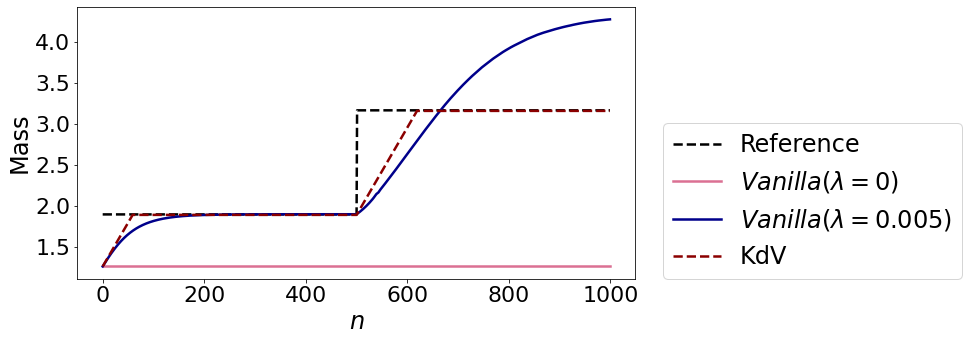

In [18]:


plt.figure(figsize=(10, 5))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_mass_0,
    label=r"$Vanilla(\lambda = 0)$", 
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_mass_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(kdv_opt_mass, label="KdV", linestyle="--", color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Mass", fontsize=label_font)
# plt.yscale('log')
plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Mass Done---")


In [15]:

### Track momentum
vanilla_opt_control_momentum_0, vanilla_kdv_opt_momentum_soln_0, vanilla_results_momentum_0, vanilla_t_list_momentum_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)




Processing time steps:   0%|          | 1/989 [00:02<37:43,  2.29s/it]

*** current time *** 0
optimize time:  2.2897162437438965


Processing time steps:   0%|          | 2/989 [00:03<22:59,  1.40s/it]

*** current time *** 1
optimize time:  0.7691695690155029


Processing time steps:   0%|          | 3/989 [00:03<17:56,  1.09s/it]

*** current time *** 2
optimize time:  0.7252020835876465


Processing time steps:   0%|          | 4/989 [00:04<15:29,  1.06it/s]

*** current time *** 3
optimize time:  0.7162282466888428


Processing time steps:   1%|          | 5/989 [00:05<14:09,  1.16it/s]

*** current time *** 4
optimize time:  0.7178940773010254


Processing time steps:   1%|          | 6/989 [00:05<13:20,  1.23it/s]

*** current time *** 5
optimize time:  0.7167720794677734


Processing time steps:   1%|          | 7/989 [00:06<12:47,  1.28it/s]

*** current time *** 6
optimize time:  0.7115459442138672


Processing time steps:   1%|          | 8/989 [00:07<12:28,  1.31it/s]

*** current time *** 7
optimize time:  0.7210569381713867


Processing time steps:   1%|          | 9/989 [00:08<12:14,  1.33it/s]

*** current time *** 8
optimize time:  0.7188224792480469


Processing time steps:   1%|          | 10/989 [00:08<12:04,  1.35it/s]

*** current time *** 9
optimize time:  0.7158074378967285


Processing time steps:   1%|          | 11/989 [00:09<11:57,  1.36it/s]

*** current time *** 10
optimize time:  0.717944860458374


Processing time steps:   1%|          | 12/989 [00:10<11:56,  1.36it/s]

*** current time *** 11
optimize time:  0.7303781509399414


Processing time steps:   1%|▏         | 13/989 [00:10<11:51,  1.37it/s]

*** current time *** 12
optimize time:  0.7171926498413086


Processing time steps:   1%|▏         | 14/989 [00:11<11:48,  1.38it/s]

*** current time *** 13
optimize time:  0.7180120944976807


Processing time steps:   2%|▏         | 15/989 [00:12<11:45,  1.38it/s]

*** current time *** 14
optimize time:  0.7166106700897217


Processing time steps:   2%|▏         | 16/989 [00:13<11:43,  1.38it/s]

*** current time *** 15
optimize time:  0.7198736667633057


Processing time steps:   2%|▏         | 17/989 [00:13<11:41,  1.39it/s]

*** current time *** 16
optimize time:  0.7145423889160156


Processing time steps:   2%|▏         | 18/989 [00:14<11:44,  1.38it/s]

*** current time *** 17
optimize time:  0.7340517044067383


Processing time steps:   2%|▏         | 19/989 [00:15<11:41,  1.38it/s]

*** current time *** 18
optimize time:  0.7156903743743896


Processing time steps:   2%|▏         | 20/989 [00:16<11:39,  1.38it/s]

*** current time *** 19
optimize time:  0.7175331115722656


Processing time steps:   2%|▏         | 21/989 [00:16<11:38,  1.39it/s]

*** current time *** 20
optimize time:  0.7172281742095947


Processing time steps:   2%|▏         | 22/989 [00:17<11:48,  1.37it/s]

*** current time *** 21
optimize time:  0.755608320236206


Processing time steps:   2%|▏         | 23/989 [00:18<11:52,  1.36it/s]

*** current time *** 22
optimize time:  0.7488019466400146


Processing time steps:   2%|▏         | 24/989 [00:18<11:48,  1.36it/s]

*** current time *** 23
optimize time:  0.7252545356750488


Processing time steps:   3%|▎         | 25/989 [00:19<11:43,  1.37it/s]

*** current time *** 24
optimize time:  0.7174477577209473


Processing time steps:   3%|▎         | 26/989 [00:20<11:42,  1.37it/s]

*** current time *** 25
optimize time:  0.7245476245880127


Processing time steps:   3%|▎         | 27/989 [00:21<11:46,  1.36it/s]

*** current time *** 26
optimize time:  0.7442705631256104


Processing time steps:   3%|▎         | 28/989 [00:21<11:44,  1.36it/s]

*** current time *** 27
optimize time:  0.7266862392425537


Processing time steps:   3%|▎         | 29/989 [00:22<11:48,  1.35it/s]

*** current time *** 28
optimize time:  0.748821496963501


Processing time steps:   3%|▎         | 30/989 [00:23<11:55,  1.34it/s]

*** current time *** 29
optimize time:  0.7610838413238525


Processing time steps:   3%|▎         | 31/989 [00:24<11:46,  1.36it/s]

*** current time *** 30
optimize time:  0.7170379161834717


Processing time steps:   3%|▎         | 32/989 [00:24<11:39,  1.37it/s]

*** current time *** 31
optimize time:  0.7134838104248047


Processing time steps:   3%|▎         | 33/989 [00:25<11:44,  1.36it/s]

*** current time *** 32
optimize time:  0.7494950294494629


Processing time steps:   3%|▎         | 34/989 [00:26<11:53,  1.34it/s]

*** current time *** 33
optimize time:  0.7669346332550049


Processing time steps:   4%|▎         | 35/989 [00:27<11:57,  1.33it/s]

*** current time *** 34
optimize time:  0.7634656429290771


Processing time steps:   4%|▎         | 36/989 [00:27<11:51,  1.34it/s]

*** current time *** 35
optimize time:  0.7288956642150879


Processing time steps:   4%|▎         | 37/989 [00:28<12:00,  1.32it/s]

*** current time *** 36
optimize time:  0.7788534164428711


Processing time steps:   4%|▍         | 38/989 [00:29<12:14,  1.29it/s]

*** current time *** 37
optimize time:  0.8062047958374023


Processing time steps:   4%|▍         | 39/989 [00:30<12:15,  1.29it/s]

*** current time *** 38
optimize time:  0.7747089862823486


Processing time steps:   4%|▍         | 40/989 [00:30<12:00,  1.32it/s]

*** current time *** 39
optimize time:  0.7242310047149658


Processing time steps:   4%|▍         | 41/989 [00:31<12:10,  1.30it/s]

*** current time *** 40
optimize time:  0.7935984134674072


Processing time steps:   4%|▍         | 42/989 [00:32<12:04,  1.31it/s]

*** current time *** 41
optimize time:  0.7507872581481934


Processing time steps:   4%|▍         | 43/989 [00:33<11:49,  1.33it/s]

*** current time *** 42
optimize time:  0.7129747867584229


Processing time steps:   4%|▍         | 44/989 [00:33<11:40,  1.35it/s]

*** current time *** 43
optimize time:  0.7170717716217041


Processing time steps:   5%|▍         | 45/989 [00:34<11:32,  1.36it/s]

*** current time *** 44
optimize time:  0.715322732925415


Processing time steps:   5%|▍         | 46/989 [00:35<11:27,  1.37it/s]

*** current time *** 45
optimize time:  0.7132089138031006


Processing time steps:   5%|▍         | 47/989 [00:36<12:04,  1.30it/s]

*** current time *** 46
optimize time:  0.859715461730957


Processing time steps:   5%|▍         | 48/989 [00:37<12:07,  1.29it/s]

*** current time *** 47
optimize time:  0.7796852588653564


Processing time steps:   5%|▍         | 49/989 [00:37<11:52,  1.32it/s]

*** current time *** 48
optimize time:  0.7189860343933105


Processing time steps:   5%|▌         | 50/989 [00:38<11:42,  1.34it/s]

*** current time *** 49
optimize time:  0.7226138114929199


Processing time steps:   5%|▌         | 51/989 [00:39<11:34,  1.35it/s]

*** current time *** 50
optimize time:  0.7219662666320801


Processing time steps:   5%|▌         | 52/989 [00:39<11:40,  1.34it/s]

*** current time *** 51
optimize time:  0.7605185508728027


Processing time steps:   5%|▌         | 53/989 [00:40<11:43,  1.33it/s]

*** current time *** 52
optimize time:  0.759706974029541


Processing time steps:   5%|▌         | 54/989 [00:41<11:45,  1.33it/s]

*** current time *** 53
optimize time:  0.7585422992706299


Processing time steps:   6%|▌         | 55/989 [00:42<11:47,  1.32it/s]

*** current time *** 54
optimize time:  0.7629320621490479


Processing time steps:   6%|▌         | 56/989 [00:43<11:48,  1.32it/s]

*** current time *** 55
optimize time:  0.7602734565734863


Processing time steps:   6%|▌         | 57/989 [00:43<11:35,  1.34it/s]

*** current time *** 56
optimize time:  0.714484691619873


Processing time steps:   6%|▌         | 58/989 [00:44<12:03,  1.29it/s]

*** current time *** 57
optimize time:  0.8456759452819824


Processing time steps:   6%|▌         | 59/989 [00:45<11:51,  1.31it/s]

*** current time *** 58
optimize time:  0.7348301410675049


Processing time steps:   6%|▌         | 60/989 [00:46<11:38,  1.33it/s]

*** current time *** 59
optimize time:  0.7180256843566895


Processing time steps:   6%|▌         | 61/989 [00:46<11:27,  1.35it/s]

*** current time *** 60
optimize time:  0.7127246856689453


Processing time steps:   6%|▋         | 62/989 [00:47<11:19,  1.36it/s]

*** current time *** 61
optimize time:  0.7138819694519043


Processing time steps:   6%|▋         | 63/989 [00:48<11:19,  1.36it/s]

*** current time *** 62
optimize time:  0.7316789627075195


Processing time steps:   6%|▋         | 64/989 [00:48<11:12,  1.38it/s]

*** current time *** 63
optimize time:  0.7092571258544922


Processing time steps:   7%|▋         | 65/989 [00:49<11:07,  1.38it/s]

*** current time *** 64
optimize time:  0.7100522518157959


Processing time steps:   7%|▋         | 66/989 [00:50<11:03,  1.39it/s]

*** current time *** 65
optimize time:  0.7078824043273926


Processing time steps:   7%|▋         | 67/989 [00:51<11:52,  1.29it/s]

*** current time *** 66
optimize time:  0.8967163562774658


Processing time steps:   7%|▋         | 68/989 [00:51<11:44,  1.31it/s]

*** current time *** 67
optimize time:  0.744574785232544


Processing time steps:   7%|▋         | 69/989 [00:52<11:28,  1.34it/s]

*** current time *** 68
optimize time:  0.7076175212860107


Processing time steps:   7%|▋         | 70/989 [00:53<11:31,  1.33it/s]

*** current time *** 69
optimize time:  0.7608845233917236


Processing time steps:   7%|▋         | 71/989 [00:54<11:35,  1.32it/s]

*** current time *** 70
optimize time:  0.7661466598510742


Processing time steps:   7%|▋         | 72/989 [00:54<11:28,  1.33it/s]

*** current time *** 71
optimize time:  0.7340474128723145


Processing time steps:   7%|▋         | 73/989 [00:55<11:34,  1.32it/s]

*** current time *** 72
optimize time:  0.7730355262756348


Processing time steps:   7%|▋         | 74/989 [00:56<11:37,  1.31it/s]

*** current time *** 73
optimize time:  0.768437385559082


Processing time steps:   8%|▊         | 75/989 [00:57<11:40,  1.31it/s]

*** current time *** 74
optimize time:  0.7718396186828613


Processing time steps:   8%|▊         | 76/989 [00:58<11:41,  1.30it/s]

*** current time *** 75
optimize time:  0.7727630138397217


Processing time steps:   8%|▊         | 77/989 [00:58<11:42,  1.30it/s]

*** current time *** 76
optimize time:  0.7723550796508789


Processing time steps:   8%|▊         | 78/989 [00:59<11:51,  1.28it/s]

*** current time *** 77
optimize time:  0.802527666091919


Processing time steps:   8%|▊         | 79/989 [01:00<11:42,  1.30it/s]

*** current time *** 78
optimize time:  0.7496070861816406


Processing time steps:   8%|▊         | 80/989 [01:01<11:26,  1.32it/s]

*** current time *** 79
optimize time:  0.7140374183654785


Processing time steps:   8%|▊         | 81/989 [01:01<11:27,  1.32it/s]

*** current time *** 80
optimize time:  0.7595617771148682


Processing time steps:   8%|▊         | 82/989 [01:02<11:27,  1.32it/s]

*** current time *** 81
optimize time:  0.7572977542877197


Processing time steps:   8%|▊         | 83/989 [01:03<11:42,  1.29it/s]

*** current time *** 82
optimize time:  0.8135030269622803


Processing time steps:   8%|▊         | 84/989 [01:04<11:45,  1.28it/s]

*** current time *** 83
optimize time:  0.7869508266448975


Processing time steps:   9%|▊         | 85/989 [01:04<11:26,  1.32it/s]

*** current time *** 84
optimize time:  0.7087540626525879


Processing time steps:   9%|▊         | 86/989 [01:05<11:41,  1.29it/s]

*** current time *** 85
optimize time:  0.8155605792999268


Processing time steps:   9%|▉         | 87/989 [01:06<11:38,  1.29it/s]

*** current time *** 86
optimize time:  0.7663111686706543


Processing time steps:   9%|▉         | 88/989 [01:07<11:28,  1.31it/s]

*** current time *** 87
optimize time:  0.7375624179840088


Processing time steps:   9%|▉         | 89/989 [01:08<11:34,  1.30it/s]

*** current time *** 88
optimize time:  0.7887365818023682


Processing time steps:   9%|▉         | 90/989 [01:08<11:17,  1.33it/s]

*** current time *** 89
optimize time:  0.7074484825134277


Processing time steps:   9%|▉         | 91/989 [01:09<11:04,  1.35it/s]

*** current time *** 90
optimize time:  0.7086753845214844


Processing time steps:   9%|▉         | 92/989 [01:10<10:56,  1.37it/s]

*** current time *** 91
optimize time:  0.7102270126342773


Processing time steps:   9%|▉         | 93/989 [01:10<10:51,  1.37it/s]

*** current time *** 92
optimize time:  0.7150287628173828


Processing time steps:  10%|▉         | 94/989 [01:11<10:59,  1.36it/s]

*** current time *** 93
optimize time:  0.7563669681549072


Processing time steps:  10%|▉         | 95/989 [01:12<11:06,  1.34it/s]

*** current time *** 94
optimize time:  0.7630753517150879


Processing time steps:  10%|▉         | 96/989 [01:13<11:10,  1.33it/s]

*** current time *** 95
optimize time:  0.7620193958282471


Processing time steps:  10%|▉         | 97/989 [01:13<11:14,  1.32it/s]

*** current time *** 96
optimize time:  0.7636070251464844


Processing time steps:  10%|▉         | 98/989 [01:14<11:15,  1.32it/s]

*** current time *** 97
optimize time:  0.7605957984924316


Processing time steps:  10%|█         | 99/989 [01:15<11:16,  1.32it/s]

*** current time *** 98
optimize time:  0.7614352703094482


Processing time steps:  10%|█         | 100/989 [01:16<11:16,  1.31it/s]

*** current time *** 99
optimize time:  0.7601892948150635


Processing time steps:  10%|█         | 101/989 [01:17<11:15,  1.31it/s]

*** current time *** 100
optimize time:  0.7578959465026855


Processing time steps:  10%|█         | 102/989 [01:17<11:14,  1.31it/s]

*** current time *** 101
optimize time:  0.7587473392486572


Processing time steps:  10%|█         | 103/989 [01:18<11:14,  1.31it/s]

*** current time *** 102
optimize time:  0.7589893341064453


Processing time steps:  11%|█         | 104/989 [01:19<11:14,  1.31it/s]

*** current time *** 103
optimize time:  0.7615890502929688


Processing time steps:  11%|█         | 105/989 [01:20<11:15,  1.31it/s]

*** current time *** 104
optimize time:  0.767310619354248


Processing time steps:  11%|█         | 106/989 [01:20<11:16,  1.30it/s]

*** current time *** 105
optimize time:  0.7698912620544434


Processing time steps:  11%|█         | 107/989 [01:21<11:07,  1.32it/s]

*** current time *** 106
optimize time:  0.73152756690979


Processing time steps:  11%|█         | 108/989 [01:22<10:57,  1.34it/s]

*** current time *** 107
optimize time:  0.720470666885376


Processing time steps:  11%|█         | 109/989 [01:23<10:49,  1.36it/s]

*** current time *** 108
optimize time:  0.7148013114929199


Processing time steps:  11%|█         | 110/989 [01:23<10:43,  1.37it/s]

*** current time *** 109
optimize time:  0.7160847187042236


Processing time steps:  11%|█         | 111/989 [01:24<10:38,  1.37it/s]

*** current time *** 110
optimize time:  0.7157759666442871


Processing time steps:  11%|█▏        | 112/989 [01:25<10:41,  1.37it/s]

*** current time *** 111
optimize time:  0.7396347522735596


Processing time steps:  11%|█▏        | 113/989 [01:25<10:39,  1.37it/s]

*** current time *** 112
optimize time:  0.7229194641113281


Processing time steps:  12%|█▏        | 114/989 [01:26<10:39,  1.37it/s]

*** current time *** 113
optimize time:  0.7312788963317871


Processing time steps:  12%|█▏        | 115/989 [01:27<10:35,  1.38it/s]

*** current time *** 114
optimize time:  0.7146663665771484


Processing time steps:  12%|█▏        | 116/989 [01:28<10:30,  1.38it/s]

*** current time *** 115
optimize time:  0.7087736129760742


Processing time steps:  12%|█▏        | 117/989 [01:28<10:26,  1.39it/s]

*** current time *** 116
optimize time:  0.7064752578735352


Processing time steps:  12%|█▏        | 118/989 [01:29<10:25,  1.39it/s]

*** current time *** 117
optimize time:  0.713808536529541


Processing time steps:  12%|█▏        | 119/989 [01:30<10:20,  1.40it/s]

*** current time *** 118
optimize time:  0.7002048492431641


Processing time steps:  12%|█▏        | 120/989 [01:30<10:30,  1.38it/s]

*** current time *** 119
optimize time:  0.7502439022064209


Processing time steps:  12%|█▏        | 121/989 [01:31<10:37,  1.36it/s]

*** current time *** 120
optimize time:  0.7526445388793945


Processing time steps:  12%|█▏        | 122/989 [01:32<10:32,  1.37it/s]

*** current time *** 121
optimize time:  0.7154967784881592


Processing time steps:  12%|█▏        | 123/989 [01:33<10:29,  1.38it/s]

*** current time *** 122
optimize time:  0.7174220085144043


Processing time steps:  13%|█▎        | 124/989 [01:33<10:25,  1.38it/s]

*** current time *** 123
optimize time:  0.7140614986419678


Processing time steps:  13%|█▎        | 125/989 [01:34<10:45,  1.34it/s]

*** current time *** 124
optimize time:  0.7982468605041504


Processing time steps:  13%|█▎        | 126/989 [01:35<11:15,  1.28it/s]

*** current time *** 125
optimize time:  0.8627629280090332


Processing time steps:  13%|█▎        | 127/989 [01:36<11:00,  1.30it/s]

*** current time *** 126
optimize time:  0.7275140285491943


Processing time steps:  13%|█▎        | 128/989 [01:37<10:51,  1.32it/s]

*** current time *** 127
optimize time:  0.7312579154968262


Processing time steps:  13%|█▎        | 129/989 [01:37<10:42,  1.34it/s]

*** current time *** 128
optimize time:  0.721524715423584


Processing time steps:  13%|█▎        | 130/989 [01:38<10:47,  1.33it/s]

*** current time *** 129
optimize time:  0.76639723777771


Processing time steps:  13%|█▎        | 131/989 [01:39<11:13,  1.27it/s]

*** current time *** 130
optimize time:  0.8555176258087158


Processing time steps:  13%|█▎        | 132/989 [01:40<11:01,  1.30it/s]

*** current time *** 131
optimize time:  0.7398533821105957


Processing time steps:  13%|█▎        | 133/989 [01:40<10:47,  1.32it/s]

*** current time *** 132
optimize time:  0.7193939685821533


Processing time steps:  14%|█▎        | 134/989 [01:41<10:38,  1.34it/s]

*** current time *** 133
optimize time:  0.7199506759643555


Processing time steps:  14%|█▎        | 135/989 [01:42<10:31,  1.35it/s]

*** current time *** 134
optimize time:  0.7219417095184326


Processing time steps:  14%|█▍        | 136/989 [01:43<10:26,  1.36it/s]

*** current time *** 135
optimize time:  0.7207763195037842


Processing time steps:  14%|█▍        | 137/989 [01:43<10:23,  1.37it/s]

*** current time *** 136
optimize time:  0.7219836711883545


Processing time steps:  14%|█▍        | 138/989 [01:44<10:31,  1.35it/s]

*** current time *** 137
optimize time:  0.764723539352417


Processing time steps:  14%|█▍        | 139/989 [01:45<10:32,  1.34it/s]

*** current time *** 138
optimize time:  0.745481014251709


Processing time steps:  14%|█▍        | 140/989 [01:46<10:38,  1.33it/s]

*** current time *** 139
optimize time:  0.7691230773925781


Processing time steps:  14%|█▍        | 141/989 [01:46<10:45,  1.31it/s]

*** current time *** 140
optimize time:  0.7781510353088379


Processing time steps:  14%|█▍        | 142/989 [01:47<10:48,  1.31it/s]

*** current time *** 141
optimize time:  0.7726898193359375


Processing time steps:  14%|█▍        | 143/989 [01:48<10:48,  1.30it/s]

*** current time *** 142
optimize time:  0.7675304412841797


Processing time steps:  15%|█▍        | 144/989 [01:49<10:37,  1.33it/s]

*** current time *** 143
optimize time:  0.7238681316375732


Processing time steps:  15%|█▍        | 145/989 [01:49<10:35,  1.33it/s]

*** current time *** 144
optimize time:  0.7472095489501953


Processing time steps:  15%|█▍        | 146/989 [01:50<10:38,  1.32it/s]

*** current time *** 145
optimize time:  0.7639422416687012


Processing time steps:  15%|█▍        | 147/989 [01:51<10:47,  1.30it/s]

*** current time *** 146
optimize time:  0.7930605411529541


Processing time steps:  15%|█▍        | 148/989 [01:52<10:37,  1.32it/s]

*** current time *** 147
optimize time:  0.7327132225036621


Processing time steps:  15%|█▌        | 149/989 [01:52<10:29,  1.33it/s]

*** current time *** 148
optimize time:  0.7262542247772217


Processing time steps:  15%|█▌        | 150/989 [01:53<10:24,  1.34it/s]

*** current time *** 149
optimize time:  0.7306277751922607


Processing time steps:  15%|█▌        | 151/989 [01:54<10:24,  1.34it/s]

*** current time *** 150
optimize time:  0.7459650039672852


Processing time steps:  15%|█▌        | 152/989 [01:55<10:59,  1.27it/s]

*** current time *** 151
optimize time:  0.8815455436706543


Processing time steps:  15%|█▌        | 153/989 [01:56<11:01,  1.26it/s]

*** current time *** 152
optimize time:  0.7970571517944336


Processing time steps:  16%|█▌        | 154/989 [01:56<11:05,  1.25it/s]

*** current time *** 153
optimize time:  0.8096370697021484


Processing time steps:  16%|█▌        | 155/989 [01:57<10:50,  1.28it/s]

*** current time *** 154
optimize time:  0.7386856079101562


Processing time steps:  16%|█▌        | 156/989 [01:58<10:40,  1.30it/s]

*** current time *** 155
optimize time:  0.739621639251709


Processing time steps:  16%|█▌        | 157/989 [01:59<10:30,  1.32it/s]

*** current time *** 156
optimize time:  0.7294995784759521


Processing time steps:  16%|█▌        | 158/989 [01:59<10:23,  1.33it/s]

*** current time *** 157
optimize time:  0.729616641998291


Processing time steps:  16%|█▌        | 159/989 [02:00<10:19,  1.34it/s]

*** current time *** 158
optimize time:  0.7358405590057373


Processing time steps:  16%|█▌        | 160/989 [02:01<10:24,  1.33it/s]

*** current time *** 159
optimize time:  0.7684164047241211


Processing time steps:  16%|█▋        | 161/989 [02:02<10:45,  1.28it/s]

*** current time *** 160
optimize time:  0.8362619876861572


Processing time steps:  16%|█▋        | 162/989 [02:02<11:05,  1.24it/s]

*** current time *** 161
optimize time:  0.8610751628875732


Processing time steps:  16%|█▋        | 163/989 [02:03<11:15,  1.22it/s]

*** current time *** 162
optimize time:  0.8473389148712158


Processing time steps:  17%|█▋        | 164/989 [02:04<11:13,  1.23it/s]

*** current time *** 163
optimize time:  0.8079042434692383


Processing time steps:  17%|█▋        | 165/989 [02:05<10:53,  1.26it/s]

*** current time *** 164
optimize time:  0.7359755039215088


Processing time steps:  17%|█▋        | 166/989 [02:06<10:38,  1.29it/s]

*** current time *** 165
optimize time:  0.7357256412506104


Processing time steps:  17%|█▋        | 167/989 [02:06<10:42,  1.28it/s]

*** current time *** 166
optimize time:  0.7907869815826416


Processing time steps:  17%|█▋        | 168/989 [02:07<10:33,  1.30it/s]

*** current time *** 167
optimize time:  0.7452547550201416


Processing time steps:  17%|█▋        | 169/989 [02:08<10:50,  1.26it/s]

*** current time *** 168
optimize time:  0.8431322574615479


Processing time steps:  17%|█▋        | 170/989 [02:09<10:32,  1.29it/s]

*** current time *** 169
optimize time:  0.720949649810791


Processing time steps:  17%|█▋        | 171/989 [02:09<10:19,  1.32it/s]

*** current time *** 170
optimize time:  0.7177205085754395


Processing time steps:  17%|█▋        | 172/989 [02:10<10:13,  1.33it/s]

*** current time *** 171
optimize time:  0.7335104942321777


Processing time steps:  17%|█▋        | 173/989 [02:11<10:05,  1.35it/s]

*** current time *** 172
optimize time:  0.7181222438812256


Processing time steps:  18%|█▊        | 174/989 [02:12<10:00,  1.36it/s]

*** current time *** 173
optimize time:  0.7240142822265625


Processing time steps:  18%|█▊        | 175/989 [02:12<10:09,  1.34it/s]

*** current time *** 174
optimize time:  0.7738378047943115


Processing time steps:  18%|█▊        | 176/989 [02:13<10:03,  1.35it/s]

*** current time *** 175
optimize time:  0.7239766120910645


Processing time steps:  18%|█▊        | 177/989 [02:14<09:59,  1.35it/s]

*** current time *** 176
optimize time:  0.7271897792816162


Processing time steps:  18%|█▊        | 178/989 [02:15<09:55,  1.36it/s]

*** current time *** 177
optimize time:  0.7242324352264404


Processing time steps:  18%|█▊        | 179/989 [02:15<09:52,  1.37it/s]

*** current time *** 178
optimize time:  0.7218794822692871


Processing time steps:  18%|█▊        | 180/989 [02:16<09:52,  1.37it/s]

*** current time *** 179
optimize time:  0.7310171127319336


Processing time steps:  18%|█▊        | 181/989 [02:17<09:50,  1.37it/s]

*** current time *** 180
optimize time:  0.7244369983673096


Processing time steps:  18%|█▊        | 182/989 [02:18<09:52,  1.36it/s]

*** current time *** 181
optimize time:  0.7401864528656006


Processing time steps:  19%|█▊        | 183/989 [02:18<09:58,  1.35it/s]

*** current time *** 182
optimize time:  0.7604870796203613


Processing time steps:  19%|█▊        | 184/989 [02:19<10:02,  1.34it/s]

*** current time *** 183
optimize time:  0.7604176998138428


Processing time steps:  19%|█▊        | 185/989 [02:20<10:03,  1.33it/s]

*** current time *** 184
optimize time:  0.754235029220581


Processing time steps:  19%|█▉        | 186/989 [02:21<09:52,  1.35it/s]

*** current time *** 185
optimize time:  0.7065081596374512


Processing time steps:  19%|█▉        | 187/989 [02:21<09:57,  1.34it/s]

*** current time *** 186
optimize time:  0.756873607635498


Processing time steps:  19%|█▉        | 188/989 [02:22<10:06,  1.32it/s]

*** current time *** 187
optimize time:  0.7833778858184814


Processing time steps:  19%|█▉        | 189/989 [02:23<10:16,  1.30it/s]

*** current time *** 188
optimize time:  0.798011302947998


Processing time steps:  19%|█▉        | 190/989 [02:24<10:14,  1.30it/s]

*** current time *** 189
optimize time:  0.766007661819458


Processing time steps:  19%|█▉        | 191/989 [02:24<10:00,  1.33it/s]

*** current time *** 190
optimize time:  0.7116405963897705


Processing time steps:  19%|█▉        | 192/989 [02:25<09:50,  1.35it/s]

*** current time *** 191
optimize time:  0.7092845439910889


Processing time steps:  20%|█▉        | 193/989 [02:26<09:43,  1.36it/s]

*** current time *** 192
optimize time:  0.714606761932373


Processing time steps:  20%|█▉        | 194/989 [02:26<09:38,  1.37it/s]

*** current time *** 193
optimize time:  0.7119555473327637


Processing time steps:  20%|█▉        | 195/989 [02:27<09:34,  1.38it/s]

*** current time *** 194
optimize time:  0.7102217674255371


Processing time steps:  20%|█▉        | 196/989 [02:28<09:30,  1.39it/s]

*** current time *** 195
optimize time:  0.7087359428405762


Processing time steps:  20%|█▉        | 197/989 [02:29<09:26,  1.40it/s]

*** current time *** 196
optimize time:  0.7056362628936768


Processing time steps:  20%|██        | 198/989 [02:29<09:41,  1.36it/s]

*** current time *** 197
optimize time:  0.778632402420044


Processing time steps:  20%|██        | 199/989 [02:30<09:28,  1.39it/s]

*** current time *** 198
optimize time:  0.6819813251495361


Processing time steps:  20%|██        | 200/989 [02:31<09:38,  1.36it/s]

*** current time *** 199
optimize time:  0.7614827156066895


Processing time steps:  20%|██        | 201/989 [02:32<09:42,  1.35it/s]

*** current time *** 200
optimize time:  0.7493021488189697


Processing time steps:  20%|██        | 202/989 [02:32<10:08,  1.29it/s]

*** current time *** 201
optimize time:  0.853081226348877


Processing time steps:  21%|██        | 203/989 [02:33<10:46,  1.22it/s]

*** current time *** 202
optimize time:  0.9314424991607666


Processing time steps:  21%|██        | 204/989 [02:34<10:32,  1.24it/s]

*** current time *** 203
optimize time:  0.765512228012085


Processing time steps:  21%|██        | 205/989 [02:35<10:21,  1.26it/s]

*** current time *** 204
optimize time:  0.7579090595245361


Processing time steps:  21%|██        | 206/989 [02:36<10:01,  1.30it/s]

*** current time *** 205
optimize time:  0.7082414627075195


Processing time steps:  21%|██        | 207/989 [02:36<09:58,  1.31it/s]

*** current time *** 206
optimize time:  0.7573549747467041


Processing time steps:  21%|██        | 208/989 [02:37<09:48,  1.33it/s]

*** current time *** 207
optimize time:  0.722722053527832


Processing time steps:  21%|██        | 209/989 [02:38<09:44,  1.34it/s]

*** current time *** 208
optimize time:  0.7358577251434326


Processing time steps:  21%|██        | 210/989 [02:39<09:34,  1.36it/s]

*** current time *** 209
optimize time:  0.7090110778808594


Processing time steps:  21%|██▏       | 211/989 [02:39<09:31,  1.36it/s]

*** current time *** 210
optimize time:  0.7252988815307617


Processing time steps:  21%|██▏       | 212/989 [02:40<09:29,  1.36it/s]

*** current time *** 211
optimize time:  0.7254078388214111


Processing time steps:  22%|██▏       | 213/989 [02:41<09:33,  1.35it/s]

*** current time *** 212
optimize time:  0.7526216506958008


Processing time steps:  22%|██▏       | 214/989 [02:41<09:31,  1.36it/s]

*** current time *** 213
optimize time:  0.7313752174377441


Processing time steps:  22%|██▏       | 215/989 [02:42<09:28,  1.36it/s]

*** current time *** 214
optimize time:  0.7243330478668213


Processing time steps:  22%|██▏       | 216/989 [02:43<09:25,  1.37it/s]

*** current time *** 215
optimize time:  0.722836971282959


Processing time steps:  22%|██▏       | 217/989 [02:44<09:24,  1.37it/s]

*** current time *** 216
optimize time:  0.7253437042236328


Processing time steps:  22%|██▏       | 218/989 [02:44<09:33,  1.34it/s]

*** current time *** 217
optimize time:  0.7734813690185547


Processing time steps:  22%|██▏       | 219/989 [02:45<09:36,  1.33it/s]

*** current time *** 218
optimize time:  0.7587435245513916


Processing time steps:  22%|██▏       | 220/989 [02:46<09:31,  1.35it/s]

*** current time *** 219
optimize time:  0.7252013683319092


Processing time steps:  22%|██▏       | 221/989 [02:47<09:28,  1.35it/s]

*** current time *** 220
optimize time:  0.7320804595947266


Processing time steps:  22%|██▏       | 222/989 [02:48<10:09,  1.26it/s]

*** current time *** 221
optimize time:  0.9171257019042969


Processing time steps:  23%|██▎       | 223/989 [02:48<09:54,  1.29it/s]

*** current time *** 222
optimize time:  0.7309694290161133


Processing time steps:  23%|██▎       | 224/989 [02:49<09:36,  1.33it/s]

*** current time *** 223
optimize time:  0.6999406814575195


Processing time steps:  23%|██▎       | 225/989 [02:50<09:24,  1.35it/s]

*** current time *** 224
optimize time:  0.701977014541626


Processing time steps:  23%|██▎       | 226/989 [02:50<09:16,  1.37it/s]

*** current time *** 225
optimize time:  0.7044150829315186


Processing time steps:  23%|██▎       | 227/989 [02:51<09:09,  1.39it/s]

*** current time *** 226
optimize time:  0.6972510814666748


Processing time steps:  23%|██▎       | 228/989 [02:52<09:07,  1.39it/s]

*** current time *** 227
optimize time:  0.7126889228820801


Processing time steps:  23%|██▎       | 229/989 [02:53<09:24,  1.35it/s]

*** current time *** 228
optimize time:  0.7951247692108154


Processing time steps:  23%|██▎       | 230/989 [02:53<09:19,  1.36it/s]

*** current time *** 229
optimize time:  0.7223889827728271


Processing time steps:  23%|██▎       | 231/989 [02:54<09:14,  1.37it/s]

*** current time *** 230
optimize time:  0.7139050960540771


Processing time steps:  23%|██▎       | 232/989 [02:55<09:11,  1.37it/s]

*** current time *** 231
optimize time:  0.7220494747161865


Processing time steps:  24%|██▎       | 233/989 [02:56<09:17,  1.36it/s]

*** current time *** 232
optimize time:  0.7547311782836914


Processing time steps:  24%|██▎       | 234/989 [02:56<09:15,  1.36it/s]

*** current time *** 233
optimize time:  0.72763991355896


Processing time steps:  24%|██▍       | 235/989 [02:57<09:12,  1.36it/s]

*** current time *** 234
optimize time:  0.7262043952941895


Processing time steps:  24%|██▍       | 236/989 [02:58<09:08,  1.37it/s]

*** current time *** 235
optimize time:  0.7165136337280273


Processing time steps:  24%|██▍       | 237/989 [02:59<09:22,  1.34it/s]

*** current time *** 236
optimize time:  0.7893836498260498


Processing time steps:  24%|██▍       | 238/989 [02:59<09:27,  1.32it/s]

*** current time *** 237
optimize time:  0.7709105014801025


Processing time steps:  24%|██▍       | 239/989 [03:00<09:15,  1.35it/s]

*** current time *** 238
optimize time:  0.7027623653411865


Processing time steps:  24%|██▍       | 240/989 [03:01<09:27,  1.32it/s]

*** current time *** 239
optimize time:  0.7949492931365967


Processing time steps:  24%|██▍       | 241/989 [03:02<09:18,  1.34it/s]

*** current time *** 240
optimize time:  0.718787431716919


Processing time steps:  24%|██▍       | 242/989 [03:02<09:34,  1.30it/s]

*** current time *** 241
optimize time:  0.8192024230957031


Processing time steps:  25%|██▍       | 243/989 [03:03<09:45,  1.28it/s]

*** current time *** 242
optimize time:  0.817028284072876


Processing time steps:  25%|██▍       | 244/989 [03:04<09:39,  1.29it/s]

*** current time *** 243
optimize time:  0.7594702243804932


Processing time steps:  25%|██▍       | 245/989 [03:05<09:29,  1.31it/s]

*** current time *** 244
optimize time:  0.7330031394958496


Processing time steps:  25%|██▍       | 246/989 [03:06<09:39,  1.28it/s]

*** current time *** 245
optimize time:  0.814753532409668


Processing time steps:  25%|██▍       | 247/989 [03:06<09:35,  1.29it/s]

*** current time *** 246
optimize time:  0.7594912052154541


Processing time steps:  25%|██▌       | 248/989 [03:07<09:22,  1.32it/s]

*** current time *** 247
optimize time:  0.7190761566162109


Processing time steps:  25%|██▌       | 249/989 [03:08<09:11,  1.34it/s]

*** current time *** 248
optimize time:  0.7085776329040527


Processing time steps:  25%|██▌       | 250/989 [03:08<09:03,  1.36it/s]

*** current time *** 249
optimize time:  0.7113809585571289


Processing time steps:  25%|██▌       | 251/989 [03:09<08:59,  1.37it/s]

*** current time *** 250
optimize time:  0.719275951385498


Processing time steps:  25%|██▌       | 252/989 [03:10<08:56,  1.37it/s]

*** current time *** 251
optimize time:  0.7162871360778809


Processing time steps:  26%|██▌       | 253/989 [03:11<08:54,  1.38it/s]

*** current time *** 252
optimize time:  0.7201111316680908


Processing time steps:  26%|██▌       | 254/989 [03:11<08:59,  1.36it/s]

*** current time *** 253
optimize time:  0.7494196891784668


Processing time steps:  26%|██▌       | 255/989 [03:12<08:52,  1.38it/s]

*** current time *** 254
optimize time:  0.7048144340515137


Processing time steps:  26%|██▌       | 256/989 [03:13<08:51,  1.38it/s]

*** current time *** 255
optimize time:  0.7225983142852783


Processing time steps:  26%|██▌       | 257/989 [03:14<08:58,  1.36it/s]

*** current time *** 256
optimize time:  0.7578921318054199


Processing time steps:  26%|██▌       | 258/989 [03:14<08:59,  1.35it/s]

*** current time *** 257
optimize time:  0.7411038875579834


Processing time steps:  26%|██▌       | 259/989 [03:15<09:29,  1.28it/s]

*** current time *** 258
optimize time:  0.8747117519378662


Processing time steps:  26%|██▋       | 260/989 [03:16<09:18,  1.31it/s]

*** current time *** 259
optimize time:  0.730067253112793


Processing time steps:  26%|██▋       | 261/989 [03:17<09:25,  1.29it/s]

*** current time *** 260
optimize time:  0.8008487224578857


Processing time steps:  26%|██▋       | 262/989 [03:17<09:33,  1.27it/s]

*** current time *** 261
optimize time:  0.8124847412109375


Processing time steps:  27%|██▋       | 263/989 [03:18<09:53,  1.22it/s]

*** current time *** 262
optimize time:  0.8809192180633545


Processing time steps:  27%|██▋       | 264/989 [03:19<09:44,  1.24it/s]

*** current time *** 263
optimize time:  0.7763638496398926


Processing time steps:  27%|██▋       | 265/989 [03:20<09:33,  1.26it/s]

*** current time *** 264
optimize time:  0.7580134868621826


Processing time steps:  27%|██▋       | 266/989 [03:21<09:33,  1.26it/s]

*** current time *** 265
optimize time:  0.7937417030334473


Processing time steps:  27%|██▋       | 267/989 [03:22<09:50,  1.22it/s]

*** current time *** 266
optimize time:  0.8698675632476807


Processing time steps:  27%|██▋       | 268/989 [03:22<09:40,  1.24it/s]

*** current time *** 267
optimize time:  0.776324987411499


Processing time steps:  27%|██▋       | 269/989 [03:23<09:18,  1.29it/s]

*** current time *** 268
optimize time:  0.7019009590148926


Processing time steps:  27%|██▋       | 270/989 [03:24<09:04,  1.32it/s]

*** current time *** 269
optimize time:  0.7102005481719971


Processing time steps:  27%|██▋       | 271/989 [03:24<08:55,  1.34it/s]

*** current time *** 270
optimize time:  0.7180745601654053


Processing time steps:  28%|██▊       | 272/989 [03:25<08:52,  1.35it/s]

*** current time *** 271
optimize time:  0.7333958148956299


Processing time steps:  28%|██▊       | 273/989 [03:26<09:04,  1.31it/s]

*** current time *** 272
optimize time:  0.8007922172546387


Processing time steps:  28%|██▊       | 274/989 [03:27<08:59,  1.33it/s]

*** current time *** 273
optimize time:  0.7352344989776611


Processing time steps:  28%|██▊       | 275/989 [03:27<08:51,  1.34it/s]

*** current time *** 274
optimize time:  0.7170431613922119


Processing time steps:  28%|██▊       | 276/989 [03:28<09:20,  1.27it/s]

*** current time *** 275
optimize time:  0.8815340995788574


Processing time steps:  28%|██▊       | 277/989 [03:29<09:38,  1.23it/s]

*** current time *** 276
optimize time:  0.8710224628448486


Processing time steps:  28%|██▊       | 278/989 [03:30<09:18,  1.27it/s]

*** current time *** 277
optimize time:  0.7224750518798828


Processing time steps:  28%|██▊       | 279/989 [03:31<09:04,  1.30it/s]

*** current time *** 278
optimize time:  0.7220439910888672


Processing time steps:  28%|██▊       | 280/989 [03:31<08:53,  1.33it/s]

*** current time *** 279
optimize time:  0.7165131568908691


Processing time steps:  28%|██▊       | 281/989 [03:32<09:10,  1.29it/s]

*** current time *** 280
optimize time:  0.8316233158111572


Processing time steps:  29%|██▊       | 282/989 [03:33<09:08,  1.29it/s]

*** current time *** 281
optimize time:  0.7711946964263916


Processing time steps:  29%|██▊       | 283/989 [03:34<09:08,  1.29it/s]

*** current time *** 282
optimize time:  0.7738540172576904


Processing time steps:  29%|██▊       | 284/989 [03:35<09:07,  1.29it/s]

*** current time *** 283
optimize time:  0.772965669631958


Processing time steps:  29%|██▉       | 285/989 [03:35<09:06,  1.29it/s]

*** current time *** 284
optimize time:  0.7727737426757812


Processing time steps:  29%|██▉       | 286/989 [03:36<09:05,  1.29it/s]

*** current time *** 285
optimize time:  0.7737338542938232


Processing time steps:  29%|██▉       | 287/989 [03:37<09:04,  1.29it/s]

*** current time *** 286
optimize time:  0.7731978893280029


Processing time steps:  29%|██▉       | 288/989 [03:38<09:03,  1.29it/s]

*** current time *** 287
optimize time:  0.7718431949615479


Processing time steps:  29%|██▉       | 289/989 [03:38<09:03,  1.29it/s]

*** current time *** 288
optimize time:  0.7752079963684082


Processing time steps:  29%|██▉       | 290/989 [03:39<09:03,  1.29it/s]

*** current time *** 289
optimize time:  0.7794797420501709


Processing time steps:  29%|██▉       | 291/989 [03:40<09:03,  1.29it/s]

*** current time *** 290
optimize time:  0.7759842872619629


Processing time steps:  30%|██▉       | 292/989 [03:41<08:57,  1.30it/s]

*** current time *** 291
optimize time:  0.7508211135864258


Processing time steps:  30%|██▉       | 293/989 [03:42<08:57,  1.29it/s]

*** current time *** 292
optimize time:  0.774787187576294


Processing time steps:  30%|██▉       | 294/989 [03:42<09:08,  1.27it/s]

*** current time *** 293
optimize time:  0.8256685733795166


Processing time steps:  30%|██▉       | 295/989 [03:43<09:30,  1.22it/s]

*** current time *** 294
optimize time:  0.8966834545135498


Processing time steps:  30%|██▉       | 296/989 [03:44<09:20,  1.24it/s]

*** current time *** 295
optimize time:  0.7760074138641357


Processing time steps:  30%|███       | 297/989 [03:45<09:41,  1.19it/s]

*** current time *** 296
optimize time:  0.910151481628418


Processing time steps:  30%|███       | 298/989 [03:46<09:18,  1.24it/s]

*** current time *** 297
optimize time:  0.7321441173553467


Processing time steps:  30%|███       | 299/989 [03:46<08:59,  1.28it/s]

*** current time *** 298
optimize time:  0.7184679508209229


Processing time steps:  30%|███       | 300/989 [03:47<08:47,  1.31it/s]

*** current time *** 299
optimize time:  0.7227659225463867


Processing time steps:  30%|███       | 301/989 [03:48<08:41,  1.32it/s]

*** current time *** 300
optimize time:  0.740534782409668


Processing time steps:  31%|███       | 302/989 [03:49<08:34,  1.33it/s]

*** current time *** 301
optimize time:  0.7257158756256104


Processing time steps:  31%|███       | 303/989 [03:49<08:32,  1.34it/s]

*** current time *** 302
optimize time:  0.7386171817779541


Processing time steps:  31%|███       | 304/989 [03:50<08:31,  1.34it/s]

*** current time *** 303
optimize time:  0.7423956394195557


Processing time steps:  31%|███       | 305/989 [03:51<08:40,  1.32it/s]

*** current time *** 304
optimize time:  0.7902073860168457


Processing time steps:  31%|███       | 306/989 [03:52<08:39,  1.31it/s]

*** current time *** 305
optimize time:  0.7593801021575928


Processing time steps:  31%|███       | 307/989 [03:52<08:32,  1.33it/s]

*** current time *** 306
optimize time:  0.724764347076416


Processing time steps:  31%|███       | 308/989 [03:53<08:25,  1.35it/s]

*** current time *** 307
optimize time:  0.7181720733642578


Processing time steps:  31%|███       | 309/989 [03:54<08:16,  1.37it/s]

*** current time *** 308
optimize time:  0.7017936706542969


Processing time steps:  31%|███▏      | 310/989 [03:55<08:12,  1.38it/s]

*** current time *** 309
optimize time:  0.7119412422180176


Processing time steps:  31%|███▏      | 311/989 [03:55<08:10,  1.38it/s]

*** current time *** 310
optimize time:  0.713085412979126


Processing time steps:  32%|███▏      | 312/989 [03:56<08:05,  1.39it/s]

*** current time *** 311
optimize time:  0.7031302452087402


Processing time steps:  32%|███▏      | 313/989 [03:57<08:04,  1.39it/s]

*** current time *** 312
optimize time:  0.7132112979888916


Processing time steps:  32%|███▏      | 314/989 [03:57<08:04,  1.39it/s]

*** current time *** 313
optimize time:  0.7161023616790771


Processing time steps:  32%|███▏      | 315/989 [03:58<08:10,  1.37it/s]

*** current time *** 314
optimize time:  0.749340295791626


Processing time steps:  32%|███▏      | 316/989 [03:59<08:42,  1.29it/s]

*** current time *** 315
optimize time:  0.8863139152526855


Processing time steps:  32%|███▏      | 317/989 [04:00<08:28,  1.32it/s]

*** current time *** 316
optimize time:  0.7073161602020264


Processing time steps:  32%|███▏      | 318/989 [04:00<08:18,  1.35it/s]

*** current time *** 317
optimize time:  0.7085974216461182


Processing time steps:  32%|███▏      | 319/989 [04:01<08:11,  1.36it/s]

*** current time *** 318
optimize time:  0.7090635299682617


Processing time steps:  32%|███▏      | 320/989 [04:02<08:07,  1.37it/s]

*** current time *** 319
optimize time:  0.7146286964416504


Processing time steps:  32%|███▏      | 321/989 [04:03<08:03,  1.38it/s]

*** current time *** 320
optimize time:  0.7091917991638184


Processing time steps:  33%|███▎      | 322/989 [04:03<08:00,  1.39it/s]

*** current time *** 321
optimize time:  0.7124834060668945


Processing time steps:  33%|███▎      | 323/989 [04:04<07:58,  1.39it/s]

*** current time *** 322
optimize time:  0.7135012149810791


Processing time steps:  33%|███▎      | 324/989 [04:05<07:56,  1.40it/s]

*** current time *** 323
optimize time:  0.7079453468322754


Processing time steps:  33%|███▎      | 325/989 [04:05<07:54,  1.40it/s]

*** current time *** 324
optimize time:  0.70880126953125


Processing time steps:  33%|███▎      | 326/989 [04:06<07:52,  1.40it/s]

*** current time *** 325
optimize time:  0.7059626579284668


Processing time steps:  33%|███▎      | 327/989 [04:07<07:50,  1.41it/s]

*** current time *** 326
optimize time:  0.7038817405700684


Processing time steps:  33%|███▎      | 328/989 [04:08<07:48,  1.41it/s]

*** current time *** 327
optimize time:  0.7006464004516602


Processing time steps:  33%|███▎      | 329/989 [04:08<07:47,  1.41it/s]

*** current time *** 328
optimize time:  0.7031538486480713


Processing time steps:  33%|███▎      | 330/989 [04:09<07:49,  1.40it/s]

*** current time *** 329
optimize time:  0.7237241268157959


Processing time steps:  33%|███▎      | 331/989 [04:10<08:15,  1.33it/s]

*** current time *** 330
optimize time:  0.8440151214599609


Processing time steps:  34%|███▎      | 332/989 [04:11<08:16,  1.32it/s]

*** current time *** 331
optimize time:  0.7592837810516357


Processing time steps:  34%|███▎      | 333/989 [04:11<08:16,  1.32it/s]

*** current time *** 332
optimize time:  0.7579684257507324


Processing time steps:  34%|███▍      | 334/989 [04:12<08:16,  1.32it/s]

*** current time *** 333
optimize time:  0.7585930824279785


Processing time steps:  34%|███▍      | 335/989 [04:13<08:04,  1.35it/s]

*** current time *** 334
optimize time:  0.6966679096221924


Processing time steps:  34%|███▍      | 336/989 [04:14<07:57,  1.37it/s]

*** current time *** 335
optimize time:  0.7096316814422607


Processing time steps:  34%|███▍      | 337/989 [04:14<07:53,  1.38it/s]

*** current time *** 336
optimize time:  0.7128162384033203


Processing time steps:  34%|███▍      | 338/989 [04:15<07:50,  1.38it/s]

*** current time *** 337
optimize time:  0.7118246555328369


Processing time steps:  34%|███▍      | 339/989 [04:16<07:48,  1.39it/s]

*** current time *** 338
optimize time:  0.7118380069732666


Processing time steps:  34%|███▍      | 340/989 [04:16<07:45,  1.39it/s]

*** current time *** 339
optimize time:  0.7108044624328613


Processing time steps:  34%|███▍      | 341/989 [04:17<07:45,  1.39it/s]

*** current time *** 340
optimize time:  0.7179553508758545


Processing time steps:  35%|███▍      | 342/989 [04:18<08:15,  1.31it/s]

*** current time *** 341
optimize time:  0.8737690448760986


Processing time steps:  35%|███▍      | 343/989 [04:19<08:17,  1.30it/s]

*** current time *** 342
optimize time:  0.7766227722167969


Processing time steps:  35%|███▍      | 344/989 [04:20<08:17,  1.30it/s]

*** current time *** 343
optimize time:  0.7726247310638428


Processing time steps:  35%|███▍      | 345/989 [04:20<08:18,  1.29it/s]

*** current time *** 344
optimize time:  0.7751445770263672


Processing time steps:  35%|███▍      | 346/989 [04:21<08:18,  1.29it/s]

*** current time *** 345
optimize time:  0.7779488563537598


Processing time steps:  35%|███▌      | 347/989 [04:22<08:19,  1.29it/s]

*** current time *** 346
optimize time:  0.7784273624420166


Processing time steps:  35%|███▌      | 348/989 [04:23<08:14,  1.30it/s]

*** current time *** 347
optimize time:  0.7572507858276367


Processing time steps:  35%|███▌      | 349/989 [04:23<08:11,  1.30it/s]

*** current time *** 348
optimize time:  0.754666805267334


Processing time steps:  35%|███▌      | 350/989 [04:24<08:12,  1.30it/s]

*** current time *** 349
optimize time:  0.7729079723358154


Processing time steps:  35%|███▌      | 351/989 [04:25<08:12,  1.30it/s]

*** current time *** 350
optimize time:  0.7719264030456543


Processing time steps:  36%|███▌      | 352/989 [04:26<08:02,  1.32it/s]

*** current time *** 351
optimize time:  0.7249376773834229


Processing time steps:  36%|███▌      | 353/989 [04:26<08:05,  1.31it/s]

*** current time *** 352
optimize time:  0.7718760967254639


Processing time steps:  36%|███▌      | 354/989 [04:27<08:29,  1.25it/s]

*** current time *** 353
optimize time:  0.8905112743377686


Processing time steps:  36%|███▌      | 355/989 [04:28<08:29,  1.25it/s]

*** current time *** 354
optimize time:  0.8020596504211426


Processing time steps:  36%|███▌      | 356/989 [04:29<08:25,  1.25it/s]

*** current time *** 355
optimize time:  0.7847223281860352


Processing time steps:  36%|███▌      | 357/989 [04:30<08:30,  1.24it/s]

*** current time *** 356
optimize time:  0.8275024890899658


Processing time steps:  36%|███▌      | 358/989 [04:30<08:14,  1.28it/s]

*** current time *** 357
optimize time:  0.7254555225372314


Processing time steps:  36%|███▋      | 359/989 [04:31<08:03,  1.30it/s]

*** current time *** 358
optimize time:  0.7257578372955322


Processing time steps:  36%|███▋      | 360/989 [04:32<07:55,  1.32it/s]

*** current time *** 359
optimize time:  0.727240800857544


Processing time steps:  37%|███▋      | 361/989 [04:33<08:11,  1.28it/s]

*** current time *** 360
optimize time:  0.8448338508605957


Processing time steps:  37%|███▋      | 362/989 [04:34<08:30,  1.23it/s]

*** current time *** 361
optimize time:  0.8842048645019531


Processing time steps:  37%|███▋      | 363/989 [04:35<08:45,  1.19it/s]

*** current time *** 362
optimize time:  0.8953461647033691


Processing time steps:  37%|███▋      | 364/989 [04:35<08:55,  1.17it/s]

*** current time *** 363
optimize time:  0.892385721206665


Processing time steps:  37%|███▋      | 365/989 [04:36<08:32,  1.22it/s]

*** current time *** 364
optimize time:  0.7359342575073242


Processing time steps:  37%|███▋      | 366/989 [04:37<08:42,  1.19it/s]

*** current time *** 365
optimize time:  0.8744759559631348


Processing time steps:  37%|███▋      | 367/989 [04:38<08:36,  1.20it/s]

*** current time *** 366
optimize time:  0.8111956119537354


Processing time steps:  37%|███▋      | 368/989 [04:39<08:13,  1.26it/s]

*** current time *** 367
optimize time:  0.7098479270935059


Processing time steps:  37%|███▋      | 369/989 [04:39<08:14,  1.25it/s]

*** current time *** 368
optimize time:  0.8030486106872559


Processing time steps:  37%|███▋      | 370/989 [04:40<08:55,  1.16it/s]

*** current time *** 369
optimize time:  1.017230749130249


Processing time steps:  38%|███▊      | 371/989 [04:41<08:50,  1.16it/s]

*** current time *** 370
optimize time:  0.8426792621612549


Processing time steps:  38%|███▊      | 372/989 [04:42<08:28,  1.21it/s]

*** current time *** 371
optimize time:  0.7382805347442627


Processing time steps:  38%|███▊      | 373/989 [04:43<08:10,  1.26it/s]

*** current time *** 372
optimize time:  0.729947566986084


Processing time steps:  38%|███▊      | 374/989 [04:43<07:58,  1.29it/s]

*** current time *** 373
optimize time:  0.7329258918762207


Processing time steps:  38%|███▊      | 375/989 [04:44<07:47,  1.31it/s]

*** current time *** 374
optimize time:  0.7199385166168213


Processing time steps:  38%|███▊      | 376/989 [04:45<07:40,  1.33it/s]

*** current time *** 375
optimize time:  0.7219517230987549


Processing time steps:  38%|███▊      | 377/989 [04:46<07:45,  1.31it/s]

*** current time *** 376
optimize time:  0.7816112041473389


Processing time steps:  38%|███▊      | 378/989 [04:47<07:49,  1.30it/s]

*** current time *** 377
optimize time:  0.7832560539245605


Processing time steps:  38%|███▊      | 379/989 [04:47<07:43,  1.32it/s]

*** current time *** 378
optimize time:  0.7361359596252441


Processing time steps:  38%|███▊      | 380/989 [04:48<07:44,  1.31it/s]

*** current time *** 379
optimize time:  0.767888069152832


Processing time steps:  39%|███▊      | 381/989 [04:49<07:45,  1.31it/s]

*** current time *** 380
optimize time:  0.7716860771179199


Processing time steps:  39%|███▊      | 382/989 [04:50<07:46,  1.30it/s]

*** current time *** 381
optimize time:  0.7726564407348633


Processing time steps:  39%|███▊      | 383/989 [04:50<07:37,  1.32it/s]

*** current time *** 382
optimize time:  0.7219021320343018


Processing time steps:  39%|███▉      | 384/989 [04:51<07:26,  1.35it/s]

*** current time *** 383
optimize time:  0.6966965198516846


Processing time steps:  39%|███▉      | 385/989 [04:52<07:27,  1.35it/s]

*** current time *** 384
optimize time:  0.7429180145263672


Processing time steps:  39%|███▉      | 386/989 [04:53<07:42,  1.30it/s]

*** current time *** 385
optimize time:  0.8261857032775879


Processing time steps:  39%|███▉      | 387/989 [04:53<07:43,  1.30it/s]

*** current time *** 386
optimize time:  0.7752442359924316


Processing time steps:  39%|███▉      | 388/989 [04:54<07:44,  1.29it/s]

*** current time *** 387
optimize time:  0.7766437530517578


Processing time steps:  39%|███▉      | 389/989 [04:55<07:42,  1.30it/s]

*** current time *** 388
optimize time:  0.7623071670532227


Processing time steps:  39%|███▉      | 390/989 [04:56<07:38,  1.31it/s]

*** current time *** 389
optimize time:  0.7540555000305176


Processing time steps:  40%|███▉      | 391/989 [04:56<07:29,  1.33it/s]

*** current time *** 390
optimize time:  0.7147502899169922


Processing time steps:  40%|███▉      | 392/989 [04:57<07:22,  1.35it/s]

*** current time *** 391
optimize time:  0.7128453254699707


Processing time steps:  40%|███▉      | 393/989 [04:58<07:16,  1.36it/s]

*** current time *** 392
optimize time:  0.7136385440826416


Processing time steps:  40%|███▉      | 394/989 [04:59<07:12,  1.38it/s]

*** current time *** 393
optimize time:  0.7105660438537598


Processing time steps:  40%|███▉      | 395/989 [04:59<07:12,  1.37it/s]

*** current time *** 394
optimize time:  0.7263495922088623


Processing time steps:  40%|████      | 396/989 [05:00<07:09,  1.38it/s]

*** current time *** 395
optimize time:  0.7115790843963623


Processing time steps:  40%|████      | 397/989 [05:01<07:08,  1.38it/s]

*** current time *** 396
optimize time:  0.7194838523864746


Processing time steps:  40%|████      | 398/989 [05:01<07:06,  1.38it/s]

*** current time *** 397
optimize time:  0.7181768417358398


Processing time steps:  40%|████      | 399/989 [05:02<07:08,  1.38it/s]

*** current time *** 398
optimize time:  0.7301225662231445


Processing time steps:  40%|████      | 400/989 [05:03<07:04,  1.39it/s]

*** current time *** 399
optimize time:  0.7088887691497803


Processing time steps:  41%|████      | 401/989 [05:04<07:04,  1.39it/s]

*** current time *** 400
optimize time:  0.7191286087036133


Processing time steps:  41%|████      | 402/989 [05:04<07:04,  1.38it/s]

*** current time *** 401
optimize time:  0.7214727401733398


Processing time steps:  41%|████      | 403/989 [05:05<07:00,  1.39it/s]

*** current time *** 402
optimize time:  0.7046844959259033


Processing time steps:  41%|████      | 404/989 [05:06<07:02,  1.38it/s]

*** current time *** 403
optimize time:  0.7316110134124756


Processing time steps:  41%|████      | 405/989 [05:07<07:12,  1.35it/s]

*** current time *** 404
optimize time:  0.779285192489624


Processing time steps:  41%|████      | 406/989 [05:07<07:20,  1.32it/s]

*** current time *** 405
optimize time:  0.787102460861206


Processing time steps:  41%|████      | 407/989 [05:08<07:49,  1.24it/s]

*** current time *** 406
optimize time:  0.9219377040863037


Processing time steps:  41%|████▏     | 408/989 [05:09<07:33,  1.28it/s]

*** current time *** 407
optimize time:  0.7168262004852295


Processing time steps:  41%|████▏     | 409/989 [05:10<07:22,  1.31it/s]

*** current time *** 408
optimize time:  0.7181398868560791


Processing time steps:  41%|████▏     | 410/989 [05:10<07:21,  1.31it/s]

*** current time *** 409
optimize time:  0.7597348690032959


Processing time steps:  42%|████▏     | 411/989 [05:11<07:20,  1.31it/s]

*** current time *** 410
optimize time:  0.7591507434844971


Processing time steps:  42%|████▏     | 412/989 [05:12<07:19,  1.31it/s]

*** current time *** 411
optimize time:  0.7561254501342773


Processing time steps:  42%|████▏     | 413/989 [05:13<07:15,  1.32it/s]

*** current time *** 412
optimize time:  0.7444005012512207


Processing time steps:  42%|████▏     | 414/989 [05:13<07:09,  1.34it/s]

*** current time *** 413
optimize time:  0.7213418483734131


Processing time steps:  42%|████▏     | 415/989 [05:14<07:02,  1.36it/s]

*** current time *** 414
optimize time:  0.7074859142303467


Processing time steps:  42%|████▏     | 416/989 [05:15<06:57,  1.37it/s]

*** current time *** 415
optimize time:  0.7105972766876221


Processing time steps:  42%|████▏     | 417/989 [05:16<06:53,  1.38it/s]

*** current time *** 416
optimize time:  0.7094631195068359


Processing time steps:  42%|████▏     | 418/989 [05:16<06:50,  1.39it/s]

*** current time *** 417
optimize time:  0.7087554931640625


Processing time steps:  42%|████▏     | 419/989 [05:17<06:48,  1.39it/s]

*** current time *** 418
optimize time:  0.7102940082550049


Processing time steps:  42%|████▏     | 420/989 [05:18<07:10,  1.32it/s]

*** current time *** 419
optimize time:  0.8471553325653076


Processing time steps:  43%|████▎     | 421/989 [05:19<07:35,  1.25it/s]

*** current time *** 420
optimize time:  0.9050130844116211


Processing time steps:  43%|████▎     | 422/989 [05:20<07:49,  1.21it/s]

*** current time *** 421
optimize time:  0.8835246562957764


Processing time steps:  43%|████▎     | 423/989 [05:20<07:37,  1.24it/s]

*** current time *** 422
optimize time:  0.7598323822021484


Processing time steps:  43%|████▎     | 424/989 [05:21<07:21,  1.28it/s]

*** current time *** 423
optimize time:  0.7163851261138916


Processing time steps:  43%|████▎     | 425/989 [05:22<07:10,  1.31it/s]

*** current time *** 424
optimize time:  0.7209382057189941


Processing time steps:  43%|████▎     | 426/989 [05:23<07:15,  1.29it/s]

*** current time *** 425
optimize time:  0.7945075035095215


Processing time steps:  43%|████▎     | 427/989 [05:23<07:05,  1.32it/s]

*** current time *** 426
optimize time:  0.7172021865844727


Processing time steps:  43%|████▎     | 428/989 [05:24<07:06,  1.32it/s]

*** current time *** 427
optimize time:  0.7629437446594238


Processing time steps:  43%|████▎     | 429/989 [05:25<07:07,  1.31it/s]

*** current time *** 428
optimize time:  0.7724490165710449


Processing time steps:  43%|████▎     | 430/989 [05:26<07:09,  1.30it/s]

*** current time *** 429
optimize time:  0.7724204063415527


Processing time steps:  44%|████▎     | 431/989 [05:26<07:09,  1.30it/s]

*** current time *** 430
optimize time:  0.7751107215881348


Processing time steps:  44%|████▎     | 432/989 [05:27<07:00,  1.32it/s]

*** current time *** 431
optimize time:  0.7103688716888428


Processing time steps:  44%|████▍     | 433/989 [05:28<06:54,  1.34it/s]

*** current time *** 432
optimize time:  0.7192068099975586


Processing time steps:  44%|████▍     | 434/989 [05:29<06:49,  1.36it/s]

*** current time *** 433
optimize time:  0.7169189453125


Processing time steps:  44%|████▍     | 435/989 [05:29<06:45,  1.36it/s]

*** current time *** 434
optimize time:  0.7191402912139893


Processing time steps:  44%|████▍     | 436/989 [05:30<06:42,  1.37it/s]

*** current time *** 435
optimize time:  0.7158162593841553


Processing time steps:  44%|████▍     | 437/989 [05:31<06:40,  1.38it/s]

*** current time *** 436
optimize time:  0.7132036685943604


Processing time steps:  44%|████▍     | 438/989 [05:31<06:37,  1.39it/s]

*** current time *** 437
optimize time:  0.7122461795806885


Processing time steps:  44%|████▍     | 439/989 [05:32<06:38,  1.38it/s]

*** current time *** 438
optimize time:  0.7175414562225342


Processing time steps:  44%|████▍     | 440/989 [05:33<06:36,  1.38it/s]

*** current time *** 439
optimize time:  0.7158710956573486


Processing time steps:  45%|████▍     | 441/989 [05:34<06:36,  1.38it/s]

*** current time *** 440
optimize time:  0.721329927444458


Processing time steps:  45%|████▍     | 442/989 [05:34<06:34,  1.39it/s]

*** current time *** 441
optimize time:  0.7166602611541748


Processing time steps:  45%|████▍     | 443/989 [05:35<06:34,  1.38it/s]

*** current time *** 442
optimize time:  0.7229952812194824


Processing time steps:  45%|████▍     | 444/989 [05:36<06:33,  1.39it/s]

*** current time *** 443
optimize time:  0.7168633937835693


Processing time steps:  45%|████▍     | 445/989 [05:37<06:32,  1.39it/s]

*** current time *** 444
optimize time:  0.7188308238983154


Processing time steps:  45%|████▌     | 446/989 [05:37<06:30,  1.39it/s]

*** current time *** 445
optimize time:  0.7140533924102783


Processing time steps:  45%|████▌     | 447/989 [05:38<06:37,  1.36it/s]

*** current time *** 446
optimize time:  0.7625839710235596


Processing time steps:  45%|████▌     | 448/989 [05:39<06:42,  1.35it/s]

*** current time *** 447
optimize time:  0.7633199691772461


Processing time steps:  45%|████▌     | 449/989 [05:40<06:42,  1.34it/s]

*** current time *** 448
optimize time:  0.750694751739502


Processing time steps:  46%|████▌     | 450/989 [05:40<06:36,  1.36it/s]

*** current time *** 449
optimize time:  0.7107272148132324


Processing time steps:  46%|████▌     | 451/989 [05:41<06:34,  1.36it/s]

*** current time *** 450
optimize time:  0.7236073017120361


Processing time steps:  46%|████▌     | 452/989 [05:42<06:30,  1.38it/s]

*** current time *** 451
optimize time:  0.7104334831237793


Processing time steps:  46%|████▌     | 453/989 [05:42<06:27,  1.38it/s]

*** current time *** 452
optimize time:  0.7125949859619141


Processing time steps:  46%|████▌     | 454/989 [05:43<06:26,  1.38it/s]

*** current time *** 453
optimize time:  0.7175421714782715


Processing time steps:  46%|████▌     | 455/989 [05:44<06:38,  1.34it/s]

*** current time *** 454
optimize time:  0.8008732795715332


Processing time steps:  46%|████▌     | 456/989 [05:45<06:41,  1.33it/s]

*** current time *** 455
optimize time:  0.7683565616607666


Processing time steps:  46%|████▌     | 457/989 [05:45<06:37,  1.34it/s]

*** current time *** 456
optimize time:  0.7305433750152588


Processing time steps:  46%|████▋     | 458/989 [05:46<06:32,  1.35it/s]

*** current time *** 457
optimize time:  0.7198717594146729


Processing time steps:  46%|████▋     | 459/989 [05:47<06:29,  1.36it/s]

*** current time *** 458
optimize time:  0.721013069152832


Processing time steps:  47%|████▋     | 460/989 [05:48<06:27,  1.37it/s]

*** current time *** 459
optimize time:  0.7247657775878906


Processing time steps:  47%|████▋     | 461/989 [05:48<06:25,  1.37it/s]

*** current time *** 460
optimize time:  0.7231893539428711


Processing time steps:  47%|████▋     | 462/989 [05:49<06:23,  1.37it/s]

*** current time *** 461
optimize time:  0.7208962440490723


Processing time steps:  47%|████▋     | 463/989 [05:50<06:24,  1.37it/s]

*** current time *** 462
optimize time:  0.7373936176300049


Processing time steps:  47%|████▋     | 464/989 [05:51<06:48,  1.29it/s]

*** current time *** 463
optimize time:  0.8841714859008789


Processing time steps:  47%|████▋     | 465/989 [05:51<06:36,  1.32it/s]

*** current time *** 464
optimize time:  0.7066609859466553


Processing time steps:  47%|████▋     | 466/989 [05:52<06:29,  1.34it/s]

*** current time *** 465
optimize time:  0.7118954658508301


Processing time steps:  47%|████▋     | 467/989 [05:53<06:31,  1.33it/s]

*** current time *** 466
optimize time:  0.758324384689331


Processing time steps:  47%|████▋     | 468/989 [05:54<06:32,  1.33it/s]

*** current time *** 467
optimize time:  0.7591540813446045


Processing time steps:  47%|████▋     | 469/989 [05:54<06:33,  1.32it/s]

*** current time *** 468
optimize time:  0.7604312896728516


Processing time steps:  48%|████▊     | 470/989 [05:55<06:44,  1.28it/s]

*** current time *** 469
optimize time:  0.830763578414917


Processing time steps:  48%|████▊     | 471/989 [05:56<06:39,  1.30it/s]

*** current time *** 470
optimize time:  0.7513165473937988


Processing time steps:  48%|████▊     | 472/989 [05:57<06:30,  1.32it/s]

*** current time *** 471
optimize time:  0.7168779373168945


Processing time steps:  48%|████▊     | 473/989 [05:57<06:24,  1.34it/s]

*** current time *** 472
optimize time:  0.7176189422607422


Processing time steps:  48%|████▊     | 474/989 [05:58<06:20,  1.35it/s]

*** current time *** 473
optimize time:  0.7203183174133301


Processing time steps:  48%|████▊     | 475/989 [05:59<06:15,  1.37it/s]

*** current time *** 474
optimize time:  0.7122044563293457


Processing time steps:  48%|████▊     | 476/989 [06:00<06:12,  1.38it/s]

*** current time *** 475
optimize time:  0.7123231887817383


Processing time steps:  48%|████▊     | 477/989 [06:00<06:10,  1.38it/s]

*** current time *** 476
optimize time:  0.713843584060669


Processing time steps:  48%|████▊     | 478/989 [06:01<06:07,  1.39it/s]

*** current time *** 477
optimize time:  0.705009937286377


Processing time steps:  48%|████▊     | 479/989 [06:02<06:06,  1.39it/s]

*** current time *** 478
optimize time:  0.7172608375549316


Processing time steps:  49%|████▊     | 480/989 [06:02<06:15,  1.35it/s]

*** current time *** 479
optimize time:  0.7799246311187744


Processing time steps:  49%|████▊     | 481/989 [06:03<06:12,  1.36it/s]

*** current time *** 480
optimize time:  0.7225842475891113


Processing time steps:  49%|████▊     | 482/989 [06:04<06:18,  1.34it/s]

*** current time *** 481
optimize time:  0.7701845169067383


Processing time steps:  49%|████▉     | 483/989 [06:05<06:19,  1.33it/s]

*** current time *** 482
optimize time:  0.75870680809021


Processing time steps:  49%|████▉     | 484/989 [06:05<06:20,  1.33it/s]

*** current time *** 483
optimize time:  0.7563655376434326


Processing time steps:  49%|████▉     | 485/989 [06:06<06:17,  1.33it/s]

*** current time *** 484
optimize time:  0.7386455535888672


Processing time steps:  49%|████▉     | 486/989 [06:07<06:13,  1.35it/s]

*** current time *** 485
optimize time:  0.7264430522918701


Processing time steps:  49%|████▉     | 487/989 [06:08<06:10,  1.35it/s]

*** current time *** 486
optimize time:  0.7256937026977539


Processing time steps:  49%|████▉     | 488/989 [06:08<06:06,  1.37it/s]

*** current time *** 487
optimize time:  0.7149643898010254


Processing time steps:  49%|████▉     | 489/989 [06:09<06:03,  1.38it/s]

*** current time *** 488
optimize time:  0.7124271392822266


Processing time steps:  50%|████▉     | 490/989 [06:10<06:00,  1.38it/s]

*** current time *** 489
optimize time:  0.7120494842529297


Processing time steps:  50%|████▉     | 491/989 [06:11<05:58,  1.39it/s]

*** current time *** 490
optimize time:  0.7105634212493896


Processing time steps:  50%|████▉     | 492/989 [06:11<05:56,  1.39it/s]

*** current time *** 491
optimize time:  0.7119524478912354


Processing time steps:  50%|████▉     | 493/989 [06:12<05:55,  1.40it/s]

*** current time *** 492
optimize time:  0.7112557888031006


Processing time steps:  50%|████▉     | 494/989 [06:13<05:53,  1.40it/s]

*** current time *** 493
optimize time:  0.7030668258666992


Processing time steps:  50%|█████     | 495/989 [06:13<05:51,  1.41it/s]

*** current time *** 494
optimize time:  0.7016134262084961


Processing time steps:  50%|█████     | 496/989 [06:14<05:49,  1.41it/s]

*** current time *** 495
optimize time:  0.7043156623840332


Processing time steps:  50%|█████     | 497/989 [06:15<05:49,  1.41it/s]

*** current time *** 496
optimize time:  0.7109928131103516


Processing time steps:  50%|█████     | 498/989 [06:16<05:52,  1.39it/s]

*** current time *** 497
optimize time:  0.7321853637695312


Processing time steps:  50%|█████     | 499/989 [06:16<05:53,  1.38it/s]

*** current time *** 498
optimize time:  0.7303354740142822


Processing time steps:  51%|█████     | 500/989 [06:17<05:55,  1.38it/s]

*** current time *** 499
optimize time:  0.7355000972747803


Processing time steps:  51%|█████     | 501/989 [06:18<05:57,  1.37it/s]

*** current time *** 500
optimize time:  0.740166425704956


Processing time steps:  51%|█████     | 502/989 [06:19<06:08,  1.32it/s]

*** current time *** 501
optimize time:  0.8111612796783447


Processing time steps:  51%|█████     | 503/989 [06:19<06:10,  1.31it/s]

*** current time *** 502
optimize time:  0.7733755111694336


Processing time steps:  51%|█████     | 504/989 [06:20<06:11,  1.31it/s]

*** current time *** 503
optimize time:  0.7691214084625244


Processing time steps:  51%|█████     | 505/989 [06:21<06:11,  1.30it/s]

*** current time *** 504
optimize time:  0.769606351852417


Processing time steps:  51%|█████     | 506/989 [06:22<06:11,  1.30it/s]

*** current time *** 505
optimize time:  0.7683696746826172


Processing time steps:  51%|█████▏    | 507/989 [06:22<06:10,  1.30it/s]

*** current time *** 506
optimize time:  0.7691953182220459


Processing time steps:  51%|█████▏    | 508/989 [06:23<06:13,  1.29it/s]

*** current time *** 507
optimize time:  0.7874777317047119


Processing time steps:  51%|█████▏    | 509/989 [06:24<06:05,  1.31it/s]

*** current time *** 508
optimize time:  0.7289445400238037


Processing time steps:  52%|█████▏    | 510/989 [06:25<05:58,  1.34it/s]

*** current time *** 509
optimize time:  0.7122368812561035


Processing time steps:  52%|█████▏    | 511/989 [06:25<05:53,  1.35it/s]

*** current time *** 510
optimize time:  0.7197761535644531


Processing time steps:  52%|█████▏    | 512/989 [06:26<05:48,  1.37it/s]

*** current time *** 511
optimize time:  0.7082221508026123


Processing time steps:  52%|█████▏    | 513/989 [06:27<05:54,  1.34it/s]

*** current time *** 512
optimize time:  0.7699334621429443


Processing time steps:  52%|█████▏    | 514/989 [06:28<05:52,  1.35it/s]

*** current time *** 513
optimize time:  0.7362713813781738


Processing time steps:  52%|█████▏    | 515/989 [06:28<05:48,  1.36it/s]

*** current time *** 514
optimize time:  0.7131118774414062


Processing time steps:  52%|█████▏    | 516/989 [06:29<05:45,  1.37it/s]

*** current time *** 515
optimize time:  0.7205564975738525


Processing time steps:  52%|█████▏    | 517/989 [06:30<05:43,  1.37it/s]

*** current time *** 516
optimize time:  0.7167909145355225


Processing time steps:  52%|█████▏    | 518/989 [06:31<05:47,  1.35it/s]

*** current time *** 517
optimize time:  0.7611944675445557


Processing time steps:  52%|█████▏    | 519/989 [06:31<05:50,  1.34it/s]

*** current time *** 518
optimize time:  0.7610108852386475


Processing time steps:  53%|█████▎    | 520/989 [06:32<05:47,  1.35it/s]

*** current time *** 519
optimize time:  0.7240400314331055


Processing time steps:  53%|█████▎    | 521/989 [06:33<05:44,  1.36it/s]

*** current time *** 520
optimize time:  0.7229461669921875


Processing time steps:  53%|█████▎    | 522/989 [06:33<05:40,  1.37it/s]

*** current time *** 521
optimize time:  0.7133841514587402


Processing time steps:  53%|█████▎    | 523/989 [06:34<05:39,  1.37it/s]

*** current time *** 522
optimize time:  0.7199380397796631


Processing time steps:  53%|█████▎    | 524/989 [06:35<05:40,  1.36it/s]

*** current time *** 523
optimize time:  0.7426953315734863


Processing time steps:  53%|█████▎    | 525/989 [06:36<05:52,  1.32it/s]

*** current time *** 524
optimize time:  0.8183925151824951


Processing time steps:  53%|█████▎    | 526/989 [06:36<05:46,  1.34it/s]

*** current time *** 525
optimize time:  0.7172536849975586


Processing time steps:  53%|█████▎    | 527/989 [06:37<05:41,  1.35it/s]

*** current time *** 526
optimize time:  0.7135398387908936


Processing time steps:  53%|█████▎    | 528/989 [06:38<05:37,  1.37it/s]

*** current time *** 527
optimize time:  0.716139554977417


Processing time steps:  53%|█████▎    | 529/989 [06:39<05:34,  1.37it/s]

*** current time *** 528
optimize time:  0.7153425216674805


Processing time steps:  54%|█████▎    | 530/989 [06:39<05:32,  1.38it/s]

*** current time *** 529
optimize time:  0.7122259140014648


Processing time steps:  54%|█████▎    | 531/989 [06:40<05:31,  1.38it/s]

*** current time *** 530
optimize time:  0.7178962230682373


Processing time steps:  54%|█████▍    | 532/989 [06:41<05:29,  1.39it/s]

*** current time *** 531
optimize time:  0.715914249420166


Processing time steps:  54%|█████▍    | 533/989 [06:42<05:49,  1.31it/s]

*** current time *** 532
optimize time:  0.864617109298706


Processing time steps:  54%|█████▍    | 534/989 [06:42<05:47,  1.31it/s]

*** current time *** 533
optimize time:  0.7581503391265869


Processing time steps:  54%|█████▍    | 535/989 [06:43<05:41,  1.33it/s]

*** current time *** 534
optimize time:  0.7217130661010742


Processing time steps:  54%|█████▍    | 536/989 [06:44<05:54,  1.28it/s]

*** current time *** 535
optimize time:  0.8528978824615479


Processing time steps:  54%|█████▍    | 537/989 [06:45<05:45,  1.31it/s]

*** current time *** 536
optimize time:  0.7153711318969727


Processing time steps:  54%|█████▍    | 538/989 [06:45<05:40,  1.33it/s]

*** current time *** 537
optimize time:  0.7309486865997314


Processing time steps:  54%|█████▍    | 539/989 [06:46<05:35,  1.34it/s]

*** current time *** 538
optimize time:  0.7210760116577148


Processing time steps:  55%|█████▍    | 540/989 [06:47<05:31,  1.35it/s]

*** current time *** 539
optimize time:  0.7193913459777832


Processing time steps:  55%|█████▍    | 541/989 [06:48<05:28,  1.36it/s]

*** current time *** 540
optimize time:  0.7207062244415283


Processing time steps:  55%|█████▍    | 542/989 [06:48<05:32,  1.35it/s]

*** current time *** 541
optimize time:  0.7625687122344971


Processing time steps:  55%|█████▍    | 543/989 [06:49<05:33,  1.34it/s]

*** current time *** 542
optimize time:  0.7522954940795898


Processing time steps:  55%|█████▌    | 544/989 [06:50<05:53,  1.26it/s]

*** current time *** 543
optimize time:  0.9047892093658447


Processing time steps:  55%|█████▌    | 545/989 [06:51<06:08,  1.21it/s]

*** current time *** 544
optimize time:  0.9069981575012207


Processing time steps:  55%|█████▌    | 546/989 [06:52<06:07,  1.21it/s]

*** current time *** 545
optimize time:  0.8270347118377686


Processing time steps:  55%|█████▌    | 547/989 [06:53<06:10,  1.19it/s]

*** current time *** 546
optimize time:  0.8573317527770996


Processing time steps:  55%|█████▌    | 548/989 [06:53<05:59,  1.23it/s]

*** current time *** 547
optimize time:  0.7595705986022949


Processing time steps:  56%|█████▌    | 549/989 [06:54<05:51,  1.25it/s]

*** current time *** 548
optimize time:  0.7566747665405273


Processing time steps:  56%|█████▌    | 550/989 [06:55<05:39,  1.29it/s]

*** current time *** 549
optimize time:  0.7139205932617188


Processing time steps:  56%|█████▌    | 551/989 [06:56<05:36,  1.30it/s]

*** current time *** 550
optimize time:  0.7513225078582764


Processing time steps:  56%|█████▌    | 552/989 [06:56<05:29,  1.33it/s]

*** current time *** 551
optimize time:  0.7153818607330322


Processing time steps:  56%|█████▌    | 553/989 [06:57<05:23,  1.35it/s]

*** current time *** 552
optimize time:  0.711698055267334


Processing time steps:  56%|█████▌    | 554/989 [06:58<05:24,  1.34it/s]

*** current time *** 553
optimize time:  0.7509171962738037


Processing time steps:  56%|█████▌    | 555/989 [06:59<05:25,  1.33it/s]

*** current time *** 554
optimize time:  0.7605502605438232


Processing time steps:  56%|█████▌    | 556/989 [06:59<05:29,  1.32it/s]

*** current time *** 555
optimize time:  0.7802574634552002


Processing time steps:  56%|█████▋    | 557/989 [07:00<05:27,  1.32it/s]

*** current time *** 556
optimize time:  0.7505056858062744


Processing time steps:  56%|█████▋    | 558/989 [07:01<05:24,  1.33it/s]

*** current time *** 557
optimize time:  0.7374024391174316


Processing time steps:  57%|█████▋    | 559/989 [07:02<05:19,  1.34it/s]

*** current time *** 558
optimize time:  0.7212710380554199


Processing time steps:  57%|█████▋    | 560/989 [07:02<05:18,  1.35it/s]

*** current time *** 559
optimize time:  0.7392101287841797


Processing time steps:  57%|█████▋    | 561/989 [07:03<05:24,  1.32it/s]

*** current time *** 560
optimize time:  0.7913014888763428


Processing time steps:  57%|█████▋    | 562/989 [07:04<05:31,  1.29it/s]

*** current time *** 561
optimize time:  0.8161871433258057


Processing time steps:  57%|█████▋    | 563/989 [07:05<05:33,  1.28it/s]

*** current time *** 562
optimize time:  0.7988097667694092


Processing time steps:  57%|█████▋    | 564/989 [07:06<05:36,  1.26it/s]

*** current time *** 563
optimize time:  0.8065576553344727


Processing time steps:  57%|█████▋    | 565/989 [07:06<05:31,  1.28it/s]

*** current time *** 564
optimize time:  0.7547152042388916


Processing time steps:  57%|█████▋    | 566/989 [07:07<05:28,  1.29it/s]

*** current time *** 565
optimize time:  0.7620816230773926


Processing time steps:  57%|█████▋    | 567/989 [07:08<05:38,  1.25it/s]

*** current time *** 566
optimize time:  0.8568515777587891


Processing time steps:  57%|█████▋    | 568/989 [07:09<05:40,  1.23it/s]

*** current time *** 567
optimize time:  0.8282558917999268


Processing time steps:  58%|█████▊    | 569/989 [07:10<05:37,  1.24it/s]

*** current time *** 568
optimize time:  0.7886021137237549


Processing time steps:  58%|█████▊    | 570/989 [07:10<05:26,  1.28it/s]

*** current time *** 569
optimize time:  0.715984582901001


Processing time steps:  58%|█████▊    | 571/989 [07:11<05:37,  1.24it/s]

*** current time *** 570
optimize time:  0.8702926635742188


Processing time steps:  58%|█████▊    | 572/989 [07:12<05:42,  1.22it/s]

*** current time *** 571
optimize time:  0.8549652099609375


Processing time steps:  58%|█████▊    | 573/989 [07:13<05:39,  1.22it/s]

*** current time *** 572
optimize time:  0.8021464347839355


Processing time steps:  58%|█████▊    | 574/989 [07:14<05:34,  1.24it/s]

*** current time *** 573
optimize time:  0.7807776927947998


Processing time steps:  58%|█████▊    | 575/989 [07:14<05:30,  1.25it/s]

*** current time *** 574
optimize time:  0.7746400833129883


Processing time steps:  58%|█████▊    | 576/989 [07:15<05:22,  1.28it/s]

*** current time *** 575
optimize time:  0.7384638786315918


Processing time steps:  58%|█████▊    | 577/989 [07:16<05:15,  1.31it/s]

*** current time *** 576
optimize time:  0.7259998321533203


Processing time steps:  58%|█████▊    | 578/989 [07:17<05:10,  1.32it/s]

*** current time *** 577
optimize time:  0.7321932315826416


Processing time steps:  59%|█████▊    | 579/989 [07:17<05:05,  1.34it/s]

*** current time *** 578
optimize time:  0.7220573425292969


Processing time steps:  59%|█████▊    | 580/989 [07:18<05:02,  1.35it/s]

*** current time *** 579
optimize time:  0.7183730602264404


Processing time steps:  59%|█████▊    | 581/989 [07:19<04:59,  1.36it/s]

*** current time *** 580
optimize time:  0.7194170951843262


Processing time steps:  59%|█████▉    | 582/989 [07:19<04:58,  1.36it/s]

*** current time *** 581
optimize time:  0.7293081283569336


Processing time steps:  59%|█████▉    | 583/989 [07:20<04:55,  1.37it/s]

*** current time *** 582
optimize time:  0.7148938179016113


Processing time steps:  59%|█████▉    | 584/989 [07:21<04:58,  1.36it/s]

*** current time *** 583
optimize time:  0.7585868835449219


Processing time steps:  59%|█████▉    | 585/989 [07:22<05:03,  1.33it/s]

*** current time *** 584
optimize time:  0.778468132019043


Processing time steps:  59%|█████▉    | 586/989 [07:23<05:06,  1.31it/s]

*** current time *** 585
optimize time:  0.7819688320159912


Processing time steps:  59%|█████▉    | 587/989 [07:23<05:08,  1.30it/s]

*** current time *** 586
optimize time:  0.7799344062805176


Processing time steps:  59%|█████▉    | 588/989 [07:24<05:07,  1.30it/s]

*** current time *** 587
optimize time:  0.7667708396911621


Processing time steps:  60%|█████▉    | 589/989 [07:25<05:06,  1.30it/s]

*** current time *** 588
optimize time:  0.7603528499603271


Processing time steps:  60%|█████▉    | 590/989 [07:26<05:04,  1.31it/s]

*** current time *** 589
optimize time:  0.7531211376190186


Processing time steps:  60%|█████▉    | 591/989 [07:26<05:00,  1.33it/s]

*** current time *** 590
optimize time:  0.7322258949279785


Processing time steps:  60%|█████▉    | 592/989 [07:27<05:11,  1.27it/s]

*** current time *** 591
optimize time:  0.8534886837005615


Processing time steps:  60%|█████▉    | 593/989 [07:28<05:08,  1.28it/s]

*** current time *** 592
optimize time:  0.764859676361084


Processing time steps:  60%|██████    | 594/989 [07:29<05:05,  1.29it/s]

*** current time *** 593
optimize time:  0.7596139907836914


Processing time steps:  60%|██████    | 595/989 [07:29<05:04,  1.30it/s]

*** current time *** 594
optimize time:  0.7646303176879883


Processing time steps:  60%|██████    | 596/989 [07:30<05:00,  1.31it/s]

*** current time *** 595
optimize time:  0.7412259578704834


Processing time steps:  60%|██████    | 597/989 [07:31<04:53,  1.33it/s]

*** current time *** 596
optimize time:  0.7148473262786865


Processing time steps:  60%|██████    | 598/989 [07:32<04:49,  1.35it/s]

*** current time *** 597
optimize time:  0.713245153427124


Processing time steps:  61%|██████    | 599/989 [07:32<04:45,  1.37it/s]

*** current time *** 598
optimize time:  0.712780237197876


Processing time steps:  61%|██████    | 600/989 [07:33<04:42,  1.38it/s]

*** current time *** 599
optimize time:  0.7094917297363281


Processing time steps:  61%|██████    | 601/989 [07:34<04:40,  1.38it/s]

*** current time *** 600
optimize time:  0.7147212028503418


Processing time steps:  61%|██████    | 602/989 [07:34<04:37,  1.39it/s]

*** current time *** 601
optimize time:  0.7031030654907227


Processing time steps:  61%|██████    | 603/989 [07:35<04:36,  1.40it/s]

*** current time *** 602
optimize time:  0.7083346843719482


Processing time steps:  61%|██████    | 604/989 [07:36<04:36,  1.39it/s]

*** current time *** 603
optimize time:  0.7184345722198486


Processing time steps:  61%|██████    | 605/989 [07:37<04:36,  1.39it/s]

*** current time *** 604
optimize time:  0.7249934673309326


Processing time steps:  61%|██████▏   | 606/989 [07:37<04:35,  1.39it/s]

*** current time *** 605
optimize time:  0.7108724117279053


Processing time steps:  61%|██████▏   | 607/989 [07:38<04:33,  1.40it/s]

*** current time *** 606
optimize time:  0.7090849876403809


Processing time steps:  61%|██████▏   | 608/989 [07:39<04:31,  1.40it/s]

*** current time *** 607
optimize time:  0.7036459445953369


Processing time steps:  62%|██████▏   | 609/989 [07:40<04:38,  1.36it/s]

*** current time *** 608
optimize time:  0.7764720916748047


Processing time steps:  62%|██████▏   | 610/989 [07:40<04:41,  1.35it/s]

*** current time *** 609
optimize time:  0.762864351272583


Processing time steps:  62%|██████▏   | 611/989 [07:41<04:42,  1.34it/s]

*** current time *** 610
optimize time:  0.7536852359771729


Processing time steps:  62%|██████▏   | 612/989 [07:42<04:41,  1.34it/s]

*** current time *** 611
optimize time:  0.7458949089050293


Processing time steps:  62%|██████▏   | 613/989 [07:43<04:44,  1.32it/s]

*** current time *** 612
optimize time:  0.7800314426422119


Processing time steps:  62%|██████▏   | 614/989 [07:43<04:46,  1.31it/s]

*** current time *** 613
optimize time:  0.7770202159881592


Processing time steps:  62%|██████▏   | 615/989 [07:44<04:43,  1.32it/s]

*** current time *** 614
optimize time:  0.7417852878570557


Processing time steps:  62%|██████▏   | 616/989 [07:45<04:39,  1.33it/s]

*** current time *** 615
optimize time:  0.7277359962463379


Processing time steps:  62%|██████▏   | 617/989 [07:46<04:35,  1.35it/s]

*** current time *** 616
optimize time:  0.7152178287506104


Processing time steps:  62%|██████▏   | 618/989 [07:46<04:32,  1.36it/s]

*** current time *** 617
optimize time:  0.7182464599609375


Processing time steps:  63%|██████▎   | 619/989 [07:47<04:29,  1.37it/s]

*** current time *** 618
optimize time:  0.7145662307739258


Processing time steps:  63%|██████▎   | 620/989 [07:48<04:27,  1.38it/s]

*** current time *** 619
optimize time:  0.7139160633087158


Processing time steps:  63%|██████▎   | 621/989 [07:48<04:25,  1.38it/s]

*** current time *** 620
optimize time:  0.7133991718292236


Processing time steps:  63%|██████▎   | 622/989 [07:49<04:24,  1.39it/s]

*** current time *** 621
optimize time:  0.7118008136749268


Processing time steps:  63%|██████▎   | 623/989 [07:50<04:26,  1.38it/s]

*** current time *** 622
optimize time:  0.7423410415649414


Processing time steps:  63%|██████▎   | 624/989 [07:51<04:26,  1.37it/s]

*** current time *** 623
optimize time:  0.7335121631622314


Processing time steps:  63%|██████▎   | 625/989 [07:51<04:25,  1.37it/s]

*** current time *** 624
optimize time:  0.7254786491394043


Processing time steps:  63%|██████▎   | 626/989 [07:52<04:25,  1.37it/s]

*** current time *** 625
optimize time:  0.7320077419281006


Processing time steps:  63%|██████▎   | 627/989 [07:53<04:24,  1.37it/s]

*** current time *** 626
optimize time:  0.7302737236022949


Processing time steps:  63%|██████▎   | 628/989 [07:54<04:23,  1.37it/s]

*** current time *** 627
optimize time:  0.7248697280883789


Processing time steps:  64%|██████▎   | 629/989 [07:54<04:22,  1.37it/s]

*** current time *** 628
optimize time:  0.7257966995239258


Processing time steps:  64%|██████▎   | 630/989 [07:55<04:30,  1.33it/s]

*** current time *** 629
optimize time:  0.8034923076629639


Processing time steps:  64%|██████▍   | 631/989 [07:56<04:42,  1.27it/s]

*** current time *** 630
optimize time:  0.8704793453216553


Processing time steps:  64%|██████▍   | 632/989 [07:57<04:50,  1.23it/s]

*** current time *** 631
optimize time:  0.8663504123687744


Processing time steps:  64%|██████▍   | 633/989 [07:58<04:37,  1.28it/s]

*** current time *** 632
optimize time:  0.701685905456543


Processing time steps:  64%|██████▍   | 634/989 [07:58<04:29,  1.32it/s]

*** current time *** 633
optimize time:  0.7042510509490967


Processing time steps:  64%|██████▍   | 635/989 [07:59<04:23,  1.34it/s]

*** current time *** 634
optimize time:  0.7111423015594482


Processing time steps:  64%|██████▍   | 636/989 [08:00<04:20,  1.35it/s]

*** current time *** 635
optimize time:  0.7221753597259521


Processing time steps:  64%|██████▍   | 637/989 [08:00<04:16,  1.37it/s]

*** current time *** 636
optimize time:  0.700049638748169


Processing time steps:  65%|██████▍   | 638/989 [08:01<04:14,  1.38it/s]

*** current time *** 637
optimize time:  0.7181098461151123


Processing time steps:  65%|██████▍   | 639/989 [08:02<04:13,  1.38it/s]

*** current time *** 638
optimize time:  0.7210488319396973


Processing time steps:  65%|██████▍   | 640/989 [08:03<04:11,  1.39it/s]

*** current time *** 639
optimize time:  0.7060651779174805


Processing time steps:  65%|██████▍   | 641/989 [08:03<04:24,  1.31it/s]

*** current time *** 640
optimize time:  0.8550522327423096


Processing time steps:  65%|██████▍   | 642/989 [08:04<04:23,  1.31it/s]

*** current time *** 641
optimize time:  0.7555036544799805


Processing time steps:  65%|██████▌   | 643/989 [08:05<04:20,  1.33it/s]

*** current time *** 642
optimize time:  0.7369604110717773


Processing time steps:  65%|██████▌   | 644/989 [08:06<04:17,  1.34it/s]

*** current time *** 643
optimize time:  0.7252678871154785


Processing time steps:  65%|██████▌   | 645/989 [08:06<04:13,  1.36it/s]

*** current time *** 644
optimize time:  0.7127871513366699


Processing time steps:  65%|██████▌   | 646/989 [08:07<04:11,  1.36it/s]

*** current time *** 645
optimize time:  0.7235522270202637


Processing time steps:  65%|██████▌   | 647/989 [08:08<04:09,  1.37it/s]

*** current time *** 646
optimize time:  0.7123725414276123


Processing time steps:  66%|██████▌   | 648/989 [08:09<04:07,  1.38it/s]

*** current time *** 647
optimize time:  0.7181015014648438


Processing time steps:  66%|██████▌   | 649/989 [08:09<04:06,  1.38it/s]

*** current time *** 648
optimize time:  0.7182927131652832


Processing time steps:  66%|██████▌   | 650/989 [08:10<04:10,  1.35it/s]

*** current time *** 649
optimize time:  0.7735116481781006


Processing time steps:  66%|██████▌   | 651/989 [08:11<04:10,  1.35it/s]

*** current time *** 650
optimize time:  0.7406837940216064


Processing time steps:  66%|██████▌   | 652/989 [08:11<04:06,  1.37it/s]

*** current time *** 651
optimize time:  0.7102079391479492


Processing time steps:  66%|██████▌   | 653/989 [08:12<04:04,  1.37it/s]

*** current time *** 652
optimize time:  0.7180705070495605


Processing time steps:  66%|██████▌   | 654/989 [08:13<04:05,  1.37it/s]

*** current time *** 653
optimize time:  0.7346341609954834


Processing time steps:  66%|██████▌   | 655/989 [08:14<04:11,  1.33it/s]

*** current time *** 654
optimize time:  0.7979581356048584


Processing time steps:  66%|██████▋   | 656/989 [08:14<04:10,  1.33it/s]

*** current time *** 655
optimize time:  0.7486283779144287


Processing time steps:  66%|██████▋   | 657/989 [08:15<04:06,  1.35it/s]

*** current time *** 656
optimize time:  0.7206161022186279


Processing time steps:  67%|██████▋   | 658/989 [08:16<04:09,  1.33it/s]

*** current time *** 657
optimize time:  0.7704281806945801


Processing time steps:  67%|██████▋   | 659/989 [08:17<04:19,  1.27it/s]

*** current time *** 658
optimize time:  0.8651151657104492


Processing time steps:  67%|██████▋   | 660/989 [08:18<04:35,  1.19it/s]

*** current time *** 659
optimize time:  0.9509613513946533


Processing time steps:  67%|██████▋   | 661/989 [08:19<04:32,  1.20it/s]

*** current time *** 660
optimize time:  0.8100969791412354


Processing time steps:  67%|██████▋   | 662/989 [08:19<04:32,  1.20it/s]

*** current time *** 661
optimize time:  0.8412010669708252


Processing time steps:  67%|██████▋   | 663/989 [08:20<04:23,  1.24it/s]

*** current time *** 662
optimize time:  0.7303378582000732


Processing time steps:  67%|██████▋   | 664/989 [08:21<04:19,  1.25it/s]

*** current time *** 663
optimize time:  0.7706255912780762


Processing time steps:  67%|██████▋   | 665/989 [08:22<04:16,  1.26it/s]

*** current time *** 664
optimize time:  0.7757303714752197


Processing time steps:  67%|██████▋   | 666/989 [08:23<04:15,  1.26it/s]

*** current time *** 665
optimize time:  0.7895750999450684


Processing time steps:  67%|██████▋   | 667/989 [08:23<04:18,  1.25it/s]

*** current time *** 666
optimize time:  0.8213577270507812


Processing time steps:  68%|██████▊   | 668/989 [08:24<04:15,  1.26it/s]

*** current time *** 667
optimize time:  0.7807619571685791


Processing time steps:  68%|██████▊   | 669/989 [08:25<04:12,  1.27it/s]

*** current time *** 668
optimize time:  0.7681460380554199


Processing time steps:  68%|██████▊   | 670/989 [08:26<04:08,  1.28it/s]

*** current time *** 669
optimize time:  0.7546951770782471


Processing time steps:  68%|██████▊   | 671/989 [08:26<04:06,  1.29it/s]

*** current time *** 670
optimize time:  0.7643392086029053


Processing time steps:  68%|██████▊   | 672/989 [08:27<04:00,  1.32it/s]

*** current time *** 671
optimize time:  0.7189774513244629


Processing time steps:  68%|██████▊   | 673/989 [08:28<04:00,  1.31it/s]

*** current time *** 672
optimize time:  0.7628412246704102


Processing time steps:  68%|██████▊   | 674/989 [08:29<04:00,  1.31it/s]

*** current time *** 673
optimize time:  0.7621335983276367


Processing time steps:  68%|██████▊   | 675/989 [08:29<03:59,  1.31it/s]

*** current time *** 674
optimize time:  0.7609806060791016


Processing time steps:  68%|██████▊   | 676/989 [08:30<03:58,  1.31it/s]

*** current time *** 675
optimize time:  0.7626862525939941


Processing time steps:  68%|██████▊   | 677/989 [08:31<03:58,  1.31it/s]

*** current time *** 676
optimize time:  0.7605316638946533


Processing time steps:  69%|██████▊   | 678/989 [08:32<03:52,  1.34it/s]

*** current time *** 677
optimize time:  0.7121479511260986


Processing time steps:  69%|██████▊   | 679/989 [08:32<03:54,  1.32it/s]

*** current time *** 678
optimize time:  0.7733030319213867


Processing time steps:  69%|██████▉   | 680/989 [08:33<03:48,  1.35it/s]

*** current time *** 679
optimize time:  0.6931378841400146


Processing time steps:  69%|██████▉   | 681/989 [08:34<03:51,  1.33it/s]

*** current time *** 680
optimize time:  0.7736835479736328


Processing time steps:  69%|██████▉   | 682/989 [08:35<03:54,  1.31it/s]

*** current time *** 681
optimize time:  0.7938838005065918


Processing time steps:  69%|██████▉   | 683/989 [08:36<03:54,  1.30it/s]

*** current time *** 682
optimize time:  0.7748360633850098


Processing time steps:  69%|██████▉   | 684/989 [08:36<04:01,  1.27it/s]

*** current time *** 683
optimize time:  0.8409926891326904


Processing time steps:  69%|██████▉   | 685/989 [08:37<03:54,  1.29it/s]

*** current time *** 684
optimize time:  0.7288267612457275


Processing time steps:  69%|██████▉   | 686/989 [08:38<03:49,  1.32it/s]

*** current time *** 685
optimize time:  0.7231771945953369


Processing time steps:  69%|██████▉   | 687/989 [08:39<03:45,  1.34it/s]

*** current time *** 686
optimize time:  0.7197091579437256


Processing time steps:  70%|██████▉   | 688/989 [08:39<03:43,  1.35it/s]

*** current time *** 687
optimize time:  0.7239282131195068


Processing time steps:  70%|██████▉   | 689/989 [08:40<03:40,  1.36it/s]

*** current time *** 688
optimize time:  0.7200186252593994


Processing time steps:  70%|██████▉   | 690/989 [08:41<03:38,  1.37it/s]

*** current time *** 689
optimize time:  0.720247745513916


Processing time steps:  70%|██████▉   | 691/989 [08:41<03:38,  1.36it/s]

*** current time *** 690
optimize time:  0.7386486530303955


Processing time steps:  70%|██████▉   | 692/989 [08:42<03:36,  1.37it/s]

*** current time *** 691
optimize time:  0.7177579402923584


Processing time steps:  70%|███████   | 693/989 [08:43<03:54,  1.26it/s]

*** current time *** 692
optimize time:  0.9381775856018066


Processing time steps:  70%|███████   | 694/989 [08:44<03:50,  1.28it/s]

*** current time *** 693
optimize time:  0.7531094551086426


Processing time steps:  70%|███████   | 695/989 [08:45<03:46,  1.30it/s]

*** current time *** 694
optimize time:  0.7398486137390137


Processing time steps:  70%|███████   | 696/989 [08:45<03:42,  1.32it/s]

*** current time *** 695
optimize time:  0.7344627380371094


Processing time steps:  70%|███████   | 697/989 [08:46<03:38,  1.34it/s]

*** current time *** 696
optimize time:  0.7168896198272705


Processing time steps:  71%|███████   | 698/989 [08:47<03:41,  1.31it/s]

*** current time *** 697
optimize time:  0.7921175956726074


Processing time steps:  71%|███████   | 699/989 [08:48<03:37,  1.33it/s]

*** current time *** 698
optimize time:  0.7171013355255127


Processing time steps:  71%|███████   | 700/989 [08:48<03:36,  1.33it/s]

*** current time *** 699
optimize time:  0.7499933242797852


Processing time steps:  71%|███████   | 701/989 [08:49<03:46,  1.27it/s]

*** current time *** 700
optimize time:  0.8724114894866943


Processing time steps:  71%|███████   | 702/989 [08:50<03:39,  1.31it/s]

*** current time *** 701
optimize time:  0.7089831829071045


Processing time steps:  71%|███████   | 703/989 [08:51<03:34,  1.33it/s]

*** current time *** 702
optimize time:  0.7130143642425537


Processing time steps:  71%|███████   | 704/989 [08:51<03:31,  1.35it/s]

*** current time *** 703
optimize time:  0.7217097282409668


Processing time steps:  71%|███████▏  | 705/989 [08:52<03:29,  1.36it/s]

*** current time *** 704
optimize time:  0.7201747894287109


Processing time steps:  71%|███████▏  | 706/989 [08:53<03:26,  1.37it/s]

*** current time *** 705
optimize time:  0.7179594039916992


Processing time steps:  71%|███████▏  | 707/989 [08:54<03:25,  1.37it/s]

*** current time *** 706
optimize time:  0.7192971706390381


Processing time steps:  72%|███████▏  | 708/989 [08:54<03:24,  1.37it/s]

*** current time *** 707
optimize time:  0.7279207706451416


Processing time steps:  72%|███████▏  | 709/989 [08:55<03:27,  1.35it/s]

*** current time *** 708
optimize time:  0.7720346450805664


Processing time steps:  72%|███████▏  | 710/989 [08:56<03:30,  1.32it/s]

*** current time *** 709
optimize time:  0.7832448482513428


Processing time steps:  72%|███████▏  | 711/989 [08:57<03:31,  1.32it/s]

*** current time *** 710
optimize time:  0.7660794258117676


Processing time steps:  72%|███████▏  | 712/989 [08:57<03:30,  1.31it/s]

*** current time *** 711
optimize time:  0.7643086910247803


Processing time steps:  72%|███████▏  | 713/989 [08:58<03:30,  1.31it/s]

*** current time *** 712
optimize time:  0.7566125392913818


Processing time steps:  72%|███████▏  | 714/989 [08:59<03:29,  1.31it/s]

*** current time *** 713
optimize time:  0.7635102272033691


Processing time steps:  72%|███████▏  | 715/989 [09:00<03:27,  1.32it/s]

*** current time *** 714
optimize time:  0.7388761043548584


Processing time steps:  72%|███████▏  | 716/989 [09:00<03:24,  1.34it/s]

*** current time *** 715
optimize time:  0.7240910530090332


Processing time steps:  72%|███████▏  | 717/989 [09:01<03:20,  1.36it/s]

*** current time *** 716
optimize time:  0.711881160736084


Processing time steps:  73%|███████▎  | 718/989 [09:02<03:18,  1.37it/s]

*** current time *** 717
optimize time:  0.718625545501709


Processing time steps:  73%|███████▎  | 719/989 [09:03<03:16,  1.37it/s]

*** current time *** 718
optimize time:  0.7192721366882324


Processing time steps:  73%|███████▎  | 720/989 [09:03<03:15,  1.38it/s]

*** current time *** 719
optimize time:  0.7207529544830322


Processing time steps:  73%|███████▎  | 721/989 [09:04<03:15,  1.37it/s]

*** current time *** 720
optimize time:  0.7325756549835205


Processing time steps:  73%|███████▎  | 722/989 [09:05<03:16,  1.36it/s]

*** current time *** 721
optimize time:  0.7471728324890137


Processing time steps:  73%|███████▎  | 723/989 [09:05<03:18,  1.34it/s]

*** current time *** 722
optimize time:  0.7715187072753906


Processing time steps:  73%|███████▎  | 724/989 [09:06<03:25,  1.29it/s]

*** current time *** 723
optimize time:  0.8355817794799805


Processing time steps:  73%|███████▎  | 725/989 [09:07<03:21,  1.31it/s]

*** current time *** 724
optimize time:  0.7345747947692871


Processing time steps:  73%|███████▎  | 726/989 [09:08<03:18,  1.33it/s]

*** current time *** 725
optimize time:  0.7282445430755615


Processing time steps:  74%|███████▎  | 727/989 [09:09<03:15,  1.34it/s]

*** current time *** 726
optimize time:  0.7298893928527832


Processing time steps:  74%|███████▎  | 728/989 [09:09<03:19,  1.31it/s]

*** current time *** 727
optimize time:  0.8028426170349121


Processing time steps:  74%|███████▎  | 729/989 [09:10<03:25,  1.26it/s]

*** current time *** 728
optimize time:  0.8520326614379883


Processing time steps:  74%|███████▍  | 730/989 [09:11<03:22,  1.28it/s]

*** current time *** 729
optimize time:  0.7546060085296631


Processing time steps:  74%|███████▍  | 731/989 [09:12<03:17,  1.31it/s]

*** current time *** 730
optimize time:  0.7223184108734131


Processing time steps:  74%|███████▍  | 732/989 [09:12<03:12,  1.33it/s]

*** current time *** 731
optimize time:  0.7139902114868164


Processing time steps:  74%|███████▍  | 733/989 [09:13<03:10,  1.35it/s]

*** current time *** 732
optimize time:  0.7216393947601318


Processing time steps:  74%|███████▍  | 734/989 [09:14<03:07,  1.36it/s]

*** current time *** 733
optimize time:  0.7195305824279785


Processing time steps:  74%|███████▍  | 735/989 [09:15<03:05,  1.37it/s]

*** current time *** 734
optimize time:  0.7104847431182861


Processing time steps:  74%|███████▍  | 736/989 [09:15<03:05,  1.36it/s]

*** current time *** 735
optimize time:  0.7398984432220459


Processing time steps:  75%|███████▍  | 737/989 [09:16<03:05,  1.36it/s]

*** current time *** 736
optimize time:  0.7343249320983887


Processing time steps:  75%|███████▍  | 738/989 [09:17<03:08,  1.33it/s]

*** current time *** 737
optimize time:  0.7810177803039551


Processing time steps:  75%|███████▍  | 739/989 [09:18<03:08,  1.33it/s]

*** current time *** 738
optimize time:  0.7562143802642822


Processing time steps:  75%|███████▍  | 740/989 [09:18<03:05,  1.34it/s]

*** current time *** 739
optimize time:  0.7209222316741943


Processing time steps:  75%|███████▍  | 741/989 [09:19<03:03,  1.35it/s]

*** current time *** 740
optimize time:  0.7247154712677002


Processing time steps:  75%|███████▌  | 742/989 [09:20<03:04,  1.34it/s]

*** current time *** 741
optimize time:  0.7697157859802246


Processing time steps:  75%|███████▌  | 743/989 [09:21<03:04,  1.33it/s]

*** current time *** 742
optimize time:  0.753795862197876


Processing time steps:  75%|███████▌  | 744/989 [09:21<03:02,  1.35it/s]

*** current time *** 743
optimize time:  0.7212588787078857


Processing time steps:  75%|███████▌  | 745/989 [09:22<02:58,  1.36it/s]

*** current time *** 744
optimize time:  0.708005428314209


Processing time steps:  75%|███████▌  | 746/989 [09:23<02:57,  1.37it/s]

*** current time *** 745
optimize time:  0.7277982234954834


Processing time steps:  76%|███████▌  | 747/989 [09:23<02:59,  1.34it/s]

*** current time *** 746
optimize time:  0.7669353485107422


Processing time steps:  76%|███████▌  | 748/989 [09:24<02:59,  1.34it/s]

*** current time *** 747
optimize time:  0.7441620826721191


Processing time steps:  76%|███████▌  | 749/989 [09:25<03:01,  1.32it/s]

*** current time *** 748
optimize time:  0.7782161235809326


Processing time steps:  76%|███████▌  | 750/989 [09:26<03:04,  1.30it/s]

*** current time *** 749
optimize time:  0.8042645454406738


Processing time steps:  76%|███████▌  | 751/989 [09:27<03:05,  1.28it/s]

*** current time *** 750
optimize time:  0.7972545623779297


Processing time steps:  76%|███████▌  | 752/989 [09:27<03:03,  1.29it/s]

*** current time *** 751
optimize time:  0.7553920745849609


Processing time steps:  76%|███████▌  | 753/989 [09:28<02:58,  1.32it/s]

*** current time *** 752
optimize time:  0.7196648120880127


Processing time steps:  76%|███████▌  | 754/989 [09:29<02:55,  1.34it/s]

*** current time *** 753
optimize time:  0.7171683311462402


Processing time steps:  76%|███████▋  | 755/989 [09:30<02:55,  1.34it/s]

*** current time *** 754
optimize time:  0.7535972595214844


Processing time steps:  76%|███████▋  | 756/989 [09:30<02:52,  1.35it/s]

*** current time *** 755
optimize time:  0.720505952835083


Processing time steps:  77%|███████▋  | 757/989 [09:31<02:50,  1.36it/s]

*** current time *** 756
optimize time:  0.7152936458587646


Processing time steps:  77%|███████▋  | 758/989 [09:32<02:48,  1.37it/s]

*** current time *** 757
optimize time:  0.7160589694976807


Processing time steps:  77%|███████▋  | 759/989 [09:32<02:47,  1.37it/s]

*** current time *** 758
optimize time:  0.724489688873291


Processing time steps:  77%|███████▋  | 760/989 [09:33<02:48,  1.36it/s]

*** current time *** 759
optimize time:  0.7569758892059326


Processing time steps:  77%|███████▋  | 761/989 [09:34<02:47,  1.36it/s]

*** current time *** 760
optimize time:  0.7262563705444336


Processing time steps:  77%|███████▋  | 762/989 [09:35<02:49,  1.34it/s]

*** current time *** 761
optimize time:  0.7731735706329346


Processing time steps:  77%|███████▋  | 763/989 [09:36<02:55,  1.29it/s]

*** current time *** 762
optimize time:  0.8407261371612549


Processing time steps:  77%|███████▋  | 764/989 [09:36<02:55,  1.28it/s]

*** current time *** 763
optimize time:  0.7929606437683105


Processing time steps:  77%|███████▋  | 765/989 [09:37<03:01,  1.23it/s]

*** current time *** 764
optimize time:  0.8807697296142578


Processing time steps:  77%|███████▋  | 766/989 [09:38<02:57,  1.25it/s]

*** current time *** 765
optimize time:  0.7606430053710938


Processing time steps:  78%|███████▊  | 767/989 [09:39<02:54,  1.27it/s]

*** current time *** 766
optimize time:  0.7552196979522705


Processing time steps:  78%|███████▊  | 768/989 [09:40<02:54,  1.27it/s]

*** current time *** 767
optimize time:  0.7937424182891846


Processing time steps:  78%|███████▊  | 769/989 [09:40<02:50,  1.29it/s]

*** current time *** 768
optimize time:  0.7401635646820068


Processing time steps:  78%|███████▊  | 770/989 [09:41<02:47,  1.31it/s]

*** current time *** 769
optimize time:  0.7363283634185791


Processing time steps:  78%|███████▊  | 771/989 [09:42<02:46,  1.31it/s]

*** current time *** 770
optimize time:  0.7664551734924316


Processing time steps:  78%|███████▊  | 772/989 [09:43<02:53,  1.25it/s]

*** current time *** 771
optimize time:  0.870521068572998


Processing time steps:  78%|███████▊  | 773/989 [09:43<02:51,  1.26it/s]

*** current time *** 772
optimize time:  0.7793653011322021


Processing time steps:  78%|███████▊  | 774/989 [09:44<02:48,  1.27it/s]

*** current time *** 773
optimize time:  0.76444411277771


Processing time steps:  78%|███████▊  | 775/989 [09:45<02:46,  1.28it/s]

*** current time *** 774
optimize time:  0.7638406753540039


Processing time steps:  78%|███████▊  | 776/989 [09:46<02:44,  1.29it/s]

*** current time *** 775
optimize time:  0.7603108882904053


Processing time steps:  79%|███████▊  | 777/989 [09:47<02:43,  1.30it/s]

*** current time *** 776
optimize time:  0.7632431983947754


Processing time steps:  79%|███████▊  | 778/989 [09:47<02:46,  1.27it/s]

*** current time *** 777
optimize time:  0.8191463947296143


Processing time steps:  79%|███████▉  | 779/989 [09:48<02:57,  1.19it/s]

*** current time *** 778
optimize time:  0.9703202247619629


Processing time steps:  79%|███████▉  | 780/989 [09:49<03:02,  1.14it/s]

*** current time *** 779
optimize time:  0.9459850788116455


Processing time steps:  79%|███████▉  | 781/989 [09:50<02:58,  1.16it/s]

*** current time *** 780
optimize time:  0.8188576698303223


Processing time steps:  79%|███████▉  | 782/989 [09:51<02:53,  1.20it/s]

*** current time *** 781
optimize time:  0.7814431190490723


Processing time steps:  79%|███████▉  | 783/989 [09:52<02:48,  1.23it/s]

*** current time *** 782
optimize time:  0.7663581371307373


Processing time steps:  79%|███████▉  | 784/989 [09:52<02:48,  1.22it/s]

*** current time *** 783
optimize time:  0.8291428089141846


Processing time steps:  79%|███████▉  | 785/989 [09:53<02:40,  1.27it/s]

*** current time *** 784
optimize time:  0.7068734169006348


Processing time steps:  79%|███████▉  | 786/989 [09:54<02:35,  1.31it/s]

*** current time *** 785
optimize time:  0.7099564075469971


Processing time steps:  80%|███████▉  | 787/989 [09:55<02:31,  1.33it/s]

*** current time *** 786
optimize time:  0.7152419090270996


Processing time steps:  80%|███████▉  | 788/989 [09:55<02:29,  1.34it/s]

*** current time *** 787
optimize time:  0.7278978824615479


Processing time steps:  80%|███████▉  | 789/989 [09:56<02:35,  1.29it/s]

*** current time *** 788
optimize time:  0.8523366451263428


Processing time steps:  80%|███████▉  | 790/989 [09:57<02:39,  1.25it/s]

*** current time *** 789
optimize time:  0.8368794918060303


Processing time steps:  80%|███████▉  | 791/989 [09:58<02:34,  1.29it/s]

*** current time *** 790
optimize time:  0.7243561744689941


Processing time steps:  80%|████████  | 792/989 [09:59<02:32,  1.29it/s]

*** current time *** 791
optimize time:  0.7668678760528564


Processing time steps:  80%|████████  | 793/989 [09:59<02:30,  1.30it/s]

*** current time *** 792
optimize time:  0.7466487884521484


Processing time steps:  80%|████████  | 794/989 [10:00<02:27,  1.33it/s]

*** current time *** 793
optimize time:  0.7230114936828613


Processing time steps:  80%|████████  | 795/989 [10:01<02:26,  1.32it/s]

*** current time *** 794
optimize time:  0.7551372051239014


Processing time steps:  80%|████████  | 796/989 [10:02<02:28,  1.30it/s]

*** current time *** 795
optimize time:  0.7961258888244629


Processing time steps:  81%|████████  | 797/989 [10:02<02:25,  1.32it/s]

*** current time *** 796
optimize time:  0.7316713333129883


Processing time steps:  81%|████████  | 798/989 [10:03<02:22,  1.34it/s]

*** current time *** 797
optimize time:  0.714500904083252


Processing time steps:  81%|████████  | 799/989 [10:04<02:20,  1.35it/s]

*** current time *** 798
optimize time:  0.723940372467041


Processing time steps:  81%|████████  | 800/989 [10:04<02:18,  1.37it/s]

*** current time *** 799
optimize time:  0.7119746208190918


Processing time steps:  81%|████████  | 801/989 [10:05<02:17,  1.37it/s]

*** current time *** 800
optimize time:  0.7225065231323242


Processing time steps:  81%|████████  | 802/989 [10:06<02:20,  1.33it/s]

*** current time *** 801
optimize time:  0.8066878318786621


Processing time steps:  81%|████████  | 803/989 [10:07<02:22,  1.31it/s]

*** current time *** 802
optimize time:  0.7889556884765625


Processing time steps:  81%|████████▏ | 804/989 [10:08<02:20,  1.32it/s]

*** current time *** 803
optimize time:  0.7374234199523926


Processing time steps:  81%|████████▏ | 805/989 [10:08<02:23,  1.28it/s]

*** current time *** 804
optimize time:  0.8386843204498291


Processing time steps:  81%|████████▏ | 806/989 [10:09<02:19,  1.31it/s]

*** current time *** 805
optimize time:  0.7200629711151123


Processing time steps:  82%|████████▏ | 807/989 [10:10<02:20,  1.30it/s]

*** current time *** 806
optimize time:  0.7798440456390381


Processing time steps:  82%|████████▏ | 808/989 [10:11<02:19,  1.30it/s]

*** current time *** 807
optimize time:  0.7649157047271729


Processing time steps:  82%|████████▏ | 809/989 [10:11<02:21,  1.27it/s]

*** current time *** 808
optimize time:  0.8318760395050049


Processing time steps:  82%|████████▏ | 810/989 [10:12<02:19,  1.28it/s]

*** current time *** 809
optimize time:  0.7641139030456543


Processing time steps:  82%|████████▏ | 811/989 [10:13<02:18,  1.29it/s]

*** current time *** 810
optimize time:  0.7643716335296631


Processing time steps:  82%|████████▏ | 812/989 [10:14<02:15,  1.30it/s]

*** current time *** 811
optimize time:  0.7381918430328369


Processing time steps:  82%|████████▏ | 813/989 [10:14<02:12,  1.33it/s]

*** current time *** 812
optimize time:  0.7219483852386475


Processing time steps:  82%|████████▏ | 814/989 [10:15<02:09,  1.35it/s]

*** current time *** 813
optimize time:  0.7083775997161865


Processing time steps:  82%|████████▏ | 815/989 [10:16<02:07,  1.37it/s]

*** current time *** 814
optimize time:  0.7075390815734863


Processing time steps:  83%|████████▎ | 816/989 [10:17<02:05,  1.37it/s]

*** current time *** 815
optimize time:  0.7155478000640869


Processing time steps:  83%|████████▎ | 817/989 [10:17<02:07,  1.35it/s]

*** current time *** 816
optimize time:  0.7697081565856934


Processing time steps:  83%|████████▎ | 818/989 [10:18<02:07,  1.34it/s]

*** current time *** 817
optimize time:  0.7585899829864502


Processing time steps:  83%|████████▎ | 819/989 [10:19<02:06,  1.35it/s]

*** current time *** 818
optimize time:  0.7310845851898193


Processing time steps:  83%|████████▎ | 820/989 [10:20<02:04,  1.36it/s]

*** current time *** 819
optimize time:  0.7190978527069092


Processing time steps:  83%|████████▎ | 821/989 [10:20<02:02,  1.37it/s]

*** current time *** 820
optimize time:  0.7132766246795654


Processing time steps:  83%|████████▎ | 822/989 [10:21<02:02,  1.36it/s]

*** current time *** 821
optimize time:  0.7356295585632324


Processing time steps:  83%|████████▎ | 823/989 [10:22<02:01,  1.36it/s]

*** current time *** 822
optimize time:  0.7343020439147949


Processing time steps:  83%|████████▎ | 824/989 [10:23<02:02,  1.35it/s]

*** current time *** 823
optimize time:  0.7534277439117432


Processing time steps:  83%|████████▎ | 825/989 [10:23<02:00,  1.36it/s]

*** current time *** 824
optimize time:  0.7259681224822998


Processing time steps:  84%|████████▎ | 826/989 [10:24<02:02,  1.33it/s]

*** current time *** 825
optimize time:  0.7893402576446533


Processing time steps:  84%|████████▎ | 827/989 [10:25<02:03,  1.31it/s]

*** current time *** 826
optimize time:  0.7741384506225586


Processing time steps:  84%|████████▎ | 828/989 [10:26<02:04,  1.29it/s]

*** current time *** 827
optimize time:  0.8105318546295166


Processing time steps:  84%|████████▍ | 829/989 [10:26<02:03,  1.30it/s]

*** current time *** 828
optimize time:  0.7556488513946533


Processing time steps:  84%|████████▍ | 830/989 [10:27<02:00,  1.31it/s]

*** current time *** 829
optimize time:  0.7350199222564697


Processing time steps:  84%|████████▍ | 831/989 [10:28<01:59,  1.32it/s]

*** current time *** 830
optimize time:  0.739816427230835


Processing time steps:  84%|████████▍ | 832/989 [10:29<01:57,  1.34it/s]

*** current time *** 831
optimize time:  0.7276480197906494


Processing time steps:  84%|████████▍ | 833/989 [10:29<01:55,  1.35it/s]

*** current time *** 832
optimize time:  0.7235212326049805


Processing time steps:  84%|████████▍ | 834/989 [10:30<02:01,  1.28it/s]

*** current time *** 833
optimize time:  0.87520432472229


Processing time steps:  84%|████████▍ | 835/989 [10:31<02:03,  1.25it/s]

*** current time *** 834
optimize time:  0.8384206295013428


Processing time steps:  85%|████████▍ | 836/989 [10:32<02:00,  1.27it/s]

*** current time *** 835
optimize time:  0.7463133335113525


Processing time steps:  85%|████████▍ | 837/989 [10:33<02:04,  1.22it/s]

*** current time *** 836
optimize time:  0.8932366371154785


Processing time steps:  85%|████████▍ | 838/989 [10:34<02:04,  1.22it/s]

*** current time *** 837
optimize time:  0.8298542499542236


Processing time steps:  85%|████████▍ | 839/989 [10:34<01:58,  1.26it/s]

*** current time *** 838
optimize time:  0.7147455215454102


Processing time steps:  85%|████████▍ | 840/989 [10:35<01:57,  1.27it/s]

*** current time *** 839
optimize time:  0.7723257541656494


Processing time steps:  85%|████████▌ | 841/989 [10:36<01:53,  1.30it/s]

*** current time *** 840
optimize time:  0.7194607257843018


Processing time steps:  85%|████████▌ | 842/989 [10:36<01:50,  1.33it/s]

*** current time *** 841
optimize time:  0.7245321273803711


Processing time steps:  85%|████████▌ | 843/989 [10:37<01:48,  1.34it/s]

*** current time *** 842
optimize time:  0.7253732681274414


Processing time steps:  85%|████████▌ | 844/989 [10:38<01:53,  1.27it/s]

*** current time *** 843
optimize time:  0.8705589771270752


Processing time steps:  85%|████████▌ | 845/989 [10:39<01:52,  1.28it/s]

*** current time *** 844
optimize time:  0.7759661674499512


Processing time steps:  86%|████████▌ | 846/989 [10:40<01:51,  1.28it/s]

*** current time *** 845
optimize time:  0.7779617309570312


Processing time steps:  86%|████████▌ | 847/989 [10:40<01:53,  1.25it/s]

*** current time *** 846
optimize time:  0.8294699192047119


Processing time steps:  86%|████████▌ | 848/989 [10:41<01:56,  1.21it/s]

*** current time *** 847
optimize time:  0.8807008266448975


Processing time steps:  86%|████████▌ | 849/989 [10:42<01:53,  1.23it/s]

*** current time *** 848
optimize time:  0.7907483577728271


Processing time steps:  86%|████████▌ | 850/989 [10:43<01:51,  1.24it/s]

*** current time *** 849
optimize time:  0.7819015979766846


Processing time steps:  86%|████████▌ | 851/989 [10:44<01:48,  1.28it/s]

*** current time *** 850
optimize time:  0.731358528137207


Processing time steps:  86%|████████▌ | 852/989 [10:45<01:50,  1.24it/s]

*** current time *** 851
optimize time:  0.8529014587402344


Processing time steps:  86%|████████▌ | 853/989 [10:45<01:49,  1.24it/s]

*** current time *** 852
optimize time:  0.7987556457519531


Processing time steps:  86%|████████▋ | 854/989 [10:46<01:49,  1.24it/s]

*** current time *** 853
optimize time:  0.8151252269744873


Processing time steps:  86%|████████▋ | 855/989 [10:47<01:47,  1.24it/s]

*** current time *** 854
optimize time:  0.7890002727508545


Processing time steps:  87%|████████▋ | 856/989 [10:48<01:44,  1.28it/s]

*** current time *** 855
optimize time:  0.7330331802368164


Processing time steps:  87%|████████▋ | 857/989 [10:48<01:41,  1.30it/s]

*** current time *** 856
optimize time:  0.7315158843994141


Processing time steps:  87%|████████▋ | 858/989 [10:49<01:38,  1.33it/s]

*** current time *** 857
optimize time:  0.7195451259613037


Processing time steps:  87%|████████▋ | 859/989 [10:50<01:36,  1.34it/s]

*** current time *** 858
optimize time:  0.7217228412628174


Processing time steps:  87%|████████▋ | 860/989 [10:51<01:35,  1.36it/s]

*** current time *** 859
optimize time:  0.7134392261505127


Processing time steps:  87%|████████▋ | 861/989 [10:51<01:33,  1.37it/s]

*** current time *** 860
optimize time:  0.7160687446594238


Processing time steps:  87%|████████▋ | 862/989 [10:52<01:33,  1.36it/s]

*** current time *** 861
optimize time:  0.7429172992706299


Processing time steps:  87%|████████▋ | 863/989 [10:53<01:32,  1.36it/s]

*** current time *** 862
optimize time:  0.7374639511108398


Processing time steps:  87%|████████▋ | 864/989 [10:54<01:31,  1.36it/s]

*** current time *** 863
optimize time:  0.7284791469573975


Processing time steps:  87%|████████▋ | 865/989 [10:54<01:30,  1.37it/s]

*** current time *** 864
optimize time:  0.713066577911377


Processing time steps:  88%|████████▊ | 866/989 [10:55<01:29,  1.38it/s]

*** current time *** 865
optimize time:  0.713247537612915


Processing time steps:  88%|████████▊ | 867/989 [10:56<01:31,  1.34it/s]

*** current time *** 866
optimize time:  0.8008451461791992


Processing time steps:  88%|████████▊ | 868/989 [10:57<01:31,  1.32it/s]

*** current time *** 867
optimize time:  0.7776248455047607


Processing time steps:  88%|████████▊ | 869/989 [10:57<01:31,  1.31it/s]

*** current time *** 868
optimize time:  0.7668919563293457


Processing time steps:  88%|████████▊ | 870/989 [10:58<01:29,  1.33it/s]

*** current time *** 869
optimize time:  0.7277872562408447


Processing time steps:  88%|████████▊ | 871/989 [10:59<01:29,  1.32it/s]

*** current time *** 870
optimize time:  0.7735941410064697


Processing time steps:  88%|████████▊ | 872/989 [11:00<01:27,  1.34it/s]

*** current time *** 871
optimize time:  0.7219686508178711


Processing time steps:  88%|████████▊ | 873/989 [11:00<01:26,  1.35it/s]

*** current time *** 872
optimize time:  0.723517894744873


Processing time steps:  88%|████████▊ | 874/989 [11:01<01:24,  1.36it/s]

*** current time *** 873
optimize time:  0.7143173217773438


Processing time steps:  88%|████████▊ | 875/989 [11:02<01:24,  1.34it/s]

*** current time *** 874
optimize time:  0.764014720916748


Processing time steps:  89%|████████▊ | 876/989 [11:03<01:25,  1.32it/s]

*** current time *** 875
optimize time:  0.7800781726837158


Processing time steps:  89%|████████▊ | 877/989 [11:03<01:26,  1.30it/s]

*** current time *** 876
optimize time:  0.7976689338684082


Processing time steps:  89%|████████▉ | 878/989 [11:04<01:24,  1.31it/s]

*** current time *** 877
optimize time:  0.7487812042236328


Processing time steps:  89%|████████▉ | 879/989 [11:05<01:22,  1.33it/s]

*** current time *** 878
optimize time:  0.7191817760467529


Processing time steps:  89%|████████▉ | 880/989 [11:06<01:21,  1.34it/s]

*** current time *** 879
optimize time:  0.7326085567474365


Processing time steps:  89%|████████▉ | 881/989 [11:06<01:19,  1.35it/s]

*** current time *** 880
optimize time:  0.72078537940979


Processing time steps:  89%|████████▉ | 882/989 [11:07<01:19,  1.34it/s]

*** current time *** 881
optimize time:  0.7642922401428223


Processing time steps:  89%|████████▉ | 883/989 [11:08<01:22,  1.29it/s]

*** current time *** 882
optimize time:  0.8423495292663574


Processing time steps:  89%|████████▉ | 884/989 [11:09<01:20,  1.30it/s]

*** current time *** 883
optimize time:  0.7535603046417236


Processing time steps:  89%|████████▉ | 885/989 [11:09<01:18,  1.32it/s]

*** current time *** 884
optimize time:  0.7243831157684326


Processing time steps:  90%|████████▉ | 886/989 [11:10<01:16,  1.34it/s]

*** current time *** 885
optimize time:  0.7184717655181885


Processing time steps:  90%|████████▉ | 887/989 [11:11<01:15,  1.35it/s]

*** current time *** 886
optimize time:  0.7175333499908447


Processing time steps:  90%|████████▉ | 888/989 [11:11<01:13,  1.37it/s]

*** current time *** 887
optimize time:  0.7158992290496826


Processing time steps:  90%|████████▉ | 889/989 [11:12<01:13,  1.37it/s]

*** current time *** 888
optimize time:  0.7231183052062988


Processing time steps:  90%|████████▉ | 890/989 [11:13<01:13,  1.34it/s]

*** current time *** 889
optimize time:  0.7812750339508057


Processing time steps:  90%|█████████ | 891/989 [11:14<01:14,  1.31it/s]

*** current time *** 890
optimize time:  0.8029294013977051


Processing time steps:  90%|█████████ | 892/989 [11:15<01:13,  1.32it/s]

*** current time *** 891
optimize time:  0.7332808971405029


Processing time steps:  90%|█████████ | 893/989 [11:15<01:12,  1.32it/s]

*** current time *** 892
optimize time:  0.7636005878448486


Processing time steps:  90%|█████████ | 894/989 [11:16<01:11,  1.34it/s]

*** current time *** 893
optimize time:  0.7213313579559326


Processing time steps:  90%|█████████ | 895/989 [11:17<01:11,  1.32it/s]

*** current time *** 894
optimize time:  0.7716555595397949


Processing time steps:  91%|█████████ | 896/989 [11:18<01:09,  1.33it/s]

*** current time *** 895
optimize time:  0.7383549213409424


Processing time steps:  91%|█████████ | 897/989 [11:18<01:09,  1.33it/s]

*** current time *** 896
optimize time:  0.7481865882873535


Processing time steps:  91%|█████████ | 898/989 [11:19<01:07,  1.35it/s]

*** current time *** 897
optimize time:  0.7193048000335693


Processing time steps:  91%|█████████ | 899/989 [11:20<01:05,  1.37it/s]

*** current time *** 898
optimize time:  0.6964845657348633


Processing time steps:  91%|█████████ | 900/989 [11:20<01:05,  1.35it/s]

*** current time *** 899
optimize time:  0.7603764533996582


Processing time steps:  91%|█████████ | 901/989 [11:21<01:05,  1.34it/s]

*** current time *** 900
optimize time:  0.7679436206817627


Processing time steps:  91%|█████████ | 902/989 [11:22<01:08,  1.27it/s]

*** current time *** 901
optimize time:  0.8672161102294922


Processing time steps:  91%|█████████▏| 903/989 [11:23<01:05,  1.31it/s]

*** current time *** 902
optimize time:  0.7170147895812988


Processing time steps:  91%|█████████▏| 904/989 [11:24<01:05,  1.30it/s]

*** current time *** 903
optimize time:  0.7716667652130127


Processing time steps:  92%|█████████▏| 905/989 [11:24<01:04,  1.30it/s]

*** current time *** 904
optimize time:  0.7610490322113037


Processing time steps:  92%|█████████▏| 906/989 [11:25<01:03,  1.31it/s]

*** current time *** 905
optimize time:  0.757986307144165


Processing time steps:  92%|█████████▏| 907/989 [11:26<01:01,  1.33it/s]

*** current time *** 906
optimize time:  0.712942361831665


Processing time steps:  92%|█████████▏| 908/989 [11:27<00:59,  1.35it/s]

*** current time *** 907
optimize time:  0.7149059772491455


Processing time steps:  92%|█████████▏| 909/989 [11:27<00:59,  1.35it/s]

*** current time *** 908
optimize time:  0.7451596260070801


Processing time steps:  92%|█████████▏| 910/989 [11:28<00:59,  1.34it/s]

*** current time *** 909
optimize time:  0.7576563358306885


Processing time steps:  92%|█████████▏| 911/989 [11:29<00:57,  1.35it/s]

*** current time *** 910
optimize time:  0.7169060707092285


Processing time steps:  92%|█████████▏| 912/989 [11:30<00:56,  1.36it/s]

*** current time *** 911
optimize time:  0.7239120006561279


Processing time steps:  92%|█████████▏| 913/989 [11:30<00:55,  1.37it/s]

*** current time *** 912
optimize time:  0.7170596122741699


Processing time steps:  92%|█████████▏| 914/989 [11:31<00:54,  1.38it/s]

*** current time *** 913
optimize time:  0.7110013961791992


Processing time steps:  93%|█████████▎| 915/989 [11:32<00:53,  1.37it/s]

*** current time *** 914
optimize time:  0.7289047241210938


Processing time steps:  93%|█████████▎| 916/989 [11:32<00:53,  1.37it/s]

*** current time *** 915
optimize time:  0.7308576107025146


Processing time steps:  93%|█████████▎| 917/989 [11:33<00:52,  1.38it/s]

*** current time *** 916
optimize time:  0.7159426212310791


Processing time steps:  93%|█████████▎| 918/989 [11:34<00:51,  1.37it/s]

*** current time *** 917
optimize time:  0.7419102191925049


Processing time steps:  93%|█████████▎| 919/989 [11:35<00:52,  1.34it/s]

*** current time *** 918
optimize time:  0.7853603363037109


Processing time steps:  93%|█████████▎| 920/989 [11:35<00:52,  1.31it/s]

*** current time *** 919
optimize time:  0.799769401550293


Processing time steps:  93%|█████████▎| 921/989 [11:36<00:51,  1.31it/s]

*** current time *** 920
optimize time:  0.7592902183532715


Processing time steps:  93%|█████████▎| 922/989 [11:37<00:50,  1.34it/s]

*** current time *** 921
optimize time:  0.7108030319213867


Processing time steps:  93%|█████████▎| 923/989 [11:38<00:49,  1.35it/s]

*** current time *** 922
optimize time:  0.7270288467407227


Processing time steps:  93%|█████████▎| 924/989 [11:38<00:47,  1.36it/s]

*** current time *** 923
optimize time:  0.7206315994262695


Processing time steps:  94%|█████████▎| 925/989 [11:39<00:47,  1.35it/s]

*** current time *** 924
optimize time:  0.744403600692749


Processing time steps:  94%|█████████▎| 926/989 [11:40<00:46,  1.36it/s]

*** current time *** 925
optimize time:  0.7263476848602295


Processing time steps:  94%|█████████▎| 927/989 [11:41<00:45,  1.37it/s]

*** current time *** 926
optimize time:  0.7109076976776123


Processing time steps:  94%|█████████▍| 928/989 [11:41<00:44,  1.37it/s]

*** current time *** 927
optimize time:  0.72861647605896


Processing time steps:  94%|█████████▍| 929/989 [11:42<00:43,  1.37it/s]

*** current time *** 928
optimize time:  0.721022367477417


Processing time steps:  94%|█████████▍| 930/989 [11:43<00:42,  1.38it/s]

*** current time *** 929
optimize time:  0.713294267654419


Processing time steps:  94%|█████████▍| 931/989 [11:43<00:41,  1.39it/s]

*** current time *** 930
optimize time:  0.7084848880767822


Processing time steps:  94%|█████████▍| 932/989 [11:44<00:41,  1.39it/s]

*** current time *** 931
optimize time:  0.7177186012268066


Processing time steps:  94%|█████████▍| 933/989 [11:45<00:40,  1.37it/s]

*** current time *** 932
optimize time:  0.7440412044525146


Processing time steps:  94%|█████████▍| 934/989 [11:46<00:40,  1.35it/s]

*** current time *** 933
optimize time:  0.7722814083099365


Processing time steps:  95%|█████████▍| 935/989 [11:46<00:39,  1.36it/s]

*** current time *** 934
optimize time:  0.7089200019836426


Processing time steps:  95%|█████████▍| 936/989 [11:47<00:38,  1.36it/s]

*** current time *** 935
optimize time:  0.7292599678039551


Processing time steps:  95%|█████████▍| 937/989 [11:48<00:38,  1.37it/s]

*** current time *** 936
optimize time:  0.7269036769866943


Processing time steps:  95%|█████████▍| 938/989 [11:49<00:37,  1.38it/s]

*** current time *** 937
optimize time:  0.7099130153656006


Processing time steps:  95%|█████████▍| 939/989 [11:49<00:36,  1.37it/s]

*** current time *** 938
optimize time:  0.7410078048706055


Processing time steps:  95%|█████████▌| 940/989 [11:50<00:36,  1.34it/s]

*** current time *** 939
optimize time:  0.7838592529296875


Processing time steps:  95%|█████████▌| 941/989 [11:51<00:36,  1.32it/s]

*** current time *** 940
optimize time:  0.7786033153533936


Processing time steps:  95%|█████████▌| 942/989 [11:52<00:35,  1.31it/s]

*** current time *** 941
optimize time:  0.7817893028259277


Processing time steps:  95%|█████████▌| 943/989 [11:52<00:35,  1.30it/s]

*** current time *** 942
optimize time:  0.7750377655029297


Processing time steps:  95%|█████████▌| 944/989 [11:53<00:34,  1.30it/s]

*** current time *** 943
optimize time:  0.7747843265533447


Processing time steps:  96%|█████████▌| 945/989 [11:54<00:34,  1.29it/s]

*** current time *** 944
optimize time:  0.7748203277587891


Processing time steps:  96%|█████████▌| 946/989 [11:55<00:33,  1.29it/s]

*** current time *** 945
optimize time:  0.7796268463134766


Processing time steps:  96%|█████████▌| 947/989 [11:56<00:32,  1.29it/s]

*** current time *** 946
optimize time:  0.7768597602844238


Processing time steps:  96%|█████████▌| 948/989 [11:56<00:31,  1.28it/s]

*** current time *** 947
optimize time:  0.7797336578369141


Processing time steps:  96%|█████████▌| 949/989 [11:57<00:31,  1.28it/s]

*** current time *** 948
optimize time:  0.7750422954559326


Processing time steps:  96%|█████████▌| 950/989 [11:58<00:29,  1.31it/s]

*** current time *** 949
optimize time:  0.7231912612915039


Processing time steps:  96%|█████████▌| 951/989 [11:59<00:28,  1.33it/s]

*** current time *** 950
optimize time:  0.7252917289733887


Processing time steps:  96%|█████████▋| 952/989 [11:59<00:27,  1.35it/s]

*** current time *** 951
optimize time:  0.7174901962280273


Processing time steps:  96%|█████████▋| 953/989 [12:00<00:26,  1.36it/s]

*** current time *** 952
optimize time:  0.7254533767700195


Processing time steps:  96%|█████████▋| 954/989 [12:01<00:25,  1.35it/s]

*** current time *** 953
optimize time:  0.7498090267181396


Processing time steps:  97%|█████████▋| 955/989 [12:02<00:25,  1.35it/s]

*** current time *** 954
optimize time:  0.729670524597168


Processing time steps:  97%|█████████▋| 956/989 [12:02<00:24,  1.37it/s]

*** current time *** 955
optimize time:  0.7037169933319092


Processing time steps:  97%|█████████▋| 957/989 [12:03<00:23,  1.36it/s]

*** current time *** 956
optimize time:  0.7428867816925049


Processing time steps:  97%|█████████▋| 958/989 [12:04<00:22,  1.36it/s]

*** current time *** 957
optimize time:  0.7406067848205566


Processing time steps:  97%|█████████▋| 959/989 [12:04<00:21,  1.37it/s]

*** current time *** 958
optimize time:  0.7128791809082031


Processing time steps:  97%|█████████▋| 960/989 [12:05<00:21,  1.34it/s]

*** current time *** 959
optimize time:  0.7775990962982178


Processing time steps:  97%|█████████▋| 961/989 [12:06<00:21,  1.32it/s]

*** current time *** 960
optimize time:  0.7820324897766113


Processing time steps:  97%|█████████▋| 962/989 [12:07<00:20,  1.31it/s]

*** current time *** 961
optimize time:  0.781667947769165


Processing time steps:  97%|█████████▋| 963/989 [12:08<00:20,  1.30it/s]

*** current time *** 962
optimize time:  0.7821774482727051


Processing time steps:  97%|█████████▋| 964/989 [12:08<00:19,  1.29it/s]

*** current time *** 963
optimize time:  0.7838187217712402


Processing time steps:  98%|█████████▊| 965/989 [12:09<00:18,  1.27it/s]

*** current time *** 964
optimize time:  0.8047425746917725


Processing time steps:  98%|█████████▊| 966/989 [12:10<00:18,  1.26it/s]

*** current time *** 965
optimize time:  0.8138957023620605


Processing time steps:  98%|█████████▊| 967/989 [12:11<00:16,  1.30it/s]

*** current time *** 966
optimize time:  0.7173769474029541


Processing time steps:  98%|█████████▊| 968/989 [12:11<00:15,  1.32it/s]

*** current time *** 967
optimize time:  0.7229490280151367


Processing time steps:  98%|█████████▊| 969/989 [12:12<00:14,  1.34it/s]

*** current time *** 968
optimize time:  0.7121407985687256


Processing time steps:  98%|█████████▊| 970/989 [12:13<00:13,  1.36it/s]

*** current time *** 969
optimize time:  0.7150759696960449


Processing time steps:  98%|█████████▊| 971/989 [12:14<00:13,  1.36it/s]

*** current time *** 970
optimize time:  0.7233657836914062


Processing time steps:  98%|█████████▊| 972/989 [12:14<00:12,  1.37it/s]

*** current time *** 971
optimize time:  0.7142825126647949


Processing time steps:  98%|█████████▊| 973/989 [12:15<00:11,  1.38it/s]

*** current time *** 972
optimize time:  0.7139391899108887


Processing time steps:  98%|█████████▊| 974/989 [12:16<00:10,  1.40it/s]

*** current time *** 973
optimize time:  0.6803522109985352


Processing time steps:  99%|█████████▊| 975/989 [12:17<00:10,  1.36it/s]

*** current time *** 974
optimize time:  0.7943408489227295


Processing time steps:  99%|█████████▊| 976/989 [12:17<00:09,  1.33it/s]

*** current time *** 975
optimize time:  0.7833940982818604


Processing time steps:  99%|█████████▉| 977/989 [12:18<00:08,  1.35it/s]

*** current time *** 976
optimize time:  0.718130350112915


Processing time steps:  99%|█████████▉| 978/989 [12:19<00:08,  1.32it/s]

*** current time *** 977
optimize time:  0.7819042205810547


Processing time steps:  99%|█████████▉| 979/989 [12:20<00:07,  1.33it/s]

*** current time *** 978
optimize time:  0.7511789798736572


Processing time steps:  99%|█████████▉| 980/989 [12:20<00:06,  1.33it/s]

*** current time *** 979
optimize time:  0.7455413341522217


Processing time steps:  99%|█████████▉| 981/989 [12:21<00:06,  1.33it/s]

*** current time *** 980
optimize time:  0.7509002685546875


Processing time steps:  99%|█████████▉| 982/989 [12:22<00:05,  1.35it/s]

*** current time *** 981
optimize time:  0.7188770771026611


Processing time steps:  99%|█████████▉| 983/989 [12:22<00:04,  1.36it/s]

*** current time *** 982
optimize time:  0.7158970832824707


Processing time steps:  99%|█████████▉| 984/989 [12:23<00:03,  1.36it/s]

*** current time *** 983
optimize time:  0.7227168083190918


Processing time steps: 100%|█████████▉| 985/989 [12:24<00:02,  1.34it/s]

*** current time *** 984
optimize time:  0.7774927616119385


Processing time steps: 100%|█████████▉| 986/989 [12:25<00:02,  1.34it/s]

*** current time *** 985
optimize time:  0.7414577007293701


Processing time steps: 100%|█████████▉| 987/989 [12:25<00:01,  1.36it/s]

*** current time *** 986
optimize time:  0.7129044532775879


Processing time steps: 100%|█████████▉| 988/989 [12:26<00:00,  1.37it/s]

*** current time *** 987
optimize time:  0.7124254703521729


Processing time steps: 100%|██████████| 989/989 [12:27<00:00,  1.32it/s]

*** current time *** 988
optimize time:  0.7650678157806396
t mean:  0.753247650134913



Processing time steps:   0%|          | 1/989 [00:02<40:52,  2.48s/it]

*** current time *** 0
optimize time:  2.1824564933776855


Processing time steps:   0%|          | 2/989 [00:03<27:13,  1.65s/it]

*** current time *** 1
optimize time:  0.7643373012542725


Processing time steps:   0%|          | 3/989 [00:04<22:33,  1.37s/it]

*** current time *** 2
optimize time:  0.7342350482940674


Processing time steps:   0%|          | 4/989 [00:05<20:31,  1.25s/it]

*** current time *** 3
optimize time:  0.7470355033874512


Processing time steps:   1%|          | 5/989 [00:06<19:18,  1.18s/it]

*** current time *** 4
optimize time:  0.7256195545196533


Processing time steps:   1%|          | 6/989 [00:07<19:24,  1.19s/it]

*** current time *** 5
optimize time:  0.8650248050689697


Processing time steps:   1%|          | 7/989 [00:10<26:19,  1.61s/it]

*** current time *** 6
optimize time:  2.1707260608673096


Processing time steps:   1%|          | 8/989 [00:11<23:18,  1.43s/it]

*** current time *** 7
optimize time:  0.7208976745605469


Processing time steps:   1%|          | 9/989 [00:12<22:49,  1.40s/it]

*** current time *** 8
optimize time:  0.8987839221954346


Processing time steps:   1%|          | 10/989 [00:13<21:28,  1.32s/it]

*** current time *** 9
optimize time:  0.7778024673461914


Processing time steps:   1%|          | 11/989 [00:15<20:29,  1.26s/it]

*** current time *** 10
optimize time:  0.772592306137085


Processing time steps:   1%|          | 12/989 [00:16<19:18,  1.19s/it]

*** current time *** 11
optimize time:  0.725053071975708


Processing time steps:   1%|▏         | 13/989 [00:17<18:26,  1.13s/it]

*** current time *** 12
optimize time:  0.720470666885376


Processing time steps:   1%|▏         | 14/989 [00:18<18:00,  1.11s/it]

*** current time *** 13
optimize time:  0.7298793792724609


Processing time steps:   2%|▏         | 15/989 [00:19<21:17,  1.31s/it]

*** current time *** 14
optimize time:  1.4546716213226318


Processing time steps:   2%|▏         | 16/989 [00:22<26:59,  1.66s/it]

*** current time *** 15
optimize time:  2.174121141433716


Processing time steps:   2%|▏         | 17/989 [00:23<23:56,  1.48s/it]

*** current time *** 16
optimize time:  0.7280614376068115


Processing time steps:   2%|▏         | 18/989 [00:24<21:43,  1.34s/it]

*** current time *** 17
optimize time:  0.7233996391296387


Processing time steps:   2%|▏         | 19/989 [00:26<23:48,  1.47s/it]

*** current time *** 18
optimize time:  1.4479327201843262


Processing time steps:   2%|▏         | 20/989 [00:28<25:51,  1.60s/it]

*** current time *** 19
optimize time:  1.539588451385498


Processing time steps:   2%|▏         | 21/989 [00:29<26:52,  1.67s/it]

*** current time *** 20
optimize time:  1.4620258808135986


Processing time steps:   2%|▏         | 22/989 [00:31<27:17,  1.69s/it]

*** current time *** 21
optimize time:  1.4423627853393555


Processing time steps:   2%|▏         | 23/989 [00:34<31:19,  1.95s/it]

*** current time *** 22
optimize time:  2.2280068397521973


Processing time steps:   2%|▏         | 24/989 [00:35<26:46,  1.67s/it]

*** current time *** 23
optimize time:  0.7055439949035645


Processing time steps:   3%|▎         | 25/989 [00:36<23:52,  1.49s/it]

*** current time *** 24
optimize time:  0.7603747844696045


Processing time steps:   3%|▎         | 26/989 [00:38<28:41,  1.79s/it]

*** current time *** 25
optimize time:  2.1726880073547363


Processing time steps:   3%|▎         | 27/989 [00:39<25:02,  1.56s/it]

*** current time *** 26
optimize time:  0.7286667823791504


Processing time steps:   3%|▎         | 28/989 [00:40<22:47,  1.42s/it]

*** current time *** 27
optimize time:  0.7571456432342529


Processing time steps:   3%|▎         | 29/989 [00:42<21:13,  1.33s/it]

*** current time *** 28
optimize time:  0.7586088180541992


Processing time steps:   3%|▎         | 30/989 [00:43<20:19,  1.27s/it]

*** current time *** 29
optimize time:  0.8276376724243164


Processing time steps:   3%|▎         | 31/989 [00:44<22:33,  1.41s/it]

*** current time *** 30
optimize time:  1.4263637065887451


Processing time steps:   3%|▎         | 32/989 [00:46<24:13,  1.52s/it]

*** current time *** 31
optimize time:  1.4392290115356445


Processing time steps:   3%|▎         | 33/989 [00:49<28:47,  1.81s/it]

*** current time *** 32
optimize time:  2.1643919944763184


Processing time steps:   3%|▎         | 34/989 [00:50<25:12,  1.58s/it]

*** current time *** 33
optimize time:  0.7552516460418701


Processing time steps:   4%|▎         | 35/989 [00:51<26:00,  1.64s/it]

*** current time *** 34
optimize time:  1.4406788349151611


Processing time steps:   4%|▎         | 36/989 [00:54<30:12,  1.90s/it]

*** current time *** 35
optimize time:  2.1967334747314453


Processing time steps:   4%|▎         | 37/989 [00:55<27:20,  1.72s/it]

*** current time *** 36
optimize time:  0.9048433303833008


Processing time steps:   4%|▍         | 38/989 [00:56<24:14,  1.53s/it]

*** current time *** 37
optimize time:  0.7722501754760742


Processing time steps:   4%|▍         | 39/989 [00:58<25:24,  1.60s/it]

*** current time *** 38
optimize time:  1.4687964916229248


Processing time steps:   4%|▍         | 40/989 [01:00<26:08,  1.65s/it]

*** current time *** 39
optimize time:  1.4491369724273682


Processing time steps:   4%|▍         | 41/989 [01:02<30:06,  1.91s/it]

*** current time *** 40
optimize time:  2.1795566082000732


Processing time steps:   4%|▍         | 42/989 [01:03<25:53,  1.64s/it]

*** current time *** 41
optimize time:  0.7183120250701904


Processing time steps:   4%|▍         | 43/989 [01:04<22:58,  1.46s/it]

*** current time *** 42
optimize time:  0.7315158843994141


Processing time steps:   4%|▍         | 44/989 [01:07<26:28,  1.68s/it]

*** current time *** 43
optimize time:  1.7594914436340332


Processing time steps:   5%|▍         | 45/989 [01:09<30:32,  1.94s/it]

*** current time *** 44
optimize time:  2.2200262546539307


Processing time steps:   5%|▍         | 46/989 [01:10<26:13,  1.67s/it]

*** current time *** 45
optimize time:  0.7176516056060791


Processing time steps:   5%|▍         | 47/989 [01:12<26:33,  1.69s/it]

*** current time *** 46
optimize time:  1.433044672012329


Processing time steps:   5%|▍         | 48/989 [01:14<30:13,  1.93s/it]

*** current time *** 47
optimize time:  2.1745314598083496


Processing time steps:   5%|▍         | 49/989 [01:16<25:58,  1.66s/it]

*** current time *** 48
optimize time:  0.7144253253936768


Processing time steps:   5%|▌         | 50/989 [01:17<23:04,  1.47s/it]

*** current time *** 49
optimize time:  0.7223601341247559


Processing time steps:   5%|▌         | 51/989 [01:18<21:03,  1.35s/it]

*** current time *** 50
optimize time:  0.720221757888794


Processing time steps:   5%|▌         | 52/989 [01:19<22:50,  1.46s/it]

*** current time *** 51
optimize time:  1.428055763244629


Processing time steps:   5%|▌         | 53/989 [01:20<20:47,  1.33s/it]

*** current time *** 52
optimize time:  0.7211573123931885


Processing time steps:   5%|▌         | 54/989 [01:22<23:17,  1.49s/it]

*** current time *** 53
optimize time:  1.5100903511047363


Processing time steps:   6%|▌         | 55/989 [01:25<28:29,  1.83s/it]

*** current time *** 54
optimize time:  2.292726755142212


Processing time steps:   6%|▌         | 56/989 [01:26<24:43,  1.59s/it]

*** current time *** 55
optimize time:  0.7260522842407227


Processing time steps:   6%|▌         | 57/989 [01:28<27:21,  1.76s/it]

*** current time *** 56
optimize time:  1.7369163036346436


Processing time steps:   6%|▌         | 58/989 [01:30<30:32,  1.97s/it]

*** current time *** 57
optimize time:  2.142916679382324


Processing time steps:   6%|▌         | 59/989 [01:32<26:08,  1.69s/it]

*** current time *** 58
optimize time:  0.7147622108459473


Processing time steps:   6%|▌         | 60/989 [01:33<23:40,  1.53s/it]

*** current time *** 59
optimize time:  0.7206337451934814


Processing time steps:   6%|▌         | 61/989 [01:34<21:55,  1.42s/it]

*** current time *** 60
optimize time:  0.7173655033111572


Processing time steps:   6%|▋         | 62/989 [01:35<20:19,  1.32s/it]

*** current time *** 61
optimize time:  0.766329288482666


Processing time steps:   6%|▋         | 63/989 [01:36<18:57,  1.23s/it]

*** current time *** 62
optimize time:  0.7221229076385498


Processing time steps:   6%|▋         | 64/989 [01:38<21:57,  1.42s/it]

*** current time *** 63
optimize time:  1.5262126922607422


Processing time steps:   7%|▋         | 65/989 [01:40<27:31,  1.79s/it]

*** current time *** 64
optimize time:  2.2818973064422607


Processing time steps:   7%|▋         | 66/989 [01:42<24:11,  1.57s/it]

*** current time *** 65
optimize time:  0.7499740123748779


Processing time steps:   7%|▋         | 67/989 [01:44<26:11,  1.70s/it]

*** current time *** 66
optimize time:  1.5879015922546387


Processing time steps:   7%|▋         | 68/989 [01:46<31:16,  2.04s/it]

*** current time *** 67
optimize time:  2.4868290424346924


Processing time steps:   7%|▋         | 69/989 [01:47<26:40,  1.74s/it]

*** current time *** 68
optimize time:  0.7346794605255127


Processing time steps:   7%|▋         | 70/989 [01:48<23:23,  1.53s/it]

*** current time *** 69
optimize time:  0.7230103015899658


Processing time steps:   7%|▋         | 71/989 [01:49<21:03,  1.38s/it]

*** current time *** 70
optimize time:  0.7082943916320801


Processing time steps:   7%|▋         | 72/989 [01:51<19:38,  1.28s/it]

*** current time *** 71
optimize time:  0.7350418567657471


Processing time steps:   7%|▋         | 73/989 [01:52<18:39,  1.22s/it]

*** current time *** 72
optimize time:  0.725837230682373


Processing time steps:   7%|▋         | 74/989 [01:53<21:28,  1.41s/it]

*** current time *** 73
optimize time:  1.4557673931121826


Processing time steps:   8%|▊         | 75/989 [01:56<27:19,  1.79s/it]

*** current time *** 74
optimize time:  2.287612199783325


Processing time steps:   8%|▊         | 76/989 [01:57<24:14,  1.59s/it]

*** current time *** 75
optimize time:  0.7669055461883545


Processing time steps:   8%|▊         | 77/989 [01:58<21:45,  1.43s/it]

*** current time *** 76
optimize time:  0.7301204204559326


Processing time steps:   8%|▊         | 78/989 [02:00<23:20,  1.54s/it]

*** current time *** 77
optimize time:  1.4594552516937256


Processing time steps:   8%|▊         | 79/989 [02:03<27:29,  1.81s/it]

*** current time *** 78
optimize time:  2.145972967147827


Processing time steps:   8%|▊         | 80/989 [02:04<23:55,  1.58s/it]

*** current time *** 79
optimize time:  0.7205784320831299


Processing time steps:   8%|▊         | 81/989 [02:05<21:29,  1.42s/it]

*** current time *** 80
optimize time:  0.7224161624908447


Processing time steps:   8%|▊         | 82/989 [02:06<20:10,  1.33s/it]

*** current time *** 81
optimize time:  0.7235653400421143


Processing time steps:   8%|▊         | 83/989 [02:07<20:03,  1.33s/it]

*** current time *** 82
optimize time:  0.9361276626586914


Processing time steps:   8%|▊         | 84/989 [02:09<22:05,  1.46s/it]

*** current time *** 83
optimize time:  1.4319477081298828


Processing time steps:   9%|▊         | 85/989 [02:11<26:41,  1.77s/it]

*** current time *** 84
optimize time:  2.149519443511963


Processing time steps:   9%|▊         | 86/989 [02:12<23:35,  1.57s/it]

*** current time *** 85
optimize time:  0.7369849681854248


Processing time steps:   9%|▉         | 87/989 [02:14<24:45,  1.65s/it]

*** current time *** 86
optimize time:  1.4812612533569336


Processing time steps:   9%|▉         | 88/989 [02:17<28:52,  1.92s/it]

*** current time *** 87
optimize time:  2.217324733734131


Processing time steps:   9%|▉         | 89/989 [02:18<25:01,  1.67s/it]

*** current time *** 88
optimize time:  0.7227246761322021


Processing time steps:   9%|▉         | 90/989 [02:19<22:33,  1.51s/it]

*** current time *** 89
optimize time:  0.7883708477020264


Processing time steps:   9%|▉         | 91/989 [02:20<20:33,  1.37s/it]

*** current time *** 90
optimize time:  0.7403419017791748


Processing time steps:   9%|▉         | 92/989 [02:22<22:21,  1.50s/it]

*** current time *** 91
optimize time:  1.4591894149780273


Processing time steps:   9%|▉         | 93/989 [02:24<23:41,  1.59s/it]

*** current time *** 92
optimize time:  1.455120325088501


Processing time steps:  10%|▉         | 94/989 [02:26<28:05,  1.88s/it]

*** current time *** 93
optimize time:  2.182530403137207


Processing time steps:  10%|▉         | 95/989 [02:27<24:54,  1.67s/it]

*** current time *** 94
optimize time:  0.7767038345336914


Processing time steps:  10%|▉         | 96/989 [02:29<22:40,  1.52s/it]

*** current time *** 95
optimize time:  0.7781698703765869


Processing time steps:  10%|▉         | 97/989 [02:31<27:02,  1.82s/it]

*** current time *** 96
optimize time:  2.156304121017456


Processing time steps:  10%|▉         | 98/989 [02:32<23:41,  1.60s/it]

*** current time *** 97
optimize time:  0.717390775680542


Processing time steps:  10%|█         | 99/989 [02:33<21:15,  1.43s/it]

*** current time *** 98
optimize time:  0.7093517780303955


Processing time steps:  10%|█         | 100/989 [02:34<19:28,  1.31s/it]

*** current time *** 99
optimize time:  0.703998327255249


Processing time steps:  10%|█         | 101/989 [02:35<18:16,  1.23s/it]

*** current time *** 100
optimize time:  0.7055666446685791


Processing time steps:  10%|█         | 102/989 [02:36<17:31,  1.19s/it]

*** current time *** 101
optimize time:  0.7122535705566406


Processing time steps:  10%|█         | 103/989 [02:39<23:12,  1.57s/it]

*** current time *** 102
optimize time:  2.124711036682129


Processing time steps:  11%|█         | 104/989 [02:40<20:46,  1.41s/it]

*** current time *** 103
optimize time:  0.7137327194213867


Processing time steps:  11%|█         | 105/989 [02:42<25:21,  1.72s/it]

*** current time *** 104
optimize time:  2.124861240386963


Processing time steps:  11%|█         | 106/989 [02:44<22:55,  1.56s/it]

*** current time *** 105
optimize time:  0.7818379402160645


Processing time steps:  11%|█         | 107/989 [02:45<23:52,  1.62s/it]

*** current time *** 106
optimize time:  1.426544427871704


Processing time steps:  11%|█         | 108/989 [02:48<27:32,  1.88s/it]

*** current time *** 107
optimize time:  2.1195497512817383


Processing time steps:  11%|█         | 109/989 [02:49<23:53,  1.63s/it]

*** current time *** 108
optimize time:  0.7024052143096924


Processing time steps:  11%|█         | 110/989 [02:50<22:51,  1.56s/it]

*** current time *** 109
optimize time:  0.8949217796325684


Processing time steps:  11%|█         | 111/989 [02:51<21:06,  1.44s/it]

*** current time *** 110
optimize time:  0.8139262199401855


Processing time steps:  11%|█▏        | 112/989 [02:53<22:35,  1.55s/it]

*** current time *** 111
optimize time:  1.4370450973510742


Processing time steps:  11%|█▏        | 113/989 [02:56<26:51,  1.84s/it]

*** current time *** 112
optimize time:  2.1858198642730713


Processing time steps:  12%|█▏        | 114/989 [02:57<23:26,  1.61s/it]

*** current time *** 113
optimize time:  0.7182583808898926


Processing time steps:  12%|█▏        | 115/989 [02:59<24:07,  1.66s/it]

*** current time *** 114
optimize time:  1.432969331741333


Processing time steps:  12%|█▏        | 116/989 [03:01<27:41,  1.90s/it]

*** current time *** 115
optimize time:  2.139608860015869


Processing time steps:  12%|█▏        | 117/989 [03:02<24:01,  1.65s/it]

*** current time *** 116
optimize time:  0.7134840488433838


Processing time steps:  12%|█▏        | 118/989 [03:03<21:24,  1.48s/it]

*** current time *** 117
optimize time:  0.7353076934814453


Processing time steps:  12%|█▏        | 119/989 [03:05<22:33,  1.56s/it]

*** current time *** 118
optimize time:  1.4326145648956299


Processing time steps:  12%|█▏        | 120/989 [03:07<26:36,  1.84s/it]

*** current time *** 119
optimize time:  2.151036024093628


Processing time steps:  12%|█▏        | 121/989 [03:08<23:18,  1.61s/it]

*** current time *** 120
optimize time:  0.7308197021484375


Processing time steps:  12%|█▏        | 122/989 [03:10<20:58,  1.45s/it]

*** current time *** 121
optimize time:  0.7260141372680664


Processing time steps:  12%|█▏        | 123/989 [03:11<19:21,  1.34s/it]

*** current time *** 122
optimize time:  0.7281043529510498


Processing time steps:  13%|█▎        | 124/989 [03:13<24:14,  1.68s/it]

*** current time *** 123
optimize time:  2.1415252685546875


Processing time steps:  13%|█▎        | 125/989 [03:14<21:35,  1.50s/it]

*** current time *** 124
optimize time:  0.7173662185668945


Processing time steps:  13%|█▎        | 126/989 [03:17<25:52,  1.80s/it]

*** current time *** 125
optimize time:  2.1563985347747803


Processing time steps:  13%|█▎        | 127/989 [03:18<22:42,  1.58s/it]

*** current time *** 126
optimize time:  0.7249014377593994


Processing time steps:  13%|█▎        | 128/989 [03:19<20:26,  1.42s/it]

*** current time *** 127
optimize time:  0.7198266983032227


Processing time steps:  13%|█▎        | 129/989 [03:21<21:57,  1.53s/it]

*** current time *** 128
optimize time:  1.4406743049621582


Processing time steps:  13%|█▎        | 130/989 [03:23<26:04,  1.82s/it]

*** current time *** 129
optimize time:  2.156102180480957


Processing time steps:  13%|█▎        | 131/989 [03:24<22:49,  1.60s/it]

*** current time *** 130
optimize time:  0.7179722785949707


Processing time steps:  13%|█▎        | 132/989 [03:25<20:22,  1.43s/it]

*** current time *** 131
optimize time:  0.7213060855865479


Processing time steps:  13%|█▎        | 133/989 [03:27<21:48,  1.53s/it]

*** current time *** 132
optimize time:  1.43442964553833


Processing time steps:  14%|█▎        | 134/989 [03:29<25:56,  1.82s/it]

*** current time *** 133
optimize time:  2.167243719100952


Processing time steps:  14%|█▎        | 135/989 [03:31<22:44,  1.60s/it]

*** current time *** 134
optimize time:  0.7235581874847412


Processing time steps:  14%|█▍        | 136/989 [03:33<26:35,  1.87s/it]

*** current time *** 135
optimize time:  2.162343740463257


Processing time steps:  14%|█▍        | 137/989 [03:34<24:04,  1.70s/it]

*** current time *** 136
optimize time:  0.8123981952667236


Processing time steps:  14%|█▍        | 138/989 [03:36<22:06,  1.56s/it]

*** current time *** 137
optimize time:  0.7721445560455322


Processing time steps:  14%|█▍        | 139/989 [03:39<28:27,  2.01s/it]

*** current time *** 138
optimize time:  2.6953492164611816


Processing time steps:  14%|█▍        | 140/989 [03:40<24:25,  1.73s/it]

*** current time *** 139
optimize time:  0.7199313640594482


Processing time steps:  14%|█▍        | 141/989 [03:41<21:37,  1.53s/it]

*** current time *** 140
optimize time:  0.7188320159912109


Processing time steps:  14%|█▍        | 142/989 [03:42<19:40,  1.39s/it]

*** current time *** 141
optimize time:  0.7256484031677246


Processing time steps:  14%|█▍        | 143/989 [03:43<18:15,  1.29s/it]

*** current time *** 142
optimize time:  0.7181813716888428


Processing time steps:  15%|█▍        | 144/989 [03:46<24:21,  1.73s/it]

*** current time *** 143
optimize time:  2.3077852725982666


Processing time steps:  15%|█▍        | 145/989 [03:47<21:43,  1.54s/it]

*** current time *** 144
optimize time:  0.7594568729400635


Processing time steps:  15%|█▍        | 146/989 [03:49<25:26,  1.81s/it]

*** current time *** 145
optimize time:  2.110053539276123


Processing time steps:  15%|█▍        | 147/989 [03:50<22:18,  1.59s/it]

*** current time *** 146
optimize time:  0.7210009098052979


Processing time steps:  15%|█▍        | 148/989 [03:51<20:06,  1.43s/it]

*** current time *** 147
optimize time:  0.7188880443572998


Processing time steps:  15%|█▌        | 149/989 [03:52<18:41,  1.34s/it]

*** current time *** 148
optimize time:  0.7396330833435059


Processing time steps:  15%|█▌        | 150/989 [03:54<17:33,  1.26s/it]

*** current time *** 149
optimize time:  0.7246866226196289


Processing time steps:  15%|█▌        | 151/989 [03:56<22:39,  1.62s/it]

*** current time *** 150
optimize time:  2.1340277194976807


Processing time steps:  15%|█▌        | 152/989 [03:57<20:20,  1.46s/it]

*** current time *** 151
optimize time:  0.72135329246521


Processing time steps:  15%|█▌        | 153/989 [03:58<18:45,  1.35s/it]

*** current time *** 152
optimize time:  0.7205216884613037


Processing time steps:  16%|█▌        | 154/989 [04:01<23:37,  1.70s/it]

*** current time *** 153
optimize time:  2.1667494773864746


Processing time steps:  16%|█▌        | 155/989 [04:02<20:59,  1.51s/it]

*** current time *** 154
optimize time:  0.7232327461242676


Processing time steps:  16%|█▌        | 156/989 [04:04<22:05,  1.59s/it]

*** current time *** 155
optimize time:  1.444823980331421


Processing time steps:  16%|█▌        | 157/989 [04:06<25:58,  1.87s/it]

*** current time *** 156
optimize time:  2.1379897594451904


Processing time steps:  16%|█▌        | 158/989 [04:07<22:42,  1.64s/it]

*** current time *** 157
optimize time:  0.7413830757141113


Processing time steps:  16%|█▌        | 159/989 [04:08<20:33,  1.49s/it]

*** current time *** 158
optimize time:  0.7559397220611572


Processing time steps:  16%|█▌        | 160/989 [04:10<21:34,  1.56s/it]

*** current time *** 159
optimize time:  1.4287440776824951


Processing time steps:  16%|█▋        | 161/989 [04:12<25:12,  1.83s/it]

*** current time *** 160
optimize time:  2.1281425952911377


Processing time steps:  16%|█▋        | 162/989 [04:14<22:16,  1.62s/it]

*** current time *** 161
optimize time:  0.759068489074707


Processing time steps:  16%|█▋        | 163/989 [04:15<20:05,  1.46s/it]

*** current time *** 162
optimize time:  0.73968505859375


Processing time steps:  17%|█▋        | 164/989 [04:17<21:45,  1.58s/it]

*** current time *** 163
optimize time:  1.5157349109649658


Processing time steps:  17%|█▋        | 165/989 [04:19<25:31,  1.86s/it]

*** current time *** 164
optimize time:  2.153383731842041


Processing time steps:  17%|█▋        | 166/989 [04:20<22:16,  1.62s/it]

*** current time *** 165
optimize time:  0.715569019317627


Processing time steps:  17%|█▋        | 167/989 [04:22<23:37,  1.72s/it]

*** current time *** 166
optimize time:  1.4359428882598877


Processing time steps:  17%|█▋        | 168/989 [04:25<27:47,  2.03s/it]

*** current time *** 167
optimize time:  2.392656087875366


Processing time steps:  17%|█▋        | 169/989 [04:26<24:02,  1.76s/it]

*** current time *** 168
optimize time:  0.7896528244018555


Processing time steps:  17%|█▋        | 170/989 [04:27<21:24,  1.57s/it]

*** current time *** 169
optimize time:  0.7850143909454346


Processing time steps:  17%|█▋        | 171/989 [04:28<19:15,  1.41s/it]

*** current time *** 170
optimize time:  0.7151627540588379


Processing time steps:  17%|█▋        | 172/989 [04:30<20:46,  1.53s/it]

*** current time *** 171
optimize time:  1.4415485858917236


Processing time steps:  17%|█▋        | 173/989 [04:33<26:05,  1.92s/it]

*** current time *** 172
optimize time:  2.498750686645508


Processing time steps:  18%|█▊        | 174/989 [04:34<22:26,  1.65s/it]

*** current time *** 173
optimize time:  0.7167658805847168


Processing time steps:  18%|█▊        | 175/989 [04:35<19:51,  1.46s/it]

*** current time *** 174
optimize time:  0.7092041969299316


Processing time steps:  18%|█▊        | 176/989 [04:37<24:37,  1.82s/it]

*** current time *** 175
optimize time:  2.3062829971313477


Processing time steps:  18%|█▊        | 177/989 [04:39<21:38,  1.60s/it]

*** current time *** 176
optimize time:  0.737149715423584


Processing time steps:  18%|█▊        | 178/989 [04:40<22:22,  1.66s/it]

*** current time *** 177
optimize time:  1.430851936340332


Processing time steps:  18%|█▊        | 179/989 [04:43<26:04,  1.93s/it]

*** current time *** 178
optimize time:  2.2393710613250732


Processing time steps:  18%|█▊        | 180/989 [04:44<22:33,  1.67s/it]

*** current time *** 179
optimize time:  0.723461389541626


Processing time steps:  18%|█▊        | 181/989 [04:45<20:21,  1.51s/it]

*** current time *** 180
optimize time:  0.7833919525146484


Processing time steps:  18%|█▊        | 182/989 [04:46<18:48,  1.40s/it]

*** current time *** 181
optimize time:  0.7511367797851562


Processing time steps:  19%|█▊        | 183/989 [04:48<20:39,  1.54s/it]

*** current time *** 182
optimize time:  1.481748342514038


Processing time steps:  19%|█▊        | 184/989 [04:51<24:49,  1.85s/it]

*** current time *** 183
optimize time:  2.235866069793701


Processing time steps:  19%|█▊        | 185/989 [04:52<22:24,  1.67s/it]

*** current time *** 184
optimize time:  0.8565995693206787


Processing time steps:  19%|█▉        | 186/989 [04:55<27:09,  2.03s/it]

*** current time *** 185
optimize time:  2.4755687713623047


Processing time steps:  19%|█▉        | 187/989 [04:56<23:34,  1.76s/it]

*** current time *** 186
optimize time:  0.7904069423675537


Processing time steps:  19%|█▉        | 188/989 [04:57<21:04,  1.58s/it]

*** current time *** 187
optimize time:  0.8068597316741943


Processing time steps:  19%|█▉        | 189/989 [04:58<19:07,  1.43s/it]

*** current time *** 188
optimize time:  0.7262630462646484


Processing time steps:  19%|█▉        | 190/989 [04:59<18:14,  1.37s/it]

*** current time *** 189
optimize time:  0.8709261417388916


Processing time steps:  19%|█▉        | 191/989 [05:02<23:45,  1.79s/it]

*** current time *** 190
optimize time:  2.4100546836853027


Processing time steps:  19%|█▉        | 192/989 [05:03<21:04,  1.59s/it]

*** current time *** 191
optimize time:  0.7780404090881348


Processing time steps:  20%|█▉        | 193/989 [05:04<19:02,  1.44s/it]

*** current time *** 192
optimize time:  0.7340312004089355


Processing time steps:  20%|█▉        | 194/989 [05:05<17:31,  1.32s/it]

*** current time *** 193
optimize time:  0.7252068519592285


Processing time steps:  20%|█▉        | 195/989 [05:08<22:15,  1.68s/it]

*** current time *** 194
optimize time:  2.1656246185302734


Processing time steps:  20%|█▉        | 196/989 [05:09<19:58,  1.51s/it]

*** current time *** 195
optimize time:  0.7639367580413818


Processing time steps:  20%|█▉        | 197/989 [05:10<18:14,  1.38s/it]

*** current time *** 196
optimize time:  0.7283415794372559


Processing time steps:  20%|██        | 198/989 [05:13<23:15,  1.76s/it]

*** current time *** 197
optimize time:  2.2299883365631104


Processing time steps:  20%|██        | 199/989 [05:14<20:39,  1.57s/it]

*** current time *** 198
optimize time:  0.7627336978912354


Processing time steps:  20%|██        | 200/989 [05:15<18:36,  1.41s/it]

*** current time *** 199
optimize time:  0.7187824249267578


Processing time steps:  20%|██        | 201/989 [05:16<17:11,  1.31s/it]

*** current time *** 200
optimize time:  0.7210750579833984


Processing time steps:  20%|██        | 202/989 [05:17<16:09,  1.23s/it]

*** current time *** 201
optimize time:  0.7191941738128662


Processing time steps:  21%|██        | 203/989 [05:20<21:07,  1.61s/it]

*** current time *** 202
optimize time:  2.156852960586548


Processing time steps:  21%|██        | 204/989 [05:21<19:03,  1.46s/it]

*** current time *** 203
optimize time:  0.7450804710388184


Processing time steps:  21%|██        | 205/989 [05:22<17:59,  1.38s/it]

*** current time *** 204
optimize time:  0.8512861728668213


Processing time steps:  21%|██        | 206/989 [05:25<24:36,  1.89s/it]

*** current time *** 205
optimize time:  2.5627479553222656


Processing time steps:  21%|██        | 207/989 [05:26<21:32,  1.65s/it]

*** current time *** 206
optimize time:  0.7622220516204834


Processing time steps:  21%|██        | 208/989 [05:27<19:18,  1.48s/it]

*** current time *** 207
optimize time:  0.7372918128967285


Processing time steps:  21%|██        | 209/989 [05:28<18:05,  1.39s/it]

*** current time *** 208
optimize time:  0.8218700885772705


Processing time steps:  21%|██        | 210/989 [05:29<16:47,  1.29s/it]

*** current time *** 209
optimize time:  0.7229533195495605


Processing time steps:  21%|██▏       | 211/989 [05:32<21:31,  1.66s/it]

*** current time *** 210
optimize time:  2.177306890487671


Processing time steps:  21%|██▏       | 212/989 [05:33<19:22,  1.50s/it]

*** current time *** 211
optimize time:  0.769345760345459


Processing time steps:  22%|██▏       | 213/989 [05:34<18:04,  1.40s/it]

*** current time *** 212
optimize time:  0.7737317085266113


Processing time steps:  22%|██▏       | 214/989 [05:37<23:05,  1.79s/it]

*** current time *** 213
optimize time:  2.325463056564331


Processing time steps:  22%|██▏       | 215/989 [05:38<20:17,  1.57s/it]

*** current time *** 214
optimize time:  0.7204451560974121


Processing time steps:  22%|██▏       | 216/989 [05:39<18:38,  1.45s/it]

*** current time *** 215
optimize time:  0.7531013488769531


Processing time steps:  22%|██▏       | 217/989 [05:40<17:24,  1.35s/it]

*** current time *** 216
optimize time:  0.7838091850280762


Processing time steps:  22%|██▏       | 218/989 [05:43<22:21,  1.74s/it]

*** current time *** 217
optimize time:  2.2926135063171387


Processing time steps:  22%|██▏       | 219/989 [05:44<19:54,  1.55s/it]

*** current time *** 218
optimize time:  0.7388007640838623


Processing time steps:  22%|██▏       | 220/989 [05:45<18:04,  1.41s/it]

*** current time *** 219
optimize time:  0.7332324981689453


Processing time steps:  22%|██▏       | 221/989 [05:46<16:45,  1.31s/it]

*** current time *** 220
optimize time:  0.723203182220459


Processing time steps:  22%|██▏       | 222/989 [05:48<18:55,  1.48s/it]

*** current time *** 221
optimize time:  1.5381362438201904


Processing time steps:  23%|██▎       | 223/989 [05:51<23:01,  1.80s/it]

*** current time *** 222
optimize time:  2.2045981884002686


Processing time steps:  23%|██▎       | 224/989 [05:52<20:24,  1.60s/it]

*** current time *** 223
optimize time:  0.7750868797302246


Processing time steps:  23%|██▎       | 225/989 [05:53<18:21,  1.44s/it]

*** current time *** 224
optimize time:  0.717904806137085


Processing time steps:  23%|██▎       | 226/989 [05:55<22:37,  1.78s/it]

*** current time *** 225
optimize time:  2.200357675552368


Processing time steps:  23%|██▎       | 227/989 [05:56<19:52,  1.57s/it]

*** current time *** 226
optimize time:  0.718947172164917


Processing time steps:  23%|██▎       | 228/989 [05:58<18:51,  1.49s/it]

*** current time *** 227
optimize time:  0.8851392269134521


Processing time steps:  23%|██▎       | 229/989 [06:00<23:14,  1.83s/it]

*** current time *** 228
optimize time:  2.2941370010375977


Processing time steps:  23%|██▎       | 230/989 [06:01<20:20,  1.61s/it]

*** current time *** 229
optimize time:  0.7290365695953369


Processing time steps:  23%|██▎       | 231/989 [06:03<18:25,  1.46s/it]

*** current time *** 230
optimize time:  0.7500770092010498


Processing time steps:  23%|██▎       | 232/989 [06:04<17:11,  1.36s/it]

*** current time *** 231
optimize time:  0.7929542064666748


Processing time steps:  24%|██▎       | 233/989 [06:05<16:12,  1.29s/it]

*** current time *** 232
optimize time:  0.7496566772460938


Processing time steps:  24%|██▎       | 234/989 [06:08<21:44,  1.73s/it]

*** current time *** 233
optimize time:  2.353022575378418


Processing time steps:  24%|██▍       | 235/989 [06:09<19:41,  1.57s/it]

*** current time *** 234
optimize time:  0.835277795791626


Processing time steps:  24%|██▍       | 236/989 [06:10<18:01,  1.44s/it]

*** current time *** 235
optimize time:  0.7770404815673828


Processing time steps:  24%|██▍       | 237/989 [06:12<22:17,  1.78s/it]

*** current time *** 236
optimize time:  2.1923797130584717


Processing time steps:  24%|██▍       | 238/989 [06:14<19:50,  1.59s/it]

*** current time *** 237
optimize time:  0.7868268489837646


Processing time steps:  24%|██▍       | 239/989 [06:15<18:20,  1.47s/it]

*** current time *** 238
optimize time:  0.748053789138794


Processing time steps:  24%|██▍       | 240/989 [06:16<16:45,  1.34s/it]

*** current time *** 239
optimize time:  0.7086420059204102


Processing time steps:  24%|██▍       | 241/989 [06:17<16:05,  1.29s/it]

*** current time *** 240
optimize time:  0.7756636142730713


Processing time steps:  24%|██▍       | 242/989 [06:18<15:30,  1.25s/it]

*** current time *** 241
optimize time:  0.7744791507720947


Processing time steps:  25%|██▍       | 243/989 [06:21<20:32,  1.65s/it]

*** current time *** 242
optimize time:  2.218750476837158


Processing time steps:  25%|██▍       | 244/989 [06:22<18:37,  1.50s/it]

*** current time *** 243
optimize time:  0.771467924118042


Processing time steps:  25%|██▍       | 245/989 [06:23<17:04,  1.38s/it]

*** current time *** 244
optimize time:  0.7488975524902344


Processing time steps:  25%|██▍       | 246/989 [06:24<16:04,  1.30s/it]

*** current time *** 245
optimize time:  0.7496886253356934


Processing time steps:  25%|██▍       | 247/989 [06:26<17:59,  1.46s/it]

*** current time *** 246
optimize time:  1.470848560333252


Processing time steps:  25%|██▌       | 248/989 [06:29<22:27,  1.82s/it]

*** current time *** 247
optimize time:  2.3108744621276855


Processing time steps:  25%|██▌       | 249/989 [06:30<19:44,  1.60s/it]

*** current time *** 248
optimize time:  0.7424640655517578


Processing time steps:  25%|██▌       | 250/989 [06:31<17:58,  1.46s/it]

*** current time *** 249
optimize time:  0.7886576652526855


Processing time steps:  25%|██▌       | 251/989 [06:32<16:34,  1.35s/it]

*** current time *** 250
optimize time:  0.7272281646728516


Processing time steps:  25%|██▌       | 252/989 [06:34<18:25,  1.50s/it]

*** current time *** 251
optimize time:  1.504495620727539


Processing time steps:  26%|██▌       | 253/989 [06:36<22:50,  1.86s/it]

*** current time *** 252
optimize time:  2.3552873134613037


Processing time steps:  26%|██▌       | 254/989 [06:38<19:58,  1.63s/it]

*** current time *** 253
optimize time:  0.7435097694396973


Processing time steps:  26%|██▌       | 255/989 [06:39<18:01,  1.47s/it]

*** current time *** 254
optimize time:  0.7515075206756592


Processing time steps:  26%|██▌       | 256/989 [06:41<21:43,  1.78s/it]

*** current time *** 255
optimize time:  2.153191328048706


Processing time steps:  26%|██▌       | 257/989 [06:42<19:04,  1.56s/it]

*** current time *** 256
optimize time:  0.7101755142211914


Processing time steps:  26%|██▌       | 258/989 [06:43<17:31,  1.44s/it]

*** current time *** 257
optimize time:  0.7562158107757568


Processing time steps:  26%|██▌       | 259/989 [06:45<16:27,  1.35s/it]

*** current time *** 258
optimize time:  0.7418076992034912


Processing time steps:  26%|██▋       | 260/989 [06:46<15:27,  1.27s/it]

*** current time *** 259
optimize time:  0.7292914390563965


Processing time steps:  26%|██▋       | 261/989 [06:47<14:43,  1.21s/it]

*** current time *** 260
optimize time:  0.7324190139770508


Processing time steps:  26%|██▋       | 262/989 [06:50<20:41,  1.71s/it]

*** current time *** 261
optimize time:  2.5196738243103027


Processing time steps:  27%|██▋       | 263/989 [06:51<18:22,  1.52s/it]

*** current time *** 262
optimize time:  0.729379415512085


Processing time steps:  27%|██▋       | 264/989 [06:52<16:51,  1.39s/it]

*** current time *** 263
optimize time:  0.7607970237731934


Processing time steps:  27%|██▋       | 265/989 [06:54<18:17,  1.52s/it]

*** current time *** 264
optimize time:  1.4235873222351074


Processing time steps:  27%|██▋       | 266/989 [06:56<22:07,  1.84s/it]

*** current time *** 265
optimize time:  2.2273054122924805


Processing time steps:  27%|██▋       | 267/989 [06:57<19:18,  1.60s/it]

*** current time *** 266
optimize time:  0.7099926471710205


Processing time steps:  27%|██▋       | 268/989 [06:58<17:15,  1.44s/it]

*** current time *** 267
optimize time:  0.7045438289642334


Processing time steps:  27%|██▋       | 269/989 [06:59<16:03,  1.34s/it]

*** current time *** 268
optimize time:  0.7767841815948486


Processing time steps:  27%|██▋       | 270/989 [07:01<18:53,  1.58s/it]

*** current time *** 269
optimize time:  1.7498362064361572


Processing time steps:  27%|██▋       | 271/989 [07:04<22:50,  1.91s/it]

*** current time *** 270
optimize time:  2.293118476867676


Processing time steps:  28%|██▊       | 272/989 [07:05<20:09,  1.69s/it]

*** current time *** 271
optimize time:  0.7719836235046387


Processing time steps:  28%|██▊       | 273/989 [07:07<18:17,  1.53s/it]

*** current time *** 272
optimize time:  0.777031660079956


Processing time steps:  28%|██▊       | 274/989 [07:08<17:08,  1.44s/it]

*** current time *** 273
optimize time:  0.7437851428985596


Processing time steps:  28%|██▊       | 275/989 [07:09<16:12,  1.36s/it]

*** current time *** 274
optimize time:  0.7773518562316895


Processing time steps:  28%|██▊       | 276/989 [07:12<22:07,  1.86s/it]

*** current time *** 275
optimize time:  2.667915105819702


Processing time steps:  28%|██▊       | 277/989 [07:13<19:35,  1.65s/it]

*** current time *** 276
optimize time:  0.7675290107727051


Processing time steps:  28%|██▊       | 278/989 [07:14<18:02,  1.52s/it]

*** current time *** 277
optimize time:  0.8241634368896484


Processing time steps:  28%|██▊       | 279/989 [07:15<16:30,  1.39s/it]

*** current time *** 278
optimize time:  0.7605080604553223


Processing time steps:  28%|██▊       | 280/989 [07:16<15:16,  1.29s/it]

*** current time *** 279
optimize time:  0.7097694873809814


Processing time steps:  28%|██▊       | 281/989 [07:18<14:27,  1.23s/it]

*** current time *** 280
optimize time:  0.7267582416534424


Processing time steps:  29%|██▊       | 282/989 [07:19<16:26,  1.40s/it]

*** current time *** 281
optimize time:  1.4458448886871338


Processing time steps:  29%|██▊       | 283/989 [07:22<20:22,  1.73s/it]

*** current time *** 282
optimize time:  2.178619146347046


Processing time steps:  29%|██▊       | 284/989 [07:23<18:01,  1.53s/it]

*** current time *** 283
optimize time:  0.723050594329834


Processing time steps:  29%|██▉       | 285/989 [07:24<16:22,  1.40s/it]

*** current time *** 284
optimize time:  0.7235229015350342


Processing time steps:  29%|██▉       | 286/989 [07:25<15:08,  1.29s/it]

*** current time *** 285
optimize time:  0.7099299430847168


Processing time steps:  29%|██▉       | 287/989 [07:26<14:18,  1.22s/it]

*** current time *** 286
optimize time:  0.7174115180969238


Processing time steps:  29%|██▉       | 288/989 [07:27<13:46,  1.18s/it]

*** current time *** 287
optimize time:  0.7214903831481934


Processing time steps:  29%|██▉       | 289/989 [07:30<18:45,  1.61s/it]

*** current time *** 288
optimize time:  2.265723943710327


Processing time steps:  29%|██▉       | 290/989 [07:31<17:01,  1.46s/it]

*** current time *** 289
optimize time:  0.7724728584289551


Processing time steps:  29%|██▉       | 291/989 [07:32<15:45,  1.35s/it]

*** current time *** 290
optimize time:  0.7685832977294922


Processing time steps:  30%|██▉       | 292/989 [07:33<14:42,  1.27s/it]

*** current time *** 291
optimize time:  0.7174463272094727


Processing time steps:  30%|██▉       | 293/989 [07:34<14:01,  1.21s/it]

*** current time *** 292
optimize time:  0.7246243953704834


Processing time steps:  30%|██▉       | 294/989 [07:36<15:57,  1.38s/it]

*** current time *** 293
optimize time:  1.427072525024414


Processing time steps:  30%|██▉       | 295/989 [07:38<19:42,  1.70s/it]

*** current time *** 294
optimize time:  2.1208925247192383


Processing time steps:  30%|██▉       | 296/989 [07:39<17:34,  1.52s/it]

*** current time *** 295
optimize time:  0.7638208866119385


Processing time steps:  30%|███       | 297/989 [07:41<15:55,  1.38s/it]

*** current time *** 296
optimize time:  0.7082431316375732


Processing time steps:  30%|███       | 298/989 [07:42<17:16,  1.50s/it]

*** current time *** 297
optimize time:  1.4276213645935059


Processing time steps:  30%|███       | 299/989 [07:45<20:50,  1.81s/it]

*** current time *** 298
optimize time:  2.1897971630096436


Processing time steps:  30%|███       | 300/989 [07:46<18:11,  1.58s/it]

*** current time *** 299
optimize time:  0.7175092697143555


Processing time steps:  30%|███       | 301/989 [07:47<16:19,  1.42s/it]

*** current time *** 300
optimize time:  0.7130651473999023


Processing time steps:  31%|███       | 302/989 [07:48<15:04,  1.32s/it]

*** current time *** 301
optimize time:  0.7183799743652344


Processing time steps:  31%|███       | 303/989 [07:49<14:12,  1.24s/it]

*** current time *** 302
optimize time:  0.7298970222473145


Processing time steps:  31%|███       | 304/989 [07:50<13:42,  1.20s/it]

*** current time *** 303
optimize time:  0.7476139068603516


Processing time steps:  31%|███       | 305/989 [07:53<19:08,  1.68s/it]

*** current time *** 304
optimize time:  2.4515998363494873


Processing time steps:  31%|███       | 306/989 [07:54<17:08,  1.51s/it]

*** current time *** 305
optimize time:  0.720679759979248


Processing time steps:  31%|███       | 307/989 [07:55<16:00,  1.41s/it]

*** current time *** 306
optimize time:  0.7718815803527832


Processing time steps:  31%|███       | 308/989 [07:56<14:52,  1.31s/it]

*** current time *** 307
optimize time:  0.7240135669708252


Processing time steps:  31%|███       | 309/989 [07:57<14:04,  1.24s/it]

*** current time *** 308
optimize time:  0.7424778938293457


Processing time steps:  31%|███▏      | 310/989 [07:59<13:28,  1.19s/it]

*** current time *** 309
optimize time:  0.724111795425415


Processing time steps:  31%|███▏      | 311/989 [08:00<13:02,  1.15s/it]

*** current time *** 310
optimize time:  0.7240488529205322


Processing time steps:  32%|███▏      | 312/989 [08:01<15:08,  1.34s/it]

*** current time *** 311
optimize time:  1.434847116470337


Processing time steps:  32%|███▏      | 313/989 [08:04<19:02,  1.69s/it]

*** current time *** 312
optimize time:  2.1542956829071045


Processing time steps:  32%|███▏      | 314/989 [08:05<16:49,  1.50s/it]

*** current time *** 313
optimize time:  0.7272214889526367


Processing time steps:  32%|███▏      | 315/989 [08:06<15:22,  1.37s/it]

*** current time *** 314
optimize time:  0.7248353958129883


Processing time steps:  32%|███▏      | 316/989 [08:07<15:06,  1.35s/it]

*** current time *** 315
optimize time:  0.8952932357788086


Processing time steps:  32%|███▏      | 317/989 [08:08<14:25,  1.29s/it]

*** current time *** 316
optimize time:  0.798546314239502


Processing time steps:  32%|███▏      | 318/989 [08:10<13:52,  1.24s/it]

*** current time *** 317
optimize time:  0.7733948230743408


Processing time steps:  32%|███▏      | 319/989 [08:11<15:37,  1.40s/it]

*** current time *** 318
optimize time:  1.4156928062438965


Processing time steps:  32%|███▏      | 320/989 [08:14<19:29,  1.75s/it]

*** current time *** 319
optimize time:  2.2163939476013184


Processing time steps:  32%|███▏      | 321/989 [08:15<17:09,  1.54s/it]

*** current time *** 320
optimize time:  0.7191641330718994


Processing time steps:  33%|███▎      | 322/989 [08:16<15:37,  1.41s/it]

*** current time *** 321
optimize time:  0.7480306625366211


Processing time steps:  33%|███▎      | 323/989 [08:17<14:27,  1.30s/it]

*** current time *** 322
optimize time:  0.713284969329834


Processing time steps:  33%|███▎      | 324/989 [08:18<13:36,  1.23s/it]

*** current time *** 323
optimize time:  0.7104403972625732


Processing time steps:  33%|███▎      | 325/989 [08:19<13:00,  1.17s/it]

*** current time *** 324
optimize time:  0.7129862308502197


Processing time steps:  33%|███▎      | 326/989 [08:20<12:35,  1.14s/it]

*** current time *** 325
optimize time:  0.7079765796661377


Processing time steps:  33%|███▎      | 327/989 [08:23<16:59,  1.54s/it]

*** current time *** 326
optimize time:  2.129721164703369


Processing time steps:  33%|███▎      | 328/989 [08:24<15:14,  1.38s/it]

*** current time *** 327
optimize time:  0.7124245166778564


Processing time steps:  33%|███▎      | 329/989 [08:25<14:05,  1.28s/it]

*** current time *** 328
optimize time:  0.7134561538696289


Processing time steps:  33%|███▎      | 330/989 [08:26<13:29,  1.23s/it]

*** current time *** 329
optimize time:  0.7596876621246338


Processing time steps:  33%|███▎      | 331/989 [08:27<12:55,  1.18s/it]

*** current time *** 330
optimize time:  0.7136852741241455


Processing time steps:  34%|███▎      | 332/989 [08:28<12:32,  1.15s/it]

*** current time *** 331
optimize time:  0.7164828777313232


Processing time steps:  34%|███▎      | 333/989 [08:29<12:14,  1.12s/it]

*** current time *** 332
optimize time:  0.7134921550750732


Processing time steps:  34%|███▍      | 334/989 [08:30<12:13,  1.12s/it]

*** current time *** 333
optimize time:  0.7709517478942871


Processing time steps:  34%|███▍      | 335/989 [08:33<17:05,  1.57s/it]

*** current time *** 334
optimize time:  2.2627604007720947


Processing time steps:  34%|███▍      | 336/989 [08:34<15:23,  1.41s/it]

*** current time *** 335
optimize time:  0.7209951877593994


Processing time steps:  34%|███▍      | 337/989 [08:35<14:16,  1.31s/it]

*** current time *** 336
optimize time:  0.7242627143859863


Processing time steps:  34%|███▍      | 338/989 [08:36<13:29,  1.24s/it]

*** current time *** 337
optimize time:  0.7437601089477539


Processing time steps:  34%|███▍      | 339/989 [08:37<13:01,  1.20s/it]

*** current time *** 338
optimize time:  0.7279312610626221


Processing time steps:  34%|███▍      | 340/989 [08:38<13:03,  1.21s/it]

*** current time *** 339
optimize time:  0.7591278553009033


Processing time steps:  34%|███▍      | 341/989 [08:39<12:46,  1.18s/it]

*** current time *** 340
optimize time:  0.778113842010498


Processing time steps:  35%|███▍      | 342/989 [08:40<12:12,  1.13s/it]

*** current time *** 341
optimize time:  0.7151226997375488


Processing time steps:  35%|███▍      | 343/989 [08:42<14:24,  1.34s/it]

*** current time *** 342
optimize time:  1.4936637878417969


Processing time steps:  35%|███▍      | 344/989 [08:45<18:11,  1.69s/it]

*** current time *** 343
optimize time:  2.1696083545684814


Processing time steps:  35%|███▍      | 345/989 [08:46<16:14,  1.51s/it]

*** current time *** 344
optimize time:  0.7412636280059814


Processing time steps:  35%|███▍      | 346/989 [08:47<15:05,  1.41s/it]

*** current time *** 345
optimize time:  0.7874791622161865


Processing time steps:  35%|███▌      | 347/989 [08:48<14:04,  1.32s/it]

*** current time *** 346
optimize time:  0.7471437454223633


Processing time steps:  35%|███▌      | 348/989 [08:49<13:26,  1.26s/it]

*** current time *** 347
optimize time:  0.775305986404419


Processing time steps:  35%|███▌      | 349/989 [08:50<13:01,  1.22s/it]

*** current time *** 348
optimize time:  0.7800819873809814


Processing time steps:  35%|███▌      | 350/989 [08:52<12:31,  1.18s/it]

*** current time *** 349
optimize time:  0.7251100540161133


Processing time steps:  35%|███▌      | 351/989 [08:53<12:12,  1.15s/it]

*** current time *** 350
optimize time:  0.7280917167663574


Processing time steps:  36%|███▌      | 352/989 [08:54<14:21,  1.35s/it]

*** current time *** 351
optimize time:  1.483950138092041


Processing time steps:  36%|███▌      | 353/989 [08:56<15:50,  1.50s/it]

*** current time *** 352
optimize time:  1.4784891605377197


Processing time steps:  36%|███▌      | 354/989 [08:58<16:49,  1.59s/it]

*** current time *** 353
optimize time:  1.4572889804840088


Processing time steps:  36%|███▌      | 355/989 [09:01<20:06,  1.90s/it]

*** current time *** 354
optimize time:  2.279937267303467


Processing time steps:  36%|███▌      | 356/989 [09:02<17:23,  1.65s/it]

*** current time *** 355
optimize time:  0.7234480381011963


Processing time steps:  36%|███▌      | 357/989 [09:03<15:37,  1.48s/it]

*** current time *** 356
optimize time:  0.7506835460662842


Processing time steps:  36%|███▌      | 358/989 [09:04<14:19,  1.36s/it]

*** current time *** 357
optimize time:  0.7264881134033203


Processing time steps:  36%|███▋      | 359/989 [09:05<13:51,  1.32s/it]

*** current time *** 358
optimize time:  0.8347702026367188


Processing time steps:  36%|███▋      | 360/989 [09:06<13:42,  1.31s/it]

*** current time *** 359
optimize time:  0.8981053829193115


Processing time steps:  37%|███▋      | 361/989 [09:08<13:12,  1.26s/it]

*** current time *** 360
optimize time:  0.8030598163604736


Processing time steps:  37%|███▋      | 362/989 [09:09<12:50,  1.23s/it]

*** current time *** 361
optimize time:  0.8010349273681641


Processing time steps:  37%|███▋      | 363/989 [09:11<14:54,  1.43s/it]

*** current time *** 362
optimize time:  1.551553726196289


Processing time steps:  37%|███▋      | 364/989 [09:13<18:49,  1.81s/it]

*** current time *** 363
optimize time:  2.3418071269989014


Processing time steps:  37%|███▋      | 365/989 [09:14<16:29,  1.59s/it]

*** current time *** 364
optimize time:  0.7336435317993164


Processing time steps:  37%|███▋      | 366/989 [09:15<14:50,  1.43s/it]

*** current time *** 365
optimize time:  0.7204060554504395


Processing time steps:  37%|███▋      | 367/989 [09:17<13:40,  1.32s/it]

*** current time *** 366
optimize time:  0.7156744003295898


Processing time steps:  37%|███▋      | 368/989 [09:18<12:47,  1.24s/it]

*** current time *** 367
optimize time:  0.7131130695343018


Processing time steps:  37%|███▋      | 369/989 [09:19<12:12,  1.18s/it]

*** current time *** 368
optimize time:  0.714695930480957


Processing time steps:  37%|███▋      | 370/989 [09:20<11:51,  1.15s/it]

*** current time *** 369
optimize time:  0.7237038612365723


Processing time steps:  38%|███▊      | 371/989 [09:21<13:49,  1.34s/it]

*** current time *** 370
optimize time:  1.4464833736419678


Processing time steps:  38%|███▊      | 372/989 [09:23<15:21,  1.49s/it]

*** current time *** 371
optimize time:  1.5008280277252197


Processing time steps:  38%|███▊      | 373/989 [09:25<16:34,  1.62s/it]

*** current time *** 372
optimize time:  1.549635648727417


Processing time steps:  38%|███▊      | 374/989 [09:27<17:25,  1.70s/it]

*** current time *** 373
optimize time:  1.548675775527954


Processing time steps:  38%|███▊      | 375/989 [09:29<17:58,  1.76s/it]

*** current time *** 374
optimize time:  1.547851800918579


Processing time steps:  38%|███▊      | 376/989 [09:32<20:21,  1.99s/it]

*** current time *** 375
optimize time:  2.1976959705352783


Processing time steps:  38%|███▊      | 377/989 [09:33<17:41,  1.74s/it]

*** current time *** 376
optimize time:  0.7827880382537842


Processing time steps:  38%|███▊      | 378/989 [09:34<15:53,  1.56s/it]

*** current time *** 377
optimize time:  0.7884571552276611


Processing time steps:  38%|███▊      | 379/989 [09:35<14:37,  1.44s/it]

*** current time *** 378
optimize time:  0.7566180229187012


Processing time steps:  38%|███▊      | 380/989 [09:36<13:47,  1.36s/it]

*** current time *** 379
optimize time:  0.7791688442230225


Processing time steps:  39%|███▊      | 381/989 [09:37<13:03,  1.29s/it]

*** current time *** 380
optimize time:  0.7727022171020508


Processing time steps:  39%|███▊      | 382/989 [09:38<12:36,  1.25s/it]

*** current time *** 381
optimize time:  0.7918994426727295


Processing time steps:  39%|███▊      | 383/989 [09:40<12:09,  1.20s/it]

*** current time *** 382
optimize time:  0.7575995922088623


Processing time steps:  39%|███▉      | 384/989 [09:41<13:47,  1.37s/it]

*** current time *** 383
optimize time:  1.4210643768310547


Processing time steps:  39%|███▉      | 385/989 [09:44<17:19,  1.72s/it]

*** current time *** 384
optimize time:  2.1927318572998047


Processing time steps:  39%|███▉      | 386/989 [09:45<15:28,  1.54s/it]

*** current time *** 385
optimize time:  0.7721548080444336


Processing time steps:  39%|███▉      | 387/989 [09:46<14:10,  1.41s/it]

*** current time *** 386
optimize time:  0.7718770503997803


Processing time steps:  39%|███▉      | 388/989 [09:47<13:06,  1.31s/it]

*** current time *** 387
optimize time:  0.7163519859313965


Processing time steps:  39%|███▉      | 389/989 [09:48<12:18,  1.23s/it]

*** current time *** 388
optimize time:  0.7043960094451904


Processing time steps:  39%|███▉      | 390/989 [09:49<11:47,  1.18s/it]

*** current time *** 389
optimize time:  0.7118892669677734


Processing time steps:  40%|███▉      | 391/989 [09:50<11:28,  1.15s/it]

*** current time *** 390
optimize time:  0.7305641174316406


Processing time steps:  40%|███▉      | 392/989 [09:51<11:17,  1.14s/it]

*** current time *** 391
optimize time:  0.7222394943237305


Processing time steps:  40%|███▉      | 393/989 [09:53<11:16,  1.13s/it]

*** current time *** 392
optimize time:  0.7680220603942871


Processing time steps:  40%|███▉      | 394/989 [09:54<11:07,  1.12s/it]

*** current time *** 393
optimize time:  0.7174808979034424


Processing time steps:  40%|███▉      | 395/989 [09:55<11:17,  1.14s/it]

*** current time *** 394
optimize time:  0.7939012050628662


Processing time steps:  40%|████      | 396/989 [09:56<11:23,  1.15s/it]

*** current time *** 395
optimize time:  0.7886233329772949


Processing time steps:  40%|████      | 397/989 [09:58<13:30,  1.37s/it]

*** current time *** 396
optimize time:  1.527545690536499


Processing time steps:  40%|████      | 398/989 [10:00<16:52,  1.71s/it]

*** current time *** 397
optimize time:  2.191389560699463


Processing time steps:  40%|████      | 399/989 [10:02<14:59,  1.52s/it]

*** current time *** 398
optimize time:  0.7337114810943604


Processing time steps:  40%|████      | 400/989 [10:03<13:47,  1.41s/it]

*** current time *** 399
optimize time:  0.7845675945281982


Processing time steps:  41%|████      | 401/989 [10:04<13:00,  1.33s/it]

*** current time *** 400
optimize time:  0.792365312576294


Processing time steps:  41%|████      | 402/989 [10:05<12:19,  1.26s/it]

*** current time *** 401
optimize time:  0.7445356845855713


Processing time steps:  41%|████      | 403/989 [10:06<11:57,  1.22s/it]

*** current time *** 402
optimize time:  0.7882006168365479


Processing time steps:  41%|████      | 404/989 [10:07<11:33,  1.18s/it]

*** current time *** 403
optimize time:  0.7348043918609619


Processing time steps:  41%|████      | 405/989 [10:08<11:13,  1.15s/it]

*** current time *** 404
optimize time:  0.7291631698608398


Processing time steps:  41%|████      | 406/989 [10:09<11:05,  1.14s/it]

*** current time *** 405
optimize time:  0.7524185180664062


Processing time steps:  41%|████      | 407/989 [10:11<11:20,  1.17s/it]

*** current time *** 406
optimize time:  0.8244030475616455


Processing time steps:  41%|████▏     | 408/989 [10:12<11:19,  1.17s/it]

*** current time *** 407
optimize time:  0.7635338306427002


Processing time steps:  41%|████▏     | 409/989 [10:13<11:08,  1.15s/it]

*** current time *** 408
optimize time:  0.7627599239349365


Processing time steps:  41%|████▏     | 410/989 [10:14<11:13,  1.16s/it]

*** current time *** 409
optimize time:  0.7680373191833496


Processing time steps:  42%|████▏     | 411/989 [10:15<11:07,  1.15s/it]

*** current time *** 410
optimize time:  0.7490458488464355


Processing time steps:  42%|████▏     | 412/989 [10:17<12:50,  1.33s/it]

*** current time *** 411
optimize time:  1.4287488460540771


Processing time steps:  42%|████▏     | 413/989 [10:19<16:13,  1.69s/it]

*** current time *** 412
optimize time:  2.173665761947632


Processing time steps:  42%|████▏     | 414/989 [10:21<14:31,  1.52s/it]

*** current time *** 413
optimize time:  0.7567522525787354


Processing time steps:  42%|████▏     | 415/989 [10:22<13:27,  1.41s/it]

*** current time *** 414
optimize time:  0.8110876083374023


Processing time steps:  42%|████▏     | 416/989 [10:23<12:35,  1.32s/it]

*** current time *** 415
optimize time:  0.7743613719940186


Processing time steps:  42%|████▏     | 417/989 [10:24<11:59,  1.26s/it]

*** current time *** 416
optimize time:  0.7663981914520264


Processing time steps:  42%|████▏     | 418/989 [10:25<11:24,  1.20s/it]

*** current time *** 417
optimize time:  0.7123000621795654


Processing time steps:  42%|████▏     | 419/989 [10:26<10:59,  1.16s/it]

*** current time *** 418
optimize time:  0.7159996032714844


Processing time steps:  42%|████▏     | 420/989 [10:27<10:43,  1.13s/it]

*** current time *** 419
optimize time:  0.7190768718719482


Processing time steps:  43%|████▎     | 421/989 [10:28<10:31,  1.11s/it]

*** current time *** 420
optimize time:  0.7231028079986572


Processing time steps:  43%|████▎     | 422/989 [10:29<10:33,  1.12s/it]

*** current time *** 421
optimize time:  0.784883975982666


Processing time steps:  43%|████▎     | 423/989 [10:30<10:27,  1.11s/it]

*** current time *** 422
optimize time:  0.7462875843048096


Processing time steps:  43%|████▎     | 424/989 [10:32<10:39,  1.13s/it]

*** current time *** 423
optimize time:  0.7526605129241943


Processing time steps:  43%|████▎     | 425/989 [10:33<11:07,  1.18s/it]

*** current time *** 424
optimize time:  0.9028382301330566


Processing time steps:  43%|████▎     | 426/989 [10:34<10:52,  1.16s/it]

*** current time *** 425
optimize time:  0.7470412254333496


Processing time steps:  43%|████▎     | 427/989 [10:36<13:01,  1.39s/it]

*** current time *** 426
optimize time:  1.5876259803771973


Processing time steps:  43%|████▎     | 428/989 [10:38<16:04,  1.72s/it]

*** current time *** 427
optimize time:  2.1505374908447266


Processing time steps:  43%|████▎     | 429/989 [10:39<14:15,  1.53s/it]

*** current time *** 428
optimize time:  0.7362565994262695


Processing time steps:  43%|████▎     | 430/989 [10:41<13:08,  1.41s/it]

*** current time *** 429
optimize time:  0.7996101379394531


Processing time steps:  44%|████▎     | 431/989 [10:42<12:20,  1.33s/it]

*** current time *** 430
optimize time:  0.7856440544128418


Processing time steps:  44%|████▎     | 432/989 [10:43<11:43,  1.26s/it]

*** current time *** 431
optimize time:  0.7660198211669922


Processing time steps:  44%|████▍     | 433/989 [10:44<11:10,  1.21s/it]

*** current time *** 432
optimize time:  0.7279000282287598


Processing time steps:  44%|████▍     | 434/989 [10:45<10:47,  1.17s/it]

*** current time *** 433
optimize time:  0.7254626750946045


Processing time steps:  44%|████▍     | 435/989 [10:46<10:31,  1.14s/it]

*** current time *** 434
optimize time:  0.7228705883026123


Processing time steps:  44%|████▍     | 436/989 [10:47<10:26,  1.13s/it]

*** current time *** 435
optimize time:  0.7436556816101074


Processing time steps:  44%|████▍     | 437/989 [10:48<10:15,  1.11s/it]

*** current time *** 436
optimize time:  0.7208528518676758


Processing time steps:  44%|████▍     | 438/989 [10:49<10:06,  1.10s/it]

*** current time *** 437
optimize time:  0.7179419994354248


Processing time steps:  44%|████▍     | 439/989 [10:50<10:07,  1.10s/it]

*** current time *** 438
optimize time:  0.7191429138183594


Processing time steps:  44%|████▍     | 440/989 [10:52<10:14,  1.12s/it]

*** current time *** 439
optimize time:  0.7629275321960449


Processing time steps:  45%|████▍     | 441/989 [10:53<10:28,  1.15s/it]

*** current time *** 440
optimize time:  0.8178002834320068


Processing time steps:  45%|████▍     | 442/989 [10:54<10:27,  1.15s/it]

*** current time *** 441
optimize time:  0.7939560413360596


Processing time steps:  45%|████▍     | 443/989 [10:56<12:18,  1.35s/it]

*** current time *** 442
optimize time:  1.5213000774383545


Processing time steps:  45%|████▍     | 444/989 [10:58<15:47,  1.74s/it]

*** current time *** 443
optimize time:  2.2891058921813965


Processing time steps:  45%|████▍     | 445/989 [11:00<14:02,  1.55s/it]

*** current time *** 444
optimize time:  0.7527172565460205


Processing time steps:  45%|████▌     | 446/989 [11:01<12:53,  1.42s/it]

*** current time *** 445
optimize time:  0.7763774394989014


Processing time steps:  45%|████▌     | 447/989 [11:02<11:55,  1.32s/it]

*** current time *** 446
optimize time:  0.7261314392089844


Processing time steps:  45%|████▌     | 448/989 [11:03<11:17,  1.25s/it]

*** current time *** 447
optimize time:  0.737640380859375


Processing time steps:  45%|████▌     | 449/989 [11:04<10:50,  1.20s/it]

*** current time *** 448
optimize time:  0.7413671016693115


Processing time steps:  46%|████▌     | 450/989 [11:05<10:31,  1.17s/it]

*** current time *** 449
optimize time:  0.7261860370635986


Processing time steps:  46%|████▌     | 451/989 [11:06<10:49,  1.21s/it]

*** current time *** 450
optimize time:  0.8192691802978516


Processing time steps:  46%|████▌     | 452/989 [11:08<10:50,  1.21s/it]

*** current time *** 451
optimize time:  0.7819535732269287


Processing time steps:  46%|████▌     | 453/989 [11:09<10:48,  1.21s/it]

*** current time *** 452
optimize time:  0.8555684089660645


Processing time steps:  46%|████▌     | 454/989 [11:10<11:20,  1.27s/it]

*** current time *** 453
optimize time:  0.948077917098999


Processing time steps:  46%|████▌     | 455/989 [11:12<11:41,  1.31s/it]

*** current time *** 454
optimize time:  0.9354879856109619


Processing time steps:  46%|████▌     | 456/989 [11:13<11:39,  1.31s/it]

*** current time *** 455
optimize time:  0.8938953876495361


Processing time steps:  46%|████▌     | 457/989 [11:14<11:01,  1.24s/it]

*** current time *** 456
optimize time:  0.7185618877410889


Processing time steps:  46%|████▋     | 458/989 [11:15<10:41,  1.21s/it]

*** current time *** 457
optimize time:  0.7774462699890137


Processing time steps:  46%|████▋     | 459/989 [11:17<12:09,  1.38s/it]

*** current time *** 458
optimize time:  1.4356424808502197


Processing time steps:  47%|████▋     | 460/989 [11:18<11:19,  1.28s/it]

*** current time *** 459
optimize time:  0.7203967571258545


Processing time steps:  47%|████▋     | 461/989 [11:19<10:53,  1.24s/it]

*** current time *** 460
optimize time:  0.7800931930541992


Processing time steps:  47%|████▋     | 462/989 [11:20<10:25,  1.19s/it]

*** current time *** 461
optimize time:  0.7254962921142578


Processing time steps:  47%|████▋     | 463/989 [11:22<11:57,  1.36s/it]

*** current time *** 462
optimize time:  1.4404387474060059


Processing time steps:  47%|████▋     | 464/989 [11:24<14:59,  1.71s/it]

*** current time *** 463
optimize time:  2.1779227256774902


Processing time steps:  47%|████▋     | 465/989 [11:26<13:24,  1.54s/it]

*** current time *** 464
optimize time:  0.7354352474212646


Processing time steps:  47%|████▋     | 466/989 [11:27<12:11,  1.40s/it]

*** current time *** 465
optimize time:  0.7254781723022461


Processing time steps:  47%|████▋     | 467/989 [11:28<11:18,  1.30s/it]

*** current time *** 466
optimize time:  0.7214508056640625


Processing time steps:  47%|████▋     | 468/989 [11:29<10:38,  1.23s/it]

*** current time *** 467
optimize time:  0.718040943145752


Processing time steps:  47%|████▋     | 469/989 [11:30<10:11,  1.18s/it]

*** current time *** 468
optimize time:  0.7271099090576172


Processing time steps:  48%|████▊     | 470/989 [11:31<09:55,  1.15s/it]

*** current time *** 469
optimize time:  0.7430357933044434


Processing time steps:  48%|████▊     | 471/989 [11:32<09:59,  1.16s/it]

*** current time *** 470
optimize time:  0.7870168685913086


Processing time steps:  48%|████▊     | 472/989 [11:33<10:00,  1.16s/it]

*** current time *** 471
optimize time:  0.767636775970459


Processing time steps:  48%|████▊     | 473/989 [11:34<09:48,  1.14s/it]

*** current time *** 472
optimize time:  0.7512133121490479


Processing time steps:  48%|████▊     | 474/989 [11:35<09:48,  1.14s/it]

*** current time *** 473
optimize time:  0.7894129753112793


Processing time steps:  48%|████▊     | 475/989 [11:37<09:34,  1.12s/it]

*** current time *** 474
optimize time:  0.7100965976715088


Processing time steps:  48%|████▊     | 476/989 [11:38<09:24,  1.10s/it]

*** current time *** 475
optimize time:  0.719351053237915


Processing time steps:  48%|████▊     | 477/989 [11:39<09:16,  1.09s/it]

*** current time *** 476
optimize time:  0.718109130859375


Processing time steps:  48%|████▊     | 478/989 [11:40<09:27,  1.11s/it]

*** current time *** 477
optimize time:  0.7826600074768066


Processing time steps:  48%|████▊     | 479/989 [11:42<11:17,  1.33s/it]

*** current time *** 478
optimize time:  1.4992926120758057


Processing time steps:  49%|████▊     | 480/989 [11:43<10:34,  1.25s/it]

*** current time *** 479
optimize time:  0.7287046909332275


Processing time steps:  49%|████▊     | 481/989 [11:44<10:08,  1.20s/it]

*** current time *** 480
optimize time:  0.7346811294555664


Processing time steps:  49%|████▊     | 482/989 [11:45<10:16,  1.22s/it]

*** current time *** 481
optimize time:  0.8010425567626953


Processing time steps:  49%|████▉     | 483/989 [11:46<10:02,  1.19s/it]

*** current time *** 482
optimize time:  0.7788069248199463


Processing time steps:  49%|████▉     | 484/989 [11:48<11:25,  1.36s/it]

*** current time *** 483
optimize time:  1.4026384353637695


Processing time steps:  49%|████▉     | 485/989 [11:51<14:51,  1.77s/it]

*** current time *** 484
optimize time:  2.376476287841797


Processing time steps:  49%|████▉     | 486/989 [11:52<13:16,  1.58s/it]

*** current time *** 485
optimize time:  0.7631814479827881


Processing time steps:  49%|████▉     | 487/989 [11:53<12:23,  1.48s/it]

*** current time *** 486
optimize time:  0.8973550796508789


Processing time steps:  49%|████▉     | 488/989 [11:54<11:19,  1.36s/it]

*** current time *** 487
optimize time:  0.7254431247711182


Processing time steps:  49%|████▉     | 489/989 [11:55<10:35,  1.27s/it]

*** current time *** 488
optimize time:  0.7228946685791016


Processing time steps:  50%|████▉     | 490/989 [11:56<10:09,  1.22s/it]

*** current time *** 489
optimize time:  0.7513396739959717


Processing time steps:  50%|████▉     | 491/989 [11:57<09:47,  1.18s/it]

*** current time *** 490
optimize time:  0.7380542755126953


Processing time steps:  50%|████▉     | 492/989 [12:00<13:36,  1.64s/it]

*** current time *** 491
optimize time:  2.3754632472991943


Processing time steps:  50%|████▉     | 493/989 [12:03<17:49,  2.16s/it]

*** current time *** 492
optimize time:  3.012805461883545


Processing time steps:  50%|████▉     | 494/989 [12:06<19:03,  2.31s/it]

*** current time *** 493
optimize time:  2.32116436958313


Processing time steps:  50%|█████     | 495/989 [12:10<21:46,  2.64s/it]

*** current time *** 494
optimize time:  3.0731799602508545


Processing time steps:  50%|█████     | 496/989 [12:13<23:12,  2.82s/it]

*** current time *** 495
optimize time:  2.9127399921417236


Processing time steps:  50%|█████     | 497/989 [12:16<24:55,  3.04s/it]

*** current time *** 496
optimize time:  3.1361429691314697


Processing time steps:  50%|█████     | 498/989 [12:20<26:03,  3.18s/it]

*** current time *** 497
optimize time:  3.1674392223358154


Processing time steps:  50%|█████     | 499/989 [12:23<26:36,  3.26s/it]

*** current time *** 498
optimize time:  3.0832760334014893


Processing time steps:  51%|█████     | 500/989 [12:27<27:44,  3.40s/it]

*** current time *** 499
optimize time:  3.3906733989715576


Processing time steps:  51%|█████     | 501/989 [12:31<28:18,  3.48s/it]

*** current time *** 500
optimize time:  3.2425224781036377


Processing time steps:  51%|█████     | 502/989 [12:34<28:14,  3.48s/it]

*** current time *** 501
optimize time:  3.124049186706543


Processing time steps:  51%|█████     | 503/989 [12:36<25:01,  3.09s/it]

*** current time *** 502
optimize time:  1.6950976848602295


Processing time steps:  51%|█████     | 504/989 [12:38<22:12,  2.75s/it]

*** current time *** 503
optimize time:  1.5963540077209473


Processing time steps:  51%|█████     | 505/989 [12:42<23:50,  2.95s/it]

*** current time *** 504
optimize time:  3.105381965637207


Processing time steps:  51%|█████     | 506/989 [12:45<24:46,  3.08s/it]

*** current time *** 505
optimize time:  3.016545295715332


Processing time steps:  51%|█████▏    | 507/989 [12:47<21:47,  2.71s/it]

*** current time *** 506
optimize time:  1.5344557762145996


Processing time steps:  51%|█████▏    | 508/989 [12:51<23:51,  2.98s/it]

*** current time *** 507
optimize time:  3.245875358581543


Processing time steps:  51%|█████▏    | 509/989 [12:52<21:17,  2.66s/it]

*** current time *** 508
optimize time:  1.5342237949371338


Processing time steps:  52%|█████▏    | 510/989 [12:56<23:09,  2.90s/it]

*** current time *** 509
optimize time:  3.0761594772338867


Processing time steps:  52%|█████▏    | 511/989 [12:59<24:16,  3.05s/it]

*** current time *** 510
optimize time:  3.033418893814087


Processing time steps:  52%|█████▏    | 512/989 [13:03<25:20,  3.19s/it]

*** current time *** 511
optimize time:  3.179630756378174


Processing time steps:  52%|█████▏    | 513/989 [13:05<22:24,  2.82s/it]

*** current time *** 512
optimize time:  1.5746996402740479


Processing time steps:  52%|█████▏    | 514/989 [13:09<24:44,  3.13s/it]

*** current time *** 513
optimize time:  3.475987672805786


Processing time steps:  52%|█████▏    | 515/989 [13:12<25:40,  3.25s/it]

*** current time *** 514
optimize time:  3.2074050903320312


Processing time steps:  52%|█████▏    | 516/989 [13:16<27:44,  3.52s/it]

*** current time *** 515
optimize time:  3.8014819622039795


Processing time steps:  52%|█████▏    | 517/989 [13:20<27:15,  3.46s/it]

*** current time *** 516
optimize time:  2.994581937789917


Processing time steps:  52%|█████▏    | 518/989 [13:22<23:18,  2.97s/it]

*** current time *** 517
optimize time:  1.4731700420379639


Processing time steps:  52%|█████▏    | 519/989 [13:23<20:30,  2.62s/it]

*** current time *** 518
optimize time:  1.4663567543029785


Processing time steps:  53%|█████▎    | 520/989 [13:27<21:57,  2.81s/it]

*** current time *** 519
optimize time:  2.9026167392730713


Processing time steps:  53%|█████▎    | 521/989 [13:30<23:11,  2.97s/it]

*** current time *** 520
optimize time:  3.003894329071045


Processing time steps:  53%|█████▎    | 522/989 [13:33<24:25,  3.14s/it]

*** current time *** 521
optimize time:  3.188687801361084


Processing time steps:  53%|█████▎    | 523/989 [13:35<21:41,  2.79s/it]

*** current time *** 522
optimize time:  1.6136713027954102


Processing time steps:  53%|█████▎    | 524/989 [13:39<22:54,  2.96s/it]

*** current time *** 523
optimize time:  3.00742506980896


Processing time steps:  53%|█████▎    | 525/989 [13:42<23:59,  3.10s/it]

*** current time *** 524
optimize time:  3.0935251712799072


Processing time steps:  53%|█████▎    | 526/989 [13:46<25:02,  3.25s/it]

*** current time *** 525
optimize time:  3.189380168914795


Processing time steps:  53%|█████▎    | 527/989 [13:49<25:20,  3.29s/it]

*** current time *** 526
optimize time:  3.055450916290283


Processing time steps:  53%|█████▎    | 528/989 [13:53<26:18,  3.43s/it]

*** current time *** 527
optimize time:  3.3827614784240723


Processing time steps:  53%|█████▎    | 529/989 [13:56<26:17,  3.43s/it]

*** current time *** 528
optimize time:  3.087308406829834


Processing time steps:  54%|█████▎    | 530/989 [14:00<26:26,  3.46s/it]

*** current time *** 529
optimize time:  3.19374680519104


Processing time steps:  54%|█████▎    | 531/989 [14:03<26:20,  3.45s/it]

*** current time *** 530
optimize time:  3.086555242538452


Processing time steps:  54%|█████▍    | 532/989 [14:05<22:36,  2.97s/it]

*** current time *** 531
optimize time:  1.4886424541473389


Processing time steps:  54%|█████▍    | 533/989 [14:07<20:10,  2.66s/it]

*** current time *** 532
optimize time:  1.5694122314453125


Processing time steps:  54%|█████▍    | 534/989 [14:10<21:29,  2.83s/it]

*** current time *** 533
optimize time:  2.9049623012542725


Processing time steps:  54%|█████▍    | 535/989 [14:14<23:03,  3.05s/it]

*** current time *** 534
optimize time:  3.220402240753174


Processing time steps:  54%|█████▍    | 536/989 [14:17<23:27,  3.11s/it]

*** current time *** 535
optimize time:  2.9044549465179443


Processing time steps:  54%|█████▍    | 537/989 [14:20<23:52,  3.17s/it]

*** current time *** 536
optimize time:  2.9762861728668213


Processing time steps:  54%|█████▍    | 538/989 [14:23<22:28,  2.99s/it]

*** current time *** 537
optimize time:  2.2288920879364014


Processing time steps:  54%|█████▍    | 539/989 [14:27<23:46,  3.17s/it]

*** current time *** 538
optimize time:  3.235487937927246


Processing time steps:  55%|█████▍    | 540/989 [14:50<1:09:17,  9.26s/it]

*** current time *** 539
optimize time:  23.115840911865234


Processing time steps:  55%|█████▍    | 541/989 [14:54<56:14,  7.53s/it]  

*** current time *** 540
optimize time:  3.1410651206970215


Processing time steps:  55%|█████▍    | 542/989 [14:57<46:51,  6.29s/it]

*** current time *** 541
optimize time:  3.043365955352783


Processing time steps:  55%|█████▍    | 543/989 [14:59<37:03,  4.99s/it]

*** current time *** 542
optimize time:  1.5971591472625732


Processing time steps:  55%|█████▌    | 544/989 [15:02<33:08,  4.47s/it]

*** current time *** 543
optimize time:  2.9263908863067627


Processing time steps:  55%|█████▌    | 545/989 [15:05<30:26,  4.11s/it]

*** current time *** 544
optimize time:  2.942464590072632


Processing time steps:  55%|█████▌    | 546/989 [15:09<29:22,  3.98s/it]

*** current time *** 545
optimize time:  3.205993890762329


Processing time steps:  55%|█████▌    | 547/989 [15:13<28:16,  3.84s/it]

*** current time *** 546
optimize time:  3.1280202865600586


Processing time steps:  55%|█████▌    | 548/989 [15:16<27:01,  3.68s/it]

*** current time *** 547
optimize time:  2.9683640003204346


Processing time steps:  56%|█████▌    | 549/989 [16:00<1:56:09, 15.84s/it]

*** current time *** 548
optimize time:  43.8423547744751


Processing time steps:  56%|█████▌    | 550/989 [16:03<1:28:21, 12.08s/it]

*** current time *** 549
optimize time:  2.947601079940796


Processing time steps:  56%|█████▌    | 551/989 [16:07<1:08:57,  9.45s/it]

*** current time *** 550
optimize time:  2.9630918502807617


Processing time steps:  56%|█████▌    | 552/989 [16:10<55:33,  7.63s/it]  

*** current time *** 551
optimize time:  3.0333917140960693


Processing time steps:  56%|█████▌    | 553/989 [16:14<46:45,  6.44s/it]

*** current time *** 552
optimize time:  3.3065240383148193


Processing time steps:  56%|█████▌    | 554/989 [16:16<36:46,  5.07s/it]

*** current time *** 553
optimize time:  1.5466203689575195


Processing time steps:  56%|█████▌    | 555/989 [16:19<33:27,  4.63s/it]

*** current time *** 554
optimize time:  3.218318462371826


Processing time steps:  56%|█████▌    | 556/989 [16:23<30:51,  4.28s/it]

*** current time *** 555
optimize time:  3.1024444103240967


Processing time steps:  56%|█████▋    | 557/989 [16:26<29:22,  4.08s/it]

*** current time *** 556
optimize time:  3.2703568935394287


Processing time steps:  56%|█████▋    | 558/989 [16:30<27:48,  3.87s/it]

*** current time *** 557
optimize time:  2.999239683151245


Processing time steps:  57%|█████▋    | 559/989 [16:33<26:15,  3.66s/it]

*** current time *** 558
optimize time:  2.836224317550659


Processing time steps:  57%|█████▋    | 560/989 [16:36<25:34,  3.58s/it]

*** current time *** 559
optimize time:  3.0349843502044678


Processing time steps:  57%|█████▋    | 561/989 [16:40<24:51,  3.48s/it]

*** current time *** 560
optimize time:  2.9306344985961914


Processing time steps:  57%|█████▋    | 562/989 [16:43<24:31,  3.45s/it]

*** current time *** 561
optimize time:  3.0344316959381104


Processing time steps:  57%|█████▋    | 563/989 [16:45<21:03,  2.97s/it]

*** current time *** 562
optimize time:  1.4705545902252197


Processing time steps:  57%|█████▋    | 564/989 [16:48<21:49,  3.08s/it]

*** current time *** 563
optimize time:  3.000486135482788


Processing time steps:  57%|█████▋    | 565/989 [16:51<22:13,  3.14s/it]

*** current time *** 564
optimize time:  2.9461658000946045


Processing time steps:  57%|█████▋    | 566/989 [16:55<23:01,  3.27s/it]

*** current time *** 565
optimize time:  3.1988985538482666


Processing time steps:  57%|█████▋    | 567/989 [16:58<23:19,  3.32s/it]

*** current time *** 566
optimize time:  3.072495937347412


Processing time steps:  57%|█████▋    | 568/989 [17:01<20:46,  2.96s/it]

*** current time *** 567
optimize time:  1.7822611331939697


Processing time steps:  58%|█████▊    | 569/989 [17:02<18:13,  2.60s/it]

*** current time *** 568
optimize time:  1.4251410961151123


Processing time steps:  58%|█████▊    | 570/989 [17:06<19:42,  2.82s/it]

*** current time *** 569
optimize time:  2.9955098628997803


Processing time steps:  58%|█████▊    | 571/989 [17:09<21:04,  3.02s/it]

*** current time *** 570
optimize time:  3.114741802215576


Processing time steps:  58%|█████▊    | 572/989 [17:12<20:22,  2.93s/it]

*** current time *** 571
optimize time:  2.3726131916046143


Processing time steps:  58%|█████▊    | 573/989 [17:15<21:04,  3.04s/it]

*** current time *** 572
optimize time:  2.935046911239624


Processing time steps:  58%|█████▊    | 574/989 [17:19<22:03,  3.19s/it]

*** current time *** 573
optimize time:  3.063805103302002


Processing time steps:  58%|█████▊    | 575/989 [17:22<22:34,  3.27s/it]

*** current time *** 574
optimize time:  3.1137425899505615


Processing time steps:  58%|█████▊    | 576/989 [17:25<22:26,  3.26s/it]

*** current time *** 575
optimize time:  2.8946526050567627


Processing time steps:  58%|█████▊    | 577/989 [17:29<22:33,  3.29s/it]

*** current time *** 576
optimize time:  3.015171527862549


Processing time steps:  58%|█████▊    | 578/989 [17:31<19:32,  2.85s/it]

*** current time *** 577
optimize time:  1.499265193939209


Processing time steps:  59%|█████▊    | 579/989 [17:32<17:19,  2.54s/it]

*** current time *** 578
optimize time:  1.4652113914489746


Processing time steps:  59%|█████▊    | 580/989 [17:36<19:15,  2.82s/it]

*** current time *** 579
optimize time:  3.1501879692077637


Processing time steps:  59%|█████▊    | 581/989 [17:39<20:28,  3.01s/it]

*** current time *** 580
optimize time:  3.105477809906006


Processing time steps:  59%|█████▉    | 582/989 [17:43<21:17,  3.14s/it]

*** current time *** 581
optimize time:  3.0432770252227783


Processing time steps:  59%|█████▉    | 583/989 [17:46<21:56,  3.24s/it]

*** current time *** 582
optimize time:  3.100905656814575


Processing time steps:  59%|█████▉    | 584/989 [17:50<22:19,  3.31s/it]

*** current time *** 583
optimize time:  3.114957809448242


Processing time steps:  59%|█████▉    | 585/989 [17:53<22:50,  3.39s/it]

*** current time *** 584
optimize time:  3.240508556365967


Processing time steps:  59%|█████▉    | 586/989 [17:57<23:01,  3.43s/it]

*** current time *** 585
optimize time:  3.1579933166503906


Processing time steps:  59%|█████▉    | 587/989 [18:00<22:38,  3.38s/it]

*** current time *** 586
optimize time:  2.914731740951538


Processing time steps:  59%|█████▉    | 588/989 [18:03<22:33,  3.38s/it]

*** current time *** 587
optimize time:  3.0115554332733154


Processing time steps:  60%|█████▉    | 589/989 [18:05<19:27,  2.92s/it]

*** current time *** 588
optimize time:  1.4972078800201416


Processing time steps:  60%|█████▉    | 590/989 [18:09<20:06,  3.02s/it]

*** current time *** 589
optimize time:  2.9150521755218506


Processing time steps:  60%|█████▉    | 591/989 [18:12<20:53,  3.15s/it]

*** current time *** 590
optimize time:  3.034712314605713


Processing time steps:  60%|█████▉    | 592/989 [18:15<21:31,  3.25s/it]

*** current time *** 591
optimize time:  3.1527223587036133


Processing time steps:  60%|█████▉    | 593/989 [18:19<22:17,  3.38s/it]

*** current time *** 592
optimize time:  3.2735767364501953


Processing time steps:  60%|██████    | 594/989 [18:23<22:42,  3.45s/it]

*** current time *** 593
optimize time:  3.220767021179199


Processing time steps:  60%|██████    | 595/989 [18:26<23:07,  3.52s/it]

*** current time *** 594
optimize time:  3.279820203781128


Processing time steps:  60%|██████    | 596/989 [18:30<23:13,  3.54s/it]

*** current time *** 595
optimize time:  3.2629897594451904


Processing time steps:  60%|██████    | 597/989 [18:33<22:46,  3.49s/it]

*** current time *** 596
optimize time:  3.0259902477264404


Processing time steps:  60%|██████    | 598/989 [18:37<23:06,  3.55s/it]

*** current time *** 597
optimize time:  3.352877140045166


Processing time steps:  61%|██████    | 599/989 [18:41<22:56,  3.53s/it]

*** current time *** 598
optimize time:  3.1571812629699707


Processing time steps:  61%|██████    | 600/989 [18:44<22:32,  3.48s/it]

*** current time *** 599
optimize time:  3.0246200561523438


Processing time steps:  61%|██████    | 601/989 [18:47<22:26,  3.47s/it]

*** current time *** 600
optimize time:  3.1110329627990723


Processing time steps:  61%|██████    | 602/989 [18:51<22:42,  3.52s/it]

*** current time *** 601
optimize time:  3.304380178451538


Processing time steps:  61%|██████    | 603/989 [18:53<19:24,  3.02s/it]

*** current time *** 602
optimize time:  1.5076663494110107


Processing time steps:  61%|██████    | 604/989 [18:55<17:07,  2.67s/it]

*** current time *** 603
optimize time:  1.4770119190216064


Processing time steps:  61%|██████    | 605/989 [18:58<18:46,  2.93s/it]

*** current time *** 604
optimize time:  3.1987950801849365


Processing time steps:  61%|██████▏   | 606/989 [19:02<19:29,  3.05s/it]

*** current time *** 605
optimize time:  2.9894611835479736


Processing time steps:  61%|██████▏   | 607/989 [19:05<19:59,  3.14s/it]

*** current time *** 606
optimize time:  2.9843180179595947


Processing time steps:  61%|██████▏   | 608/989 [19:08<20:20,  3.20s/it]

*** current time *** 607
optimize time:  3.0024361610412598


Processing time steps:  62%|██████▏   | 609/989 [19:12<20:49,  3.29s/it]

*** current time *** 608
optimize time:  3.1551642417907715


Processing time steps:  62%|██████▏   | 610/989 [19:15<21:04,  3.34s/it]

*** current time *** 609
optimize time:  3.1186187267303467


Processing time steps:  62%|██████▏   | 611/989 [19:19<21:11,  3.36s/it]

*** current time *** 610
optimize time:  3.0790164470672607


Processing time steps:  62%|██████▏   | 612/989 [19:22<21:12,  3.38s/it]

*** current time *** 611
optimize time:  3.057086706161499


Processing time steps:  62%|██████▏   | 613/989 [19:25<21:12,  3.38s/it]

*** current time *** 612
optimize time:  3.056187152862549


Processing time steps:  62%|██████▏   | 614/989 [19:29<20:51,  3.34s/it]

*** current time *** 613
optimize time:  2.8902409076690674


Processing time steps:  62%|██████▏   | 615/989 [19:32<20:35,  3.30s/it]

*** current time *** 614
optimize time:  2.878549575805664


Processing time steps:  62%|██████▏   | 616/989 [19:35<20:44,  3.34s/it]

*** current time *** 615
optimize time:  3.069878339767456


Processing time steps:  62%|██████▏   | 617/989 [19:39<20:53,  3.37s/it]

*** current time *** 616
optimize time:  2.9670066833496094


Processing time steps:  62%|██████▏   | 618/989 [19:42<20:00,  3.23s/it]

*** current time *** 617
optimize time:  2.4998531341552734


Processing time steps:  63%|██████▎   | 619/989 [19:45<20:19,  3.30s/it]

*** current time *** 618
optimize time:  3.0962443351745605


Processing time steps:  63%|██████▎   | 620/989 [19:49<20:38,  3.36s/it]

*** current time *** 619
optimize time:  3.1468665599823


Processing time steps:  63%|██████▎   | 621/989 [19:52<20:33,  3.35s/it]

*** current time *** 620
optimize time:  2.994384527206421


Processing time steps:  63%|██████▎   | 622/989 [19:55<20:25,  3.34s/it]

*** current time *** 621
optimize time:  2.9669299125671387


Processing time steps:  63%|██████▎   | 623/989 [19:58<19:10,  3.14s/it]

*** current time *** 622
optimize time:  2.3406190872192383


Processing time steps:  63%|██████▎   | 624/989 [20:02<20:39,  3.40s/it]

*** current time *** 623
optimize time:  3.617255210876465


Processing time steps:  63%|██████▎   | 625/989 [20:06<20:55,  3.45s/it]

*** current time *** 624
optimize time:  3.2232730388641357


Processing time steps:  63%|██████▎   | 626/989 [20:09<20:52,  3.45s/it]

*** current time *** 625
optimize time:  3.118297576904297


Processing time steps:  63%|██████▎   | 627/989 [20:12<20:34,  3.41s/it]

*** current time *** 626
optimize time:  2.970750093460083


Processing time steps:  63%|██████▎   | 628/989 [20:16<20:34,  3.42s/it]

*** current time *** 627
optimize time:  3.1331393718719482


Processing time steps:  64%|██████▎   | 629/989 [20:19<20:38,  3.44s/it]

*** current time *** 628
optimize time:  3.130640745162964


Processing time steps:  64%|██████▎   | 630/989 [20:22<20:11,  3.38s/it]

*** current time *** 629
optimize time:  2.884553909301758


Processing time steps:  64%|██████▍   | 631/989 [20:25<18:38,  3.12s/it]

*** current time *** 630
optimize time:  2.197167158126831


Processing time steps:  64%|██████▍   | 632/989 [20:28<19:01,  3.20s/it]

*** current time *** 631
optimize time:  3.03173565864563


Processing time steps:  64%|██████▍   | 633/989 [20:31<17:50,  3.01s/it]

*** current time *** 632
optimize time:  2.2172396183013916


Processing time steps:  64%|██████▍   | 634/989 [20:34<18:39,  3.15s/it]

*** current time *** 633
optimize time:  3.0106639862060547


Processing time steps:  64%|██████▍   | 635/989 [20:38<19:03,  3.23s/it]

*** current time *** 634
optimize time:  3.065451145172119


Processing time steps:  64%|██████▍   | 636/989 [20:42<19:56,  3.39s/it]

*** current time *** 635
optimize time:  3.364384174346924


Processing time steps:  64%|██████▍   | 637/989 [20:45<19:56,  3.40s/it]

*** current time *** 636
optimize time:  3.0671048164367676


Processing time steps:  65%|██████▍   | 638/989 [20:48<19:45,  3.38s/it]

*** current time *** 637
optimize time:  2.979928731918335


Processing time steps:  65%|██████▍   | 639/989 [20:51<18:49,  3.23s/it]

*** current time *** 638
optimize time:  2.4950406551361084


Processing time steps:  65%|██████▍   | 640/989 [20:55<19:03,  3.28s/it]

*** current time *** 639
optimize time:  3.0359063148498535


Processing time steps:  65%|██████▍   | 641/989 [20:58<19:25,  3.35s/it]

*** current time *** 640
optimize time:  3.190547466278076


Processing time steps:  65%|██████▍   | 642/989 [21:02<19:58,  3.45s/it]

*** current time *** 641
optimize time:  3.353635549545288


Processing time steps:  65%|██████▌   | 643/989 [21:38<1:15:56, 13.17s/it]

*** current time *** 642
optimize time:  35.49992561340332


Processing time steps:  65%|██████▌   | 644/989 [21:40<57:43, 10.04s/it]  

*** current time *** 643
optimize time:  2.3868753910064697


Processing time steps:  65%|██████▌   | 645/989 [21:44<46:19,  8.08s/it]

*** current time *** 644
optimize time:  3.1655001640319824


Processing time steps:  65%|██████▌   | 646/989 [21:47<37:56,  6.64s/it]

*** current time *** 645
optimize time:  2.928793430328369


Processing time steps:  65%|██████▌   | 647/989 [21:50<32:04,  5.63s/it]

*** current time *** 646
optimize time:  2.942202091217041


Processing time steps:  66%|██████▌   | 648/989 [21:53<27:35,  4.86s/it]

*** current time *** 647
optimize time:  2.574152946472168


Processing time steps:  66%|██████▌   | 649/989 [21:56<23:49,  4.20s/it]

*** current time *** 648
optimize time:  2.2801311016082764


Processing time steps:  66%|██████▌   | 650/989 [22:00<22:54,  4.06s/it]

*** current time *** 649
optimize time:  3.3694891929626465


Processing time steps:  66%|██████▌   | 651/989 [22:03<21:59,  3.90s/it]

*** current time *** 650
optimize time:  3.197547674179077


Processing time steps:  66%|██████▌   | 652/989 [22:06<19:53,  3.54s/it]

*** current time *** 651
optimize time:  2.342435598373413


Processing time steps:  66%|██████▌   | 653/989 [22:09<18:22,  3.28s/it]

*** current time *** 652
optimize time:  2.3352482318878174


Processing time steps:  66%|██████▌   | 654/989 [22:11<17:15,  3.09s/it]

*** current time *** 653
optimize time:  2.2913894653320312


Processing time steps:  66%|██████▌   | 655/989 [22:14<16:25,  2.95s/it]

*** current time *** 654
optimize time:  2.284198760986328


Processing time steps:  66%|██████▋   | 656/989 [22:17<17:03,  3.07s/it]

*** current time *** 655
optimize time:  3.0116822719573975


Processing time steps:  66%|██████▋   | 657/989 [22:20<16:17,  2.94s/it]

*** current time *** 656
optimize time:  2.2865054607391357


Processing time steps:  67%|██████▋   | 658/989 [22:23<16:54,  3.06s/it]

*** current time *** 657
optimize time:  2.995823383331299


Processing time steps:  67%|██████▋   | 659/989 [22:26<16:05,  2.93s/it]

*** current time *** 658
optimize time:  2.261146068572998


Processing time steps:  67%|██████▋   | 660/989 [22:29<15:34,  2.84s/it]

*** current time *** 659
optimize time:  2.29270339012146


Processing time steps:  67%|██████▋   | 661/989 [22:31<15:01,  2.75s/it]

*** current time *** 660
optimize time:  2.1945247650146484


Processing time steps:  67%|██████▋   | 662/989 [22:34<14:50,  2.72s/it]

*** current time *** 661
optimize time:  2.318089485168457


Processing time steps:  67%|██████▋   | 663/989 [22:36<14:40,  2.70s/it]

*** current time *** 662
optimize time:  2.243929624557495


Processing time steps:  67%|██████▋   | 664/989 [22:39<14:17,  2.64s/it]

*** current time *** 663
optimize time:  2.169093370437622


Processing time steps:  67%|██████▋   | 665/989 [22:42<15:25,  2.86s/it]

*** current time *** 664
optimize time:  3.0350027084350586


Processing time steps:  67%|██████▋   | 666/989 [22:45<15:15,  2.83s/it]

*** current time *** 665
optimize time:  2.405620574951172


Processing time steps:  67%|██████▋   | 667/989 [22:48<14:58,  2.79s/it]

*** current time *** 666
optimize time:  2.344848871231079


Processing time steps:  68%|██████▊   | 668/989 [22:50<14:40,  2.74s/it]

*** current time *** 667
optimize time:  2.286616563796997


Processing time steps:  68%|██████▊   | 669/989 [22:54<15:54,  2.98s/it]

*** current time *** 668
optimize time:  3.1846320629119873


Processing time steps:  68%|██████▊   | 670/989 [22:57<15:44,  2.96s/it]

*** current time *** 669
optimize time:  2.5694491863250732


Processing time steps:  68%|██████▊   | 671/989 [23:00<15:21,  2.90s/it]

*** current time *** 670
optimize time:  2.4092183113098145


Processing time steps:  68%|██████▊   | 672/989 [23:03<16:03,  3.04s/it]

*** current time *** 671
optimize time:  2.9770426750183105


Processing time steps:  68%|██████▊   | 673/989 [23:06<15:55,  3.02s/it]

*** current time *** 672
optimize time:  2.5982913970947266


Processing time steps:  68%|██████▊   | 674/989 [23:09<15:32,  2.96s/it]

*** current time *** 673
optimize time:  2.4680070877075195


Processing time steps:  68%|██████▊   | 675/989 [23:11<14:55,  2.85s/it]

*** current time *** 674
optimize time:  2.2511909008026123


Processing time steps:  68%|██████▊   | 676/989 [23:14<14:33,  2.79s/it]

*** current time *** 675
optimize time:  2.2962558269500732


Processing time steps:  68%|██████▊   | 677/989 [23:17<15:29,  2.98s/it]

*** current time *** 676
optimize time:  3.043297290802002


Processing time steps:  69%|██████▊   | 678/989 [23:20<14:44,  2.84s/it]

*** current time *** 677
optimize time:  2.1959595680236816


Processing time steps:  69%|██████▊   | 679/989 [23:23<14:23,  2.79s/it]

*** current time *** 678
optimize time:  2.303478479385376


Processing time steps:  69%|██████▉   | 680/989 [23:25<14:12,  2.76s/it]

*** current time *** 679
optimize time:  2.339265823364258


Processing time steps:  69%|██████▉   | 681/989 [23:29<15:04,  2.94s/it]

*** current time *** 680
optimize time:  3.016725540161133


Processing time steps:  69%|██████▉   | 682/989 [23:31<14:31,  2.84s/it]

*** current time *** 681
optimize time:  2.257467269897461


Processing time steps:  69%|██████▉   | 683/989 [23:35<15:09,  2.97s/it]

*** current time *** 682
optimize time:  2.9329376220703125


Processing time steps:  69%|██████▉   | 684/989 [23:37<14:45,  2.90s/it]

*** current time *** 683
optimize time:  2.379179000854492


Processing time steps:  69%|██████▉   | 685/989 [23:40<14:20,  2.83s/it]

*** current time *** 684
optimize time:  2.3116419315338135


Processing time steps:  69%|██████▉   | 686/989 [23:43<13:52,  2.75s/it]

*** current time *** 685
optimize time:  2.2108852863311768


Processing time steps:  69%|██████▉   | 687/989 [23:45<13:40,  2.72s/it]

*** current time *** 686
optimize time:  2.1940298080444336


Processing time steps:  70%|██████▉   | 688/989 [23:48<13:41,  2.73s/it]

*** current time *** 687
optimize time:  2.4283504486083984


Processing time steps:  70%|██████▉   | 689/989 [23:51<13:22,  2.68s/it]

*** current time *** 688
optimize time:  2.202225923538208


Processing time steps:  70%|██████▉   | 690/989 [23:53<13:21,  2.68s/it]

*** current time *** 689
optimize time:  2.356581687927246


Processing time steps:  70%|██████▉   | 691/989 [23:56<13:08,  2.65s/it]

*** current time *** 690
optimize time:  2.2257184982299805


Processing time steps:  70%|██████▉   | 692/989 [23:58<13:04,  2.64s/it]

*** current time *** 691
optimize time:  2.3226208686828613


Processing time steps:  70%|███████   | 693/989 [24:01<13:37,  2.76s/it]

*** current time *** 692
optimize time:  2.5739834308624268


Processing time steps:  70%|███████   | 694/989 [24:04<13:25,  2.73s/it]

*** current time *** 693
optimize time:  2.320932388305664


Processing time steps:  70%|███████   | 695/989 [24:07<13:09,  2.69s/it]

*** current time *** 694
optimize time:  2.2495131492614746


Processing time steps:  70%|███████   | 696/989 [24:09<12:58,  2.66s/it]

*** current time *** 695
optimize time:  2.242708444595337


Processing time steps:  70%|███████   | 697/989 [24:12<12:47,  2.63s/it]

*** current time *** 696
optimize time:  2.2059242725372314


Processing time steps:  71%|███████   | 698/989 [24:14<12:38,  2.61s/it]

*** current time *** 697
optimize time:  2.2130911350250244


Processing time steps:  71%|███████   | 699/989 [24:17<12:41,  2.63s/it]

*** current time *** 698
optimize time:  2.333646297454834


Processing time steps:  71%|███████   | 700/989 [24:20<12:28,  2.59s/it]

*** current time *** 699
optimize time:  2.1638641357421875


Processing time steps:  71%|███████   | 701/989 [24:22<12:31,  2.61s/it]

*** current time *** 700
optimize time:  2.309720754623413


Processing time steps:  71%|███████   | 702/989 [24:25<12:22,  2.59s/it]

*** current time *** 701
optimize time:  2.187441349029541


Processing time steps:  71%|███████   | 703/989 [24:27<11:28,  2.41s/it]

*** current time *** 702
optimize time:  1.6392676830291748


Processing time steps:  71%|███████   | 704/989 [24:30<12:03,  2.54s/it]

*** current time *** 703
optimize time:  2.4541220664978027


Processing time steps:  71%|███████▏  | 705/989 [24:32<12:19,  2.60s/it]

*** current time *** 704
optimize time:  2.4138426780700684


Processing time steps:  71%|███████▏  | 706/989 [24:35<12:15,  2.60s/it]

*** current time *** 705
optimize time:  2.2679128646850586


Processing time steps:  71%|███████▏  | 707/989 [24:38<12:36,  2.68s/it]

*** current time *** 706
optimize time:  2.4955198764801025


Processing time steps:  72%|███████▏  | 708/989 [24:41<12:43,  2.72s/it]

*** current time *** 707
optimize time:  2.457674980163574


Processing time steps:  72%|███████▏  | 709/989 [24:43<12:40,  2.72s/it]

*** current time *** 708
optimize time:  2.342632532119751


Processing time steps:  72%|███████▏  | 710/989 [24:46<12:31,  2.69s/it]

*** current time *** 709
optimize time:  2.280017852783203


Processing time steps:  72%|███████▏  | 711/989 [24:49<12:22,  2.67s/it]

*** current time *** 710
optimize time:  2.2554805278778076


Processing time steps:  72%|███████▏  | 712/989 [24:51<12:15,  2.66s/it]

*** current time *** 711
optimize time:  2.2777369022369385


Processing time steps:  72%|███████▏  | 713/989 [24:54<12:00,  2.61s/it]

*** current time *** 712
optimize time:  2.1414740085601807


Processing time steps:  72%|███████▏  | 714/989 [24:56<11:49,  2.58s/it]

*** current time *** 713
optimize time:  2.1660850048065186


Processing time steps:  72%|███████▏  | 715/989 [24:59<12:02,  2.64s/it]

*** current time *** 714
optimize time:  2.4056785106658936


Processing time steps:  72%|███████▏  | 716/989 [25:02<12:01,  2.64s/it]

*** current time *** 715
optimize time:  2.300062894821167


Processing time steps:  72%|███████▏  | 717/989 [25:04<11:48,  2.60s/it]

*** current time *** 716
optimize time:  2.178262710571289


Processing time steps:  73%|███████▎  | 718/989 [25:07<11:48,  2.61s/it]

*** current time *** 717
optimize time:  2.2639317512512207


Processing time steps:  73%|███████▎  | 719/989 [25:10<11:55,  2.65s/it]

*** current time *** 718
optimize time:  2.3582711219787598


Processing time steps:  73%|███████▎  | 720/989 [25:12<12:01,  2.68s/it]

*** current time *** 719
optimize time:  2.4160900115966797


Processing time steps:  73%|███████▎  | 721/989 [25:15<11:57,  2.68s/it]

*** current time *** 720
optimize time:  2.3118574619293213


Processing time steps:  73%|███████▎  | 722/989 [25:18<12:06,  2.72s/it]

*** current time *** 721
optimize time:  2.426753282546997


Processing time steps:  73%|███████▎  | 723/989 [25:21<12:22,  2.79s/it]

*** current time *** 722
optimize time:  2.5502395629882812


Processing time steps:  73%|███████▎  | 724/989 [25:24<12:29,  2.83s/it]

*** current time *** 723
optimize time:  2.5208704471588135


Processing time steps:  73%|███████▎  | 725/989 [25:27<12:39,  2.88s/it]

*** current time *** 724
optimize time:  2.5051217079162598


Processing time steps:  73%|███████▎  | 726/989 [25:29<12:30,  2.85s/it]

*** current time *** 725
optimize time:  2.442233085632324


Processing time steps:  74%|███████▎  | 727/989 [25:32<12:11,  2.79s/it]

*** current time *** 726
optimize time:  2.302837371826172


Processing time steps:  74%|███████▎  | 728/989 [25:35<11:52,  2.73s/it]

*** current time *** 727
optimize time:  2.2407915592193604


Processing time steps:  74%|███████▎  | 729/989 [25:37<11:30,  2.66s/it]

*** current time *** 728
optimize time:  2.144461154937744


Processing time steps:  74%|███████▍  | 730/989 [25:40<11:13,  2.60s/it]

*** current time *** 729
optimize time:  2.137777090072632


Processing time steps:  74%|███████▍  | 731/989 [25:42<11:01,  2.56s/it]

*** current time *** 730
optimize time:  2.1351072788238525


Processing time steps:  74%|███████▍  | 732/989 [25:45<11:02,  2.58s/it]

*** current time *** 731
optimize time:  2.260560989379883


Processing time steps:  74%|███████▍  | 733/989 [25:47<10:53,  2.55s/it]

*** current time *** 732
optimize time:  2.163677215576172


Processing time steps:  74%|███████▍  | 734/989 [25:50<10:53,  2.56s/it]

*** current time *** 733
optimize time:  2.24635648727417


Processing time steps:  74%|███████▍  | 735/989 [25:52<11:00,  2.60s/it]

*** current time *** 734
optimize time:  2.339900255203247


Processing time steps:  74%|███████▍  | 736/989 [25:55<11:12,  2.66s/it]

*** current time *** 735
optimize time:  2.4559903144836426


Processing time steps:  75%|███████▍  | 737/989 [25:58<11:10,  2.66s/it]

*** current time *** 736
optimize time:  2.3169121742248535


Processing time steps:  75%|███████▍  | 738/989 [26:01<11:11,  2.67s/it]

*** current time *** 737
optimize time:  2.3405041694641113


Processing time steps:  75%|███████▍  | 739/989 [26:04<11:36,  2.79s/it]

*** current time *** 738
optimize time:  2.5714967250823975


Processing time steps:  75%|███████▍  | 740/989 [26:07<11:52,  2.86s/it]

*** current time *** 739
optimize time:  2.679760694503784


Processing time steps:  75%|███████▍  | 741/989 [26:10<12:08,  2.94s/it]

*** current time *** 740
optimize time:  2.6314196586608887


Processing time steps:  75%|███████▌  | 742/989 [26:12<11:39,  2.83s/it]

*** current time *** 741
optimize time:  2.190350294113159


Processing time steps:  75%|███████▌  | 743/989 [26:15<11:33,  2.82s/it]

*** current time *** 742
optimize time:  2.4423415660858154


Processing time steps:  75%|███████▌  | 744/989 [26:18<11:54,  2.92s/it]

*** current time *** 743
optimize time:  2.7823452949523926


Processing time steps:  75%|███████▌  | 745/989 [26:21<11:54,  2.93s/it]

*** current time *** 744
optimize time:  2.4742422103881836


Processing time steps:  75%|███████▌  | 746/989 [26:24<11:52,  2.93s/it]

*** current time *** 745
optimize time:  2.5552895069122314


Processing time steps:  76%|███████▌  | 747/989 [26:27<11:39,  2.89s/it]

*** current time *** 746
optimize time:  2.4523208141326904


Processing time steps:  76%|███████▌  | 748/989 [26:30<11:15,  2.80s/it]

*** current time *** 747
optimize time:  2.2651190757751465


Processing time steps:  76%|███████▌  | 749/989 [26:33<11:16,  2.82s/it]

*** current time *** 748
optimize time:  2.4825515747070312


Processing time steps:  76%|███████▌  | 750/989 [26:35<11:23,  2.86s/it]

*** current time *** 749
optimize time:  2.6010279655456543


Processing time steps:  76%|███████▌  | 751/989 [26:38<11:01,  2.78s/it]

*** current time *** 750
optimize time:  2.2483396530151367


Processing time steps:  76%|███████▌  | 752/989 [26:41<10:44,  2.72s/it]

*** current time *** 751
optimize time:  2.2269575595855713


Processing time steps:  76%|███████▌  | 753/989 [26:43<10:49,  2.75s/it]

*** current time *** 752
optimize time:  2.4539647102355957


Processing time steps:  76%|███████▌  | 754/989 [26:46<10:35,  2.71s/it]

*** current time *** 753
optimize time:  2.2508726119995117


Processing time steps:  76%|███████▋  | 755/989 [26:49<10:25,  2.67s/it]

*** current time *** 754
optimize time:  2.254357099533081


Processing time steps:  76%|███████▋  | 756/989 [26:52<10:34,  2.72s/it]

*** current time *** 755
optimize time:  2.4381260871887207


Processing time steps:  77%|███████▋  | 757/989 [26:54<10:30,  2.72s/it]

*** current time *** 756
optimize time:  2.3094823360443115


Processing time steps:  77%|███████▋  | 758/989 [26:57<10:16,  2.67s/it]

*** current time *** 757
optimize time:  2.2196521759033203


Processing time steps:  77%|███████▋  | 759/989 [26:58<08:23,  2.19s/it]

*** current time *** 758
optimize time:  0.7306466102600098


Processing time steps:  77%|███████▋  | 760/989 [27:00<08:42,  2.28s/it]

*** current time *** 759
optimize time:  2.148090124130249


Processing time steps:  77%|███████▋  | 761/989 [27:03<09:03,  2.39s/it]

*** current time *** 760
optimize time:  2.277803421020508


Processing time steps:  77%|███████▋  | 762/989 [27:06<09:23,  2.48s/it]

*** current time *** 761
optimize time:  2.321056365966797


Processing time steps:  77%|███████▋  | 763/989 [27:08<09:42,  2.58s/it]

*** current time *** 762
optimize time:  2.45501446723938


Processing time steps:  77%|███████▋  | 764/989 [27:11<10:02,  2.68s/it]

*** current time *** 763
optimize time:  2.4255223274230957


Processing time steps:  77%|███████▋  | 765/989 [27:14<10:11,  2.73s/it]

*** current time *** 764
optimize time:  2.523118257522583


Processing time steps:  77%|███████▋  | 766/989 [27:17<10:06,  2.72s/it]

*** current time *** 765
optimize time:  2.346308946609497


Processing time steps:  78%|███████▊  | 767/989 [27:20<10:04,  2.72s/it]

*** current time *** 766
optimize time:  2.396604299545288


Processing time steps:  78%|███████▊  | 768/989 [27:22<09:52,  2.68s/it]

*** current time *** 767
optimize time:  2.2457375526428223


Processing time steps:  78%|███████▊  | 769/989 [27:25<09:55,  2.71s/it]

*** current time *** 768
optimize time:  2.2861199378967285


Processing time steps:  78%|███████▊  | 770/989 [27:28<10:00,  2.74s/it]

*** current time *** 769
optimize time:  2.4341073036193848


Processing time steps:  78%|███████▊  | 771/989 [27:31<09:55,  2.73s/it]

*** current time *** 770
optimize time:  2.3137614727020264


Processing time steps:  78%|███████▊  | 772/989 [27:33<09:53,  2.73s/it]

*** current time *** 771
optimize time:  2.350879192352295


Processing time steps:  78%|███████▊  | 773/989 [27:36<09:51,  2.74s/it]

*** current time *** 772
optimize time:  2.354297161102295


Processing time steps:  78%|███████▊  | 774/989 [27:39<09:52,  2.76s/it]

*** current time *** 773
optimize time:  2.41291880607605


Processing time steps:  78%|███████▊  | 775/989 [27:42<09:49,  2.75s/it]

*** current time *** 774
optimize time:  2.35231614112854


Processing time steps:  78%|███████▊  | 776/989 [27:44<09:40,  2.73s/it]

*** current time *** 775
optimize time:  2.3079071044921875


Processing time steps:  79%|███████▊  | 777/989 [27:47<09:45,  2.76s/it]

*** current time *** 776
optimize time:  2.458249807357788


Processing time steps:  79%|███████▊  | 778/989 [27:50<09:56,  2.83s/it]

*** current time *** 777
optimize time:  2.506544828414917


Processing time steps:  79%|███████▉  | 779/989 [27:53<09:54,  2.83s/it]

*** current time *** 778
optimize time:  2.487431764602661


Processing time steps:  79%|███████▉  | 780/989 [27:56<09:45,  2.80s/it]

*** current time *** 779
optimize time:  2.392415761947632


Processing time steps:  79%|███████▉  | 781/989 [27:58<09:40,  2.79s/it]

*** current time *** 780
optimize time:  2.435939311981201


Processing time steps:  79%|███████▉  | 782/989 [28:01<09:19,  2.70s/it]

*** current time *** 781
optimize time:  2.1476969718933105


Processing time steps:  79%|███████▉  | 783/989 [28:04<09:37,  2.80s/it]

*** current time *** 782
optimize time:  2.6995692253112793


Processing time steps:  79%|███████▉  | 784/989 [28:07<09:28,  2.77s/it]

*** current time *** 783
optimize time:  2.2880568504333496


Processing time steps:  79%|███████▉  | 785/989 [28:10<09:30,  2.80s/it]

*** current time *** 784
optimize time:  2.461009979248047


Processing time steps:  79%|███████▉  | 786/989 [28:12<09:24,  2.78s/it]

*** current time *** 785
optimize time:  2.3720338344573975


Processing time steps:  80%|███████▉  | 787/989 [28:15<09:24,  2.79s/it]

*** current time *** 786
optimize time:  2.4619407653808594


Processing time steps:  80%|███████▉  | 788/989 [28:18<09:24,  2.81s/it]

*** current time *** 787
optimize time:  2.447256326675415


Processing time steps:  80%|███████▉  | 789/989 [28:21<09:20,  2.80s/it]

*** current time *** 788
optimize time:  2.4114482402801514


Processing time steps:  80%|███████▉  | 790/989 [28:23<09:17,  2.80s/it]

*** current time *** 789
optimize time:  2.427312135696411


Processing time steps:  80%|███████▉  | 791/989 [28:26<09:06,  2.76s/it]

*** current time *** 790
optimize time:  2.3057589530944824


Processing time steps:  80%|████████  | 792/989 [28:29<08:58,  2.73s/it]

*** current time *** 791
optimize time:  2.3251452445983887


Processing time steps:  80%|████████  | 793/989 [28:31<08:49,  2.70s/it]

*** current time *** 792
optimize time:  2.293379306793213


Processing time steps:  80%|████████  | 794/989 [28:34<08:45,  2.70s/it]

*** current time *** 793
optimize time:  2.3226473331451416


Processing time steps:  80%|████████  | 795/989 [28:37<09:14,  2.86s/it]

*** current time *** 794
optimize time:  2.7633841037750244


Processing time steps:  80%|████████  | 796/989 [28:40<09:11,  2.86s/it]

*** current time *** 795
optimize time:  2.4875574111938477


Processing time steps:  81%|████████  | 797/989 [28:43<09:02,  2.83s/it]

*** current time *** 796
optimize time:  2.351588487625122


Processing time steps:  81%|████████  | 798/989 [28:46<08:58,  2.82s/it]

*** current time *** 797
optimize time:  2.450745105743408


Processing time steps:  81%|████████  | 799/989 [28:49<09:05,  2.87s/it]

*** current time *** 798
optimize time:  2.642827272415161


Processing time steps:  81%|████████  | 800/989 [28:51<08:41,  2.76s/it]

*** current time *** 799
optimize time:  2.1605119705200195


Processing time steps:  81%|████████  | 801/989 [28:54<08:24,  2.69s/it]

*** current time *** 800
optimize time:  2.1590940952301025


Processing time steps:  81%|████████  | 802/989 [28:56<08:17,  2.66s/it]

*** current time *** 801
optimize time:  2.2686495780944824


Processing time steps:  81%|████████  | 803/989 [28:59<08:13,  2.66s/it]

*** current time *** 802
optimize time:  2.294020414352417


Processing time steps:  81%|████████▏ | 804/989 [29:02<08:05,  2.63s/it]

*** current time *** 803
optimize time:  2.22023344039917


Processing time steps:  81%|████████▏ | 805/989 [29:04<08:04,  2.63s/it]

*** current time *** 804
optimize time:  2.281019449234009


Processing time steps:  81%|████████▏ | 806/989 [29:07<08:04,  2.65s/it]

*** current time *** 805
optimize time:  2.3275086879730225


Processing time steps:  82%|████████▏ | 807/989 [29:10<08:01,  2.64s/it]

*** current time *** 806
optimize time:  2.298574209213257


Processing time steps:  82%|████████▏ | 808/989 [29:12<07:56,  2.63s/it]

*** current time *** 807
optimize time:  2.2488322257995605


Processing time steps:  82%|████████▏ | 809/989 [29:15<07:53,  2.63s/it]

*** current time *** 808
optimize time:  2.289574384689331


Processing time steps:  82%|████████▏ | 810/989 [29:18<07:57,  2.67s/it]

*** current time *** 809
optimize time:  2.369161367416382


Processing time steps:  82%|████████▏ | 811/989 [29:20<07:57,  2.68s/it]

*** current time *** 810
optimize time:  2.311401128768921


Processing time steps:  82%|████████▏ | 812/989 [29:23<07:55,  2.68s/it]

*** current time *** 811
optimize time:  2.3099255561828613


Processing time steps:  82%|████████▏ | 813/989 [29:26<07:53,  2.69s/it]

*** current time *** 812
optimize time:  2.3212122917175293


Processing time steps:  82%|████████▏ | 814/989 [29:28<07:49,  2.68s/it]

*** current time *** 813
optimize time:  2.310926914215088


Processing time steps:  82%|████████▏ | 815/989 [29:31<07:49,  2.70s/it]

*** current time *** 814
optimize time:  2.352423667907715


Processing time steps:  83%|████████▎ | 816/989 [29:34<07:49,  2.71s/it]

*** current time *** 815
optimize time:  2.3940916061401367


Processing time steps:  83%|████████▎ | 817/989 [29:36<07:36,  2.65s/it]

*** current time *** 816
optimize time:  2.171661376953125


Processing time steps:  83%|████████▎ | 818/989 [29:39<07:27,  2.62s/it]

*** current time *** 817
optimize time:  2.1975185871124268


Processing time steps:  83%|████████▎ | 819/989 [29:41<07:26,  2.62s/it]

*** current time *** 818
optimize time:  2.295977830886841


Processing time steps:  83%|████████▎ | 820/989 [29:45<07:46,  2.76s/it]

*** current time *** 819
optimize time:  2.7124834060668945


Processing time steps:  83%|████████▎ | 821/989 [29:47<07:46,  2.78s/it]

*** current time *** 820
optimize time:  2.476609706878662


Processing time steps:  83%|████████▎ | 822/989 [29:50<07:48,  2.80s/it]

*** current time *** 821
optimize time:  2.477895736694336


Processing time steps:  83%|████████▎ | 823/989 [29:53<07:41,  2.78s/it]

*** current time *** 822
optimize time:  2.3829970359802246


Processing time steps:  83%|████████▎ | 824/989 [29:56<07:41,  2.80s/it]

*** current time *** 823
optimize time:  2.5143980979919434


Processing time steps:  83%|████████▎ | 825/989 [29:59<07:39,  2.80s/it]

*** current time *** 824
optimize time:  2.408945322036743


Processing time steps:  84%|████████▎ | 826/989 [30:01<07:38,  2.81s/it]

*** current time *** 825
optimize time:  2.444139242172241


Processing time steps:  84%|████████▎ | 827/989 [30:04<07:32,  2.79s/it]

*** current time *** 826
optimize time:  2.4020256996154785


Processing time steps:  84%|████████▎ | 828/989 [30:07<07:21,  2.74s/it]

*** current time *** 827
optimize time:  2.2663347721099854


Processing time steps:  84%|████████▍ | 829/989 [30:09<07:11,  2.70s/it]

*** current time *** 828
optimize time:  2.2573964595794678


Processing time steps:  84%|████████▍ | 830/989 [30:12<07:05,  2.67s/it]

*** current time *** 829
optimize time:  2.2882745265960693


Processing time steps:  84%|████████▍ | 831/989 [30:15<07:01,  2.67s/it]

*** current time *** 830
optimize time:  2.3247642517089844


Processing time steps:  84%|████████▍ | 832/989 [30:18<07:06,  2.71s/it]

*** current time *** 831
optimize time:  2.4879074096679688


Processing time steps:  84%|████████▍ | 833/989 [30:20<07:03,  2.71s/it]

*** current time *** 832
optimize time:  2.3324568271636963


Processing time steps:  84%|████████▍ | 834/989 [30:23<07:05,  2.75s/it]

*** current time *** 833
optimize time:  2.481527328491211


Processing time steps:  84%|████████▍ | 835/989 [30:26<06:57,  2.71s/it]

*** current time *** 834
optimize time:  2.287144422531128


Processing time steps:  85%|████████▍ | 836/989 [30:29<07:11,  2.82s/it]

*** current time *** 835
optimize time:  2.6023662090301514


Processing time steps:  85%|████████▍ | 837/989 [30:32<07:06,  2.80s/it]

*** current time *** 836
optimize time:  2.416898488998413


Processing time steps:  85%|████████▍ | 838/989 [30:34<06:58,  2.77s/it]

*** current time *** 837
optimize time:  2.356598377227783


Processing time steps:  85%|████████▍ | 839/989 [30:37<06:52,  2.75s/it]

*** current time *** 838
optimize time:  2.342745065689087


Processing time steps:  85%|████████▍ | 840/989 [30:40<06:44,  2.71s/it]

*** current time *** 839
optimize time:  2.2852585315704346


Processing time steps:  85%|████████▌ | 841/989 [30:42<06:36,  2.68s/it]

*** current time *** 840
optimize time:  2.2581374645233154


Processing time steps:  85%|████████▌ | 842/989 [30:45<06:36,  2.69s/it]

*** current time *** 841
optimize time:  2.4027276039123535


Processing time steps:  85%|████████▌ | 843/989 [30:48<06:34,  2.71s/it]

*** current time *** 842
optimize time:  2.3803679943084717


Processing time steps:  85%|████████▌ | 844/989 [30:50<06:29,  2.68s/it]

*** current time *** 843
optimize time:  2.2988059520721436


Processing time steps:  85%|████████▌ | 845/989 [30:53<06:26,  2.68s/it]

*** current time *** 844
optimize time:  2.2344000339508057


Processing time steps:  86%|████████▌ | 846/989 [30:56<06:49,  2.86s/it]

*** current time *** 845
optimize time:  2.8422226905822754


Processing time steps:  86%|████████▌ | 847/989 [30:59<07:03,  2.98s/it]

*** current time *** 846
optimize time:  2.768876075744629


Processing time steps:  86%|████████▌ | 848/989 [31:02<06:50,  2.91s/it]

*** current time *** 847
optimize time:  2.4024031162261963


Processing time steps:  86%|████████▌ | 849/989 [31:05<06:38,  2.85s/it]

*** current time *** 848
optimize time:  2.3108255863189697


Processing time steps:  86%|████████▌ | 850/989 [31:08<06:37,  2.86s/it]

*** current time *** 849
optimize time:  2.4868366718292236


Processing time steps:  86%|████████▌ | 851/989 [31:11<06:38,  2.88s/it]

*** current time *** 850
optimize time:  2.513383626937866


Processing time steps:  86%|████████▌ | 852/989 [31:14<06:34,  2.88s/it]

*** current time *** 851
optimize time:  2.531559705734253


Processing time steps:  86%|████████▌ | 853/989 [31:16<06:27,  2.85s/it]

*** current time *** 852
optimize time:  2.383599042892456


Processing time steps:  86%|████████▋ | 854/989 [31:19<06:17,  2.80s/it]

*** current time *** 853
optimize time:  2.3202641010284424


Processing time steps:  86%|████████▋ | 855/989 [31:22<06:11,  2.77s/it]

*** current time *** 854
optimize time:  2.202813148498535


Processing time steps:  87%|████████▋ | 856/989 [31:25<06:09,  2.78s/it]

*** current time *** 855
optimize time:  2.416457414627075


Processing time steps:  87%|████████▋ | 857/989 [31:27<06:00,  2.73s/it]

*** current time *** 856
optimize time:  2.2722151279449463


Processing time steps:  87%|████████▋ | 858/989 [31:30<06:03,  2.77s/it]

*** current time *** 857
optimize time:  2.4669277667999268


Processing time steps:  87%|████████▋ | 859/989 [31:33<06:01,  2.78s/it]

*** current time *** 858
optimize time:  2.436633586883545


Processing time steps:  87%|████████▋ | 860/989 [31:35<05:52,  2.74s/it]

*** current time *** 859
optimize time:  2.2826132774353027


Processing time steps:  87%|████████▋ | 861/989 [31:38<05:50,  2.74s/it]

*** current time *** 860
optimize time:  2.399449586868286


Processing time steps:  87%|████████▋ | 862/989 [31:41<05:46,  2.73s/it]

*** current time *** 861
optimize time:  2.380636215209961


Processing time steps:  87%|████████▋ | 863/989 [31:44<05:44,  2.73s/it]

*** current time *** 862
optimize time:  2.3936164379119873


Processing time steps:  87%|████████▋ | 864/989 [31:46<05:38,  2.71s/it]

*** current time *** 863
optimize time:  2.2992866039276123


Processing time steps:  87%|████████▋ | 865/989 [31:49<05:42,  2.76s/it]

*** current time *** 864
optimize time:  2.5043234825134277


Processing time steps:  88%|████████▊ | 866/989 [31:52<05:40,  2.77s/it]

*** current time *** 865
optimize time:  2.3934898376464844


Processing time steps:  88%|████████▊ | 867/989 [31:55<05:45,  2.83s/it]

*** current time *** 866
optimize time:  2.614713430404663


Processing time steps:  88%|████████▊ | 868/989 [31:58<05:47,  2.87s/it]

*** current time *** 867
optimize time:  2.6263067722320557


Processing time steps:  88%|████████▊ | 869/989 [32:01<05:33,  2.78s/it]

*** current time *** 868
optimize time:  2.2385857105255127


Processing time steps:  88%|████████▊ | 870/989 [32:04<05:44,  2.89s/it]

*** current time *** 869
optimize time:  2.827646255493164


Processing time steps:  88%|████████▊ | 871/989 [32:07<05:40,  2.89s/it]

*** current time *** 870
optimize time:  2.497363328933716


Processing time steps:  88%|████████▊ | 872/989 [32:09<05:30,  2.82s/it]

*** current time *** 871
optimize time:  2.3171963691711426


Processing time steps:  88%|████████▊ | 873/989 [32:12<05:24,  2.80s/it]

*** current time *** 872
optimize time:  2.3721938133239746


Processing time steps:  88%|████████▊ | 874/989 [32:15<05:24,  2.82s/it]

*** current time *** 873
optimize time:  2.4650516510009766


Processing time steps:  88%|████████▊ | 875/989 [32:18<05:24,  2.84s/it]

*** current time *** 874
optimize time:  2.5013256072998047


Processing time steps:  89%|████████▊ | 876/989 [32:20<05:17,  2.81s/it]

*** current time *** 875
optimize time:  2.3465957641601562


Processing time steps:  89%|████████▊ | 877/989 [32:23<05:11,  2.78s/it]

*** current time *** 876
optimize time:  2.3705711364746094


Processing time steps:  89%|████████▉ | 878/989 [32:26<05:04,  2.74s/it]

*** current time *** 877
optimize time:  2.315095901489258


Processing time steps:  89%|████████▉ | 879/989 [32:28<04:58,  2.71s/it]

*** current time *** 878
optimize time:  2.289933443069458


Processing time steps:  89%|████████▉ | 880/989 [32:31<04:54,  2.70s/it]

*** current time *** 879
optimize time:  2.3389575481414795


Processing time steps:  89%|████████▉ | 881/989 [32:34<04:47,  2.66s/it]

*** current time *** 880
optimize time:  2.227968215942383


Processing time steps:  89%|████████▉ | 882/989 [32:36<04:42,  2.64s/it]

*** current time *** 881
optimize time:  2.26216459274292


Processing time steps:  89%|████████▉ | 883/989 [32:39<04:41,  2.66s/it]

*** current time *** 882
optimize time:  2.3503057956695557


Processing time steps:  89%|████████▉ | 884/989 [32:42<04:37,  2.64s/it]

*** current time *** 883
optimize time:  2.264509916305542


Processing time steps:  89%|████████▉ | 885/989 [32:43<03:45,  2.17s/it]

*** current time *** 884
optimize time:  0.7162942886352539


Processing time steps:  90%|████████▉ | 886/989 [32:45<03:57,  2.31s/it]

*** current time *** 885
optimize time:  2.296983003616333


Processing time steps:  90%|████████▉ | 887/989 [32:48<04:06,  2.42s/it]

*** current time *** 886
optimize time:  2.2785775661468506


Processing time steps:  90%|████████▉ | 888/989 [32:51<04:11,  2.49s/it]

*** current time *** 887
optimize time:  2.3287477493286133


Processing time steps:  90%|████████▉ | 889/989 [32:53<04:15,  2.55s/it]

*** current time *** 888
optimize time:  2.342031478881836


Processing time steps:  90%|████████▉ | 890/989 [32:56<04:28,  2.72s/it]

*** current time *** 889
optimize time:  2.6192104816436768


Processing time steps:  90%|█████████ | 891/989 [32:59<04:30,  2.76s/it]

*** current time *** 890
optimize time:  2.535390853881836


Processing time steps:  90%|█████████ | 892/989 [33:02<04:23,  2.72s/it]

*** current time *** 891
optimize time:  2.2644739151000977


Processing time steps:  90%|█████████ | 893/989 [33:05<04:19,  2.70s/it]

*** current time *** 892
optimize time:  2.3194420337677


Processing time steps:  90%|█████████ | 894/989 [33:07<04:12,  2.66s/it]

*** current time *** 893
optimize time:  2.221714496612549


Processing time steps:  90%|█████████ | 895/989 [33:08<03:26,  2.20s/it]

*** current time *** 894
optimize time:  0.7942349910736084


Processing time steps:  91%|█████████ | 896/989 [33:11<03:34,  2.31s/it]

*** current time *** 895
optimize time:  2.2197043895721436


Processing time steps:  91%|█████████ | 897/989 [33:13<03:41,  2.41s/it]

*** current time *** 896
optimize time:  2.296941041946411


Processing time steps:  91%|█████████ | 898/989 [33:16<03:43,  2.46s/it]

*** current time *** 897
optimize time:  2.2274844646453857


Processing time steps:  91%|█████████ | 899/989 [33:19<03:44,  2.49s/it]

*** current time *** 898
optimize time:  2.230696201324463


Processing time steps:  91%|█████████ | 900/989 [33:21<03:45,  2.53s/it]

*** current time *** 899
optimize time:  2.281616449356079


Processing time steps:  91%|█████████ | 901/989 [33:24<03:44,  2.55s/it]

*** current time *** 900
optimize time:  2.24436092376709


Processing time steps:  91%|█████████ | 902/989 [33:26<03:43,  2.56s/it]

*** current time *** 901
optimize time:  2.257286310195923


Processing time steps:  91%|█████████▏| 903/989 [33:29<03:42,  2.59s/it]

*** current time *** 902
optimize time:  2.305537223815918


Processing time steps:  91%|█████████▏| 904/989 [33:32<03:49,  2.70s/it]

*** current time *** 903
optimize time:  2.560698986053467


Processing time steps:  92%|█████████▏| 905/989 [33:33<03:10,  2.26s/it]

*** current time *** 904
optimize time:  0.8436870574951172


Processing time steps:  92%|█████████▏| 906/989 [33:36<03:17,  2.38s/it]

*** current time *** 905
optimize time:  2.3121535778045654


Processing time steps:  92%|█████████▏| 907/989 [33:38<03:19,  2.43s/it]

*** current time *** 906
optimize time:  2.208669662475586


Processing time steps:  92%|█████████▏| 908/989 [33:41<03:21,  2.49s/it]

*** current time *** 907
optimize time:  2.305233955383301


Processing time steps:  92%|█████████▏| 909/989 [33:44<03:24,  2.55s/it]

*** current time *** 908
optimize time:  2.3086366653442383


Processing time steps:  92%|█████████▏| 910/989 [33:47<03:27,  2.62s/it]

*** current time *** 909
optimize time:  2.4091217517852783


Processing time steps:  92%|█████████▏| 911/989 [33:49<03:28,  2.67s/it]

*** current time *** 910
optimize time:  2.401674747467041


Processing time steps:  92%|█████████▏| 912/989 [33:52<03:25,  2.67s/it]

*** current time *** 911
optimize time:  2.289935350418091


Processing time steps:  92%|█████████▏| 913/989 [33:55<03:23,  2.68s/it]

*** current time *** 912
optimize time:  2.302297353744507


Processing time steps:  92%|█████████▏| 914/989 [33:57<03:18,  2.64s/it]

*** current time *** 913
optimize time:  2.2371578216552734


Processing time steps:  93%|█████████▎| 915/989 [34:00<03:14,  2.63s/it]

*** current time *** 914
optimize time:  2.2401959896087646


Processing time steps:  93%|█████████▎| 916/989 [34:02<03:10,  2.61s/it]

*** current time *** 915
optimize time:  2.24711275100708


Processing time steps:  93%|█████████▎| 917/989 [34:05<03:11,  2.67s/it]

*** current time *** 916
optimize time:  2.392704486846924


Processing time steps:  93%|█████████▎| 918/989 [34:08<03:10,  2.69s/it]

*** current time *** 917
optimize time:  2.3627684116363525


Processing time steps:  93%|█████████▎| 919/989 [34:11<03:06,  2.67s/it]

*** current time *** 918
optimize time:  2.2942585945129395


Processing time steps:  93%|█████████▎| 920/989 [34:13<03:01,  2.63s/it]

*** current time *** 919
optimize time:  2.192347526550293


Processing time steps:  93%|█████████▎| 921/989 [34:16<03:00,  2.65s/it]

*** current time *** 920
optimize time:  2.313411235809326


Processing time steps:  93%|█████████▎| 922/989 [34:18<02:55,  2.62s/it]

*** current time *** 921
optimize time:  2.193087339401245


Processing time steps:  93%|█████████▎| 923/989 [34:21<02:52,  2.62s/it]

*** current time *** 922
optimize time:  2.267850399017334


Processing time steps:  93%|█████████▎| 924/989 [34:24<02:53,  2.66s/it]

*** current time *** 923
optimize time:  2.4347221851348877


Processing time steps:  94%|█████████▎| 925/989 [34:25<02:21,  2.21s/it]

*** current time *** 924
optimize time:  0.8163242340087891


Processing time steps:  94%|█████████▎| 926/989 [34:28<02:29,  2.37s/it]

*** current time *** 925
optimize time:  2.367039203643799


Processing time steps:  94%|█████████▎| 927/989 [34:30<02:33,  2.47s/it]

*** current time *** 926
optimize time:  2.365630865097046


Processing time steps:  94%|█████████▍| 928/989 [34:33<02:33,  2.52s/it]

*** current time *** 927
optimize time:  2.2637581825256348


Processing time steps:  94%|█████████▍| 929/989 [34:36<02:33,  2.56s/it]

*** current time *** 928
optimize time:  2.193700075149536


Processing time steps:  94%|█████████▍| 930/989 [34:38<02:35,  2.63s/it]

*** current time *** 929
optimize time:  2.4035484790802


Processing time steps:  94%|█████████▍| 931/989 [34:41<02:36,  2.69s/it]

*** current time *** 930
optimize time:  2.4603614807128906


Processing time steps:  94%|█████████▍| 932/989 [34:44<02:35,  2.73s/it]

*** current time *** 931
optimize time:  2.473909616470337


Processing time steps:  94%|█████████▍| 933/989 [34:47<02:34,  2.75s/it]

*** current time *** 932
optimize time:  2.414729118347168


Processing time steps:  94%|█████████▍| 934/989 [34:50<02:31,  2.76s/it]

*** current time *** 933
optimize time:  2.3733928203582764


Processing time steps:  95%|█████████▍| 935/989 [34:52<02:28,  2.74s/it]

*** current time *** 934
optimize time:  2.3707985877990723


Processing time steps:  95%|█████████▍| 936/989 [34:55<02:25,  2.74s/it]

*** current time *** 935
optimize time:  2.386641502380371


Processing time steps:  95%|█████████▍| 937/989 [34:58<02:20,  2.71s/it]

*** current time *** 936
optimize time:  2.300166130065918


Processing time steps:  95%|█████████▍| 938/989 [35:00<02:17,  2.70s/it]

*** current time *** 937
optimize time:  2.3288211822509766


Processing time steps:  95%|█████████▍| 939/989 [35:03<02:13,  2.68s/it]

*** current time *** 938
optimize time:  2.2804086208343506


Processing time steps:  95%|█████████▌| 940/989 [35:06<02:11,  2.69s/it]

*** current time *** 939
optimize time:  2.366591215133667


Processing time steps:  95%|█████████▌| 941/989 [35:09<02:09,  2.69s/it]

*** current time *** 940
optimize time:  2.382632255554199


Processing time steps:  95%|█████████▌| 942/989 [35:11<02:06,  2.69s/it]

*** current time *** 941
optimize time:  2.3635194301605225


Processing time steps:  95%|█████████▌| 943/989 [35:14<02:03,  2.68s/it]

*** current time *** 942
optimize time:  2.255584478378296


Processing time steps:  95%|█████████▌| 944/989 [35:17<02:01,  2.70s/it]

*** current time *** 943
optimize time:  2.304621696472168


Processing time steps:  96%|█████████▌| 945/989 [35:19<02:00,  2.75s/it]

*** current time *** 944
optimize time:  2.463362455368042


Processing time steps:  96%|█████████▌| 946/989 [35:22<01:59,  2.77s/it]

*** current time *** 945
optimize time:  2.433927536010742


Processing time steps:  96%|█████████▌| 947/989 [35:25<01:56,  2.77s/it]

*** current time *** 946
optimize time:  2.3813836574554443


Processing time steps:  96%|█████████▌| 948/989 [35:28<01:54,  2.80s/it]

*** current time *** 947
optimize time:  2.479605197906494


Processing time steps:  96%|█████████▌| 949/989 [35:31<01:52,  2.82s/it]

*** current time *** 948
optimize time:  2.529365062713623


Processing time steps:  96%|█████████▌| 950/989 [35:33<01:48,  2.78s/it]

*** current time *** 949
optimize time:  2.2924726009368896


Processing time steps:  96%|█████████▌| 951/989 [35:36<01:44,  2.75s/it]

*** current time *** 950
optimize time:  2.3255481719970703


Processing time steps:  96%|█████████▋| 952/989 [35:39<01:40,  2.73s/it]

*** current time *** 951
optimize time:  2.3306729793548584


Processing time steps:  96%|█████████▋| 953/989 [35:42<01:39,  2.77s/it]

*** current time *** 952
optimize time:  2.4280993938446045


Processing time steps:  96%|█████████▋| 954/989 [35:44<01:35,  2.73s/it]

*** current time *** 953
optimize time:  2.29221510887146


Processing time steps:  97%|█████████▋| 955/989 [35:45<01:16,  2.24s/it]

*** current time *** 954
optimize time:  0.7488317489624023


Processing time steps:  97%|█████████▋| 956/989 [35:48<01:19,  2.42s/it]

*** current time *** 955
optimize time:  2.5120368003845215


Processing time steps:  97%|█████████▋| 957/989 [35:51<01:20,  2.53s/it]

*** current time *** 956
optimize time:  2.3881115913391113


Processing time steps:  97%|█████████▋| 958/989 [35:54<01:19,  2.56s/it]

*** current time *** 957
optimize time:  2.278261661529541


Processing time steps:  97%|█████████▋| 959/989 [35:56<01:18,  2.61s/it]

*** current time *** 958
optimize time:  2.371523380279541


Processing time steps:  97%|█████████▋| 960/989 [35:59<01:15,  2.61s/it]

*** current time *** 959
optimize time:  2.2577474117279053


Processing time steps:  97%|█████████▋| 961/989 [36:02<01:13,  2.61s/it]

*** current time *** 960
optimize time:  2.2716851234436035


Processing time steps:  97%|█████████▋| 962/989 [36:04<01:11,  2.63s/it]

*** current time *** 961
optimize time:  2.3503432273864746


Processing time steps:  97%|█████████▋| 963/989 [36:07<01:09,  2.68s/it]

*** current time *** 962
optimize time:  2.322925090789795


Processing time steps:  97%|█████████▋| 964/989 [36:10<01:09,  2.79s/it]

*** current time *** 963
optimize time:  2.5739619731903076


Processing time steps:  98%|█████████▊| 965/989 [36:13<01:07,  2.80s/it]

*** current time *** 964
optimize time:  2.457507371902466


Processing time steps:  98%|█████████▊| 966/989 [36:16<01:02,  2.74s/it]

*** current time *** 965
optimize time:  2.235427141189575


Processing time steps:  98%|█████████▊| 967/989 [36:18<00:59,  2.71s/it]

*** current time *** 966
optimize time:  2.303175687789917


Processing time steps:  98%|█████████▊| 968/989 [36:21<00:57,  2.75s/it]

*** current time *** 967
optimize time:  2.5067825317382812


Processing time steps:  98%|█████████▊| 969/989 [36:24<00:54,  2.73s/it]

*** current time *** 968
optimize time:  2.348266839981079


Processing time steps:  98%|█████████▊| 970/989 [36:26<00:51,  2.70s/it]

*** current time *** 969
optimize time:  2.2322609424591064


Processing time steps:  98%|█████████▊| 971/989 [36:29<00:48,  2.68s/it]

*** current time *** 970
optimize time:  2.3056256771087646


Processing time steps:  98%|█████████▊| 972/989 [36:32<00:46,  2.71s/it]

*** current time *** 971
optimize time:  2.422332763671875


Processing time steps:  98%|█████████▊| 973/989 [36:34<00:43,  2.70s/it]

*** current time *** 972
optimize time:  2.3234546184539795


Processing time steps:  98%|█████████▊| 974/989 [36:37<00:40,  2.68s/it]

*** current time *** 973
optimize time:  2.3116562366485596


Processing time steps:  99%|█████████▊| 975/989 [36:39<00:33,  2.43s/it]

*** current time *** 974
optimize time:  1.4886140823364258


Processing time steps:  99%|█████████▊| 976/989 [36:42<00:32,  2.50s/it]

*** current time *** 975
optimize time:  2.337345600128174


Processing time steps:  99%|█████████▉| 977/989 [36:44<00:30,  2.53s/it]

*** current time *** 976
optimize time:  2.2397282123565674


Processing time steps:  99%|█████████▉| 978/989 [36:47<00:28,  2.56s/it]

*** current time *** 977
optimize time:  2.270962953567505


Processing time steps:  99%|█████████▉| 979/989 [36:50<00:26,  2.67s/it]

*** current time *** 978
optimize time:  2.6205391883850098


Processing time steps:  99%|█████████▉| 980/989 [36:53<00:24,  2.69s/it]

*** current time *** 979
optimize time:  2.3241870403289795


Processing time steps:  99%|█████████▉| 981/989 [36:54<00:18,  2.34s/it]

*** current time *** 980
optimize time:  1.0155603885650635


Processing time steps:  99%|█████████▉| 982/989 [36:57<00:17,  2.48s/it]

*** current time *** 981
optimize time:  2.453073263168335


Processing time steps:  99%|█████████▉| 983/989 [36:59<00:15,  2.52s/it]

*** current time *** 982
optimize time:  2.2741189002990723


Processing time steps:  99%|█████████▉| 984/989 [37:02<00:12,  2.54s/it]

*** current time *** 983
optimize time:  2.262583017349243


Processing time steps: 100%|█████████▉| 985/989 [37:05<00:10,  2.58s/it]

*** current time *** 984
optimize time:  2.3086094856262207


Processing time steps: 100%|█████████▉| 986/989 [37:08<00:08,  2.69s/it]

*** current time *** 985
optimize time:  2.5491838455200195


Processing time steps: 100%|█████████▉| 987/989 [37:10<00:05,  2.73s/it]

*** current time *** 986
optimize time:  2.4667179584503174


Processing time steps: 100%|█████████▉| 988/989 [37:13<00:02,  2.72s/it]

*** current time *** 987
optimize time:  2.355360984802246


Processing time steps: 100%|██████████| 989/989 [37:16<00:00,  2.26s/it]

*** current time *** 988
optimize time:  2.5928592681884766
t mean:  1.9043781750122626


---Track Momentum Done---


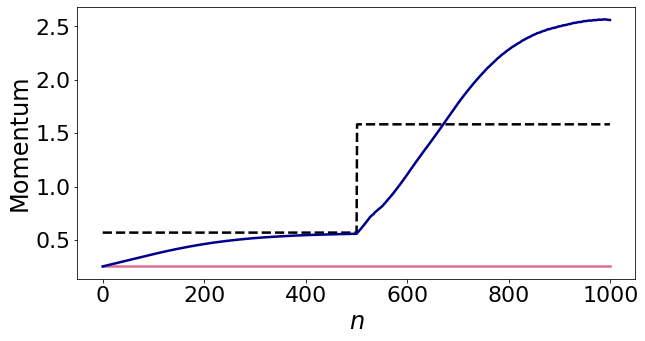

In [16]:

vanilla_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_0), axis=-1)

vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_momentum_0,
    label=r"$Vanilla(\lambda = 0)$",
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Momentum Done---")


In [25]:



# Save data
results_dict = {'vanilla_kdv_opt_momentum_0': vanilla_kdv_opt_momentum_0,
            'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
            'vanilla_kdv_opt_mass_0': vanilla_kdv_opt_mass_0,
            'vanilla_kdv_opt_mass_5': vanilla_kdv_opt_mass_5,
            'mass_ref':mass_ref,
            'momentum_ref':momentum_ref,
            'vanilla_t_list_momentum_0': vanilla_t_list_momentum_0,
            'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5,
}

np.save(os.path.join(data_path,'vanilla'+forcing_type+'_tau_'+str(tau)+'_tracking_results.npy'), results_dict)

In [23]:
vanilla_results_momentum_5[-1]

      fun: 0.005579436296541688
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.75814224e-07, -2.53269627e-08,  1.03389519e-07,  7.10369263e-08,
       -2.45983789e-07, -1.07205911e-07,  8.35269354e-08, -2.26207941e-07,
        1.98452366e-07,  1.75900960e-07, -4.10262102e-08, -2.29330444e-07,
       -1.21083699e-07, -3.34541422e-07, -2.12677098e-07, -2.87096735e-08,
        7.04297731e-08,  2.91953961e-07, -2.24386482e-07,  1.65666092e-07,
       -1.16226473e-07, -1.42073853e-07,  8.65627014e-08, -1.01481323e-08,
        6.60929644e-08, -1.32966554e-07, -1.05384451e-07, -1.21343907e-07,
       -4.04190570e-08, -2.16406754e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 93
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-0.01743068, -0.01821583,  0.00199996, -0.01744066, -0.01823759,
        0.0019789 , -0.01743982, -0.01823624,  0.00200904, -0.01743069,
       -0.0182174 ,  0.00196649, -0.01746012, 

In [24]:
results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(data_path,"results_dict_list_vanilla_momentum_5.csv"), index=False)

